# Remove Instrument Response

This is an example notebook for removing the instrument response to calibrate the data into physical units.  

**Note**: The workflow in this notebook is all incorporated into a class `mth5.timeseris.ts_filters.RemoveInstrumentResponse` and has been incorporated into `mth5.timeseries.ChannelTS` as `mth5.timeseries.ChannelTS.remove_instrument_response` and `mth5.timeseries.RunTS` as `mth5.timeseries.RunTS.calibrate`.  An example is shown at the bottom of the notebook.    

All the filters are represented as `mt_metadata.timeseries.filters` objects.  More information about these can be found in [mt_metadata filters](https://mt-metadata.readthedocs.io/en/latest/source/notebooks/filters_example.html).

This example will read in an existing MTH5 that has one station `CAS04`, one run `a`, and 2 channels `ex` and `hx`. 

In [9]:
from mth5.mth5 import MTH5
%matplotlib widget

## Open the MTH5 file

This has 2 stations in it CAS04 and NVR08 both MTArray/Earthscope stations.  Each only has one run. You can make this MTH5 file using `make_mth5_driver_v0.2.0.ipnb`  

In [3]:
m = MTH5()
m.open_mth5(r"8P_CAS04_NVR08.h5")

Have a look at the channel summary.  This is a table of all the channels available in the MTH5 file.

In [4]:
m.channel_summary.summarize()
ch_df = m.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,CAS04a,37.633351,-121.468382,329.387,ex,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,electric,13.2,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,CAS04a,37.633351,-121.468382,329.387,ey,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,electric,103.2,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,CAS04a,37.633351,-121.468382,329.387,hx,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,magnetic,13.2,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,CAS04a,37.633351,-121.468382,329.387,hy,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,magnetic,103.2,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,CAS04a,37.633351,-121.468382,329.387,hz,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,magnetic,13.2,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CONUS South,NVR08,c,38.326630,-118.082382,1375.425,ex,2020-06-14 18:00:44+00:00,2020-06-24 15:55:47+00:00,856503,1.0,electric,12.6,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
66,CONUS South,NVR08,c,38.326630,-118.082382,1375.425,ey,2020-06-14 18:00:44+00:00,2020-06-24 15:55:47+00:00,856503,1.0,electric,102.6,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
67,CONUS South,NVR08,c,38.326630,-118.082382,1375.425,hx,2020-06-14 18:00:44+00:00,2020-06-24 15:55:47+00:00,856503,1.0,magnetic,12.6,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
68,CONUS South,NVR08,c,38.326630,-118.082382,1375.425,hy,2020-06-14 18:00:44+00:00,2020-06-24 15:55:47+00:00,856503,1.0,magnetic,102.6,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Get observatory data

https://geomag.usgs.gov/ws/data/?id=FRN&type=adjusted&elements=H&sampling_period=1&format=json&starttime=2020-06-02T19:00:00Z&endtime=2020-06-02T22:07:46Z

In [16]:
import json
frn_json = json.loads('{"type":"Timeseries","metadata":{"intermagnet":{"imo":{"iaga_code":"FRN","name":"Fresno","coordinates":[240.282,37.091,331.0]},"reported_orientation":"H","sensor_orientation":"HDZF","data_type":"adjusted","sampling_period":1,"digital_sampling_rate":0.01},"status":200,"generated":"2022-04-11T23:46:00Z","url":null},"times":["2020-06-02T19:00:00.000Z","2020-06-02T19:00:01.000Z","2020-06-02T19:00:02.000Z","2020-06-02T19:00:03.000Z","2020-06-02T19:00:04.000Z","2020-06-02T19:00:05.000Z","2020-06-02T19:00:06.000Z","2020-06-02T19:00:07.000Z","2020-06-02T19:00:08.000Z","2020-06-02T19:00:09.000Z","2020-06-02T19:00:10.000Z","2020-06-02T19:00:11.000Z","2020-06-02T19:00:12.000Z","2020-06-02T19:00:13.000Z","2020-06-02T19:00:14.000Z","2020-06-02T19:00:15.000Z","2020-06-02T19:00:16.000Z","2020-06-02T19:00:17.000Z","2020-06-02T19:00:18.000Z","2020-06-02T19:00:19.000Z","2020-06-02T19:00:20.000Z","2020-06-02T19:00:21.000Z","2020-06-02T19:00:22.000Z","2020-06-02T19:00:23.000Z","2020-06-02T19:00:24.000Z","2020-06-02T19:00:25.000Z","2020-06-02T19:00:26.000Z","2020-06-02T19:00:27.000Z","2020-06-02T19:00:28.000Z","2020-06-02T19:00:29.000Z","2020-06-02T19:00:30.000Z","2020-06-02T19:00:31.000Z","2020-06-02T19:00:32.000Z","2020-06-02T19:00:33.000Z","2020-06-02T19:00:34.000Z","2020-06-02T19:00:35.000Z","2020-06-02T19:00:36.000Z","2020-06-02T19:00:37.000Z","2020-06-02T19:00:38.000Z","2020-06-02T19:00:39.000Z","2020-06-02T19:00:40.000Z","2020-06-02T19:00:41.000Z","2020-06-02T19:00:42.000Z","2020-06-02T19:00:43.000Z","2020-06-02T19:00:44.000Z","2020-06-02T19:00:45.000Z","2020-06-02T19:00:46.000Z","2020-06-02T19:00:47.000Z","2020-06-02T19:00:48.000Z","2020-06-02T19:00:49.000Z","2020-06-02T19:00:50.000Z","2020-06-02T19:00:51.000Z","2020-06-02T19:00:52.000Z","2020-06-02T19:00:53.000Z","2020-06-02T19:00:54.000Z","2020-06-02T19:00:55.000Z","2020-06-02T19:00:56.000Z","2020-06-02T19:00:57.000Z","2020-06-02T19:00:58.000Z","2020-06-02T19:00:59.000Z","2020-06-02T19:01:00.000Z","2020-06-02T19:01:01.000Z","2020-06-02T19:01:02.000Z","2020-06-02T19:01:03.000Z","2020-06-02T19:01:04.000Z","2020-06-02T19:01:05.000Z","2020-06-02T19:01:06.000Z","2020-06-02T19:01:07.000Z","2020-06-02T19:01:08.000Z","2020-06-02T19:01:09.000Z","2020-06-02T19:01:10.000Z","2020-06-02T19:01:11.000Z","2020-06-02T19:01:12.000Z","2020-06-02T19:01:13.000Z","2020-06-02T19:01:14.000Z","2020-06-02T19:01:15.000Z","2020-06-02T19:01:16.000Z","2020-06-02T19:01:17.000Z","2020-06-02T19:01:18.000Z","2020-06-02T19:01:19.000Z","2020-06-02T19:01:20.000Z","2020-06-02T19:01:21.000Z","2020-06-02T19:01:22.000Z","2020-06-02T19:01:23.000Z","2020-06-02T19:01:24.000Z","2020-06-02T19:01:25.000Z","2020-06-02T19:01:26.000Z","2020-06-02T19:01:27.000Z","2020-06-02T19:01:28.000Z","2020-06-02T19:01:29.000Z","2020-06-02T19:01:30.000Z","2020-06-02T19:01:31.000Z","2020-06-02T19:01:32.000Z","2020-06-02T19:01:33.000Z","2020-06-02T19:01:34.000Z","2020-06-02T19:01:35.000Z","2020-06-02T19:01:36.000Z","2020-06-02T19:01:37.000Z","2020-06-02T19:01:38.000Z","2020-06-02T19:01:39.000Z","2020-06-02T19:01:40.000Z","2020-06-02T19:01:41.000Z","2020-06-02T19:01:42.000Z","2020-06-02T19:01:43.000Z","2020-06-02T19:01:44.000Z","2020-06-02T19:01:45.000Z","2020-06-02T19:01:46.000Z","2020-06-02T19:01:47.000Z","2020-06-02T19:01:48.000Z","2020-06-02T19:01:49.000Z","2020-06-02T19:01:50.000Z","2020-06-02T19:01:51.000Z","2020-06-02T19:01:52.000Z","2020-06-02T19:01:53.000Z","2020-06-02T19:01:54.000Z","2020-06-02T19:01:55.000Z","2020-06-02T19:01:56.000Z","2020-06-02T19:01:57.000Z","2020-06-02T19:01:58.000Z","2020-06-02T19:01:59.000Z","2020-06-02T19:02:00.000Z","2020-06-02T19:02:01.000Z","2020-06-02T19:02:02.000Z","2020-06-02T19:02:03.000Z","2020-06-02T19:02:04.000Z","2020-06-02T19:02:05.000Z","2020-06-02T19:02:06.000Z","2020-06-02T19:02:07.000Z","2020-06-02T19:02:08.000Z","2020-06-02T19:02:09.000Z","2020-06-02T19:02:10.000Z","2020-06-02T19:02:11.000Z","2020-06-02T19:02:12.000Z","2020-06-02T19:02:13.000Z","2020-06-02T19:02:14.000Z","2020-06-02T19:02:15.000Z","2020-06-02T19:02:16.000Z","2020-06-02T19:02:17.000Z","2020-06-02T19:02:18.000Z","2020-06-02T19:02:19.000Z","2020-06-02T19:02:20.000Z","2020-06-02T19:02:21.000Z","2020-06-02T19:02:22.000Z","2020-06-02T19:02:23.000Z","2020-06-02T19:02:24.000Z","2020-06-02T19:02:25.000Z","2020-06-02T19:02:26.000Z","2020-06-02T19:02:27.000Z","2020-06-02T19:02:28.000Z","2020-06-02T19:02:29.000Z","2020-06-02T19:02:30.000Z","2020-06-02T19:02:31.000Z","2020-06-02T19:02:32.000Z","2020-06-02T19:02:33.000Z","2020-06-02T19:02:34.000Z","2020-06-02T19:02:35.000Z","2020-06-02T19:02:36.000Z","2020-06-02T19:02:37.000Z","2020-06-02T19:02:38.000Z","2020-06-02T19:02:39.000Z","2020-06-02T19:02:40.000Z","2020-06-02T19:02:41.000Z","2020-06-02T19:02:42.000Z","2020-06-02T19:02:43.000Z","2020-06-02T19:02:44.000Z","2020-06-02T19:02:45.000Z","2020-06-02T19:02:46.000Z","2020-06-02T19:02:47.000Z","2020-06-02T19:02:48.000Z","2020-06-02T19:02:49.000Z","2020-06-02T19:02:50.000Z","2020-06-02T19:02:51.000Z","2020-06-02T19:02:52.000Z","2020-06-02T19:02:53.000Z","2020-06-02T19:02:54.000Z","2020-06-02T19:02:55.000Z","2020-06-02T19:02:56.000Z","2020-06-02T19:02:57.000Z","2020-06-02T19:02:58.000Z","2020-06-02T19:02:59.000Z","2020-06-02T19:03:00.000Z","2020-06-02T19:03:01.000Z","2020-06-02T19:03:02.000Z","2020-06-02T19:03:03.000Z","2020-06-02T19:03:04.000Z","2020-06-02T19:03:05.000Z","2020-06-02T19:03:06.000Z","2020-06-02T19:03:07.000Z","2020-06-02T19:03:08.000Z","2020-06-02T19:03:09.000Z","2020-06-02T19:03:10.000Z","2020-06-02T19:03:11.000Z","2020-06-02T19:03:12.000Z","2020-06-02T19:03:13.000Z","2020-06-02T19:03:14.000Z","2020-06-02T19:03:15.000Z","2020-06-02T19:03:16.000Z","2020-06-02T19:03:17.000Z","2020-06-02T19:03:18.000Z","2020-06-02T19:03:19.000Z","2020-06-02T19:03:20.000Z","2020-06-02T19:03:21.000Z","2020-06-02T19:03:22.000Z","2020-06-02T19:03:23.000Z","2020-06-02T19:03:24.000Z","2020-06-02T19:03:25.000Z","2020-06-02T19:03:26.000Z","2020-06-02T19:03:27.000Z","2020-06-02T19:03:28.000Z","2020-06-02T19:03:29.000Z","2020-06-02T19:03:30.000Z","2020-06-02T19:03:31.000Z","2020-06-02T19:03:32.000Z","2020-06-02T19:03:33.000Z","2020-06-02T19:03:34.000Z","2020-06-02T19:03:35.000Z","2020-06-02T19:03:36.000Z","2020-06-02T19:03:37.000Z","2020-06-02T19:03:38.000Z","2020-06-02T19:03:39.000Z","2020-06-02T19:03:40.000Z","2020-06-02T19:03:41.000Z","2020-06-02T19:03:42.000Z","2020-06-02T19:03:43.000Z","2020-06-02T19:03:44.000Z","2020-06-02T19:03:45.000Z","2020-06-02T19:03:46.000Z","2020-06-02T19:03:47.000Z","2020-06-02T19:03:48.000Z","2020-06-02T19:03:49.000Z","2020-06-02T19:03:50.000Z","2020-06-02T19:03:51.000Z","2020-06-02T19:03:52.000Z","2020-06-02T19:03:53.000Z","2020-06-02T19:03:54.000Z","2020-06-02T19:03:55.000Z","2020-06-02T19:03:56.000Z","2020-06-02T19:03:57.000Z","2020-06-02T19:03:58.000Z","2020-06-02T19:03:59.000Z","2020-06-02T19:04:00.000Z","2020-06-02T19:04:01.000Z","2020-06-02T19:04:02.000Z","2020-06-02T19:04:03.000Z","2020-06-02T19:04:04.000Z","2020-06-02T19:04:05.000Z","2020-06-02T19:04:06.000Z","2020-06-02T19:04:07.000Z","2020-06-02T19:04:08.000Z","2020-06-02T19:04:09.000Z","2020-06-02T19:04:10.000Z","2020-06-02T19:04:11.000Z","2020-06-02T19:04:12.000Z","2020-06-02T19:04:13.000Z","2020-06-02T19:04:14.000Z","2020-06-02T19:04:15.000Z","2020-06-02T19:04:16.000Z","2020-06-02T19:04:17.000Z","2020-06-02T19:04:18.000Z","2020-06-02T19:04:19.000Z","2020-06-02T19:04:20.000Z","2020-06-02T19:04:21.000Z","2020-06-02T19:04:22.000Z","2020-06-02T19:04:23.000Z","2020-06-02T19:04:24.000Z","2020-06-02T19:04:25.000Z","2020-06-02T19:04:26.000Z","2020-06-02T19:04:27.000Z","2020-06-02T19:04:28.000Z","2020-06-02T19:04:29.000Z","2020-06-02T19:04:30.000Z","2020-06-02T19:04:31.000Z","2020-06-02T19:04:32.000Z","2020-06-02T19:04:33.000Z","2020-06-02T19:04:34.000Z","2020-06-02T19:04:35.000Z","2020-06-02T19:04:36.000Z","2020-06-02T19:04:37.000Z","2020-06-02T19:04:38.000Z","2020-06-02T19:04:39.000Z","2020-06-02T19:04:40.000Z","2020-06-02T19:04:41.000Z","2020-06-02T19:04:42.000Z","2020-06-02T19:04:43.000Z","2020-06-02T19:04:44.000Z","2020-06-02T19:04:45.000Z","2020-06-02T19:04:46.000Z","2020-06-02T19:04:47.000Z","2020-06-02T19:04:48.000Z","2020-06-02T19:04:49.000Z","2020-06-02T19:04:50.000Z","2020-06-02T19:04:51.000Z","2020-06-02T19:04:52.000Z","2020-06-02T19:04:53.000Z","2020-06-02T19:04:54.000Z","2020-06-02T19:04:55.000Z","2020-06-02T19:04:56.000Z","2020-06-02T19:04:57.000Z","2020-06-02T19:04:58.000Z","2020-06-02T19:04:59.000Z","2020-06-02T19:05:00.000Z","2020-06-02T19:05:01.000Z","2020-06-02T19:05:02.000Z","2020-06-02T19:05:03.000Z","2020-06-02T19:05:04.000Z","2020-06-02T19:05:05.000Z","2020-06-02T19:05:06.000Z","2020-06-02T19:05:07.000Z","2020-06-02T19:05:08.000Z","2020-06-02T19:05:09.000Z","2020-06-02T19:05:10.000Z","2020-06-02T19:05:11.000Z","2020-06-02T19:05:12.000Z","2020-06-02T19:05:13.000Z","2020-06-02T19:05:14.000Z","2020-06-02T19:05:15.000Z","2020-06-02T19:05:16.000Z","2020-06-02T19:05:17.000Z","2020-06-02T19:05:18.000Z","2020-06-02T19:05:19.000Z","2020-06-02T19:05:20.000Z","2020-06-02T19:05:21.000Z","2020-06-02T19:05:22.000Z","2020-06-02T19:05:23.000Z","2020-06-02T19:05:24.000Z","2020-06-02T19:05:25.000Z","2020-06-02T19:05:26.000Z","2020-06-02T19:05:27.000Z","2020-06-02T19:05:28.000Z","2020-06-02T19:05:29.000Z","2020-06-02T19:05:30.000Z","2020-06-02T19:05:31.000Z","2020-06-02T19:05:32.000Z","2020-06-02T19:05:33.000Z","2020-06-02T19:05:34.000Z","2020-06-02T19:05:35.000Z","2020-06-02T19:05:36.000Z","2020-06-02T19:05:37.000Z","2020-06-02T19:05:38.000Z","2020-06-02T19:05:39.000Z","2020-06-02T19:05:40.000Z","2020-06-02T19:05:41.000Z","2020-06-02T19:05:42.000Z","2020-06-02T19:05:43.000Z","2020-06-02T19:05:44.000Z","2020-06-02T19:05:45.000Z","2020-06-02T19:05:46.000Z","2020-06-02T19:05:47.000Z","2020-06-02T19:05:48.000Z","2020-06-02T19:05:49.000Z","2020-06-02T19:05:50.000Z","2020-06-02T19:05:51.000Z","2020-06-02T19:05:52.000Z","2020-06-02T19:05:53.000Z","2020-06-02T19:05:54.000Z","2020-06-02T19:05:55.000Z","2020-06-02T19:05:56.000Z","2020-06-02T19:05:57.000Z","2020-06-02T19:05:58.000Z","2020-06-02T19:05:59.000Z","2020-06-02T19:06:00.000Z","2020-06-02T19:06:01.000Z","2020-06-02T19:06:02.000Z","2020-06-02T19:06:03.000Z","2020-06-02T19:06:04.000Z","2020-06-02T19:06:05.000Z","2020-06-02T19:06:06.000Z","2020-06-02T19:06:07.000Z","2020-06-02T19:06:08.000Z","2020-06-02T19:06:09.000Z","2020-06-02T19:06:10.000Z","2020-06-02T19:06:11.000Z","2020-06-02T19:06:12.000Z","2020-06-02T19:06:13.000Z","2020-06-02T19:06:14.000Z","2020-06-02T19:06:15.000Z","2020-06-02T19:06:16.000Z","2020-06-02T19:06:17.000Z","2020-06-02T19:06:18.000Z","2020-06-02T19:06:19.000Z","2020-06-02T19:06:20.000Z","2020-06-02T19:06:21.000Z","2020-06-02T19:06:22.000Z","2020-06-02T19:06:23.000Z","2020-06-02T19:06:24.000Z","2020-06-02T19:06:25.000Z","2020-06-02T19:06:26.000Z","2020-06-02T19:06:27.000Z","2020-06-02T19:06:28.000Z","2020-06-02T19:06:29.000Z","2020-06-02T19:06:30.000Z","2020-06-02T19:06:31.000Z","2020-06-02T19:06:32.000Z","2020-06-02T19:06:33.000Z","2020-06-02T19:06:34.000Z","2020-06-02T19:06:35.000Z","2020-06-02T19:06:36.000Z","2020-06-02T19:06:37.000Z","2020-06-02T19:06:38.000Z","2020-06-02T19:06:39.000Z","2020-06-02T19:06:40.000Z","2020-06-02T19:06:41.000Z","2020-06-02T19:06:42.000Z","2020-06-02T19:06:43.000Z","2020-06-02T19:06:44.000Z","2020-06-02T19:06:45.000Z","2020-06-02T19:06:46.000Z","2020-06-02T19:06:47.000Z","2020-06-02T19:06:48.000Z","2020-06-02T19:06:49.000Z","2020-06-02T19:06:50.000Z","2020-06-02T19:06:51.000Z","2020-06-02T19:06:52.000Z","2020-06-02T19:06:53.000Z","2020-06-02T19:06:54.000Z","2020-06-02T19:06:55.000Z","2020-06-02T19:06:56.000Z","2020-06-02T19:06:57.000Z","2020-06-02T19:06:58.000Z","2020-06-02T19:06:59.000Z","2020-06-02T19:07:00.000Z","2020-06-02T19:07:01.000Z","2020-06-02T19:07:02.000Z","2020-06-02T19:07:03.000Z","2020-06-02T19:07:04.000Z","2020-06-02T19:07:05.000Z","2020-06-02T19:07:06.000Z","2020-06-02T19:07:07.000Z","2020-06-02T19:07:08.000Z","2020-06-02T19:07:09.000Z","2020-06-02T19:07:10.000Z","2020-06-02T19:07:11.000Z","2020-06-02T19:07:12.000Z","2020-06-02T19:07:13.000Z","2020-06-02T19:07:14.000Z","2020-06-02T19:07:15.000Z","2020-06-02T19:07:16.000Z","2020-06-02T19:07:17.000Z","2020-06-02T19:07:18.000Z","2020-06-02T19:07:19.000Z","2020-06-02T19:07:20.000Z","2020-06-02T19:07:21.000Z","2020-06-02T19:07:22.000Z","2020-06-02T19:07:23.000Z","2020-06-02T19:07:24.000Z","2020-06-02T19:07:25.000Z","2020-06-02T19:07:26.000Z","2020-06-02T19:07:27.000Z","2020-06-02T19:07:28.000Z","2020-06-02T19:07:29.000Z","2020-06-02T19:07:30.000Z","2020-06-02T19:07:31.000Z","2020-06-02T19:07:32.000Z","2020-06-02T19:07:33.000Z","2020-06-02T19:07:34.000Z","2020-06-02T19:07:35.000Z","2020-06-02T19:07:36.000Z","2020-06-02T19:07:37.000Z","2020-06-02T19:07:38.000Z","2020-06-02T19:07:39.000Z","2020-06-02T19:07:40.000Z","2020-06-02T19:07:41.000Z","2020-06-02T19:07:42.000Z","2020-06-02T19:07:43.000Z","2020-06-02T19:07:44.000Z","2020-06-02T19:07:45.000Z","2020-06-02T19:07:46.000Z","2020-06-02T19:07:47.000Z","2020-06-02T19:07:48.000Z","2020-06-02T19:07:49.000Z","2020-06-02T19:07:50.000Z","2020-06-02T19:07:51.000Z","2020-06-02T19:07:52.000Z","2020-06-02T19:07:53.000Z","2020-06-02T19:07:54.000Z","2020-06-02T19:07:55.000Z","2020-06-02T19:07:56.000Z","2020-06-02T19:07:57.000Z","2020-06-02T19:07:58.000Z","2020-06-02T19:07:59.000Z","2020-06-02T19:08:00.000Z","2020-06-02T19:08:01.000Z","2020-06-02T19:08:02.000Z","2020-06-02T19:08:03.000Z","2020-06-02T19:08:04.000Z","2020-06-02T19:08:05.000Z","2020-06-02T19:08:06.000Z","2020-06-02T19:08:07.000Z","2020-06-02T19:08:08.000Z","2020-06-02T19:08:09.000Z","2020-06-02T19:08:10.000Z","2020-06-02T19:08:11.000Z","2020-06-02T19:08:12.000Z","2020-06-02T19:08:13.000Z","2020-06-02T19:08:14.000Z","2020-06-02T19:08:15.000Z","2020-06-02T19:08:16.000Z","2020-06-02T19:08:17.000Z","2020-06-02T19:08:18.000Z","2020-06-02T19:08:19.000Z","2020-06-02T19:08:20.000Z","2020-06-02T19:08:21.000Z","2020-06-02T19:08:22.000Z","2020-06-02T19:08:23.000Z","2020-06-02T19:08:24.000Z","2020-06-02T19:08:25.000Z","2020-06-02T19:08:26.000Z","2020-06-02T19:08:27.000Z","2020-06-02T19:08:28.000Z","2020-06-02T19:08:29.000Z","2020-06-02T19:08:30.000Z","2020-06-02T19:08:31.000Z","2020-06-02T19:08:32.000Z","2020-06-02T19:08:33.000Z","2020-06-02T19:08:34.000Z","2020-06-02T19:08:35.000Z","2020-06-02T19:08:36.000Z","2020-06-02T19:08:37.000Z","2020-06-02T19:08:38.000Z","2020-06-02T19:08:39.000Z","2020-06-02T19:08:40.000Z","2020-06-02T19:08:41.000Z","2020-06-02T19:08:42.000Z","2020-06-02T19:08:43.000Z","2020-06-02T19:08:44.000Z","2020-06-02T19:08:45.000Z","2020-06-02T19:08:46.000Z","2020-06-02T19:08:47.000Z","2020-06-02T19:08:48.000Z","2020-06-02T19:08:49.000Z","2020-06-02T19:08:50.000Z","2020-06-02T19:08:51.000Z","2020-06-02T19:08:52.000Z","2020-06-02T19:08:53.000Z","2020-06-02T19:08:54.000Z","2020-06-02T19:08:55.000Z","2020-06-02T19:08:56.000Z","2020-06-02T19:08:57.000Z","2020-06-02T19:08:58.000Z","2020-06-02T19:08:59.000Z","2020-06-02T19:09:00.000Z","2020-06-02T19:09:01.000Z","2020-06-02T19:09:02.000Z","2020-06-02T19:09:03.000Z","2020-06-02T19:09:04.000Z","2020-06-02T19:09:05.000Z","2020-06-02T19:09:06.000Z","2020-06-02T19:09:07.000Z","2020-06-02T19:09:08.000Z","2020-06-02T19:09:09.000Z","2020-06-02T19:09:10.000Z","2020-06-02T19:09:11.000Z","2020-06-02T19:09:12.000Z","2020-06-02T19:09:13.000Z","2020-06-02T19:09:14.000Z","2020-06-02T19:09:15.000Z","2020-06-02T19:09:16.000Z","2020-06-02T19:09:17.000Z","2020-06-02T19:09:18.000Z","2020-06-02T19:09:19.000Z","2020-06-02T19:09:20.000Z","2020-06-02T19:09:21.000Z","2020-06-02T19:09:22.000Z","2020-06-02T19:09:23.000Z","2020-06-02T19:09:24.000Z","2020-06-02T19:09:25.000Z","2020-06-02T19:09:26.000Z","2020-06-02T19:09:27.000Z","2020-06-02T19:09:28.000Z","2020-06-02T19:09:29.000Z","2020-06-02T19:09:30.000Z","2020-06-02T19:09:31.000Z","2020-06-02T19:09:32.000Z","2020-06-02T19:09:33.000Z","2020-06-02T19:09:34.000Z","2020-06-02T19:09:35.000Z","2020-06-02T19:09:36.000Z","2020-06-02T19:09:37.000Z","2020-06-02T19:09:38.000Z","2020-06-02T19:09:39.000Z","2020-06-02T19:09:40.000Z","2020-06-02T19:09:41.000Z","2020-06-02T19:09:42.000Z","2020-06-02T19:09:43.000Z","2020-06-02T19:09:44.000Z","2020-06-02T19:09:45.000Z","2020-06-02T19:09:46.000Z","2020-06-02T19:09:47.000Z","2020-06-02T19:09:48.000Z","2020-06-02T19:09:49.000Z","2020-06-02T19:09:50.000Z","2020-06-02T19:09:51.000Z","2020-06-02T19:09:52.000Z","2020-06-02T19:09:53.000Z","2020-06-02T19:09:54.000Z","2020-06-02T19:09:55.000Z","2020-06-02T19:09:56.000Z","2020-06-02T19:09:57.000Z","2020-06-02T19:09:58.000Z","2020-06-02T19:09:59.000Z","2020-06-02T19:10:00.000Z","2020-06-02T19:10:01.000Z","2020-06-02T19:10:02.000Z","2020-06-02T19:10:03.000Z","2020-06-02T19:10:04.000Z","2020-06-02T19:10:05.000Z","2020-06-02T19:10:06.000Z","2020-06-02T19:10:07.000Z","2020-06-02T19:10:08.000Z","2020-06-02T19:10:09.000Z","2020-06-02T19:10:10.000Z","2020-06-02T19:10:11.000Z","2020-06-02T19:10:12.000Z","2020-06-02T19:10:13.000Z","2020-06-02T19:10:14.000Z","2020-06-02T19:10:15.000Z","2020-06-02T19:10:16.000Z","2020-06-02T19:10:17.000Z","2020-06-02T19:10:18.000Z","2020-06-02T19:10:19.000Z","2020-06-02T19:10:20.000Z","2020-06-02T19:10:21.000Z","2020-06-02T19:10:22.000Z","2020-06-02T19:10:23.000Z","2020-06-02T19:10:24.000Z","2020-06-02T19:10:25.000Z","2020-06-02T19:10:26.000Z","2020-06-02T19:10:27.000Z","2020-06-02T19:10:28.000Z","2020-06-02T19:10:29.000Z","2020-06-02T19:10:30.000Z","2020-06-02T19:10:31.000Z","2020-06-02T19:10:32.000Z","2020-06-02T19:10:33.000Z","2020-06-02T19:10:34.000Z","2020-06-02T19:10:35.000Z","2020-06-02T19:10:36.000Z","2020-06-02T19:10:37.000Z","2020-06-02T19:10:38.000Z","2020-06-02T19:10:39.000Z","2020-06-02T19:10:40.000Z","2020-06-02T19:10:41.000Z","2020-06-02T19:10:42.000Z","2020-06-02T19:10:43.000Z","2020-06-02T19:10:44.000Z","2020-06-02T19:10:45.000Z","2020-06-02T19:10:46.000Z","2020-06-02T19:10:47.000Z","2020-06-02T19:10:48.000Z","2020-06-02T19:10:49.000Z","2020-06-02T19:10:50.000Z","2020-06-02T19:10:51.000Z","2020-06-02T19:10:52.000Z","2020-06-02T19:10:53.000Z","2020-06-02T19:10:54.000Z","2020-06-02T19:10:55.000Z","2020-06-02T19:10:56.000Z","2020-06-02T19:10:57.000Z","2020-06-02T19:10:58.000Z","2020-06-02T19:10:59.000Z","2020-06-02T19:11:00.000Z","2020-06-02T19:11:01.000Z","2020-06-02T19:11:02.000Z","2020-06-02T19:11:03.000Z","2020-06-02T19:11:04.000Z","2020-06-02T19:11:05.000Z","2020-06-02T19:11:06.000Z","2020-06-02T19:11:07.000Z","2020-06-02T19:11:08.000Z","2020-06-02T19:11:09.000Z","2020-06-02T19:11:10.000Z","2020-06-02T19:11:11.000Z","2020-06-02T19:11:12.000Z","2020-06-02T19:11:13.000Z","2020-06-02T19:11:14.000Z","2020-06-02T19:11:15.000Z","2020-06-02T19:11:16.000Z","2020-06-02T19:11:17.000Z","2020-06-02T19:11:18.000Z","2020-06-02T19:11:19.000Z","2020-06-02T19:11:20.000Z","2020-06-02T19:11:21.000Z","2020-06-02T19:11:22.000Z","2020-06-02T19:11:23.000Z","2020-06-02T19:11:24.000Z","2020-06-02T19:11:25.000Z","2020-06-02T19:11:26.000Z","2020-06-02T19:11:27.000Z","2020-06-02T19:11:28.000Z","2020-06-02T19:11:29.000Z","2020-06-02T19:11:30.000Z","2020-06-02T19:11:31.000Z","2020-06-02T19:11:32.000Z","2020-06-02T19:11:33.000Z","2020-06-02T19:11:34.000Z","2020-06-02T19:11:35.000Z","2020-06-02T19:11:36.000Z","2020-06-02T19:11:37.000Z","2020-06-02T19:11:38.000Z","2020-06-02T19:11:39.000Z","2020-06-02T19:11:40.000Z","2020-06-02T19:11:41.000Z","2020-06-02T19:11:42.000Z","2020-06-02T19:11:43.000Z","2020-06-02T19:11:44.000Z","2020-06-02T19:11:45.000Z","2020-06-02T19:11:46.000Z","2020-06-02T19:11:47.000Z","2020-06-02T19:11:48.000Z","2020-06-02T19:11:49.000Z","2020-06-02T19:11:50.000Z","2020-06-02T19:11:51.000Z","2020-06-02T19:11:52.000Z","2020-06-02T19:11:53.000Z","2020-06-02T19:11:54.000Z","2020-06-02T19:11:55.000Z","2020-06-02T19:11:56.000Z","2020-06-02T19:11:57.000Z","2020-06-02T19:11:58.000Z","2020-06-02T19:11:59.000Z","2020-06-02T19:12:00.000Z","2020-06-02T19:12:01.000Z","2020-06-02T19:12:02.000Z","2020-06-02T19:12:03.000Z","2020-06-02T19:12:04.000Z","2020-06-02T19:12:05.000Z","2020-06-02T19:12:06.000Z","2020-06-02T19:12:07.000Z","2020-06-02T19:12:08.000Z","2020-06-02T19:12:09.000Z","2020-06-02T19:12:10.000Z","2020-06-02T19:12:11.000Z","2020-06-02T19:12:12.000Z","2020-06-02T19:12:13.000Z","2020-06-02T19:12:14.000Z","2020-06-02T19:12:15.000Z","2020-06-02T19:12:16.000Z","2020-06-02T19:12:17.000Z","2020-06-02T19:12:18.000Z","2020-06-02T19:12:19.000Z","2020-06-02T19:12:20.000Z","2020-06-02T19:12:21.000Z","2020-06-02T19:12:22.000Z","2020-06-02T19:12:23.000Z","2020-06-02T19:12:24.000Z","2020-06-02T19:12:25.000Z","2020-06-02T19:12:26.000Z","2020-06-02T19:12:27.000Z","2020-06-02T19:12:28.000Z","2020-06-02T19:12:29.000Z","2020-06-02T19:12:30.000Z","2020-06-02T19:12:31.000Z","2020-06-02T19:12:32.000Z","2020-06-02T19:12:33.000Z","2020-06-02T19:12:34.000Z","2020-06-02T19:12:35.000Z","2020-06-02T19:12:36.000Z","2020-06-02T19:12:37.000Z","2020-06-02T19:12:38.000Z","2020-06-02T19:12:39.000Z","2020-06-02T19:12:40.000Z","2020-06-02T19:12:41.000Z","2020-06-02T19:12:42.000Z","2020-06-02T19:12:43.000Z","2020-06-02T19:12:44.000Z","2020-06-02T19:12:45.000Z","2020-06-02T19:12:46.000Z","2020-06-02T19:12:47.000Z","2020-06-02T19:12:48.000Z","2020-06-02T19:12:49.000Z","2020-06-02T19:12:50.000Z","2020-06-02T19:12:51.000Z","2020-06-02T19:12:52.000Z","2020-06-02T19:12:53.000Z","2020-06-02T19:12:54.000Z","2020-06-02T19:12:55.000Z","2020-06-02T19:12:56.000Z","2020-06-02T19:12:57.000Z","2020-06-02T19:12:58.000Z","2020-06-02T19:12:59.000Z","2020-06-02T19:13:00.000Z","2020-06-02T19:13:01.000Z","2020-06-02T19:13:02.000Z","2020-06-02T19:13:03.000Z","2020-06-02T19:13:04.000Z","2020-06-02T19:13:05.000Z","2020-06-02T19:13:06.000Z","2020-06-02T19:13:07.000Z","2020-06-02T19:13:08.000Z","2020-06-02T19:13:09.000Z","2020-06-02T19:13:10.000Z","2020-06-02T19:13:11.000Z","2020-06-02T19:13:12.000Z","2020-06-02T19:13:13.000Z","2020-06-02T19:13:14.000Z","2020-06-02T19:13:15.000Z","2020-06-02T19:13:16.000Z","2020-06-02T19:13:17.000Z","2020-06-02T19:13:18.000Z","2020-06-02T19:13:19.000Z","2020-06-02T19:13:20.000Z","2020-06-02T19:13:21.000Z","2020-06-02T19:13:22.000Z","2020-06-02T19:13:23.000Z","2020-06-02T19:13:24.000Z","2020-06-02T19:13:25.000Z","2020-06-02T19:13:26.000Z","2020-06-02T19:13:27.000Z","2020-06-02T19:13:28.000Z","2020-06-02T19:13:29.000Z","2020-06-02T19:13:30.000Z","2020-06-02T19:13:31.000Z","2020-06-02T19:13:32.000Z","2020-06-02T19:13:33.000Z","2020-06-02T19:13:34.000Z","2020-06-02T19:13:35.000Z","2020-06-02T19:13:36.000Z","2020-06-02T19:13:37.000Z","2020-06-02T19:13:38.000Z","2020-06-02T19:13:39.000Z","2020-06-02T19:13:40.000Z","2020-06-02T19:13:41.000Z","2020-06-02T19:13:42.000Z","2020-06-02T19:13:43.000Z","2020-06-02T19:13:44.000Z","2020-06-02T19:13:45.000Z","2020-06-02T19:13:46.000Z","2020-06-02T19:13:47.000Z","2020-06-02T19:13:48.000Z","2020-06-02T19:13:49.000Z","2020-06-02T19:13:50.000Z","2020-06-02T19:13:51.000Z","2020-06-02T19:13:52.000Z","2020-06-02T19:13:53.000Z","2020-06-02T19:13:54.000Z","2020-06-02T19:13:55.000Z","2020-06-02T19:13:56.000Z","2020-06-02T19:13:57.000Z","2020-06-02T19:13:58.000Z","2020-06-02T19:13:59.000Z","2020-06-02T19:14:00.000Z","2020-06-02T19:14:01.000Z","2020-06-02T19:14:02.000Z","2020-06-02T19:14:03.000Z","2020-06-02T19:14:04.000Z","2020-06-02T19:14:05.000Z","2020-06-02T19:14:06.000Z","2020-06-02T19:14:07.000Z","2020-06-02T19:14:08.000Z","2020-06-02T19:14:09.000Z","2020-06-02T19:14:10.000Z","2020-06-02T19:14:11.000Z","2020-06-02T19:14:12.000Z","2020-06-02T19:14:13.000Z","2020-06-02T19:14:14.000Z","2020-06-02T19:14:15.000Z","2020-06-02T19:14:16.000Z","2020-06-02T19:14:17.000Z","2020-06-02T19:14:18.000Z","2020-06-02T19:14:19.000Z","2020-06-02T19:14:20.000Z","2020-06-02T19:14:21.000Z","2020-06-02T19:14:22.000Z","2020-06-02T19:14:23.000Z","2020-06-02T19:14:24.000Z","2020-06-02T19:14:25.000Z","2020-06-02T19:14:26.000Z","2020-06-02T19:14:27.000Z","2020-06-02T19:14:28.000Z","2020-06-02T19:14:29.000Z","2020-06-02T19:14:30.000Z","2020-06-02T19:14:31.000Z","2020-06-02T19:14:32.000Z","2020-06-02T19:14:33.000Z","2020-06-02T19:14:34.000Z","2020-06-02T19:14:35.000Z","2020-06-02T19:14:36.000Z","2020-06-02T19:14:37.000Z","2020-06-02T19:14:38.000Z","2020-06-02T19:14:39.000Z","2020-06-02T19:14:40.000Z","2020-06-02T19:14:41.000Z","2020-06-02T19:14:42.000Z","2020-06-02T19:14:43.000Z","2020-06-02T19:14:44.000Z","2020-06-02T19:14:45.000Z","2020-06-02T19:14:46.000Z","2020-06-02T19:14:47.000Z","2020-06-02T19:14:48.000Z","2020-06-02T19:14:49.000Z","2020-06-02T19:14:50.000Z","2020-06-02T19:14:51.000Z","2020-06-02T19:14:52.000Z","2020-06-02T19:14:53.000Z","2020-06-02T19:14:54.000Z","2020-06-02T19:14:55.000Z","2020-06-02T19:14:56.000Z","2020-06-02T19:14:57.000Z","2020-06-02T19:14:58.000Z","2020-06-02T19:14:59.000Z","2020-06-02T19:15:00.000Z","2020-06-02T19:15:01.000Z","2020-06-02T19:15:02.000Z","2020-06-02T19:15:03.000Z","2020-06-02T19:15:04.000Z","2020-06-02T19:15:05.000Z","2020-06-02T19:15:06.000Z","2020-06-02T19:15:07.000Z","2020-06-02T19:15:08.000Z","2020-06-02T19:15:09.000Z","2020-06-02T19:15:10.000Z","2020-06-02T19:15:11.000Z","2020-06-02T19:15:12.000Z","2020-06-02T19:15:13.000Z","2020-06-02T19:15:14.000Z","2020-06-02T19:15:15.000Z","2020-06-02T19:15:16.000Z","2020-06-02T19:15:17.000Z","2020-06-02T19:15:18.000Z","2020-06-02T19:15:19.000Z","2020-06-02T19:15:20.000Z","2020-06-02T19:15:21.000Z","2020-06-02T19:15:22.000Z","2020-06-02T19:15:23.000Z","2020-06-02T19:15:24.000Z","2020-06-02T19:15:25.000Z","2020-06-02T19:15:26.000Z","2020-06-02T19:15:27.000Z","2020-06-02T19:15:28.000Z","2020-06-02T19:15:29.000Z","2020-06-02T19:15:30.000Z","2020-06-02T19:15:31.000Z","2020-06-02T19:15:32.000Z","2020-06-02T19:15:33.000Z","2020-06-02T19:15:34.000Z","2020-06-02T19:15:35.000Z","2020-06-02T19:15:36.000Z","2020-06-02T19:15:37.000Z","2020-06-02T19:15:38.000Z","2020-06-02T19:15:39.000Z","2020-06-02T19:15:40.000Z","2020-06-02T19:15:41.000Z","2020-06-02T19:15:42.000Z","2020-06-02T19:15:43.000Z","2020-06-02T19:15:44.000Z","2020-06-02T19:15:45.000Z","2020-06-02T19:15:46.000Z","2020-06-02T19:15:47.000Z","2020-06-02T19:15:48.000Z","2020-06-02T19:15:49.000Z","2020-06-02T19:15:50.000Z","2020-06-02T19:15:51.000Z","2020-06-02T19:15:52.000Z","2020-06-02T19:15:53.000Z","2020-06-02T19:15:54.000Z","2020-06-02T19:15:55.000Z","2020-06-02T19:15:56.000Z","2020-06-02T19:15:57.000Z","2020-06-02T19:15:58.000Z","2020-06-02T19:15:59.000Z","2020-06-02T19:16:00.000Z","2020-06-02T19:16:01.000Z","2020-06-02T19:16:02.000Z","2020-06-02T19:16:03.000Z","2020-06-02T19:16:04.000Z","2020-06-02T19:16:05.000Z","2020-06-02T19:16:06.000Z","2020-06-02T19:16:07.000Z","2020-06-02T19:16:08.000Z","2020-06-02T19:16:09.000Z","2020-06-02T19:16:10.000Z","2020-06-02T19:16:11.000Z","2020-06-02T19:16:12.000Z","2020-06-02T19:16:13.000Z","2020-06-02T19:16:14.000Z","2020-06-02T19:16:15.000Z","2020-06-02T19:16:16.000Z","2020-06-02T19:16:17.000Z","2020-06-02T19:16:18.000Z","2020-06-02T19:16:19.000Z","2020-06-02T19:16:20.000Z","2020-06-02T19:16:21.000Z","2020-06-02T19:16:22.000Z","2020-06-02T19:16:23.000Z","2020-06-02T19:16:24.000Z","2020-06-02T19:16:25.000Z","2020-06-02T19:16:26.000Z","2020-06-02T19:16:27.000Z","2020-06-02T19:16:28.000Z","2020-06-02T19:16:29.000Z","2020-06-02T19:16:30.000Z","2020-06-02T19:16:31.000Z","2020-06-02T19:16:32.000Z","2020-06-02T19:16:33.000Z","2020-06-02T19:16:34.000Z","2020-06-02T19:16:35.000Z","2020-06-02T19:16:36.000Z","2020-06-02T19:16:37.000Z","2020-06-02T19:16:38.000Z","2020-06-02T19:16:39.000Z","2020-06-02T19:16:40.000Z","2020-06-02T19:16:41.000Z","2020-06-02T19:16:42.000Z","2020-06-02T19:16:43.000Z","2020-06-02T19:16:44.000Z","2020-06-02T19:16:45.000Z","2020-06-02T19:16:46.000Z","2020-06-02T19:16:47.000Z","2020-06-02T19:16:48.000Z","2020-06-02T19:16:49.000Z","2020-06-02T19:16:50.000Z","2020-06-02T19:16:51.000Z","2020-06-02T19:16:52.000Z","2020-06-02T19:16:53.000Z","2020-06-02T19:16:54.000Z","2020-06-02T19:16:55.000Z","2020-06-02T19:16:56.000Z","2020-06-02T19:16:57.000Z","2020-06-02T19:16:58.000Z","2020-06-02T19:16:59.000Z","2020-06-02T19:17:00.000Z","2020-06-02T19:17:01.000Z","2020-06-02T19:17:02.000Z","2020-06-02T19:17:03.000Z","2020-06-02T19:17:04.000Z","2020-06-02T19:17:05.000Z","2020-06-02T19:17:06.000Z","2020-06-02T19:17:07.000Z","2020-06-02T19:17:08.000Z","2020-06-02T19:17:09.000Z","2020-06-02T19:17:10.000Z","2020-06-02T19:17:11.000Z","2020-06-02T19:17:12.000Z","2020-06-02T19:17:13.000Z","2020-06-02T19:17:14.000Z","2020-06-02T19:17:15.000Z","2020-06-02T19:17:16.000Z","2020-06-02T19:17:17.000Z","2020-06-02T19:17:18.000Z","2020-06-02T19:17:19.000Z","2020-06-02T19:17:20.000Z","2020-06-02T19:17:21.000Z","2020-06-02T19:17:22.000Z","2020-06-02T19:17:23.000Z","2020-06-02T19:17:24.000Z","2020-06-02T19:17:25.000Z","2020-06-02T19:17:26.000Z","2020-06-02T19:17:27.000Z","2020-06-02T19:17:28.000Z","2020-06-02T19:17:29.000Z","2020-06-02T19:17:30.000Z","2020-06-02T19:17:31.000Z","2020-06-02T19:17:32.000Z","2020-06-02T19:17:33.000Z","2020-06-02T19:17:34.000Z","2020-06-02T19:17:35.000Z","2020-06-02T19:17:36.000Z","2020-06-02T19:17:37.000Z","2020-06-02T19:17:38.000Z","2020-06-02T19:17:39.000Z","2020-06-02T19:17:40.000Z","2020-06-02T19:17:41.000Z","2020-06-02T19:17:42.000Z","2020-06-02T19:17:43.000Z","2020-06-02T19:17:44.000Z","2020-06-02T19:17:45.000Z","2020-06-02T19:17:46.000Z","2020-06-02T19:17:47.000Z","2020-06-02T19:17:48.000Z","2020-06-02T19:17:49.000Z","2020-06-02T19:17:50.000Z","2020-06-02T19:17:51.000Z","2020-06-02T19:17:52.000Z","2020-06-02T19:17:53.000Z","2020-06-02T19:17:54.000Z","2020-06-02T19:17:55.000Z","2020-06-02T19:17:56.000Z","2020-06-02T19:17:57.000Z","2020-06-02T19:17:58.000Z","2020-06-02T19:17:59.000Z","2020-06-02T19:18:00.000Z","2020-06-02T19:18:01.000Z","2020-06-02T19:18:02.000Z","2020-06-02T19:18:03.000Z","2020-06-02T19:18:04.000Z","2020-06-02T19:18:05.000Z","2020-06-02T19:18:06.000Z","2020-06-02T19:18:07.000Z","2020-06-02T19:18:08.000Z","2020-06-02T19:18:09.000Z","2020-06-02T19:18:10.000Z","2020-06-02T19:18:11.000Z","2020-06-02T19:18:12.000Z","2020-06-02T19:18:13.000Z","2020-06-02T19:18:14.000Z","2020-06-02T19:18:15.000Z","2020-06-02T19:18:16.000Z","2020-06-02T19:18:17.000Z","2020-06-02T19:18:18.000Z","2020-06-02T19:18:19.000Z","2020-06-02T19:18:20.000Z","2020-06-02T19:18:21.000Z","2020-06-02T19:18:22.000Z","2020-06-02T19:18:23.000Z","2020-06-02T19:18:24.000Z","2020-06-02T19:18:25.000Z","2020-06-02T19:18:26.000Z","2020-06-02T19:18:27.000Z","2020-06-02T19:18:28.000Z","2020-06-02T19:18:29.000Z","2020-06-02T19:18:30.000Z","2020-06-02T19:18:31.000Z","2020-06-02T19:18:32.000Z","2020-06-02T19:18:33.000Z","2020-06-02T19:18:34.000Z","2020-06-02T19:18:35.000Z","2020-06-02T19:18:36.000Z","2020-06-02T19:18:37.000Z","2020-06-02T19:18:38.000Z","2020-06-02T19:18:39.000Z","2020-06-02T19:18:40.000Z","2020-06-02T19:18:41.000Z","2020-06-02T19:18:42.000Z","2020-06-02T19:18:43.000Z","2020-06-02T19:18:44.000Z","2020-06-02T19:18:45.000Z","2020-06-02T19:18:46.000Z","2020-06-02T19:18:47.000Z","2020-06-02T19:18:48.000Z","2020-06-02T19:18:49.000Z","2020-06-02T19:18:50.000Z","2020-06-02T19:18:51.000Z","2020-06-02T19:18:52.000Z","2020-06-02T19:18:53.000Z","2020-06-02T19:18:54.000Z","2020-06-02T19:18:55.000Z","2020-06-02T19:18:56.000Z","2020-06-02T19:18:57.000Z","2020-06-02T19:18:58.000Z","2020-06-02T19:18:59.000Z","2020-06-02T19:19:00.000Z","2020-06-02T19:19:01.000Z","2020-06-02T19:19:02.000Z","2020-06-02T19:19:03.000Z","2020-06-02T19:19:04.000Z","2020-06-02T19:19:05.000Z","2020-06-02T19:19:06.000Z","2020-06-02T19:19:07.000Z","2020-06-02T19:19:08.000Z","2020-06-02T19:19:09.000Z","2020-06-02T19:19:10.000Z","2020-06-02T19:19:11.000Z","2020-06-02T19:19:12.000Z","2020-06-02T19:19:13.000Z","2020-06-02T19:19:14.000Z","2020-06-02T19:19:15.000Z","2020-06-02T19:19:16.000Z","2020-06-02T19:19:17.000Z","2020-06-02T19:19:18.000Z","2020-06-02T19:19:19.000Z","2020-06-02T19:19:20.000Z","2020-06-02T19:19:21.000Z","2020-06-02T19:19:22.000Z","2020-06-02T19:19:23.000Z","2020-06-02T19:19:24.000Z","2020-06-02T19:19:25.000Z","2020-06-02T19:19:26.000Z","2020-06-02T19:19:27.000Z","2020-06-02T19:19:28.000Z","2020-06-02T19:19:29.000Z","2020-06-02T19:19:30.000Z","2020-06-02T19:19:31.000Z","2020-06-02T19:19:32.000Z","2020-06-02T19:19:33.000Z","2020-06-02T19:19:34.000Z","2020-06-02T19:19:35.000Z","2020-06-02T19:19:36.000Z","2020-06-02T19:19:37.000Z","2020-06-02T19:19:38.000Z","2020-06-02T19:19:39.000Z","2020-06-02T19:19:40.000Z","2020-06-02T19:19:41.000Z","2020-06-02T19:19:42.000Z","2020-06-02T19:19:43.000Z","2020-06-02T19:19:44.000Z","2020-06-02T19:19:45.000Z","2020-06-02T19:19:46.000Z","2020-06-02T19:19:47.000Z","2020-06-02T19:19:48.000Z","2020-06-02T19:19:49.000Z","2020-06-02T19:19:50.000Z","2020-06-02T19:19:51.000Z","2020-06-02T19:19:52.000Z","2020-06-02T19:19:53.000Z","2020-06-02T19:19:54.000Z","2020-06-02T19:19:55.000Z","2020-06-02T19:19:56.000Z","2020-06-02T19:19:57.000Z","2020-06-02T19:19:58.000Z","2020-06-02T19:19:59.000Z","2020-06-02T19:20:00.000Z","2020-06-02T19:20:01.000Z","2020-06-02T19:20:02.000Z","2020-06-02T19:20:03.000Z","2020-06-02T19:20:04.000Z","2020-06-02T19:20:05.000Z","2020-06-02T19:20:06.000Z","2020-06-02T19:20:07.000Z","2020-06-02T19:20:08.000Z","2020-06-02T19:20:09.000Z","2020-06-02T19:20:10.000Z","2020-06-02T19:20:11.000Z","2020-06-02T19:20:12.000Z","2020-06-02T19:20:13.000Z","2020-06-02T19:20:14.000Z","2020-06-02T19:20:15.000Z","2020-06-02T19:20:16.000Z","2020-06-02T19:20:17.000Z","2020-06-02T19:20:18.000Z","2020-06-02T19:20:19.000Z","2020-06-02T19:20:20.000Z","2020-06-02T19:20:21.000Z","2020-06-02T19:20:22.000Z","2020-06-02T19:20:23.000Z","2020-06-02T19:20:24.000Z","2020-06-02T19:20:25.000Z","2020-06-02T19:20:26.000Z","2020-06-02T19:20:27.000Z","2020-06-02T19:20:28.000Z","2020-06-02T19:20:29.000Z","2020-06-02T19:20:30.000Z","2020-06-02T19:20:31.000Z","2020-06-02T19:20:32.000Z","2020-06-02T19:20:33.000Z","2020-06-02T19:20:34.000Z","2020-06-02T19:20:35.000Z","2020-06-02T19:20:36.000Z","2020-06-02T19:20:37.000Z","2020-06-02T19:20:38.000Z","2020-06-02T19:20:39.000Z","2020-06-02T19:20:40.000Z","2020-06-02T19:20:41.000Z","2020-06-02T19:20:42.000Z","2020-06-02T19:20:43.000Z","2020-06-02T19:20:44.000Z","2020-06-02T19:20:45.000Z","2020-06-02T19:20:46.000Z","2020-06-02T19:20:47.000Z","2020-06-02T19:20:48.000Z","2020-06-02T19:20:49.000Z","2020-06-02T19:20:50.000Z","2020-06-02T19:20:51.000Z","2020-06-02T19:20:52.000Z","2020-06-02T19:20:53.000Z","2020-06-02T19:20:54.000Z","2020-06-02T19:20:55.000Z","2020-06-02T19:20:56.000Z","2020-06-02T19:20:57.000Z","2020-06-02T19:20:58.000Z","2020-06-02T19:20:59.000Z","2020-06-02T19:21:00.000Z","2020-06-02T19:21:01.000Z","2020-06-02T19:21:02.000Z","2020-06-02T19:21:03.000Z","2020-06-02T19:21:04.000Z","2020-06-02T19:21:05.000Z","2020-06-02T19:21:06.000Z","2020-06-02T19:21:07.000Z","2020-06-02T19:21:08.000Z","2020-06-02T19:21:09.000Z","2020-06-02T19:21:10.000Z","2020-06-02T19:21:11.000Z","2020-06-02T19:21:12.000Z","2020-06-02T19:21:13.000Z","2020-06-02T19:21:14.000Z","2020-06-02T19:21:15.000Z","2020-06-02T19:21:16.000Z","2020-06-02T19:21:17.000Z","2020-06-02T19:21:18.000Z","2020-06-02T19:21:19.000Z","2020-06-02T19:21:20.000Z","2020-06-02T19:21:21.000Z","2020-06-02T19:21:22.000Z","2020-06-02T19:21:23.000Z","2020-06-02T19:21:24.000Z","2020-06-02T19:21:25.000Z","2020-06-02T19:21:26.000Z","2020-06-02T19:21:27.000Z","2020-06-02T19:21:28.000Z","2020-06-02T19:21:29.000Z","2020-06-02T19:21:30.000Z","2020-06-02T19:21:31.000Z","2020-06-02T19:21:32.000Z","2020-06-02T19:21:33.000Z","2020-06-02T19:21:34.000Z","2020-06-02T19:21:35.000Z","2020-06-02T19:21:36.000Z","2020-06-02T19:21:37.000Z","2020-06-02T19:21:38.000Z","2020-06-02T19:21:39.000Z","2020-06-02T19:21:40.000Z","2020-06-02T19:21:41.000Z","2020-06-02T19:21:42.000Z","2020-06-02T19:21:43.000Z","2020-06-02T19:21:44.000Z","2020-06-02T19:21:45.000Z","2020-06-02T19:21:46.000Z","2020-06-02T19:21:47.000Z","2020-06-02T19:21:48.000Z","2020-06-02T19:21:49.000Z","2020-06-02T19:21:50.000Z","2020-06-02T19:21:51.000Z","2020-06-02T19:21:52.000Z","2020-06-02T19:21:53.000Z","2020-06-02T19:21:54.000Z","2020-06-02T19:21:55.000Z","2020-06-02T19:21:56.000Z","2020-06-02T19:21:57.000Z","2020-06-02T19:21:58.000Z","2020-06-02T19:21:59.000Z","2020-06-02T19:22:00.000Z","2020-06-02T19:22:01.000Z","2020-06-02T19:22:02.000Z","2020-06-02T19:22:03.000Z","2020-06-02T19:22:04.000Z","2020-06-02T19:22:05.000Z","2020-06-02T19:22:06.000Z","2020-06-02T19:22:07.000Z","2020-06-02T19:22:08.000Z","2020-06-02T19:22:09.000Z","2020-06-02T19:22:10.000Z","2020-06-02T19:22:11.000Z","2020-06-02T19:22:12.000Z","2020-06-02T19:22:13.000Z","2020-06-02T19:22:14.000Z","2020-06-02T19:22:15.000Z","2020-06-02T19:22:16.000Z","2020-06-02T19:22:17.000Z","2020-06-02T19:22:18.000Z","2020-06-02T19:22:19.000Z","2020-06-02T19:22:20.000Z","2020-06-02T19:22:21.000Z","2020-06-02T19:22:22.000Z","2020-06-02T19:22:23.000Z","2020-06-02T19:22:24.000Z","2020-06-02T19:22:25.000Z","2020-06-02T19:22:26.000Z","2020-06-02T19:22:27.000Z","2020-06-02T19:22:28.000Z","2020-06-02T19:22:29.000Z","2020-06-02T19:22:30.000Z","2020-06-02T19:22:31.000Z","2020-06-02T19:22:32.000Z","2020-06-02T19:22:33.000Z","2020-06-02T19:22:34.000Z","2020-06-02T19:22:35.000Z","2020-06-02T19:22:36.000Z","2020-06-02T19:22:37.000Z","2020-06-02T19:22:38.000Z","2020-06-02T19:22:39.000Z","2020-06-02T19:22:40.000Z","2020-06-02T19:22:41.000Z","2020-06-02T19:22:42.000Z","2020-06-02T19:22:43.000Z","2020-06-02T19:22:44.000Z","2020-06-02T19:22:45.000Z","2020-06-02T19:22:46.000Z","2020-06-02T19:22:47.000Z","2020-06-02T19:22:48.000Z","2020-06-02T19:22:49.000Z","2020-06-02T19:22:50.000Z","2020-06-02T19:22:51.000Z","2020-06-02T19:22:52.000Z","2020-06-02T19:22:53.000Z","2020-06-02T19:22:54.000Z","2020-06-02T19:22:55.000Z","2020-06-02T19:22:56.000Z","2020-06-02T19:22:57.000Z","2020-06-02T19:22:58.000Z","2020-06-02T19:22:59.000Z","2020-06-02T19:23:00.000Z","2020-06-02T19:23:01.000Z","2020-06-02T19:23:02.000Z","2020-06-02T19:23:03.000Z","2020-06-02T19:23:04.000Z","2020-06-02T19:23:05.000Z","2020-06-02T19:23:06.000Z","2020-06-02T19:23:07.000Z","2020-06-02T19:23:08.000Z","2020-06-02T19:23:09.000Z","2020-06-02T19:23:10.000Z","2020-06-02T19:23:11.000Z","2020-06-02T19:23:12.000Z","2020-06-02T19:23:13.000Z","2020-06-02T19:23:14.000Z","2020-06-02T19:23:15.000Z","2020-06-02T19:23:16.000Z","2020-06-02T19:23:17.000Z","2020-06-02T19:23:18.000Z","2020-06-02T19:23:19.000Z","2020-06-02T19:23:20.000Z","2020-06-02T19:23:21.000Z","2020-06-02T19:23:22.000Z","2020-06-02T19:23:23.000Z","2020-06-02T19:23:24.000Z","2020-06-02T19:23:25.000Z","2020-06-02T19:23:26.000Z","2020-06-02T19:23:27.000Z","2020-06-02T19:23:28.000Z","2020-06-02T19:23:29.000Z","2020-06-02T19:23:30.000Z","2020-06-02T19:23:31.000Z","2020-06-02T19:23:32.000Z","2020-06-02T19:23:33.000Z","2020-06-02T19:23:34.000Z","2020-06-02T19:23:35.000Z","2020-06-02T19:23:36.000Z","2020-06-02T19:23:37.000Z","2020-06-02T19:23:38.000Z","2020-06-02T19:23:39.000Z","2020-06-02T19:23:40.000Z","2020-06-02T19:23:41.000Z","2020-06-02T19:23:42.000Z","2020-06-02T19:23:43.000Z","2020-06-02T19:23:44.000Z","2020-06-02T19:23:45.000Z","2020-06-02T19:23:46.000Z","2020-06-02T19:23:47.000Z","2020-06-02T19:23:48.000Z","2020-06-02T19:23:49.000Z","2020-06-02T19:23:50.000Z","2020-06-02T19:23:51.000Z","2020-06-02T19:23:52.000Z","2020-06-02T19:23:53.000Z","2020-06-02T19:23:54.000Z","2020-06-02T19:23:55.000Z","2020-06-02T19:23:56.000Z","2020-06-02T19:23:57.000Z","2020-06-02T19:23:58.000Z","2020-06-02T19:23:59.000Z","2020-06-02T19:24:00.000Z","2020-06-02T19:24:01.000Z","2020-06-02T19:24:02.000Z","2020-06-02T19:24:03.000Z","2020-06-02T19:24:04.000Z","2020-06-02T19:24:05.000Z","2020-06-02T19:24:06.000Z","2020-06-02T19:24:07.000Z","2020-06-02T19:24:08.000Z","2020-06-02T19:24:09.000Z","2020-06-02T19:24:10.000Z","2020-06-02T19:24:11.000Z","2020-06-02T19:24:12.000Z","2020-06-02T19:24:13.000Z","2020-06-02T19:24:14.000Z","2020-06-02T19:24:15.000Z","2020-06-02T19:24:16.000Z","2020-06-02T19:24:17.000Z","2020-06-02T19:24:18.000Z","2020-06-02T19:24:19.000Z","2020-06-02T19:24:20.000Z","2020-06-02T19:24:21.000Z","2020-06-02T19:24:22.000Z","2020-06-02T19:24:23.000Z","2020-06-02T19:24:24.000Z","2020-06-02T19:24:25.000Z","2020-06-02T19:24:26.000Z","2020-06-02T19:24:27.000Z","2020-06-02T19:24:28.000Z","2020-06-02T19:24:29.000Z","2020-06-02T19:24:30.000Z","2020-06-02T19:24:31.000Z","2020-06-02T19:24:32.000Z","2020-06-02T19:24:33.000Z","2020-06-02T19:24:34.000Z","2020-06-02T19:24:35.000Z","2020-06-02T19:24:36.000Z","2020-06-02T19:24:37.000Z","2020-06-02T19:24:38.000Z","2020-06-02T19:24:39.000Z","2020-06-02T19:24:40.000Z","2020-06-02T19:24:41.000Z","2020-06-02T19:24:42.000Z","2020-06-02T19:24:43.000Z","2020-06-02T19:24:44.000Z","2020-06-02T19:24:45.000Z","2020-06-02T19:24:46.000Z","2020-06-02T19:24:47.000Z","2020-06-02T19:24:48.000Z","2020-06-02T19:24:49.000Z","2020-06-02T19:24:50.000Z","2020-06-02T19:24:51.000Z","2020-06-02T19:24:52.000Z","2020-06-02T19:24:53.000Z","2020-06-02T19:24:54.000Z","2020-06-02T19:24:55.000Z","2020-06-02T19:24:56.000Z","2020-06-02T19:24:57.000Z","2020-06-02T19:24:58.000Z","2020-06-02T19:24:59.000Z","2020-06-02T19:25:00.000Z","2020-06-02T19:25:01.000Z","2020-06-02T19:25:02.000Z","2020-06-02T19:25:03.000Z","2020-06-02T19:25:04.000Z","2020-06-02T19:25:05.000Z","2020-06-02T19:25:06.000Z","2020-06-02T19:25:07.000Z","2020-06-02T19:25:08.000Z","2020-06-02T19:25:09.000Z","2020-06-02T19:25:10.000Z","2020-06-02T19:25:11.000Z","2020-06-02T19:25:12.000Z","2020-06-02T19:25:13.000Z","2020-06-02T19:25:14.000Z","2020-06-02T19:25:15.000Z","2020-06-02T19:25:16.000Z","2020-06-02T19:25:17.000Z","2020-06-02T19:25:18.000Z","2020-06-02T19:25:19.000Z","2020-06-02T19:25:20.000Z","2020-06-02T19:25:21.000Z","2020-06-02T19:25:22.000Z","2020-06-02T19:25:23.000Z","2020-06-02T19:25:24.000Z","2020-06-02T19:25:25.000Z","2020-06-02T19:25:26.000Z","2020-06-02T19:25:27.000Z","2020-06-02T19:25:28.000Z","2020-06-02T19:25:29.000Z","2020-06-02T19:25:30.000Z","2020-06-02T19:25:31.000Z","2020-06-02T19:25:32.000Z","2020-06-02T19:25:33.000Z","2020-06-02T19:25:34.000Z","2020-06-02T19:25:35.000Z","2020-06-02T19:25:36.000Z","2020-06-02T19:25:37.000Z","2020-06-02T19:25:38.000Z","2020-06-02T19:25:39.000Z","2020-06-02T19:25:40.000Z","2020-06-02T19:25:41.000Z","2020-06-02T19:25:42.000Z","2020-06-02T19:25:43.000Z","2020-06-02T19:25:44.000Z","2020-06-02T19:25:45.000Z","2020-06-02T19:25:46.000Z","2020-06-02T19:25:47.000Z","2020-06-02T19:25:48.000Z","2020-06-02T19:25:49.000Z","2020-06-02T19:25:50.000Z","2020-06-02T19:25:51.000Z","2020-06-02T19:25:52.000Z","2020-06-02T19:25:53.000Z","2020-06-02T19:25:54.000Z","2020-06-02T19:25:55.000Z","2020-06-02T19:25:56.000Z","2020-06-02T19:25:57.000Z","2020-06-02T19:25:58.000Z","2020-06-02T19:25:59.000Z","2020-06-02T19:26:00.000Z","2020-06-02T19:26:01.000Z","2020-06-02T19:26:02.000Z","2020-06-02T19:26:03.000Z","2020-06-02T19:26:04.000Z","2020-06-02T19:26:05.000Z","2020-06-02T19:26:06.000Z","2020-06-02T19:26:07.000Z","2020-06-02T19:26:08.000Z","2020-06-02T19:26:09.000Z","2020-06-02T19:26:10.000Z","2020-06-02T19:26:11.000Z","2020-06-02T19:26:12.000Z","2020-06-02T19:26:13.000Z","2020-06-02T19:26:14.000Z","2020-06-02T19:26:15.000Z","2020-06-02T19:26:16.000Z","2020-06-02T19:26:17.000Z","2020-06-02T19:26:18.000Z","2020-06-02T19:26:19.000Z","2020-06-02T19:26:20.000Z","2020-06-02T19:26:21.000Z","2020-06-02T19:26:22.000Z","2020-06-02T19:26:23.000Z","2020-06-02T19:26:24.000Z","2020-06-02T19:26:25.000Z","2020-06-02T19:26:26.000Z","2020-06-02T19:26:27.000Z","2020-06-02T19:26:28.000Z","2020-06-02T19:26:29.000Z","2020-06-02T19:26:30.000Z","2020-06-02T19:26:31.000Z","2020-06-02T19:26:32.000Z","2020-06-02T19:26:33.000Z","2020-06-02T19:26:34.000Z","2020-06-02T19:26:35.000Z","2020-06-02T19:26:36.000Z","2020-06-02T19:26:37.000Z","2020-06-02T19:26:38.000Z","2020-06-02T19:26:39.000Z","2020-06-02T19:26:40.000Z","2020-06-02T19:26:41.000Z","2020-06-02T19:26:42.000Z","2020-06-02T19:26:43.000Z","2020-06-02T19:26:44.000Z","2020-06-02T19:26:45.000Z","2020-06-02T19:26:46.000Z","2020-06-02T19:26:47.000Z","2020-06-02T19:26:48.000Z","2020-06-02T19:26:49.000Z","2020-06-02T19:26:50.000Z","2020-06-02T19:26:51.000Z","2020-06-02T19:26:52.000Z","2020-06-02T19:26:53.000Z","2020-06-02T19:26:54.000Z","2020-06-02T19:26:55.000Z","2020-06-02T19:26:56.000Z","2020-06-02T19:26:57.000Z","2020-06-02T19:26:58.000Z","2020-06-02T19:26:59.000Z","2020-06-02T19:27:00.000Z","2020-06-02T19:27:01.000Z","2020-06-02T19:27:02.000Z","2020-06-02T19:27:03.000Z","2020-06-02T19:27:04.000Z","2020-06-02T19:27:05.000Z","2020-06-02T19:27:06.000Z","2020-06-02T19:27:07.000Z","2020-06-02T19:27:08.000Z","2020-06-02T19:27:09.000Z","2020-06-02T19:27:10.000Z","2020-06-02T19:27:11.000Z","2020-06-02T19:27:12.000Z","2020-06-02T19:27:13.000Z","2020-06-02T19:27:14.000Z","2020-06-02T19:27:15.000Z","2020-06-02T19:27:16.000Z","2020-06-02T19:27:17.000Z","2020-06-02T19:27:18.000Z","2020-06-02T19:27:19.000Z","2020-06-02T19:27:20.000Z","2020-06-02T19:27:21.000Z","2020-06-02T19:27:22.000Z","2020-06-02T19:27:23.000Z","2020-06-02T19:27:24.000Z","2020-06-02T19:27:25.000Z","2020-06-02T19:27:26.000Z","2020-06-02T19:27:27.000Z","2020-06-02T19:27:28.000Z","2020-06-02T19:27:29.000Z","2020-06-02T19:27:30.000Z","2020-06-02T19:27:31.000Z","2020-06-02T19:27:32.000Z","2020-06-02T19:27:33.000Z","2020-06-02T19:27:34.000Z","2020-06-02T19:27:35.000Z","2020-06-02T19:27:36.000Z","2020-06-02T19:27:37.000Z","2020-06-02T19:27:38.000Z","2020-06-02T19:27:39.000Z","2020-06-02T19:27:40.000Z","2020-06-02T19:27:41.000Z","2020-06-02T19:27:42.000Z","2020-06-02T19:27:43.000Z","2020-06-02T19:27:44.000Z","2020-06-02T19:27:45.000Z","2020-06-02T19:27:46.000Z","2020-06-02T19:27:47.000Z","2020-06-02T19:27:48.000Z","2020-06-02T19:27:49.000Z","2020-06-02T19:27:50.000Z","2020-06-02T19:27:51.000Z","2020-06-02T19:27:52.000Z","2020-06-02T19:27:53.000Z","2020-06-02T19:27:54.000Z","2020-06-02T19:27:55.000Z","2020-06-02T19:27:56.000Z","2020-06-02T19:27:57.000Z","2020-06-02T19:27:58.000Z","2020-06-02T19:27:59.000Z","2020-06-02T19:28:00.000Z","2020-06-02T19:28:01.000Z","2020-06-02T19:28:02.000Z","2020-06-02T19:28:03.000Z","2020-06-02T19:28:04.000Z","2020-06-02T19:28:05.000Z","2020-06-02T19:28:06.000Z","2020-06-02T19:28:07.000Z","2020-06-02T19:28:08.000Z","2020-06-02T19:28:09.000Z","2020-06-02T19:28:10.000Z","2020-06-02T19:28:11.000Z","2020-06-02T19:28:12.000Z","2020-06-02T19:28:13.000Z","2020-06-02T19:28:14.000Z","2020-06-02T19:28:15.000Z","2020-06-02T19:28:16.000Z","2020-06-02T19:28:17.000Z","2020-06-02T19:28:18.000Z","2020-06-02T19:28:19.000Z","2020-06-02T19:28:20.000Z","2020-06-02T19:28:21.000Z","2020-06-02T19:28:22.000Z","2020-06-02T19:28:23.000Z","2020-06-02T19:28:24.000Z","2020-06-02T19:28:25.000Z","2020-06-02T19:28:26.000Z","2020-06-02T19:28:27.000Z","2020-06-02T19:28:28.000Z","2020-06-02T19:28:29.000Z","2020-06-02T19:28:30.000Z","2020-06-02T19:28:31.000Z","2020-06-02T19:28:32.000Z","2020-06-02T19:28:33.000Z","2020-06-02T19:28:34.000Z","2020-06-02T19:28:35.000Z","2020-06-02T19:28:36.000Z","2020-06-02T19:28:37.000Z","2020-06-02T19:28:38.000Z","2020-06-02T19:28:39.000Z","2020-06-02T19:28:40.000Z","2020-06-02T19:28:41.000Z","2020-06-02T19:28:42.000Z","2020-06-02T19:28:43.000Z","2020-06-02T19:28:44.000Z","2020-06-02T19:28:45.000Z","2020-06-02T19:28:46.000Z","2020-06-02T19:28:47.000Z","2020-06-02T19:28:48.000Z","2020-06-02T19:28:49.000Z","2020-06-02T19:28:50.000Z","2020-06-02T19:28:51.000Z","2020-06-02T19:28:52.000Z","2020-06-02T19:28:53.000Z","2020-06-02T19:28:54.000Z","2020-06-02T19:28:55.000Z","2020-06-02T19:28:56.000Z","2020-06-02T19:28:57.000Z","2020-06-02T19:28:58.000Z","2020-06-02T19:28:59.000Z","2020-06-02T19:29:00.000Z","2020-06-02T19:29:01.000Z","2020-06-02T19:29:02.000Z","2020-06-02T19:29:03.000Z","2020-06-02T19:29:04.000Z","2020-06-02T19:29:05.000Z","2020-06-02T19:29:06.000Z","2020-06-02T19:29:07.000Z","2020-06-02T19:29:08.000Z","2020-06-02T19:29:09.000Z","2020-06-02T19:29:10.000Z","2020-06-02T19:29:11.000Z","2020-06-02T19:29:12.000Z","2020-06-02T19:29:13.000Z","2020-06-02T19:29:14.000Z","2020-06-02T19:29:15.000Z","2020-06-02T19:29:16.000Z","2020-06-02T19:29:17.000Z","2020-06-02T19:29:18.000Z","2020-06-02T19:29:19.000Z","2020-06-02T19:29:20.000Z","2020-06-02T19:29:21.000Z","2020-06-02T19:29:22.000Z","2020-06-02T19:29:23.000Z","2020-06-02T19:29:24.000Z","2020-06-02T19:29:25.000Z","2020-06-02T19:29:26.000Z","2020-06-02T19:29:27.000Z","2020-06-02T19:29:28.000Z","2020-06-02T19:29:29.000Z","2020-06-02T19:29:30.000Z","2020-06-02T19:29:31.000Z","2020-06-02T19:29:32.000Z","2020-06-02T19:29:33.000Z","2020-06-02T19:29:34.000Z","2020-06-02T19:29:35.000Z","2020-06-02T19:29:36.000Z","2020-06-02T19:29:37.000Z","2020-06-02T19:29:38.000Z","2020-06-02T19:29:39.000Z","2020-06-02T19:29:40.000Z","2020-06-02T19:29:41.000Z","2020-06-02T19:29:42.000Z","2020-06-02T19:29:43.000Z","2020-06-02T19:29:44.000Z","2020-06-02T19:29:45.000Z","2020-06-02T19:29:46.000Z","2020-06-02T19:29:47.000Z","2020-06-02T19:29:48.000Z","2020-06-02T19:29:49.000Z","2020-06-02T19:29:50.000Z","2020-06-02T19:29:51.000Z","2020-06-02T19:29:52.000Z","2020-06-02T19:29:53.000Z","2020-06-02T19:29:54.000Z","2020-06-02T19:29:55.000Z","2020-06-02T19:29:56.000Z","2020-06-02T19:29:57.000Z","2020-06-02T19:29:58.000Z","2020-06-02T19:29:59.000Z","2020-06-02T19:30:00.000Z","2020-06-02T19:30:01.000Z","2020-06-02T19:30:02.000Z","2020-06-02T19:30:03.000Z","2020-06-02T19:30:04.000Z","2020-06-02T19:30:05.000Z","2020-06-02T19:30:06.000Z","2020-06-02T19:30:07.000Z","2020-06-02T19:30:08.000Z","2020-06-02T19:30:09.000Z","2020-06-02T19:30:10.000Z","2020-06-02T19:30:11.000Z","2020-06-02T19:30:12.000Z","2020-06-02T19:30:13.000Z","2020-06-02T19:30:14.000Z","2020-06-02T19:30:15.000Z","2020-06-02T19:30:16.000Z","2020-06-02T19:30:17.000Z","2020-06-02T19:30:18.000Z","2020-06-02T19:30:19.000Z","2020-06-02T19:30:20.000Z","2020-06-02T19:30:21.000Z","2020-06-02T19:30:22.000Z","2020-06-02T19:30:23.000Z","2020-06-02T19:30:24.000Z","2020-06-02T19:30:25.000Z","2020-06-02T19:30:26.000Z","2020-06-02T19:30:27.000Z","2020-06-02T19:30:28.000Z","2020-06-02T19:30:29.000Z","2020-06-02T19:30:30.000Z","2020-06-02T19:30:31.000Z","2020-06-02T19:30:32.000Z","2020-06-02T19:30:33.000Z","2020-06-02T19:30:34.000Z","2020-06-02T19:30:35.000Z","2020-06-02T19:30:36.000Z","2020-06-02T19:30:37.000Z","2020-06-02T19:30:38.000Z","2020-06-02T19:30:39.000Z","2020-06-02T19:30:40.000Z","2020-06-02T19:30:41.000Z","2020-06-02T19:30:42.000Z","2020-06-02T19:30:43.000Z","2020-06-02T19:30:44.000Z","2020-06-02T19:30:45.000Z","2020-06-02T19:30:46.000Z","2020-06-02T19:30:47.000Z","2020-06-02T19:30:48.000Z","2020-06-02T19:30:49.000Z","2020-06-02T19:30:50.000Z","2020-06-02T19:30:51.000Z","2020-06-02T19:30:52.000Z","2020-06-02T19:30:53.000Z","2020-06-02T19:30:54.000Z","2020-06-02T19:30:55.000Z","2020-06-02T19:30:56.000Z","2020-06-02T19:30:57.000Z","2020-06-02T19:30:58.000Z","2020-06-02T19:30:59.000Z","2020-06-02T19:31:00.000Z","2020-06-02T19:31:01.000Z","2020-06-02T19:31:02.000Z","2020-06-02T19:31:03.000Z","2020-06-02T19:31:04.000Z","2020-06-02T19:31:05.000Z","2020-06-02T19:31:06.000Z","2020-06-02T19:31:07.000Z","2020-06-02T19:31:08.000Z","2020-06-02T19:31:09.000Z","2020-06-02T19:31:10.000Z","2020-06-02T19:31:11.000Z","2020-06-02T19:31:12.000Z","2020-06-02T19:31:13.000Z","2020-06-02T19:31:14.000Z","2020-06-02T19:31:15.000Z","2020-06-02T19:31:16.000Z","2020-06-02T19:31:17.000Z","2020-06-02T19:31:18.000Z","2020-06-02T19:31:19.000Z","2020-06-02T19:31:20.000Z","2020-06-02T19:31:21.000Z","2020-06-02T19:31:22.000Z","2020-06-02T19:31:23.000Z","2020-06-02T19:31:24.000Z","2020-06-02T19:31:25.000Z","2020-06-02T19:31:26.000Z","2020-06-02T19:31:27.000Z","2020-06-02T19:31:28.000Z","2020-06-02T19:31:29.000Z","2020-06-02T19:31:30.000Z","2020-06-02T19:31:31.000Z","2020-06-02T19:31:32.000Z","2020-06-02T19:31:33.000Z","2020-06-02T19:31:34.000Z","2020-06-02T19:31:35.000Z","2020-06-02T19:31:36.000Z","2020-06-02T19:31:37.000Z","2020-06-02T19:31:38.000Z","2020-06-02T19:31:39.000Z","2020-06-02T19:31:40.000Z","2020-06-02T19:31:41.000Z","2020-06-02T19:31:42.000Z","2020-06-02T19:31:43.000Z","2020-06-02T19:31:44.000Z","2020-06-02T19:31:45.000Z","2020-06-02T19:31:46.000Z","2020-06-02T19:31:47.000Z","2020-06-02T19:31:48.000Z","2020-06-02T19:31:49.000Z","2020-06-02T19:31:50.000Z","2020-06-02T19:31:51.000Z","2020-06-02T19:31:52.000Z","2020-06-02T19:31:53.000Z","2020-06-02T19:31:54.000Z","2020-06-02T19:31:55.000Z","2020-06-02T19:31:56.000Z","2020-06-02T19:31:57.000Z","2020-06-02T19:31:58.000Z","2020-06-02T19:31:59.000Z","2020-06-02T19:32:00.000Z","2020-06-02T19:32:01.000Z","2020-06-02T19:32:02.000Z","2020-06-02T19:32:03.000Z","2020-06-02T19:32:04.000Z","2020-06-02T19:32:05.000Z","2020-06-02T19:32:06.000Z","2020-06-02T19:32:07.000Z","2020-06-02T19:32:08.000Z","2020-06-02T19:32:09.000Z","2020-06-02T19:32:10.000Z","2020-06-02T19:32:11.000Z","2020-06-02T19:32:12.000Z","2020-06-02T19:32:13.000Z","2020-06-02T19:32:14.000Z","2020-06-02T19:32:15.000Z","2020-06-02T19:32:16.000Z","2020-06-02T19:32:17.000Z","2020-06-02T19:32:18.000Z","2020-06-02T19:32:19.000Z","2020-06-02T19:32:20.000Z","2020-06-02T19:32:21.000Z","2020-06-02T19:32:22.000Z","2020-06-02T19:32:23.000Z","2020-06-02T19:32:24.000Z","2020-06-02T19:32:25.000Z","2020-06-02T19:32:26.000Z","2020-06-02T19:32:27.000Z","2020-06-02T19:32:28.000Z","2020-06-02T19:32:29.000Z","2020-06-02T19:32:30.000Z","2020-06-02T19:32:31.000Z","2020-06-02T19:32:32.000Z","2020-06-02T19:32:33.000Z","2020-06-02T19:32:34.000Z","2020-06-02T19:32:35.000Z","2020-06-02T19:32:36.000Z","2020-06-02T19:32:37.000Z","2020-06-02T19:32:38.000Z","2020-06-02T19:32:39.000Z","2020-06-02T19:32:40.000Z","2020-06-02T19:32:41.000Z","2020-06-02T19:32:42.000Z","2020-06-02T19:32:43.000Z","2020-06-02T19:32:44.000Z","2020-06-02T19:32:45.000Z","2020-06-02T19:32:46.000Z","2020-06-02T19:32:47.000Z","2020-06-02T19:32:48.000Z","2020-06-02T19:32:49.000Z","2020-06-02T19:32:50.000Z","2020-06-02T19:32:51.000Z","2020-06-02T19:32:52.000Z","2020-06-02T19:32:53.000Z","2020-06-02T19:32:54.000Z","2020-06-02T19:32:55.000Z","2020-06-02T19:32:56.000Z","2020-06-02T19:32:57.000Z","2020-06-02T19:32:58.000Z","2020-06-02T19:32:59.000Z","2020-06-02T19:33:00.000Z","2020-06-02T19:33:01.000Z","2020-06-02T19:33:02.000Z","2020-06-02T19:33:03.000Z","2020-06-02T19:33:04.000Z","2020-06-02T19:33:05.000Z","2020-06-02T19:33:06.000Z","2020-06-02T19:33:07.000Z","2020-06-02T19:33:08.000Z","2020-06-02T19:33:09.000Z","2020-06-02T19:33:10.000Z","2020-06-02T19:33:11.000Z","2020-06-02T19:33:12.000Z","2020-06-02T19:33:13.000Z","2020-06-02T19:33:14.000Z","2020-06-02T19:33:15.000Z","2020-06-02T19:33:16.000Z","2020-06-02T19:33:17.000Z","2020-06-02T19:33:18.000Z","2020-06-02T19:33:19.000Z","2020-06-02T19:33:20.000Z","2020-06-02T19:33:21.000Z","2020-06-02T19:33:22.000Z","2020-06-02T19:33:23.000Z","2020-06-02T19:33:24.000Z","2020-06-02T19:33:25.000Z","2020-06-02T19:33:26.000Z","2020-06-02T19:33:27.000Z","2020-06-02T19:33:28.000Z","2020-06-02T19:33:29.000Z","2020-06-02T19:33:30.000Z","2020-06-02T19:33:31.000Z","2020-06-02T19:33:32.000Z","2020-06-02T19:33:33.000Z","2020-06-02T19:33:34.000Z","2020-06-02T19:33:35.000Z","2020-06-02T19:33:36.000Z","2020-06-02T19:33:37.000Z","2020-06-02T19:33:38.000Z","2020-06-02T19:33:39.000Z","2020-06-02T19:33:40.000Z","2020-06-02T19:33:41.000Z","2020-06-02T19:33:42.000Z","2020-06-02T19:33:43.000Z","2020-06-02T19:33:44.000Z","2020-06-02T19:33:45.000Z","2020-06-02T19:33:46.000Z","2020-06-02T19:33:47.000Z","2020-06-02T19:33:48.000Z","2020-06-02T19:33:49.000Z","2020-06-02T19:33:50.000Z","2020-06-02T19:33:51.000Z","2020-06-02T19:33:52.000Z","2020-06-02T19:33:53.000Z","2020-06-02T19:33:54.000Z","2020-06-02T19:33:55.000Z","2020-06-02T19:33:56.000Z","2020-06-02T19:33:57.000Z","2020-06-02T19:33:58.000Z","2020-06-02T19:33:59.000Z","2020-06-02T19:34:00.000Z","2020-06-02T19:34:01.000Z","2020-06-02T19:34:02.000Z","2020-06-02T19:34:03.000Z","2020-06-02T19:34:04.000Z","2020-06-02T19:34:05.000Z","2020-06-02T19:34:06.000Z","2020-06-02T19:34:07.000Z","2020-06-02T19:34:08.000Z","2020-06-02T19:34:09.000Z","2020-06-02T19:34:10.000Z","2020-06-02T19:34:11.000Z","2020-06-02T19:34:12.000Z","2020-06-02T19:34:13.000Z","2020-06-02T19:34:14.000Z","2020-06-02T19:34:15.000Z","2020-06-02T19:34:16.000Z","2020-06-02T19:34:17.000Z","2020-06-02T19:34:18.000Z","2020-06-02T19:34:19.000Z","2020-06-02T19:34:20.000Z","2020-06-02T19:34:21.000Z","2020-06-02T19:34:22.000Z","2020-06-02T19:34:23.000Z","2020-06-02T19:34:24.000Z","2020-06-02T19:34:25.000Z","2020-06-02T19:34:26.000Z","2020-06-02T19:34:27.000Z","2020-06-02T19:34:28.000Z","2020-06-02T19:34:29.000Z","2020-06-02T19:34:30.000Z","2020-06-02T19:34:31.000Z","2020-06-02T19:34:32.000Z","2020-06-02T19:34:33.000Z","2020-06-02T19:34:34.000Z","2020-06-02T19:34:35.000Z","2020-06-02T19:34:36.000Z","2020-06-02T19:34:37.000Z","2020-06-02T19:34:38.000Z","2020-06-02T19:34:39.000Z","2020-06-02T19:34:40.000Z","2020-06-02T19:34:41.000Z","2020-06-02T19:34:42.000Z","2020-06-02T19:34:43.000Z","2020-06-02T19:34:44.000Z","2020-06-02T19:34:45.000Z","2020-06-02T19:34:46.000Z","2020-06-02T19:34:47.000Z","2020-06-02T19:34:48.000Z","2020-06-02T19:34:49.000Z","2020-06-02T19:34:50.000Z","2020-06-02T19:34:51.000Z","2020-06-02T19:34:52.000Z","2020-06-02T19:34:53.000Z","2020-06-02T19:34:54.000Z","2020-06-02T19:34:55.000Z","2020-06-02T19:34:56.000Z","2020-06-02T19:34:57.000Z","2020-06-02T19:34:58.000Z","2020-06-02T19:34:59.000Z","2020-06-02T19:35:00.000Z","2020-06-02T19:35:01.000Z","2020-06-02T19:35:02.000Z","2020-06-02T19:35:03.000Z","2020-06-02T19:35:04.000Z","2020-06-02T19:35:05.000Z","2020-06-02T19:35:06.000Z","2020-06-02T19:35:07.000Z","2020-06-02T19:35:08.000Z","2020-06-02T19:35:09.000Z","2020-06-02T19:35:10.000Z","2020-06-02T19:35:11.000Z","2020-06-02T19:35:12.000Z","2020-06-02T19:35:13.000Z","2020-06-02T19:35:14.000Z","2020-06-02T19:35:15.000Z","2020-06-02T19:35:16.000Z","2020-06-02T19:35:17.000Z","2020-06-02T19:35:18.000Z","2020-06-02T19:35:19.000Z","2020-06-02T19:35:20.000Z","2020-06-02T19:35:21.000Z","2020-06-02T19:35:22.000Z","2020-06-02T19:35:23.000Z","2020-06-02T19:35:24.000Z","2020-06-02T19:35:25.000Z","2020-06-02T19:35:26.000Z","2020-06-02T19:35:27.000Z","2020-06-02T19:35:28.000Z","2020-06-02T19:35:29.000Z","2020-06-02T19:35:30.000Z","2020-06-02T19:35:31.000Z","2020-06-02T19:35:32.000Z","2020-06-02T19:35:33.000Z","2020-06-02T19:35:34.000Z","2020-06-02T19:35:35.000Z","2020-06-02T19:35:36.000Z","2020-06-02T19:35:37.000Z","2020-06-02T19:35:38.000Z","2020-06-02T19:35:39.000Z","2020-06-02T19:35:40.000Z","2020-06-02T19:35:41.000Z","2020-06-02T19:35:42.000Z","2020-06-02T19:35:43.000Z","2020-06-02T19:35:44.000Z","2020-06-02T19:35:45.000Z","2020-06-02T19:35:46.000Z","2020-06-02T19:35:47.000Z","2020-06-02T19:35:48.000Z","2020-06-02T19:35:49.000Z","2020-06-02T19:35:50.000Z","2020-06-02T19:35:51.000Z","2020-06-02T19:35:52.000Z","2020-06-02T19:35:53.000Z","2020-06-02T19:35:54.000Z","2020-06-02T19:35:55.000Z","2020-06-02T19:35:56.000Z","2020-06-02T19:35:57.000Z","2020-06-02T19:35:58.000Z","2020-06-02T19:35:59.000Z","2020-06-02T19:36:00.000Z","2020-06-02T19:36:01.000Z","2020-06-02T19:36:02.000Z","2020-06-02T19:36:03.000Z","2020-06-02T19:36:04.000Z","2020-06-02T19:36:05.000Z","2020-06-02T19:36:06.000Z","2020-06-02T19:36:07.000Z","2020-06-02T19:36:08.000Z","2020-06-02T19:36:09.000Z","2020-06-02T19:36:10.000Z","2020-06-02T19:36:11.000Z","2020-06-02T19:36:12.000Z","2020-06-02T19:36:13.000Z","2020-06-02T19:36:14.000Z","2020-06-02T19:36:15.000Z","2020-06-02T19:36:16.000Z","2020-06-02T19:36:17.000Z","2020-06-02T19:36:18.000Z","2020-06-02T19:36:19.000Z","2020-06-02T19:36:20.000Z","2020-06-02T19:36:21.000Z","2020-06-02T19:36:22.000Z","2020-06-02T19:36:23.000Z","2020-06-02T19:36:24.000Z","2020-06-02T19:36:25.000Z","2020-06-02T19:36:26.000Z","2020-06-02T19:36:27.000Z","2020-06-02T19:36:28.000Z","2020-06-02T19:36:29.000Z","2020-06-02T19:36:30.000Z","2020-06-02T19:36:31.000Z","2020-06-02T19:36:32.000Z","2020-06-02T19:36:33.000Z","2020-06-02T19:36:34.000Z","2020-06-02T19:36:35.000Z","2020-06-02T19:36:36.000Z","2020-06-02T19:36:37.000Z","2020-06-02T19:36:38.000Z","2020-06-02T19:36:39.000Z","2020-06-02T19:36:40.000Z","2020-06-02T19:36:41.000Z","2020-06-02T19:36:42.000Z","2020-06-02T19:36:43.000Z","2020-06-02T19:36:44.000Z","2020-06-02T19:36:45.000Z","2020-06-02T19:36:46.000Z","2020-06-02T19:36:47.000Z","2020-06-02T19:36:48.000Z","2020-06-02T19:36:49.000Z","2020-06-02T19:36:50.000Z","2020-06-02T19:36:51.000Z","2020-06-02T19:36:52.000Z","2020-06-02T19:36:53.000Z","2020-06-02T19:36:54.000Z","2020-06-02T19:36:55.000Z","2020-06-02T19:36:56.000Z","2020-06-02T19:36:57.000Z","2020-06-02T19:36:58.000Z","2020-06-02T19:36:59.000Z","2020-06-02T19:37:00.000Z","2020-06-02T19:37:01.000Z","2020-06-02T19:37:02.000Z","2020-06-02T19:37:03.000Z","2020-06-02T19:37:04.000Z","2020-06-02T19:37:05.000Z","2020-06-02T19:37:06.000Z","2020-06-02T19:37:07.000Z","2020-06-02T19:37:08.000Z","2020-06-02T19:37:09.000Z","2020-06-02T19:37:10.000Z","2020-06-02T19:37:11.000Z","2020-06-02T19:37:12.000Z","2020-06-02T19:37:13.000Z","2020-06-02T19:37:14.000Z","2020-06-02T19:37:15.000Z","2020-06-02T19:37:16.000Z","2020-06-02T19:37:17.000Z","2020-06-02T19:37:18.000Z","2020-06-02T19:37:19.000Z","2020-06-02T19:37:20.000Z","2020-06-02T19:37:21.000Z","2020-06-02T19:37:22.000Z","2020-06-02T19:37:23.000Z","2020-06-02T19:37:24.000Z","2020-06-02T19:37:25.000Z","2020-06-02T19:37:26.000Z","2020-06-02T19:37:27.000Z","2020-06-02T19:37:28.000Z","2020-06-02T19:37:29.000Z","2020-06-02T19:37:30.000Z","2020-06-02T19:37:31.000Z","2020-06-02T19:37:32.000Z","2020-06-02T19:37:33.000Z","2020-06-02T19:37:34.000Z","2020-06-02T19:37:35.000Z","2020-06-02T19:37:36.000Z","2020-06-02T19:37:37.000Z","2020-06-02T19:37:38.000Z","2020-06-02T19:37:39.000Z","2020-06-02T19:37:40.000Z","2020-06-02T19:37:41.000Z","2020-06-02T19:37:42.000Z","2020-06-02T19:37:43.000Z","2020-06-02T19:37:44.000Z","2020-06-02T19:37:45.000Z","2020-06-02T19:37:46.000Z","2020-06-02T19:37:47.000Z","2020-06-02T19:37:48.000Z","2020-06-02T19:37:49.000Z","2020-06-02T19:37:50.000Z","2020-06-02T19:37:51.000Z","2020-06-02T19:37:52.000Z","2020-06-02T19:37:53.000Z","2020-06-02T19:37:54.000Z","2020-06-02T19:37:55.000Z","2020-06-02T19:37:56.000Z","2020-06-02T19:37:57.000Z","2020-06-02T19:37:58.000Z","2020-06-02T19:37:59.000Z","2020-06-02T19:38:00.000Z","2020-06-02T19:38:01.000Z","2020-06-02T19:38:02.000Z","2020-06-02T19:38:03.000Z","2020-06-02T19:38:04.000Z","2020-06-02T19:38:05.000Z","2020-06-02T19:38:06.000Z","2020-06-02T19:38:07.000Z","2020-06-02T19:38:08.000Z","2020-06-02T19:38:09.000Z","2020-06-02T19:38:10.000Z","2020-06-02T19:38:11.000Z","2020-06-02T19:38:12.000Z","2020-06-02T19:38:13.000Z","2020-06-02T19:38:14.000Z","2020-06-02T19:38:15.000Z","2020-06-02T19:38:16.000Z","2020-06-02T19:38:17.000Z","2020-06-02T19:38:18.000Z","2020-06-02T19:38:19.000Z","2020-06-02T19:38:20.000Z","2020-06-02T19:38:21.000Z","2020-06-02T19:38:22.000Z","2020-06-02T19:38:23.000Z","2020-06-02T19:38:24.000Z","2020-06-02T19:38:25.000Z","2020-06-02T19:38:26.000Z","2020-06-02T19:38:27.000Z","2020-06-02T19:38:28.000Z","2020-06-02T19:38:29.000Z","2020-06-02T19:38:30.000Z","2020-06-02T19:38:31.000Z","2020-06-02T19:38:32.000Z","2020-06-02T19:38:33.000Z","2020-06-02T19:38:34.000Z","2020-06-02T19:38:35.000Z","2020-06-02T19:38:36.000Z","2020-06-02T19:38:37.000Z","2020-06-02T19:38:38.000Z","2020-06-02T19:38:39.000Z","2020-06-02T19:38:40.000Z","2020-06-02T19:38:41.000Z","2020-06-02T19:38:42.000Z","2020-06-02T19:38:43.000Z","2020-06-02T19:38:44.000Z","2020-06-02T19:38:45.000Z","2020-06-02T19:38:46.000Z","2020-06-02T19:38:47.000Z","2020-06-02T19:38:48.000Z","2020-06-02T19:38:49.000Z","2020-06-02T19:38:50.000Z","2020-06-02T19:38:51.000Z","2020-06-02T19:38:52.000Z","2020-06-02T19:38:53.000Z","2020-06-02T19:38:54.000Z","2020-06-02T19:38:55.000Z","2020-06-02T19:38:56.000Z","2020-06-02T19:38:57.000Z","2020-06-02T19:38:58.000Z","2020-06-02T19:38:59.000Z","2020-06-02T19:39:00.000Z","2020-06-02T19:39:01.000Z","2020-06-02T19:39:02.000Z","2020-06-02T19:39:03.000Z","2020-06-02T19:39:04.000Z","2020-06-02T19:39:05.000Z","2020-06-02T19:39:06.000Z","2020-06-02T19:39:07.000Z","2020-06-02T19:39:08.000Z","2020-06-02T19:39:09.000Z","2020-06-02T19:39:10.000Z","2020-06-02T19:39:11.000Z","2020-06-02T19:39:12.000Z","2020-06-02T19:39:13.000Z","2020-06-02T19:39:14.000Z","2020-06-02T19:39:15.000Z","2020-06-02T19:39:16.000Z","2020-06-02T19:39:17.000Z","2020-06-02T19:39:18.000Z","2020-06-02T19:39:19.000Z","2020-06-02T19:39:20.000Z","2020-06-02T19:39:21.000Z","2020-06-02T19:39:22.000Z","2020-06-02T19:39:23.000Z","2020-06-02T19:39:24.000Z","2020-06-02T19:39:25.000Z","2020-06-02T19:39:26.000Z","2020-06-02T19:39:27.000Z","2020-06-02T19:39:28.000Z","2020-06-02T19:39:29.000Z","2020-06-02T19:39:30.000Z","2020-06-02T19:39:31.000Z","2020-06-02T19:39:32.000Z","2020-06-02T19:39:33.000Z","2020-06-02T19:39:34.000Z","2020-06-02T19:39:35.000Z","2020-06-02T19:39:36.000Z","2020-06-02T19:39:37.000Z","2020-06-02T19:39:38.000Z","2020-06-02T19:39:39.000Z","2020-06-02T19:39:40.000Z","2020-06-02T19:39:41.000Z","2020-06-02T19:39:42.000Z","2020-06-02T19:39:43.000Z","2020-06-02T19:39:44.000Z","2020-06-02T19:39:45.000Z","2020-06-02T19:39:46.000Z","2020-06-02T19:39:47.000Z","2020-06-02T19:39:48.000Z","2020-06-02T19:39:49.000Z","2020-06-02T19:39:50.000Z","2020-06-02T19:39:51.000Z","2020-06-02T19:39:52.000Z","2020-06-02T19:39:53.000Z","2020-06-02T19:39:54.000Z","2020-06-02T19:39:55.000Z","2020-06-02T19:39:56.000Z","2020-06-02T19:39:57.000Z","2020-06-02T19:39:58.000Z","2020-06-02T19:39:59.000Z","2020-06-02T19:40:00.000Z","2020-06-02T19:40:01.000Z","2020-06-02T19:40:02.000Z","2020-06-02T19:40:03.000Z","2020-06-02T19:40:04.000Z","2020-06-02T19:40:05.000Z","2020-06-02T19:40:06.000Z","2020-06-02T19:40:07.000Z","2020-06-02T19:40:08.000Z","2020-06-02T19:40:09.000Z","2020-06-02T19:40:10.000Z","2020-06-02T19:40:11.000Z","2020-06-02T19:40:12.000Z","2020-06-02T19:40:13.000Z","2020-06-02T19:40:14.000Z","2020-06-02T19:40:15.000Z","2020-06-02T19:40:16.000Z","2020-06-02T19:40:17.000Z","2020-06-02T19:40:18.000Z","2020-06-02T19:40:19.000Z","2020-06-02T19:40:20.000Z","2020-06-02T19:40:21.000Z","2020-06-02T19:40:22.000Z","2020-06-02T19:40:23.000Z","2020-06-02T19:40:24.000Z","2020-06-02T19:40:25.000Z","2020-06-02T19:40:26.000Z","2020-06-02T19:40:27.000Z","2020-06-02T19:40:28.000Z","2020-06-02T19:40:29.000Z","2020-06-02T19:40:30.000Z","2020-06-02T19:40:31.000Z","2020-06-02T19:40:32.000Z","2020-06-02T19:40:33.000Z","2020-06-02T19:40:34.000Z","2020-06-02T19:40:35.000Z","2020-06-02T19:40:36.000Z","2020-06-02T19:40:37.000Z","2020-06-02T19:40:38.000Z","2020-06-02T19:40:39.000Z","2020-06-02T19:40:40.000Z","2020-06-02T19:40:41.000Z","2020-06-02T19:40:42.000Z","2020-06-02T19:40:43.000Z","2020-06-02T19:40:44.000Z","2020-06-02T19:40:45.000Z","2020-06-02T19:40:46.000Z","2020-06-02T19:40:47.000Z","2020-06-02T19:40:48.000Z","2020-06-02T19:40:49.000Z","2020-06-02T19:40:50.000Z","2020-06-02T19:40:51.000Z","2020-06-02T19:40:52.000Z","2020-06-02T19:40:53.000Z","2020-06-02T19:40:54.000Z","2020-06-02T19:40:55.000Z","2020-06-02T19:40:56.000Z","2020-06-02T19:40:57.000Z","2020-06-02T19:40:58.000Z","2020-06-02T19:40:59.000Z","2020-06-02T19:41:00.000Z","2020-06-02T19:41:01.000Z","2020-06-02T19:41:02.000Z","2020-06-02T19:41:03.000Z","2020-06-02T19:41:04.000Z","2020-06-02T19:41:05.000Z","2020-06-02T19:41:06.000Z","2020-06-02T19:41:07.000Z","2020-06-02T19:41:08.000Z","2020-06-02T19:41:09.000Z","2020-06-02T19:41:10.000Z","2020-06-02T19:41:11.000Z","2020-06-02T19:41:12.000Z","2020-06-02T19:41:13.000Z","2020-06-02T19:41:14.000Z","2020-06-02T19:41:15.000Z","2020-06-02T19:41:16.000Z","2020-06-02T19:41:17.000Z","2020-06-02T19:41:18.000Z","2020-06-02T19:41:19.000Z","2020-06-02T19:41:20.000Z","2020-06-02T19:41:21.000Z","2020-06-02T19:41:22.000Z","2020-06-02T19:41:23.000Z","2020-06-02T19:41:24.000Z","2020-06-02T19:41:25.000Z","2020-06-02T19:41:26.000Z","2020-06-02T19:41:27.000Z","2020-06-02T19:41:28.000Z","2020-06-02T19:41:29.000Z","2020-06-02T19:41:30.000Z","2020-06-02T19:41:31.000Z","2020-06-02T19:41:32.000Z","2020-06-02T19:41:33.000Z","2020-06-02T19:41:34.000Z","2020-06-02T19:41:35.000Z","2020-06-02T19:41:36.000Z","2020-06-02T19:41:37.000Z","2020-06-02T19:41:38.000Z","2020-06-02T19:41:39.000Z","2020-06-02T19:41:40.000Z","2020-06-02T19:41:41.000Z","2020-06-02T19:41:42.000Z","2020-06-02T19:41:43.000Z","2020-06-02T19:41:44.000Z","2020-06-02T19:41:45.000Z","2020-06-02T19:41:46.000Z","2020-06-02T19:41:47.000Z","2020-06-02T19:41:48.000Z","2020-06-02T19:41:49.000Z","2020-06-02T19:41:50.000Z","2020-06-02T19:41:51.000Z","2020-06-02T19:41:52.000Z","2020-06-02T19:41:53.000Z","2020-06-02T19:41:54.000Z","2020-06-02T19:41:55.000Z","2020-06-02T19:41:56.000Z","2020-06-02T19:41:57.000Z","2020-06-02T19:41:58.000Z","2020-06-02T19:41:59.000Z","2020-06-02T19:42:00.000Z","2020-06-02T19:42:01.000Z","2020-06-02T19:42:02.000Z","2020-06-02T19:42:03.000Z","2020-06-02T19:42:04.000Z","2020-06-02T19:42:05.000Z","2020-06-02T19:42:06.000Z","2020-06-02T19:42:07.000Z","2020-06-02T19:42:08.000Z","2020-06-02T19:42:09.000Z","2020-06-02T19:42:10.000Z","2020-06-02T19:42:11.000Z","2020-06-02T19:42:12.000Z","2020-06-02T19:42:13.000Z","2020-06-02T19:42:14.000Z","2020-06-02T19:42:15.000Z","2020-06-02T19:42:16.000Z","2020-06-02T19:42:17.000Z","2020-06-02T19:42:18.000Z","2020-06-02T19:42:19.000Z","2020-06-02T19:42:20.000Z","2020-06-02T19:42:21.000Z","2020-06-02T19:42:22.000Z","2020-06-02T19:42:23.000Z","2020-06-02T19:42:24.000Z","2020-06-02T19:42:25.000Z","2020-06-02T19:42:26.000Z","2020-06-02T19:42:27.000Z","2020-06-02T19:42:28.000Z","2020-06-02T19:42:29.000Z","2020-06-02T19:42:30.000Z","2020-06-02T19:42:31.000Z","2020-06-02T19:42:32.000Z","2020-06-02T19:42:33.000Z","2020-06-02T19:42:34.000Z","2020-06-02T19:42:35.000Z","2020-06-02T19:42:36.000Z","2020-06-02T19:42:37.000Z","2020-06-02T19:42:38.000Z","2020-06-02T19:42:39.000Z","2020-06-02T19:42:40.000Z","2020-06-02T19:42:41.000Z","2020-06-02T19:42:42.000Z","2020-06-02T19:42:43.000Z","2020-06-02T19:42:44.000Z","2020-06-02T19:42:45.000Z","2020-06-02T19:42:46.000Z","2020-06-02T19:42:47.000Z","2020-06-02T19:42:48.000Z","2020-06-02T19:42:49.000Z","2020-06-02T19:42:50.000Z","2020-06-02T19:42:51.000Z","2020-06-02T19:42:52.000Z","2020-06-02T19:42:53.000Z","2020-06-02T19:42:54.000Z","2020-06-02T19:42:55.000Z","2020-06-02T19:42:56.000Z","2020-06-02T19:42:57.000Z","2020-06-02T19:42:58.000Z","2020-06-02T19:42:59.000Z","2020-06-02T19:43:00.000Z","2020-06-02T19:43:01.000Z","2020-06-02T19:43:02.000Z","2020-06-02T19:43:03.000Z","2020-06-02T19:43:04.000Z","2020-06-02T19:43:05.000Z","2020-06-02T19:43:06.000Z","2020-06-02T19:43:07.000Z","2020-06-02T19:43:08.000Z","2020-06-02T19:43:09.000Z","2020-06-02T19:43:10.000Z","2020-06-02T19:43:11.000Z","2020-06-02T19:43:12.000Z","2020-06-02T19:43:13.000Z","2020-06-02T19:43:14.000Z","2020-06-02T19:43:15.000Z","2020-06-02T19:43:16.000Z","2020-06-02T19:43:17.000Z","2020-06-02T19:43:18.000Z","2020-06-02T19:43:19.000Z","2020-06-02T19:43:20.000Z","2020-06-02T19:43:21.000Z","2020-06-02T19:43:22.000Z","2020-06-02T19:43:23.000Z","2020-06-02T19:43:24.000Z","2020-06-02T19:43:25.000Z","2020-06-02T19:43:26.000Z","2020-06-02T19:43:27.000Z","2020-06-02T19:43:28.000Z","2020-06-02T19:43:29.000Z","2020-06-02T19:43:30.000Z","2020-06-02T19:43:31.000Z","2020-06-02T19:43:32.000Z","2020-06-02T19:43:33.000Z","2020-06-02T19:43:34.000Z","2020-06-02T19:43:35.000Z","2020-06-02T19:43:36.000Z","2020-06-02T19:43:37.000Z","2020-06-02T19:43:38.000Z","2020-06-02T19:43:39.000Z","2020-06-02T19:43:40.000Z","2020-06-02T19:43:41.000Z","2020-06-02T19:43:42.000Z","2020-06-02T19:43:43.000Z","2020-06-02T19:43:44.000Z","2020-06-02T19:43:45.000Z","2020-06-02T19:43:46.000Z","2020-06-02T19:43:47.000Z","2020-06-02T19:43:48.000Z","2020-06-02T19:43:49.000Z","2020-06-02T19:43:50.000Z","2020-06-02T19:43:51.000Z","2020-06-02T19:43:52.000Z","2020-06-02T19:43:53.000Z","2020-06-02T19:43:54.000Z","2020-06-02T19:43:55.000Z","2020-06-02T19:43:56.000Z","2020-06-02T19:43:57.000Z","2020-06-02T19:43:58.000Z","2020-06-02T19:43:59.000Z","2020-06-02T19:44:00.000Z","2020-06-02T19:44:01.000Z","2020-06-02T19:44:02.000Z","2020-06-02T19:44:03.000Z","2020-06-02T19:44:04.000Z","2020-06-02T19:44:05.000Z","2020-06-02T19:44:06.000Z","2020-06-02T19:44:07.000Z","2020-06-02T19:44:08.000Z","2020-06-02T19:44:09.000Z","2020-06-02T19:44:10.000Z","2020-06-02T19:44:11.000Z","2020-06-02T19:44:12.000Z","2020-06-02T19:44:13.000Z","2020-06-02T19:44:14.000Z","2020-06-02T19:44:15.000Z","2020-06-02T19:44:16.000Z","2020-06-02T19:44:17.000Z","2020-06-02T19:44:18.000Z","2020-06-02T19:44:19.000Z","2020-06-02T19:44:20.000Z","2020-06-02T19:44:21.000Z","2020-06-02T19:44:22.000Z","2020-06-02T19:44:23.000Z","2020-06-02T19:44:24.000Z","2020-06-02T19:44:25.000Z","2020-06-02T19:44:26.000Z","2020-06-02T19:44:27.000Z","2020-06-02T19:44:28.000Z","2020-06-02T19:44:29.000Z","2020-06-02T19:44:30.000Z","2020-06-02T19:44:31.000Z","2020-06-02T19:44:32.000Z","2020-06-02T19:44:33.000Z","2020-06-02T19:44:34.000Z","2020-06-02T19:44:35.000Z","2020-06-02T19:44:36.000Z","2020-06-02T19:44:37.000Z","2020-06-02T19:44:38.000Z","2020-06-02T19:44:39.000Z","2020-06-02T19:44:40.000Z","2020-06-02T19:44:41.000Z","2020-06-02T19:44:42.000Z","2020-06-02T19:44:43.000Z","2020-06-02T19:44:44.000Z","2020-06-02T19:44:45.000Z","2020-06-02T19:44:46.000Z","2020-06-02T19:44:47.000Z","2020-06-02T19:44:48.000Z","2020-06-02T19:44:49.000Z","2020-06-02T19:44:50.000Z","2020-06-02T19:44:51.000Z","2020-06-02T19:44:52.000Z","2020-06-02T19:44:53.000Z","2020-06-02T19:44:54.000Z","2020-06-02T19:44:55.000Z","2020-06-02T19:44:56.000Z","2020-06-02T19:44:57.000Z","2020-06-02T19:44:58.000Z","2020-06-02T19:44:59.000Z","2020-06-02T19:45:00.000Z","2020-06-02T19:45:01.000Z","2020-06-02T19:45:02.000Z","2020-06-02T19:45:03.000Z","2020-06-02T19:45:04.000Z","2020-06-02T19:45:05.000Z","2020-06-02T19:45:06.000Z","2020-06-02T19:45:07.000Z","2020-06-02T19:45:08.000Z","2020-06-02T19:45:09.000Z","2020-06-02T19:45:10.000Z","2020-06-02T19:45:11.000Z","2020-06-02T19:45:12.000Z","2020-06-02T19:45:13.000Z","2020-06-02T19:45:14.000Z","2020-06-02T19:45:15.000Z","2020-06-02T19:45:16.000Z","2020-06-02T19:45:17.000Z","2020-06-02T19:45:18.000Z","2020-06-02T19:45:19.000Z","2020-06-02T19:45:20.000Z","2020-06-02T19:45:21.000Z","2020-06-02T19:45:22.000Z","2020-06-02T19:45:23.000Z","2020-06-02T19:45:24.000Z","2020-06-02T19:45:25.000Z","2020-06-02T19:45:26.000Z","2020-06-02T19:45:27.000Z","2020-06-02T19:45:28.000Z","2020-06-02T19:45:29.000Z","2020-06-02T19:45:30.000Z","2020-06-02T19:45:31.000Z","2020-06-02T19:45:32.000Z","2020-06-02T19:45:33.000Z","2020-06-02T19:45:34.000Z","2020-06-02T19:45:35.000Z","2020-06-02T19:45:36.000Z","2020-06-02T19:45:37.000Z","2020-06-02T19:45:38.000Z","2020-06-02T19:45:39.000Z","2020-06-02T19:45:40.000Z","2020-06-02T19:45:41.000Z","2020-06-02T19:45:42.000Z","2020-06-02T19:45:43.000Z","2020-06-02T19:45:44.000Z","2020-06-02T19:45:45.000Z","2020-06-02T19:45:46.000Z","2020-06-02T19:45:47.000Z","2020-06-02T19:45:48.000Z","2020-06-02T19:45:49.000Z","2020-06-02T19:45:50.000Z","2020-06-02T19:45:51.000Z","2020-06-02T19:45:52.000Z","2020-06-02T19:45:53.000Z","2020-06-02T19:45:54.000Z","2020-06-02T19:45:55.000Z","2020-06-02T19:45:56.000Z","2020-06-02T19:45:57.000Z","2020-06-02T19:45:58.000Z","2020-06-02T19:45:59.000Z","2020-06-02T19:46:00.000Z","2020-06-02T19:46:01.000Z","2020-06-02T19:46:02.000Z","2020-06-02T19:46:03.000Z","2020-06-02T19:46:04.000Z","2020-06-02T19:46:05.000Z","2020-06-02T19:46:06.000Z","2020-06-02T19:46:07.000Z","2020-06-02T19:46:08.000Z","2020-06-02T19:46:09.000Z","2020-06-02T19:46:10.000Z","2020-06-02T19:46:11.000Z","2020-06-02T19:46:12.000Z","2020-06-02T19:46:13.000Z","2020-06-02T19:46:14.000Z","2020-06-02T19:46:15.000Z","2020-06-02T19:46:16.000Z","2020-06-02T19:46:17.000Z","2020-06-02T19:46:18.000Z","2020-06-02T19:46:19.000Z","2020-06-02T19:46:20.000Z","2020-06-02T19:46:21.000Z","2020-06-02T19:46:22.000Z","2020-06-02T19:46:23.000Z","2020-06-02T19:46:24.000Z","2020-06-02T19:46:25.000Z","2020-06-02T19:46:26.000Z","2020-06-02T19:46:27.000Z","2020-06-02T19:46:28.000Z","2020-06-02T19:46:29.000Z","2020-06-02T19:46:30.000Z","2020-06-02T19:46:31.000Z","2020-06-02T19:46:32.000Z","2020-06-02T19:46:33.000Z","2020-06-02T19:46:34.000Z","2020-06-02T19:46:35.000Z","2020-06-02T19:46:36.000Z","2020-06-02T19:46:37.000Z","2020-06-02T19:46:38.000Z","2020-06-02T19:46:39.000Z","2020-06-02T19:46:40.000Z","2020-06-02T19:46:41.000Z","2020-06-02T19:46:42.000Z","2020-06-02T19:46:43.000Z","2020-06-02T19:46:44.000Z","2020-06-02T19:46:45.000Z","2020-06-02T19:46:46.000Z","2020-06-02T19:46:47.000Z","2020-06-02T19:46:48.000Z","2020-06-02T19:46:49.000Z","2020-06-02T19:46:50.000Z","2020-06-02T19:46:51.000Z","2020-06-02T19:46:52.000Z","2020-06-02T19:46:53.000Z","2020-06-02T19:46:54.000Z","2020-06-02T19:46:55.000Z","2020-06-02T19:46:56.000Z","2020-06-02T19:46:57.000Z","2020-06-02T19:46:58.000Z","2020-06-02T19:46:59.000Z","2020-06-02T19:47:00.000Z","2020-06-02T19:47:01.000Z","2020-06-02T19:47:02.000Z","2020-06-02T19:47:03.000Z","2020-06-02T19:47:04.000Z","2020-06-02T19:47:05.000Z","2020-06-02T19:47:06.000Z","2020-06-02T19:47:07.000Z","2020-06-02T19:47:08.000Z","2020-06-02T19:47:09.000Z","2020-06-02T19:47:10.000Z","2020-06-02T19:47:11.000Z","2020-06-02T19:47:12.000Z","2020-06-02T19:47:13.000Z","2020-06-02T19:47:14.000Z","2020-06-02T19:47:15.000Z","2020-06-02T19:47:16.000Z","2020-06-02T19:47:17.000Z","2020-06-02T19:47:18.000Z","2020-06-02T19:47:19.000Z","2020-06-02T19:47:20.000Z","2020-06-02T19:47:21.000Z","2020-06-02T19:47:22.000Z","2020-06-02T19:47:23.000Z","2020-06-02T19:47:24.000Z","2020-06-02T19:47:25.000Z","2020-06-02T19:47:26.000Z","2020-06-02T19:47:27.000Z","2020-06-02T19:47:28.000Z","2020-06-02T19:47:29.000Z","2020-06-02T19:47:30.000Z","2020-06-02T19:47:31.000Z","2020-06-02T19:47:32.000Z","2020-06-02T19:47:33.000Z","2020-06-02T19:47:34.000Z","2020-06-02T19:47:35.000Z","2020-06-02T19:47:36.000Z","2020-06-02T19:47:37.000Z","2020-06-02T19:47:38.000Z","2020-06-02T19:47:39.000Z","2020-06-02T19:47:40.000Z","2020-06-02T19:47:41.000Z","2020-06-02T19:47:42.000Z","2020-06-02T19:47:43.000Z","2020-06-02T19:47:44.000Z","2020-06-02T19:47:45.000Z","2020-06-02T19:47:46.000Z","2020-06-02T19:47:47.000Z","2020-06-02T19:47:48.000Z","2020-06-02T19:47:49.000Z","2020-06-02T19:47:50.000Z","2020-06-02T19:47:51.000Z","2020-06-02T19:47:52.000Z","2020-06-02T19:47:53.000Z","2020-06-02T19:47:54.000Z","2020-06-02T19:47:55.000Z","2020-06-02T19:47:56.000Z","2020-06-02T19:47:57.000Z","2020-06-02T19:47:58.000Z","2020-06-02T19:47:59.000Z","2020-06-02T19:48:00.000Z","2020-06-02T19:48:01.000Z","2020-06-02T19:48:02.000Z","2020-06-02T19:48:03.000Z","2020-06-02T19:48:04.000Z","2020-06-02T19:48:05.000Z","2020-06-02T19:48:06.000Z","2020-06-02T19:48:07.000Z","2020-06-02T19:48:08.000Z","2020-06-02T19:48:09.000Z","2020-06-02T19:48:10.000Z","2020-06-02T19:48:11.000Z","2020-06-02T19:48:12.000Z","2020-06-02T19:48:13.000Z","2020-06-02T19:48:14.000Z","2020-06-02T19:48:15.000Z","2020-06-02T19:48:16.000Z","2020-06-02T19:48:17.000Z","2020-06-02T19:48:18.000Z","2020-06-02T19:48:19.000Z","2020-06-02T19:48:20.000Z","2020-06-02T19:48:21.000Z","2020-06-02T19:48:22.000Z","2020-06-02T19:48:23.000Z","2020-06-02T19:48:24.000Z","2020-06-02T19:48:25.000Z","2020-06-02T19:48:26.000Z","2020-06-02T19:48:27.000Z","2020-06-02T19:48:28.000Z","2020-06-02T19:48:29.000Z","2020-06-02T19:48:30.000Z","2020-06-02T19:48:31.000Z","2020-06-02T19:48:32.000Z","2020-06-02T19:48:33.000Z","2020-06-02T19:48:34.000Z","2020-06-02T19:48:35.000Z","2020-06-02T19:48:36.000Z","2020-06-02T19:48:37.000Z","2020-06-02T19:48:38.000Z","2020-06-02T19:48:39.000Z","2020-06-02T19:48:40.000Z","2020-06-02T19:48:41.000Z","2020-06-02T19:48:42.000Z","2020-06-02T19:48:43.000Z","2020-06-02T19:48:44.000Z","2020-06-02T19:48:45.000Z","2020-06-02T19:48:46.000Z","2020-06-02T19:48:47.000Z","2020-06-02T19:48:48.000Z","2020-06-02T19:48:49.000Z","2020-06-02T19:48:50.000Z","2020-06-02T19:48:51.000Z","2020-06-02T19:48:52.000Z","2020-06-02T19:48:53.000Z","2020-06-02T19:48:54.000Z","2020-06-02T19:48:55.000Z","2020-06-02T19:48:56.000Z","2020-06-02T19:48:57.000Z","2020-06-02T19:48:58.000Z","2020-06-02T19:48:59.000Z","2020-06-02T19:49:00.000Z","2020-06-02T19:49:01.000Z","2020-06-02T19:49:02.000Z","2020-06-02T19:49:03.000Z","2020-06-02T19:49:04.000Z","2020-06-02T19:49:05.000Z","2020-06-02T19:49:06.000Z","2020-06-02T19:49:07.000Z","2020-06-02T19:49:08.000Z","2020-06-02T19:49:09.000Z","2020-06-02T19:49:10.000Z","2020-06-02T19:49:11.000Z","2020-06-02T19:49:12.000Z","2020-06-02T19:49:13.000Z","2020-06-02T19:49:14.000Z","2020-06-02T19:49:15.000Z","2020-06-02T19:49:16.000Z","2020-06-02T19:49:17.000Z","2020-06-02T19:49:18.000Z","2020-06-02T19:49:19.000Z","2020-06-02T19:49:20.000Z","2020-06-02T19:49:21.000Z","2020-06-02T19:49:22.000Z","2020-06-02T19:49:23.000Z","2020-06-02T19:49:24.000Z","2020-06-02T19:49:25.000Z","2020-06-02T19:49:26.000Z","2020-06-02T19:49:27.000Z","2020-06-02T19:49:28.000Z","2020-06-02T19:49:29.000Z","2020-06-02T19:49:30.000Z","2020-06-02T19:49:31.000Z","2020-06-02T19:49:32.000Z","2020-06-02T19:49:33.000Z","2020-06-02T19:49:34.000Z","2020-06-02T19:49:35.000Z","2020-06-02T19:49:36.000Z","2020-06-02T19:49:37.000Z","2020-06-02T19:49:38.000Z","2020-06-02T19:49:39.000Z","2020-06-02T19:49:40.000Z","2020-06-02T19:49:41.000Z","2020-06-02T19:49:42.000Z","2020-06-02T19:49:43.000Z","2020-06-02T19:49:44.000Z","2020-06-02T19:49:45.000Z","2020-06-02T19:49:46.000Z","2020-06-02T19:49:47.000Z","2020-06-02T19:49:48.000Z","2020-06-02T19:49:49.000Z","2020-06-02T19:49:50.000Z","2020-06-02T19:49:51.000Z","2020-06-02T19:49:52.000Z","2020-06-02T19:49:53.000Z","2020-06-02T19:49:54.000Z","2020-06-02T19:49:55.000Z","2020-06-02T19:49:56.000Z","2020-06-02T19:49:57.000Z","2020-06-02T19:49:58.000Z","2020-06-02T19:49:59.000Z","2020-06-02T19:50:00.000Z","2020-06-02T19:50:01.000Z","2020-06-02T19:50:02.000Z","2020-06-02T19:50:03.000Z","2020-06-02T19:50:04.000Z","2020-06-02T19:50:05.000Z","2020-06-02T19:50:06.000Z","2020-06-02T19:50:07.000Z","2020-06-02T19:50:08.000Z","2020-06-02T19:50:09.000Z","2020-06-02T19:50:10.000Z","2020-06-02T19:50:11.000Z","2020-06-02T19:50:12.000Z","2020-06-02T19:50:13.000Z","2020-06-02T19:50:14.000Z","2020-06-02T19:50:15.000Z","2020-06-02T19:50:16.000Z","2020-06-02T19:50:17.000Z","2020-06-02T19:50:18.000Z","2020-06-02T19:50:19.000Z","2020-06-02T19:50:20.000Z","2020-06-02T19:50:21.000Z","2020-06-02T19:50:22.000Z","2020-06-02T19:50:23.000Z","2020-06-02T19:50:24.000Z","2020-06-02T19:50:25.000Z","2020-06-02T19:50:26.000Z","2020-06-02T19:50:27.000Z","2020-06-02T19:50:28.000Z","2020-06-02T19:50:29.000Z","2020-06-02T19:50:30.000Z","2020-06-02T19:50:31.000Z","2020-06-02T19:50:32.000Z","2020-06-02T19:50:33.000Z","2020-06-02T19:50:34.000Z","2020-06-02T19:50:35.000Z","2020-06-02T19:50:36.000Z","2020-06-02T19:50:37.000Z","2020-06-02T19:50:38.000Z","2020-06-02T19:50:39.000Z","2020-06-02T19:50:40.000Z","2020-06-02T19:50:41.000Z","2020-06-02T19:50:42.000Z","2020-06-02T19:50:43.000Z","2020-06-02T19:50:44.000Z","2020-06-02T19:50:45.000Z","2020-06-02T19:50:46.000Z","2020-06-02T19:50:47.000Z","2020-06-02T19:50:48.000Z","2020-06-02T19:50:49.000Z","2020-06-02T19:50:50.000Z","2020-06-02T19:50:51.000Z","2020-06-02T19:50:52.000Z","2020-06-02T19:50:53.000Z","2020-06-02T19:50:54.000Z","2020-06-02T19:50:55.000Z","2020-06-02T19:50:56.000Z","2020-06-02T19:50:57.000Z","2020-06-02T19:50:58.000Z","2020-06-02T19:50:59.000Z","2020-06-02T19:51:00.000Z","2020-06-02T19:51:01.000Z","2020-06-02T19:51:02.000Z","2020-06-02T19:51:03.000Z","2020-06-02T19:51:04.000Z","2020-06-02T19:51:05.000Z","2020-06-02T19:51:06.000Z","2020-06-02T19:51:07.000Z","2020-06-02T19:51:08.000Z","2020-06-02T19:51:09.000Z","2020-06-02T19:51:10.000Z","2020-06-02T19:51:11.000Z","2020-06-02T19:51:12.000Z","2020-06-02T19:51:13.000Z","2020-06-02T19:51:14.000Z","2020-06-02T19:51:15.000Z","2020-06-02T19:51:16.000Z","2020-06-02T19:51:17.000Z","2020-06-02T19:51:18.000Z","2020-06-02T19:51:19.000Z","2020-06-02T19:51:20.000Z","2020-06-02T19:51:21.000Z","2020-06-02T19:51:22.000Z","2020-06-02T19:51:23.000Z","2020-06-02T19:51:24.000Z","2020-06-02T19:51:25.000Z","2020-06-02T19:51:26.000Z","2020-06-02T19:51:27.000Z","2020-06-02T19:51:28.000Z","2020-06-02T19:51:29.000Z","2020-06-02T19:51:30.000Z","2020-06-02T19:51:31.000Z","2020-06-02T19:51:32.000Z","2020-06-02T19:51:33.000Z","2020-06-02T19:51:34.000Z","2020-06-02T19:51:35.000Z","2020-06-02T19:51:36.000Z","2020-06-02T19:51:37.000Z","2020-06-02T19:51:38.000Z","2020-06-02T19:51:39.000Z","2020-06-02T19:51:40.000Z","2020-06-02T19:51:41.000Z","2020-06-02T19:51:42.000Z","2020-06-02T19:51:43.000Z","2020-06-02T19:51:44.000Z","2020-06-02T19:51:45.000Z","2020-06-02T19:51:46.000Z","2020-06-02T19:51:47.000Z","2020-06-02T19:51:48.000Z","2020-06-02T19:51:49.000Z","2020-06-02T19:51:50.000Z","2020-06-02T19:51:51.000Z","2020-06-02T19:51:52.000Z","2020-06-02T19:51:53.000Z","2020-06-02T19:51:54.000Z","2020-06-02T19:51:55.000Z","2020-06-02T19:51:56.000Z","2020-06-02T19:51:57.000Z","2020-06-02T19:51:58.000Z","2020-06-02T19:51:59.000Z","2020-06-02T19:52:00.000Z","2020-06-02T19:52:01.000Z","2020-06-02T19:52:02.000Z","2020-06-02T19:52:03.000Z","2020-06-02T19:52:04.000Z","2020-06-02T19:52:05.000Z","2020-06-02T19:52:06.000Z","2020-06-02T19:52:07.000Z","2020-06-02T19:52:08.000Z","2020-06-02T19:52:09.000Z","2020-06-02T19:52:10.000Z","2020-06-02T19:52:11.000Z","2020-06-02T19:52:12.000Z","2020-06-02T19:52:13.000Z","2020-06-02T19:52:14.000Z","2020-06-02T19:52:15.000Z","2020-06-02T19:52:16.000Z","2020-06-02T19:52:17.000Z","2020-06-02T19:52:18.000Z","2020-06-02T19:52:19.000Z","2020-06-02T19:52:20.000Z","2020-06-02T19:52:21.000Z","2020-06-02T19:52:22.000Z","2020-06-02T19:52:23.000Z","2020-06-02T19:52:24.000Z","2020-06-02T19:52:25.000Z","2020-06-02T19:52:26.000Z","2020-06-02T19:52:27.000Z","2020-06-02T19:52:28.000Z","2020-06-02T19:52:29.000Z","2020-06-02T19:52:30.000Z","2020-06-02T19:52:31.000Z","2020-06-02T19:52:32.000Z","2020-06-02T19:52:33.000Z","2020-06-02T19:52:34.000Z","2020-06-02T19:52:35.000Z","2020-06-02T19:52:36.000Z","2020-06-02T19:52:37.000Z","2020-06-02T19:52:38.000Z","2020-06-02T19:52:39.000Z","2020-06-02T19:52:40.000Z","2020-06-02T19:52:41.000Z","2020-06-02T19:52:42.000Z","2020-06-02T19:52:43.000Z","2020-06-02T19:52:44.000Z","2020-06-02T19:52:45.000Z","2020-06-02T19:52:46.000Z","2020-06-02T19:52:47.000Z","2020-06-02T19:52:48.000Z","2020-06-02T19:52:49.000Z","2020-06-02T19:52:50.000Z","2020-06-02T19:52:51.000Z","2020-06-02T19:52:52.000Z","2020-06-02T19:52:53.000Z","2020-06-02T19:52:54.000Z","2020-06-02T19:52:55.000Z","2020-06-02T19:52:56.000Z","2020-06-02T19:52:57.000Z","2020-06-02T19:52:58.000Z","2020-06-02T19:52:59.000Z","2020-06-02T19:53:00.000Z","2020-06-02T19:53:01.000Z","2020-06-02T19:53:02.000Z","2020-06-02T19:53:03.000Z","2020-06-02T19:53:04.000Z","2020-06-02T19:53:05.000Z","2020-06-02T19:53:06.000Z","2020-06-02T19:53:07.000Z","2020-06-02T19:53:08.000Z","2020-06-02T19:53:09.000Z","2020-06-02T19:53:10.000Z","2020-06-02T19:53:11.000Z","2020-06-02T19:53:12.000Z","2020-06-02T19:53:13.000Z","2020-06-02T19:53:14.000Z","2020-06-02T19:53:15.000Z","2020-06-02T19:53:16.000Z","2020-06-02T19:53:17.000Z","2020-06-02T19:53:18.000Z","2020-06-02T19:53:19.000Z","2020-06-02T19:53:20.000Z","2020-06-02T19:53:21.000Z","2020-06-02T19:53:22.000Z","2020-06-02T19:53:23.000Z","2020-06-02T19:53:24.000Z","2020-06-02T19:53:25.000Z","2020-06-02T19:53:26.000Z","2020-06-02T19:53:27.000Z","2020-06-02T19:53:28.000Z","2020-06-02T19:53:29.000Z","2020-06-02T19:53:30.000Z","2020-06-02T19:53:31.000Z","2020-06-02T19:53:32.000Z","2020-06-02T19:53:33.000Z","2020-06-02T19:53:34.000Z","2020-06-02T19:53:35.000Z","2020-06-02T19:53:36.000Z","2020-06-02T19:53:37.000Z","2020-06-02T19:53:38.000Z","2020-06-02T19:53:39.000Z","2020-06-02T19:53:40.000Z","2020-06-02T19:53:41.000Z","2020-06-02T19:53:42.000Z","2020-06-02T19:53:43.000Z","2020-06-02T19:53:44.000Z","2020-06-02T19:53:45.000Z","2020-06-02T19:53:46.000Z","2020-06-02T19:53:47.000Z","2020-06-02T19:53:48.000Z","2020-06-02T19:53:49.000Z","2020-06-02T19:53:50.000Z","2020-06-02T19:53:51.000Z","2020-06-02T19:53:52.000Z","2020-06-02T19:53:53.000Z","2020-06-02T19:53:54.000Z","2020-06-02T19:53:55.000Z","2020-06-02T19:53:56.000Z","2020-06-02T19:53:57.000Z","2020-06-02T19:53:58.000Z","2020-06-02T19:53:59.000Z","2020-06-02T19:54:00.000Z","2020-06-02T19:54:01.000Z","2020-06-02T19:54:02.000Z","2020-06-02T19:54:03.000Z","2020-06-02T19:54:04.000Z","2020-06-02T19:54:05.000Z","2020-06-02T19:54:06.000Z","2020-06-02T19:54:07.000Z","2020-06-02T19:54:08.000Z","2020-06-02T19:54:09.000Z","2020-06-02T19:54:10.000Z","2020-06-02T19:54:11.000Z","2020-06-02T19:54:12.000Z","2020-06-02T19:54:13.000Z","2020-06-02T19:54:14.000Z","2020-06-02T19:54:15.000Z","2020-06-02T19:54:16.000Z","2020-06-02T19:54:17.000Z","2020-06-02T19:54:18.000Z","2020-06-02T19:54:19.000Z","2020-06-02T19:54:20.000Z","2020-06-02T19:54:21.000Z","2020-06-02T19:54:22.000Z","2020-06-02T19:54:23.000Z","2020-06-02T19:54:24.000Z","2020-06-02T19:54:25.000Z","2020-06-02T19:54:26.000Z","2020-06-02T19:54:27.000Z","2020-06-02T19:54:28.000Z","2020-06-02T19:54:29.000Z","2020-06-02T19:54:30.000Z","2020-06-02T19:54:31.000Z","2020-06-02T19:54:32.000Z","2020-06-02T19:54:33.000Z","2020-06-02T19:54:34.000Z","2020-06-02T19:54:35.000Z","2020-06-02T19:54:36.000Z","2020-06-02T19:54:37.000Z","2020-06-02T19:54:38.000Z","2020-06-02T19:54:39.000Z","2020-06-02T19:54:40.000Z","2020-06-02T19:54:41.000Z","2020-06-02T19:54:42.000Z","2020-06-02T19:54:43.000Z","2020-06-02T19:54:44.000Z","2020-06-02T19:54:45.000Z","2020-06-02T19:54:46.000Z","2020-06-02T19:54:47.000Z","2020-06-02T19:54:48.000Z","2020-06-02T19:54:49.000Z","2020-06-02T19:54:50.000Z","2020-06-02T19:54:51.000Z","2020-06-02T19:54:52.000Z","2020-06-02T19:54:53.000Z","2020-06-02T19:54:54.000Z","2020-06-02T19:54:55.000Z","2020-06-02T19:54:56.000Z","2020-06-02T19:54:57.000Z","2020-06-02T19:54:58.000Z","2020-06-02T19:54:59.000Z","2020-06-02T19:55:00.000Z","2020-06-02T19:55:01.000Z","2020-06-02T19:55:02.000Z","2020-06-02T19:55:03.000Z","2020-06-02T19:55:04.000Z","2020-06-02T19:55:05.000Z","2020-06-02T19:55:06.000Z","2020-06-02T19:55:07.000Z","2020-06-02T19:55:08.000Z","2020-06-02T19:55:09.000Z","2020-06-02T19:55:10.000Z","2020-06-02T19:55:11.000Z","2020-06-02T19:55:12.000Z","2020-06-02T19:55:13.000Z","2020-06-02T19:55:14.000Z","2020-06-02T19:55:15.000Z","2020-06-02T19:55:16.000Z","2020-06-02T19:55:17.000Z","2020-06-02T19:55:18.000Z","2020-06-02T19:55:19.000Z","2020-06-02T19:55:20.000Z","2020-06-02T19:55:21.000Z","2020-06-02T19:55:22.000Z","2020-06-02T19:55:23.000Z","2020-06-02T19:55:24.000Z","2020-06-02T19:55:25.000Z","2020-06-02T19:55:26.000Z","2020-06-02T19:55:27.000Z","2020-06-02T19:55:28.000Z","2020-06-02T19:55:29.000Z","2020-06-02T19:55:30.000Z","2020-06-02T19:55:31.000Z","2020-06-02T19:55:32.000Z","2020-06-02T19:55:33.000Z","2020-06-02T19:55:34.000Z","2020-06-02T19:55:35.000Z","2020-06-02T19:55:36.000Z","2020-06-02T19:55:37.000Z","2020-06-02T19:55:38.000Z","2020-06-02T19:55:39.000Z","2020-06-02T19:55:40.000Z","2020-06-02T19:55:41.000Z","2020-06-02T19:55:42.000Z","2020-06-02T19:55:43.000Z","2020-06-02T19:55:44.000Z","2020-06-02T19:55:45.000Z","2020-06-02T19:55:46.000Z","2020-06-02T19:55:47.000Z","2020-06-02T19:55:48.000Z","2020-06-02T19:55:49.000Z","2020-06-02T19:55:50.000Z","2020-06-02T19:55:51.000Z","2020-06-02T19:55:52.000Z","2020-06-02T19:55:53.000Z","2020-06-02T19:55:54.000Z","2020-06-02T19:55:55.000Z","2020-06-02T19:55:56.000Z","2020-06-02T19:55:57.000Z","2020-06-02T19:55:58.000Z","2020-06-02T19:55:59.000Z","2020-06-02T19:56:00.000Z","2020-06-02T19:56:01.000Z","2020-06-02T19:56:02.000Z","2020-06-02T19:56:03.000Z","2020-06-02T19:56:04.000Z","2020-06-02T19:56:05.000Z","2020-06-02T19:56:06.000Z","2020-06-02T19:56:07.000Z","2020-06-02T19:56:08.000Z","2020-06-02T19:56:09.000Z","2020-06-02T19:56:10.000Z","2020-06-02T19:56:11.000Z","2020-06-02T19:56:12.000Z","2020-06-02T19:56:13.000Z","2020-06-02T19:56:14.000Z","2020-06-02T19:56:15.000Z","2020-06-02T19:56:16.000Z","2020-06-02T19:56:17.000Z","2020-06-02T19:56:18.000Z","2020-06-02T19:56:19.000Z","2020-06-02T19:56:20.000Z","2020-06-02T19:56:21.000Z","2020-06-02T19:56:22.000Z","2020-06-02T19:56:23.000Z","2020-06-02T19:56:24.000Z","2020-06-02T19:56:25.000Z","2020-06-02T19:56:26.000Z","2020-06-02T19:56:27.000Z","2020-06-02T19:56:28.000Z","2020-06-02T19:56:29.000Z","2020-06-02T19:56:30.000Z","2020-06-02T19:56:31.000Z","2020-06-02T19:56:32.000Z","2020-06-02T19:56:33.000Z","2020-06-02T19:56:34.000Z","2020-06-02T19:56:35.000Z","2020-06-02T19:56:36.000Z","2020-06-02T19:56:37.000Z","2020-06-02T19:56:38.000Z","2020-06-02T19:56:39.000Z","2020-06-02T19:56:40.000Z","2020-06-02T19:56:41.000Z","2020-06-02T19:56:42.000Z","2020-06-02T19:56:43.000Z","2020-06-02T19:56:44.000Z","2020-06-02T19:56:45.000Z","2020-06-02T19:56:46.000Z","2020-06-02T19:56:47.000Z","2020-06-02T19:56:48.000Z","2020-06-02T19:56:49.000Z","2020-06-02T19:56:50.000Z","2020-06-02T19:56:51.000Z","2020-06-02T19:56:52.000Z","2020-06-02T19:56:53.000Z","2020-06-02T19:56:54.000Z","2020-06-02T19:56:55.000Z","2020-06-02T19:56:56.000Z","2020-06-02T19:56:57.000Z","2020-06-02T19:56:58.000Z","2020-06-02T19:56:59.000Z","2020-06-02T19:57:00.000Z","2020-06-02T19:57:01.000Z","2020-06-02T19:57:02.000Z","2020-06-02T19:57:03.000Z","2020-06-02T19:57:04.000Z","2020-06-02T19:57:05.000Z","2020-06-02T19:57:06.000Z","2020-06-02T19:57:07.000Z","2020-06-02T19:57:08.000Z","2020-06-02T19:57:09.000Z","2020-06-02T19:57:10.000Z","2020-06-02T19:57:11.000Z","2020-06-02T19:57:12.000Z","2020-06-02T19:57:13.000Z","2020-06-02T19:57:14.000Z","2020-06-02T19:57:15.000Z","2020-06-02T19:57:16.000Z","2020-06-02T19:57:17.000Z","2020-06-02T19:57:18.000Z","2020-06-02T19:57:19.000Z","2020-06-02T19:57:20.000Z","2020-06-02T19:57:21.000Z","2020-06-02T19:57:22.000Z","2020-06-02T19:57:23.000Z","2020-06-02T19:57:24.000Z","2020-06-02T19:57:25.000Z","2020-06-02T19:57:26.000Z","2020-06-02T19:57:27.000Z","2020-06-02T19:57:28.000Z","2020-06-02T19:57:29.000Z","2020-06-02T19:57:30.000Z","2020-06-02T19:57:31.000Z","2020-06-02T19:57:32.000Z","2020-06-02T19:57:33.000Z","2020-06-02T19:57:34.000Z","2020-06-02T19:57:35.000Z","2020-06-02T19:57:36.000Z","2020-06-02T19:57:37.000Z","2020-06-02T19:57:38.000Z","2020-06-02T19:57:39.000Z","2020-06-02T19:57:40.000Z","2020-06-02T19:57:41.000Z","2020-06-02T19:57:42.000Z","2020-06-02T19:57:43.000Z","2020-06-02T19:57:44.000Z","2020-06-02T19:57:45.000Z","2020-06-02T19:57:46.000Z","2020-06-02T19:57:47.000Z","2020-06-02T19:57:48.000Z","2020-06-02T19:57:49.000Z","2020-06-02T19:57:50.000Z","2020-06-02T19:57:51.000Z","2020-06-02T19:57:52.000Z","2020-06-02T19:57:53.000Z","2020-06-02T19:57:54.000Z","2020-06-02T19:57:55.000Z","2020-06-02T19:57:56.000Z","2020-06-02T19:57:57.000Z","2020-06-02T19:57:58.000Z","2020-06-02T19:57:59.000Z","2020-06-02T19:58:00.000Z","2020-06-02T19:58:01.000Z","2020-06-02T19:58:02.000Z","2020-06-02T19:58:03.000Z","2020-06-02T19:58:04.000Z","2020-06-02T19:58:05.000Z","2020-06-02T19:58:06.000Z","2020-06-02T19:58:07.000Z","2020-06-02T19:58:08.000Z","2020-06-02T19:58:09.000Z","2020-06-02T19:58:10.000Z","2020-06-02T19:58:11.000Z","2020-06-02T19:58:12.000Z","2020-06-02T19:58:13.000Z","2020-06-02T19:58:14.000Z","2020-06-02T19:58:15.000Z","2020-06-02T19:58:16.000Z","2020-06-02T19:58:17.000Z","2020-06-02T19:58:18.000Z","2020-06-02T19:58:19.000Z","2020-06-02T19:58:20.000Z","2020-06-02T19:58:21.000Z","2020-06-02T19:58:22.000Z","2020-06-02T19:58:23.000Z","2020-06-02T19:58:24.000Z","2020-06-02T19:58:25.000Z","2020-06-02T19:58:26.000Z","2020-06-02T19:58:27.000Z","2020-06-02T19:58:28.000Z","2020-06-02T19:58:29.000Z","2020-06-02T19:58:30.000Z","2020-06-02T19:58:31.000Z","2020-06-02T19:58:32.000Z","2020-06-02T19:58:33.000Z","2020-06-02T19:58:34.000Z","2020-06-02T19:58:35.000Z","2020-06-02T19:58:36.000Z","2020-06-02T19:58:37.000Z","2020-06-02T19:58:38.000Z","2020-06-02T19:58:39.000Z","2020-06-02T19:58:40.000Z","2020-06-02T19:58:41.000Z","2020-06-02T19:58:42.000Z","2020-06-02T19:58:43.000Z","2020-06-02T19:58:44.000Z","2020-06-02T19:58:45.000Z","2020-06-02T19:58:46.000Z","2020-06-02T19:58:47.000Z","2020-06-02T19:58:48.000Z","2020-06-02T19:58:49.000Z","2020-06-02T19:58:50.000Z","2020-06-02T19:58:51.000Z","2020-06-02T19:58:52.000Z","2020-06-02T19:58:53.000Z","2020-06-02T19:58:54.000Z","2020-06-02T19:58:55.000Z","2020-06-02T19:58:56.000Z","2020-06-02T19:58:57.000Z","2020-06-02T19:58:58.000Z","2020-06-02T19:58:59.000Z","2020-06-02T19:59:00.000Z","2020-06-02T19:59:01.000Z","2020-06-02T19:59:02.000Z","2020-06-02T19:59:03.000Z","2020-06-02T19:59:04.000Z","2020-06-02T19:59:05.000Z","2020-06-02T19:59:06.000Z","2020-06-02T19:59:07.000Z","2020-06-02T19:59:08.000Z","2020-06-02T19:59:09.000Z","2020-06-02T19:59:10.000Z","2020-06-02T19:59:11.000Z","2020-06-02T19:59:12.000Z","2020-06-02T19:59:13.000Z","2020-06-02T19:59:14.000Z","2020-06-02T19:59:15.000Z","2020-06-02T19:59:16.000Z","2020-06-02T19:59:17.000Z","2020-06-02T19:59:18.000Z","2020-06-02T19:59:19.000Z","2020-06-02T19:59:20.000Z","2020-06-02T19:59:21.000Z","2020-06-02T19:59:22.000Z","2020-06-02T19:59:23.000Z","2020-06-02T19:59:24.000Z","2020-06-02T19:59:25.000Z","2020-06-02T19:59:26.000Z","2020-06-02T19:59:27.000Z","2020-06-02T19:59:28.000Z","2020-06-02T19:59:29.000Z","2020-06-02T19:59:30.000Z","2020-06-02T19:59:31.000Z","2020-06-02T19:59:32.000Z","2020-06-02T19:59:33.000Z","2020-06-02T19:59:34.000Z","2020-06-02T19:59:35.000Z","2020-06-02T19:59:36.000Z","2020-06-02T19:59:37.000Z","2020-06-02T19:59:38.000Z","2020-06-02T19:59:39.000Z","2020-06-02T19:59:40.000Z","2020-06-02T19:59:41.000Z","2020-06-02T19:59:42.000Z","2020-06-02T19:59:43.000Z","2020-06-02T19:59:44.000Z","2020-06-02T19:59:45.000Z","2020-06-02T19:59:46.000Z","2020-06-02T19:59:47.000Z","2020-06-02T19:59:48.000Z","2020-06-02T19:59:49.000Z","2020-06-02T19:59:50.000Z","2020-06-02T19:59:51.000Z","2020-06-02T19:59:52.000Z","2020-06-02T19:59:53.000Z","2020-06-02T19:59:54.000Z","2020-06-02T19:59:55.000Z","2020-06-02T19:59:56.000Z","2020-06-02T19:59:57.000Z","2020-06-02T19:59:58.000Z","2020-06-02T19:59:59.000Z","2020-06-02T20:00:00.000Z","2020-06-02T20:00:01.000Z","2020-06-02T20:00:02.000Z","2020-06-02T20:00:03.000Z","2020-06-02T20:00:04.000Z","2020-06-02T20:00:05.000Z","2020-06-02T20:00:06.000Z","2020-06-02T20:00:07.000Z","2020-06-02T20:00:08.000Z","2020-06-02T20:00:09.000Z","2020-06-02T20:00:10.000Z","2020-06-02T20:00:11.000Z","2020-06-02T20:00:12.000Z","2020-06-02T20:00:13.000Z","2020-06-02T20:00:14.000Z","2020-06-02T20:00:15.000Z","2020-06-02T20:00:16.000Z","2020-06-02T20:00:17.000Z","2020-06-02T20:00:18.000Z","2020-06-02T20:00:19.000Z","2020-06-02T20:00:20.000Z","2020-06-02T20:00:21.000Z","2020-06-02T20:00:22.000Z","2020-06-02T20:00:23.000Z","2020-06-02T20:00:24.000Z","2020-06-02T20:00:25.000Z","2020-06-02T20:00:26.000Z","2020-06-02T20:00:27.000Z","2020-06-02T20:00:28.000Z","2020-06-02T20:00:29.000Z","2020-06-02T20:00:30.000Z","2020-06-02T20:00:31.000Z","2020-06-02T20:00:32.000Z","2020-06-02T20:00:33.000Z","2020-06-02T20:00:34.000Z","2020-06-02T20:00:35.000Z","2020-06-02T20:00:36.000Z","2020-06-02T20:00:37.000Z","2020-06-02T20:00:38.000Z","2020-06-02T20:00:39.000Z","2020-06-02T20:00:40.000Z","2020-06-02T20:00:41.000Z","2020-06-02T20:00:42.000Z","2020-06-02T20:00:43.000Z","2020-06-02T20:00:44.000Z","2020-06-02T20:00:45.000Z","2020-06-02T20:00:46.000Z","2020-06-02T20:00:47.000Z","2020-06-02T20:00:48.000Z","2020-06-02T20:00:49.000Z","2020-06-02T20:00:50.000Z","2020-06-02T20:00:51.000Z","2020-06-02T20:00:52.000Z","2020-06-02T20:00:53.000Z","2020-06-02T20:00:54.000Z","2020-06-02T20:00:55.000Z","2020-06-02T20:00:56.000Z","2020-06-02T20:00:57.000Z","2020-06-02T20:00:58.000Z","2020-06-02T20:00:59.000Z","2020-06-02T20:01:00.000Z","2020-06-02T20:01:01.000Z","2020-06-02T20:01:02.000Z","2020-06-02T20:01:03.000Z","2020-06-02T20:01:04.000Z","2020-06-02T20:01:05.000Z","2020-06-02T20:01:06.000Z","2020-06-02T20:01:07.000Z","2020-06-02T20:01:08.000Z","2020-06-02T20:01:09.000Z","2020-06-02T20:01:10.000Z","2020-06-02T20:01:11.000Z","2020-06-02T20:01:12.000Z","2020-06-02T20:01:13.000Z","2020-06-02T20:01:14.000Z","2020-06-02T20:01:15.000Z","2020-06-02T20:01:16.000Z","2020-06-02T20:01:17.000Z","2020-06-02T20:01:18.000Z","2020-06-02T20:01:19.000Z","2020-06-02T20:01:20.000Z","2020-06-02T20:01:21.000Z","2020-06-02T20:01:22.000Z","2020-06-02T20:01:23.000Z","2020-06-02T20:01:24.000Z","2020-06-02T20:01:25.000Z","2020-06-02T20:01:26.000Z","2020-06-02T20:01:27.000Z","2020-06-02T20:01:28.000Z","2020-06-02T20:01:29.000Z","2020-06-02T20:01:30.000Z","2020-06-02T20:01:31.000Z","2020-06-02T20:01:32.000Z","2020-06-02T20:01:33.000Z","2020-06-02T20:01:34.000Z","2020-06-02T20:01:35.000Z","2020-06-02T20:01:36.000Z","2020-06-02T20:01:37.000Z","2020-06-02T20:01:38.000Z","2020-06-02T20:01:39.000Z","2020-06-02T20:01:40.000Z","2020-06-02T20:01:41.000Z","2020-06-02T20:01:42.000Z","2020-06-02T20:01:43.000Z","2020-06-02T20:01:44.000Z","2020-06-02T20:01:45.000Z","2020-06-02T20:01:46.000Z","2020-06-02T20:01:47.000Z","2020-06-02T20:01:48.000Z","2020-06-02T20:01:49.000Z","2020-06-02T20:01:50.000Z","2020-06-02T20:01:51.000Z","2020-06-02T20:01:52.000Z","2020-06-02T20:01:53.000Z","2020-06-02T20:01:54.000Z","2020-06-02T20:01:55.000Z","2020-06-02T20:01:56.000Z","2020-06-02T20:01:57.000Z","2020-06-02T20:01:58.000Z","2020-06-02T20:01:59.000Z","2020-06-02T20:02:00.000Z","2020-06-02T20:02:01.000Z","2020-06-02T20:02:02.000Z","2020-06-02T20:02:03.000Z","2020-06-02T20:02:04.000Z","2020-06-02T20:02:05.000Z","2020-06-02T20:02:06.000Z","2020-06-02T20:02:07.000Z","2020-06-02T20:02:08.000Z","2020-06-02T20:02:09.000Z","2020-06-02T20:02:10.000Z","2020-06-02T20:02:11.000Z","2020-06-02T20:02:12.000Z","2020-06-02T20:02:13.000Z","2020-06-02T20:02:14.000Z","2020-06-02T20:02:15.000Z","2020-06-02T20:02:16.000Z","2020-06-02T20:02:17.000Z","2020-06-02T20:02:18.000Z","2020-06-02T20:02:19.000Z","2020-06-02T20:02:20.000Z","2020-06-02T20:02:21.000Z","2020-06-02T20:02:22.000Z","2020-06-02T20:02:23.000Z","2020-06-02T20:02:24.000Z","2020-06-02T20:02:25.000Z","2020-06-02T20:02:26.000Z","2020-06-02T20:02:27.000Z","2020-06-02T20:02:28.000Z","2020-06-02T20:02:29.000Z","2020-06-02T20:02:30.000Z","2020-06-02T20:02:31.000Z","2020-06-02T20:02:32.000Z","2020-06-02T20:02:33.000Z","2020-06-02T20:02:34.000Z","2020-06-02T20:02:35.000Z","2020-06-02T20:02:36.000Z","2020-06-02T20:02:37.000Z","2020-06-02T20:02:38.000Z","2020-06-02T20:02:39.000Z","2020-06-02T20:02:40.000Z","2020-06-02T20:02:41.000Z","2020-06-02T20:02:42.000Z","2020-06-02T20:02:43.000Z","2020-06-02T20:02:44.000Z","2020-06-02T20:02:45.000Z","2020-06-02T20:02:46.000Z","2020-06-02T20:02:47.000Z","2020-06-02T20:02:48.000Z","2020-06-02T20:02:49.000Z","2020-06-02T20:02:50.000Z","2020-06-02T20:02:51.000Z","2020-06-02T20:02:52.000Z","2020-06-02T20:02:53.000Z","2020-06-02T20:02:54.000Z","2020-06-02T20:02:55.000Z","2020-06-02T20:02:56.000Z","2020-06-02T20:02:57.000Z","2020-06-02T20:02:58.000Z","2020-06-02T20:02:59.000Z","2020-06-02T20:03:00.000Z","2020-06-02T20:03:01.000Z","2020-06-02T20:03:02.000Z","2020-06-02T20:03:03.000Z","2020-06-02T20:03:04.000Z","2020-06-02T20:03:05.000Z","2020-06-02T20:03:06.000Z","2020-06-02T20:03:07.000Z","2020-06-02T20:03:08.000Z","2020-06-02T20:03:09.000Z","2020-06-02T20:03:10.000Z","2020-06-02T20:03:11.000Z","2020-06-02T20:03:12.000Z","2020-06-02T20:03:13.000Z","2020-06-02T20:03:14.000Z","2020-06-02T20:03:15.000Z","2020-06-02T20:03:16.000Z","2020-06-02T20:03:17.000Z","2020-06-02T20:03:18.000Z","2020-06-02T20:03:19.000Z","2020-06-02T20:03:20.000Z","2020-06-02T20:03:21.000Z","2020-06-02T20:03:22.000Z","2020-06-02T20:03:23.000Z","2020-06-02T20:03:24.000Z","2020-06-02T20:03:25.000Z","2020-06-02T20:03:26.000Z","2020-06-02T20:03:27.000Z","2020-06-02T20:03:28.000Z","2020-06-02T20:03:29.000Z","2020-06-02T20:03:30.000Z","2020-06-02T20:03:31.000Z","2020-06-02T20:03:32.000Z","2020-06-02T20:03:33.000Z","2020-06-02T20:03:34.000Z","2020-06-02T20:03:35.000Z","2020-06-02T20:03:36.000Z","2020-06-02T20:03:37.000Z","2020-06-02T20:03:38.000Z","2020-06-02T20:03:39.000Z","2020-06-02T20:03:40.000Z","2020-06-02T20:03:41.000Z","2020-06-02T20:03:42.000Z","2020-06-02T20:03:43.000Z","2020-06-02T20:03:44.000Z","2020-06-02T20:03:45.000Z","2020-06-02T20:03:46.000Z","2020-06-02T20:03:47.000Z","2020-06-02T20:03:48.000Z","2020-06-02T20:03:49.000Z","2020-06-02T20:03:50.000Z","2020-06-02T20:03:51.000Z","2020-06-02T20:03:52.000Z","2020-06-02T20:03:53.000Z","2020-06-02T20:03:54.000Z","2020-06-02T20:03:55.000Z","2020-06-02T20:03:56.000Z","2020-06-02T20:03:57.000Z","2020-06-02T20:03:58.000Z","2020-06-02T20:03:59.000Z","2020-06-02T20:04:00.000Z","2020-06-02T20:04:01.000Z","2020-06-02T20:04:02.000Z","2020-06-02T20:04:03.000Z","2020-06-02T20:04:04.000Z","2020-06-02T20:04:05.000Z","2020-06-02T20:04:06.000Z","2020-06-02T20:04:07.000Z","2020-06-02T20:04:08.000Z","2020-06-02T20:04:09.000Z","2020-06-02T20:04:10.000Z","2020-06-02T20:04:11.000Z","2020-06-02T20:04:12.000Z","2020-06-02T20:04:13.000Z","2020-06-02T20:04:14.000Z","2020-06-02T20:04:15.000Z","2020-06-02T20:04:16.000Z","2020-06-02T20:04:17.000Z","2020-06-02T20:04:18.000Z","2020-06-02T20:04:19.000Z","2020-06-02T20:04:20.000Z","2020-06-02T20:04:21.000Z","2020-06-02T20:04:22.000Z","2020-06-02T20:04:23.000Z","2020-06-02T20:04:24.000Z","2020-06-02T20:04:25.000Z","2020-06-02T20:04:26.000Z","2020-06-02T20:04:27.000Z","2020-06-02T20:04:28.000Z","2020-06-02T20:04:29.000Z","2020-06-02T20:04:30.000Z","2020-06-02T20:04:31.000Z","2020-06-02T20:04:32.000Z","2020-06-02T20:04:33.000Z","2020-06-02T20:04:34.000Z","2020-06-02T20:04:35.000Z","2020-06-02T20:04:36.000Z","2020-06-02T20:04:37.000Z","2020-06-02T20:04:38.000Z","2020-06-02T20:04:39.000Z","2020-06-02T20:04:40.000Z","2020-06-02T20:04:41.000Z","2020-06-02T20:04:42.000Z","2020-06-02T20:04:43.000Z","2020-06-02T20:04:44.000Z","2020-06-02T20:04:45.000Z","2020-06-02T20:04:46.000Z","2020-06-02T20:04:47.000Z","2020-06-02T20:04:48.000Z","2020-06-02T20:04:49.000Z","2020-06-02T20:04:50.000Z","2020-06-02T20:04:51.000Z","2020-06-02T20:04:52.000Z","2020-06-02T20:04:53.000Z","2020-06-02T20:04:54.000Z","2020-06-02T20:04:55.000Z","2020-06-02T20:04:56.000Z","2020-06-02T20:04:57.000Z","2020-06-02T20:04:58.000Z","2020-06-02T20:04:59.000Z","2020-06-02T20:05:00.000Z","2020-06-02T20:05:01.000Z","2020-06-02T20:05:02.000Z","2020-06-02T20:05:03.000Z","2020-06-02T20:05:04.000Z","2020-06-02T20:05:05.000Z","2020-06-02T20:05:06.000Z","2020-06-02T20:05:07.000Z","2020-06-02T20:05:08.000Z","2020-06-02T20:05:09.000Z","2020-06-02T20:05:10.000Z","2020-06-02T20:05:11.000Z","2020-06-02T20:05:12.000Z","2020-06-02T20:05:13.000Z","2020-06-02T20:05:14.000Z","2020-06-02T20:05:15.000Z","2020-06-02T20:05:16.000Z","2020-06-02T20:05:17.000Z","2020-06-02T20:05:18.000Z","2020-06-02T20:05:19.000Z","2020-06-02T20:05:20.000Z","2020-06-02T20:05:21.000Z","2020-06-02T20:05:22.000Z","2020-06-02T20:05:23.000Z","2020-06-02T20:05:24.000Z","2020-06-02T20:05:25.000Z","2020-06-02T20:05:26.000Z","2020-06-02T20:05:27.000Z","2020-06-02T20:05:28.000Z","2020-06-02T20:05:29.000Z","2020-06-02T20:05:30.000Z","2020-06-02T20:05:31.000Z","2020-06-02T20:05:32.000Z","2020-06-02T20:05:33.000Z","2020-06-02T20:05:34.000Z","2020-06-02T20:05:35.000Z","2020-06-02T20:05:36.000Z","2020-06-02T20:05:37.000Z","2020-06-02T20:05:38.000Z","2020-06-02T20:05:39.000Z","2020-06-02T20:05:40.000Z","2020-06-02T20:05:41.000Z","2020-06-02T20:05:42.000Z","2020-06-02T20:05:43.000Z","2020-06-02T20:05:44.000Z","2020-06-02T20:05:45.000Z","2020-06-02T20:05:46.000Z","2020-06-02T20:05:47.000Z","2020-06-02T20:05:48.000Z","2020-06-02T20:05:49.000Z","2020-06-02T20:05:50.000Z","2020-06-02T20:05:51.000Z","2020-06-02T20:05:52.000Z","2020-06-02T20:05:53.000Z","2020-06-02T20:05:54.000Z","2020-06-02T20:05:55.000Z","2020-06-02T20:05:56.000Z","2020-06-02T20:05:57.000Z","2020-06-02T20:05:58.000Z","2020-06-02T20:05:59.000Z","2020-06-02T20:06:00.000Z","2020-06-02T20:06:01.000Z","2020-06-02T20:06:02.000Z","2020-06-02T20:06:03.000Z","2020-06-02T20:06:04.000Z","2020-06-02T20:06:05.000Z","2020-06-02T20:06:06.000Z","2020-06-02T20:06:07.000Z","2020-06-02T20:06:08.000Z","2020-06-02T20:06:09.000Z","2020-06-02T20:06:10.000Z","2020-06-02T20:06:11.000Z","2020-06-02T20:06:12.000Z","2020-06-02T20:06:13.000Z","2020-06-02T20:06:14.000Z","2020-06-02T20:06:15.000Z","2020-06-02T20:06:16.000Z","2020-06-02T20:06:17.000Z","2020-06-02T20:06:18.000Z","2020-06-02T20:06:19.000Z","2020-06-02T20:06:20.000Z","2020-06-02T20:06:21.000Z","2020-06-02T20:06:22.000Z","2020-06-02T20:06:23.000Z","2020-06-02T20:06:24.000Z","2020-06-02T20:06:25.000Z","2020-06-02T20:06:26.000Z","2020-06-02T20:06:27.000Z","2020-06-02T20:06:28.000Z","2020-06-02T20:06:29.000Z","2020-06-02T20:06:30.000Z","2020-06-02T20:06:31.000Z","2020-06-02T20:06:32.000Z","2020-06-02T20:06:33.000Z","2020-06-02T20:06:34.000Z","2020-06-02T20:06:35.000Z","2020-06-02T20:06:36.000Z","2020-06-02T20:06:37.000Z","2020-06-02T20:06:38.000Z","2020-06-02T20:06:39.000Z","2020-06-02T20:06:40.000Z","2020-06-02T20:06:41.000Z","2020-06-02T20:06:42.000Z","2020-06-02T20:06:43.000Z","2020-06-02T20:06:44.000Z","2020-06-02T20:06:45.000Z","2020-06-02T20:06:46.000Z","2020-06-02T20:06:47.000Z","2020-06-02T20:06:48.000Z","2020-06-02T20:06:49.000Z","2020-06-02T20:06:50.000Z","2020-06-02T20:06:51.000Z","2020-06-02T20:06:52.000Z","2020-06-02T20:06:53.000Z","2020-06-02T20:06:54.000Z","2020-06-02T20:06:55.000Z","2020-06-02T20:06:56.000Z","2020-06-02T20:06:57.000Z","2020-06-02T20:06:58.000Z","2020-06-02T20:06:59.000Z","2020-06-02T20:07:00.000Z","2020-06-02T20:07:01.000Z","2020-06-02T20:07:02.000Z","2020-06-02T20:07:03.000Z","2020-06-02T20:07:04.000Z","2020-06-02T20:07:05.000Z","2020-06-02T20:07:06.000Z","2020-06-02T20:07:07.000Z","2020-06-02T20:07:08.000Z","2020-06-02T20:07:09.000Z","2020-06-02T20:07:10.000Z","2020-06-02T20:07:11.000Z","2020-06-02T20:07:12.000Z","2020-06-02T20:07:13.000Z","2020-06-02T20:07:14.000Z","2020-06-02T20:07:15.000Z","2020-06-02T20:07:16.000Z","2020-06-02T20:07:17.000Z","2020-06-02T20:07:18.000Z","2020-06-02T20:07:19.000Z","2020-06-02T20:07:20.000Z","2020-06-02T20:07:21.000Z","2020-06-02T20:07:22.000Z","2020-06-02T20:07:23.000Z","2020-06-02T20:07:24.000Z","2020-06-02T20:07:25.000Z","2020-06-02T20:07:26.000Z","2020-06-02T20:07:27.000Z","2020-06-02T20:07:28.000Z","2020-06-02T20:07:29.000Z","2020-06-02T20:07:30.000Z","2020-06-02T20:07:31.000Z","2020-06-02T20:07:32.000Z","2020-06-02T20:07:33.000Z","2020-06-02T20:07:34.000Z","2020-06-02T20:07:35.000Z","2020-06-02T20:07:36.000Z","2020-06-02T20:07:37.000Z","2020-06-02T20:07:38.000Z","2020-06-02T20:07:39.000Z","2020-06-02T20:07:40.000Z","2020-06-02T20:07:41.000Z","2020-06-02T20:07:42.000Z","2020-06-02T20:07:43.000Z","2020-06-02T20:07:44.000Z","2020-06-02T20:07:45.000Z","2020-06-02T20:07:46.000Z","2020-06-02T20:07:47.000Z","2020-06-02T20:07:48.000Z","2020-06-02T20:07:49.000Z","2020-06-02T20:07:50.000Z","2020-06-02T20:07:51.000Z","2020-06-02T20:07:52.000Z","2020-06-02T20:07:53.000Z","2020-06-02T20:07:54.000Z","2020-06-02T20:07:55.000Z","2020-06-02T20:07:56.000Z","2020-06-02T20:07:57.000Z","2020-06-02T20:07:58.000Z","2020-06-02T20:07:59.000Z","2020-06-02T20:08:00.000Z","2020-06-02T20:08:01.000Z","2020-06-02T20:08:02.000Z","2020-06-02T20:08:03.000Z","2020-06-02T20:08:04.000Z","2020-06-02T20:08:05.000Z","2020-06-02T20:08:06.000Z","2020-06-02T20:08:07.000Z","2020-06-02T20:08:08.000Z","2020-06-02T20:08:09.000Z","2020-06-02T20:08:10.000Z","2020-06-02T20:08:11.000Z","2020-06-02T20:08:12.000Z","2020-06-02T20:08:13.000Z","2020-06-02T20:08:14.000Z","2020-06-02T20:08:15.000Z","2020-06-02T20:08:16.000Z","2020-06-02T20:08:17.000Z","2020-06-02T20:08:18.000Z","2020-06-02T20:08:19.000Z","2020-06-02T20:08:20.000Z","2020-06-02T20:08:21.000Z","2020-06-02T20:08:22.000Z","2020-06-02T20:08:23.000Z","2020-06-02T20:08:24.000Z","2020-06-02T20:08:25.000Z","2020-06-02T20:08:26.000Z","2020-06-02T20:08:27.000Z","2020-06-02T20:08:28.000Z","2020-06-02T20:08:29.000Z","2020-06-02T20:08:30.000Z","2020-06-02T20:08:31.000Z","2020-06-02T20:08:32.000Z","2020-06-02T20:08:33.000Z","2020-06-02T20:08:34.000Z","2020-06-02T20:08:35.000Z","2020-06-02T20:08:36.000Z","2020-06-02T20:08:37.000Z","2020-06-02T20:08:38.000Z","2020-06-02T20:08:39.000Z","2020-06-02T20:08:40.000Z","2020-06-02T20:08:41.000Z","2020-06-02T20:08:42.000Z","2020-06-02T20:08:43.000Z","2020-06-02T20:08:44.000Z","2020-06-02T20:08:45.000Z","2020-06-02T20:08:46.000Z","2020-06-02T20:08:47.000Z","2020-06-02T20:08:48.000Z","2020-06-02T20:08:49.000Z","2020-06-02T20:08:50.000Z","2020-06-02T20:08:51.000Z","2020-06-02T20:08:52.000Z","2020-06-02T20:08:53.000Z","2020-06-02T20:08:54.000Z","2020-06-02T20:08:55.000Z","2020-06-02T20:08:56.000Z","2020-06-02T20:08:57.000Z","2020-06-02T20:08:58.000Z","2020-06-02T20:08:59.000Z","2020-06-02T20:09:00.000Z","2020-06-02T20:09:01.000Z","2020-06-02T20:09:02.000Z","2020-06-02T20:09:03.000Z","2020-06-02T20:09:04.000Z","2020-06-02T20:09:05.000Z","2020-06-02T20:09:06.000Z","2020-06-02T20:09:07.000Z","2020-06-02T20:09:08.000Z","2020-06-02T20:09:09.000Z","2020-06-02T20:09:10.000Z","2020-06-02T20:09:11.000Z","2020-06-02T20:09:12.000Z","2020-06-02T20:09:13.000Z","2020-06-02T20:09:14.000Z","2020-06-02T20:09:15.000Z","2020-06-02T20:09:16.000Z","2020-06-02T20:09:17.000Z","2020-06-02T20:09:18.000Z","2020-06-02T20:09:19.000Z","2020-06-02T20:09:20.000Z","2020-06-02T20:09:21.000Z","2020-06-02T20:09:22.000Z","2020-06-02T20:09:23.000Z","2020-06-02T20:09:24.000Z","2020-06-02T20:09:25.000Z","2020-06-02T20:09:26.000Z","2020-06-02T20:09:27.000Z","2020-06-02T20:09:28.000Z","2020-06-02T20:09:29.000Z","2020-06-02T20:09:30.000Z","2020-06-02T20:09:31.000Z","2020-06-02T20:09:32.000Z","2020-06-02T20:09:33.000Z","2020-06-02T20:09:34.000Z","2020-06-02T20:09:35.000Z","2020-06-02T20:09:36.000Z","2020-06-02T20:09:37.000Z","2020-06-02T20:09:38.000Z","2020-06-02T20:09:39.000Z","2020-06-02T20:09:40.000Z","2020-06-02T20:09:41.000Z","2020-06-02T20:09:42.000Z","2020-06-02T20:09:43.000Z","2020-06-02T20:09:44.000Z","2020-06-02T20:09:45.000Z","2020-06-02T20:09:46.000Z","2020-06-02T20:09:47.000Z","2020-06-02T20:09:48.000Z","2020-06-02T20:09:49.000Z","2020-06-02T20:09:50.000Z","2020-06-02T20:09:51.000Z","2020-06-02T20:09:52.000Z","2020-06-02T20:09:53.000Z","2020-06-02T20:09:54.000Z","2020-06-02T20:09:55.000Z","2020-06-02T20:09:56.000Z","2020-06-02T20:09:57.000Z","2020-06-02T20:09:58.000Z","2020-06-02T20:09:59.000Z","2020-06-02T20:10:00.000Z","2020-06-02T20:10:01.000Z","2020-06-02T20:10:02.000Z","2020-06-02T20:10:03.000Z","2020-06-02T20:10:04.000Z","2020-06-02T20:10:05.000Z","2020-06-02T20:10:06.000Z","2020-06-02T20:10:07.000Z","2020-06-02T20:10:08.000Z","2020-06-02T20:10:09.000Z","2020-06-02T20:10:10.000Z","2020-06-02T20:10:11.000Z","2020-06-02T20:10:12.000Z","2020-06-02T20:10:13.000Z","2020-06-02T20:10:14.000Z","2020-06-02T20:10:15.000Z","2020-06-02T20:10:16.000Z","2020-06-02T20:10:17.000Z","2020-06-02T20:10:18.000Z","2020-06-02T20:10:19.000Z","2020-06-02T20:10:20.000Z","2020-06-02T20:10:21.000Z","2020-06-02T20:10:22.000Z","2020-06-02T20:10:23.000Z","2020-06-02T20:10:24.000Z","2020-06-02T20:10:25.000Z","2020-06-02T20:10:26.000Z","2020-06-02T20:10:27.000Z","2020-06-02T20:10:28.000Z","2020-06-02T20:10:29.000Z","2020-06-02T20:10:30.000Z","2020-06-02T20:10:31.000Z","2020-06-02T20:10:32.000Z","2020-06-02T20:10:33.000Z","2020-06-02T20:10:34.000Z","2020-06-02T20:10:35.000Z","2020-06-02T20:10:36.000Z","2020-06-02T20:10:37.000Z","2020-06-02T20:10:38.000Z","2020-06-02T20:10:39.000Z","2020-06-02T20:10:40.000Z","2020-06-02T20:10:41.000Z","2020-06-02T20:10:42.000Z","2020-06-02T20:10:43.000Z","2020-06-02T20:10:44.000Z","2020-06-02T20:10:45.000Z","2020-06-02T20:10:46.000Z","2020-06-02T20:10:47.000Z","2020-06-02T20:10:48.000Z","2020-06-02T20:10:49.000Z","2020-06-02T20:10:50.000Z","2020-06-02T20:10:51.000Z","2020-06-02T20:10:52.000Z","2020-06-02T20:10:53.000Z","2020-06-02T20:10:54.000Z","2020-06-02T20:10:55.000Z","2020-06-02T20:10:56.000Z","2020-06-02T20:10:57.000Z","2020-06-02T20:10:58.000Z","2020-06-02T20:10:59.000Z","2020-06-02T20:11:00.000Z","2020-06-02T20:11:01.000Z","2020-06-02T20:11:02.000Z","2020-06-02T20:11:03.000Z","2020-06-02T20:11:04.000Z","2020-06-02T20:11:05.000Z","2020-06-02T20:11:06.000Z","2020-06-02T20:11:07.000Z","2020-06-02T20:11:08.000Z","2020-06-02T20:11:09.000Z","2020-06-02T20:11:10.000Z","2020-06-02T20:11:11.000Z","2020-06-02T20:11:12.000Z","2020-06-02T20:11:13.000Z","2020-06-02T20:11:14.000Z","2020-06-02T20:11:15.000Z","2020-06-02T20:11:16.000Z","2020-06-02T20:11:17.000Z","2020-06-02T20:11:18.000Z","2020-06-02T20:11:19.000Z","2020-06-02T20:11:20.000Z","2020-06-02T20:11:21.000Z","2020-06-02T20:11:22.000Z","2020-06-02T20:11:23.000Z","2020-06-02T20:11:24.000Z","2020-06-02T20:11:25.000Z","2020-06-02T20:11:26.000Z","2020-06-02T20:11:27.000Z","2020-06-02T20:11:28.000Z","2020-06-02T20:11:29.000Z","2020-06-02T20:11:30.000Z","2020-06-02T20:11:31.000Z","2020-06-02T20:11:32.000Z","2020-06-02T20:11:33.000Z","2020-06-02T20:11:34.000Z","2020-06-02T20:11:35.000Z","2020-06-02T20:11:36.000Z","2020-06-02T20:11:37.000Z","2020-06-02T20:11:38.000Z","2020-06-02T20:11:39.000Z","2020-06-02T20:11:40.000Z","2020-06-02T20:11:41.000Z","2020-06-02T20:11:42.000Z","2020-06-02T20:11:43.000Z","2020-06-02T20:11:44.000Z","2020-06-02T20:11:45.000Z","2020-06-02T20:11:46.000Z","2020-06-02T20:11:47.000Z","2020-06-02T20:11:48.000Z","2020-06-02T20:11:49.000Z","2020-06-02T20:11:50.000Z","2020-06-02T20:11:51.000Z","2020-06-02T20:11:52.000Z","2020-06-02T20:11:53.000Z","2020-06-02T20:11:54.000Z","2020-06-02T20:11:55.000Z","2020-06-02T20:11:56.000Z","2020-06-02T20:11:57.000Z","2020-06-02T20:11:58.000Z","2020-06-02T20:11:59.000Z","2020-06-02T20:12:00.000Z","2020-06-02T20:12:01.000Z","2020-06-02T20:12:02.000Z","2020-06-02T20:12:03.000Z","2020-06-02T20:12:04.000Z","2020-06-02T20:12:05.000Z","2020-06-02T20:12:06.000Z","2020-06-02T20:12:07.000Z","2020-06-02T20:12:08.000Z","2020-06-02T20:12:09.000Z","2020-06-02T20:12:10.000Z","2020-06-02T20:12:11.000Z","2020-06-02T20:12:12.000Z","2020-06-02T20:12:13.000Z","2020-06-02T20:12:14.000Z","2020-06-02T20:12:15.000Z","2020-06-02T20:12:16.000Z","2020-06-02T20:12:17.000Z","2020-06-02T20:12:18.000Z","2020-06-02T20:12:19.000Z","2020-06-02T20:12:20.000Z","2020-06-02T20:12:21.000Z","2020-06-02T20:12:22.000Z","2020-06-02T20:12:23.000Z","2020-06-02T20:12:24.000Z","2020-06-02T20:12:25.000Z","2020-06-02T20:12:26.000Z","2020-06-02T20:12:27.000Z","2020-06-02T20:12:28.000Z","2020-06-02T20:12:29.000Z","2020-06-02T20:12:30.000Z","2020-06-02T20:12:31.000Z","2020-06-02T20:12:32.000Z","2020-06-02T20:12:33.000Z","2020-06-02T20:12:34.000Z","2020-06-02T20:12:35.000Z","2020-06-02T20:12:36.000Z","2020-06-02T20:12:37.000Z","2020-06-02T20:12:38.000Z","2020-06-02T20:12:39.000Z","2020-06-02T20:12:40.000Z","2020-06-02T20:12:41.000Z","2020-06-02T20:12:42.000Z","2020-06-02T20:12:43.000Z","2020-06-02T20:12:44.000Z","2020-06-02T20:12:45.000Z","2020-06-02T20:12:46.000Z","2020-06-02T20:12:47.000Z","2020-06-02T20:12:48.000Z","2020-06-02T20:12:49.000Z","2020-06-02T20:12:50.000Z","2020-06-02T20:12:51.000Z","2020-06-02T20:12:52.000Z","2020-06-02T20:12:53.000Z","2020-06-02T20:12:54.000Z","2020-06-02T20:12:55.000Z","2020-06-02T20:12:56.000Z","2020-06-02T20:12:57.000Z","2020-06-02T20:12:58.000Z","2020-06-02T20:12:59.000Z","2020-06-02T20:13:00.000Z","2020-06-02T20:13:01.000Z","2020-06-02T20:13:02.000Z","2020-06-02T20:13:03.000Z","2020-06-02T20:13:04.000Z","2020-06-02T20:13:05.000Z","2020-06-02T20:13:06.000Z","2020-06-02T20:13:07.000Z","2020-06-02T20:13:08.000Z","2020-06-02T20:13:09.000Z","2020-06-02T20:13:10.000Z","2020-06-02T20:13:11.000Z","2020-06-02T20:13:12.000Z","2020-06-02T20:13:13.000Z","2020-06-02T20:13:14.000Z","2020-06-02T20:13:15.000Z","2020-06-02T20:13:16.000Z","2020-06-02T20:13:17.000Z","2020-06-02T20:13:18.000Z","2020-06-02T20:13:19.000Z","2020-06-02T20:13:20.000Z","2020-06-02T20:13:21.000Z","2020-06-02T20:13:22.000Z","2020-06-02T20:13:23.000Z","2020-06-02T20:13:24.000Z","2020-06-02T20:13:25.000Z","2020-06-02T20:13:26.000Z","2020-06-02T20:13:27.000Z","2020-06-02T20:13:28.000Z","2020-06-02T20:13:29.000Z","2020-06-02T20:13:30.000Z","2020-06-02T20:13:31.000Z","2020-06-02T20:13:32.000Z","2020-06-02T20:13:33.000Z","2020-06-02T20:13:34.000Z","2020-06-02T20:13:35.000Z","2020-06-02T20:13:36.000Z","2020-06-02T20:13:37.000Z","2020-06-02T20:13:38.000Z","2020-06-02T20:13:39.000Z","2020-06-02T20:13:40.000Z","2020-06-02T20:13:41.000Z","2020-06-02T20:13:42.000Z","2020-06-02T20:13:43.000Z","2020-06-02T20:13:44.000Z","2020-06-02T20:13:45.000Z","2020-06-02T20:13:46.000Z","2020-06-02T20:13:47.000Z","2020-06-02T20:13:48.000Z","2020-06-02T20:13:49.000Z","2020-06-02T20:13:50.000Z","2020-06-02T20:13:51.000Z","2020-06-02T20:13:52.000Z","2020-06-02T20:13:53.000Z","2020-06-02T20:13:54.000Z","2020-06-02T20:13:55.000Z","2020-06-02T20:13:56.000Z","2020-06-02T20:13:57.000Z","2020-06-02T20:13:58.000Z","2020-06-02T20:13:59.000Z","2020-06-02T20:14:00.000Z","2020-06-02T20:14:01.000Z","2020-06-02T20:14:02.000Z","2020-06-02T20:14:03.000Z","2020-06-02T20:14:04.000Z","2020-06-02T20:14:05.000Z","2020-06-02T20:14:06.000Z","2020-06-02T20:14:07.000Z","2020-06-02T20:14:08.000Z","2020-06-02T20:14:09.000Z","2020-06-02T20:14:10.000Z","2020-06-02T20:14:11.000Z","2020-06-02T20:14:12.000Z","2020-06-02T20:14:13.000Z","2020-06-02T20:14:14.000Z","2020-06-02T20:14:15.000Z","2020-06-02T20:14:16.000Z","2020-06-02T20:14:17.000Z","2020-06-02T20:14:18.000Z","2020-06-02T20:14:19.000Z","2020-06-02T20:14:20.000Z","2020-06-02T20:14:21.000Z","2020-06-02T20:14:22.000Z","2020-06-02T20:14:23.000Z","2020-06-02T20:14:24.000Z","2020-06-02T20:14:25.000Z","2020-06-02T20:14:26.000Z","2020-06-02T20:14:27.000Z","2020-06-02T20:14:28.000Z","2020-06-02T20:14:29.000Z","2020-06-02T20:14:30.000Z","2020-06-02T20:14:31.000Z","2020-06-02T20:14:32.000Z","2020-06-02T20:14:33.000Z","2020-06-02T20:14:34.000Z","2020-06-02T20:14:35.000Z","2020-06-02T20:14:36.000Z","2020-06-02T20:14:37.000Z","2020-06-02T20:14:38.000Z","2020-06-02T20:14:39.000Z","2020-06-02T20:14:40.000Z","2020-06-02T20:14:41.000Z","2020-06-02T20:14:42.000Z","2020-06-02T20:14:43.000Z","2020-06-02T20:14:44.000Z","2020-06-02T20:14:45.000Z","2020-06-02T20:14:46.000Z","2020-06-02T20:14:47.000Z","2020-06-02T20:14:48.000Z","2020-06-02T20:14:49.000Z","2020-06-02T20:14:50.000Z","2020-06-02T20:14:51.000Z","2020-06-02T20:14:52.000Z","2020-06-02T20:14:53.000Z","2020-06-02T20:14:54.000Z","2020-06-02T20:14:55.000Z","2020-06-02T20:14:56.000Z","2020-06-02T20:14:57.000Z","2020-06-02T20:14:58.000Z","2020-06-02T20:14:59.000Z","2020-06-02T20:15:00.000Z","2020-06-02T20:15:01.000Z","2020-06-02T20:15:02.000Z","2020-06-02T20:15:03.000Z","2020-06-02T20:15:04.000Z","2020-06-02T20:15:05.000Z","2020-06-02T20:15:06.000Z","2020-06-02T20:15:07.000Z","2020-06-02T20:15:08.000Z","2020-06-02T20:15:09.000Z","2020-06-02T20:15:10.000Z","2020-06-02T20:15:11.000Z","2020-06-02T20:15:12.000Z","2020-06-02T20:15:13.000Z","2020-06-02T20:15:14.000Z","2020-06-02T20:15:15.000Z","2020-06-02T20:15:16.000Z","2020-06-02T20:15:17.000Z","2020-06-02T20:15:18.000Z","2020-06-02T20:15:19.000Z","2020-06-02T20:15:20.000Z","2020-06-02T20:15:21.000Z","2020-06-02T20:15:22.000Z","2020-06-02T20:15:23.000Z","2020-06-02T20:15:24.000Z","2020-06-02T20:15:25.000Z","2020-06-02T20:15:26.000Z","2020-06-02T20:15:27.000Z","2020-06-02T20:15:28.000Z","2020-06-02T20:15:29.000Z","2020-06-02T20:15:30.000Z","2020-06-02T20:15:31.000Z","2020-06-02T20:15:32.000Z","2020-06-02T20:15:33.000Z","2020-06-02T20:15:34.000Z","2020-06-02T20:15:35.000Z","2020-06-02T20:15:36.000Z","2020-06-02T20:15:37.000Z","2020-06-02T20:15:38.000Z","2020-06-02T20:15:39.000Z","2020-06-02T20:15:40.000Z","2020-06-02T20:15:41.000Z","2020-06-02T20:15:42.000Z","2020-06-02T20:15:43.000Z","2020-06-02T20:15:44.000Z","2020-06-02T20:15:45.000Z","2020-06-02T20:15:46.000Z","2020-06-02T20:15:47.000Z","2020-06-02T20:15:48.000Z","2020-06-02T20:15:49.000Z","2020-06-02T20:15:50.000Z","2020-06-02T20:15:51.000Z","2020-06-02T20:15:52.000Z","2020-06-02T20:15:53.000Z","2020-06-02T20:15:54.000Z","2020-06-02T20:15:55.000Z","2020-06-02T20:15:56.000Z","2020-06-02T20:15:57.000Z","2020-06-02T20:15:58.000Z","2020-06-02T20:15:59.000Z","2020-06-02T20:16:00.000Z","2020-06-02T20:16:01.000Z","2020-06-02T20:16:02.000Z","2020-06-02T20:16:03.000Z","2020-06-02T20:16:04.000Z","2020-06-02T20:16:05.000Z","2020-06-02T20:16:06.000Z","2020-06-02T20:16:07.000Z","2020-06-02T20:16:08.000Z","2020-06-02T20:16:09.000Z","2020-06-02T20:16:10.000Z","2020-06-02T20:16:11.000Z","2020-06-02T20:16:12.000Z","2020-06-02T20:16:13.000Z","2020-06-02T20:16:14.000Z","2020-06-02T20:16:15.000Z","2020-06-02T20:16:16.000Z","2020-06-02T20:16:17.000Z","2020-06-02T20:16:18.000Z","2020-06-02T20:16:19.000Z","2020-06-02T20:16:20.000Z","2020-06-02T20:16:21.000Z","2020-06-02T20:16:22.000Z","2020-06-02T20:16:23.000Z","2020-06-02T20:16:24.000Z","2020-06-02T20:16:25.000Z","2020-06-02T20:16:26.000Z","2020-06-02T20:16:27.000Z","2020-06-02T20:16:28.000Z","2020-06-02T20:16:29.000Z","2020-06-02T20:16:30.000Z","2020-06-02T20:16:31.000Z","2020-06-02T20:16:32.000Z","2020-06-02T20:16:33.000Z","2020-06-02T20:16:34.000Z","2020-06-02T20:16:35.000Z","2020-06-02T20:16:36.000Z","2020-06-02T20:16:37.000Z","2020-06-02T20:16:38.000Z","2020-06-02T20:16:39.000Z","2020-06-02T20:16:40.000Z","2020-06-02T20:16:41.000Z","2020-06-02T20:16:42.000Z","2020-06-02T20:16:43.000Z","2020-06-02T20:16:44.000Z","2020-06-02T20:16:45.000Z","2020-06-02T20:16:46.000Z","2020-06-02T20:16:47.000Z","2020-06-02T20:16:48.000Z","2020-06-02T20:16:49.000Z","2020-06-02T20:16:50.000Z","2020-06-02T20:16:51.000Z","2020-06-02T20:16:52.000Z","2020-06-02T20:16:53.000Z","2020-06-02T20:16:54.000Z","2020-06-02T20:16:55.000Z","2020-06-02T20:16:56.000Z","2020-06-02T20:16:57.000Z","2020-06-02T20:16:58.000Z","2020-06-02T20:16:59.000Z","2020-06-02T20:17:00.000Z","2020-06-02T20:17:01.000Z","2020-06-02T20:17:02.000Z","2020-06-02T20:17:03.000Z","2020-06-02T20:17:04.000Z","2020-06-02T20:17:05.000Z","2020-06-02T20:17:06.000Z","2020-06-02T20:17:07.000Z","2020-06-02T20:17:08.000Z","2020-06-02T20:17:09.000Z","2020-06-02T20:17:10.000Z","2020-06-02T20:17:11.000Z","2020-06-02T20:17:12.000Z","2020-06-02T20:17:13.000Z","2020-06-02T20:17:14.000Z","2020-06-02T20:17:15.000Z","2020-06-02T20:17:16.000Z","2020-06-02T20:17:17.000Z","2020-06-02T20:17:18.000Z","2020-06-02T20:17:19.000Z","2020-06-02T20:17:20.000Z","2020-06-02T20:17:21.000Z","2020-06-02T20:17:22.000Z","2020-06-02T20:17:23.000Z","2020-06-02T20:17:24.000Z","2020-06-02T20:17:25.000Z","2020-06-02T20:17:26.000Z","2020-06-02T20:17:27.000Z","2020-06-02T20:17:28.000Z","2020-06-02T20:17:29.000Z","2020-06-02T20:17:30.000Z","2020-06-02T20:17:31.000Z","2020-06-02T20:17:32.000Z","2020-06-02T20:17:33.000Z","2020-06-02T20:17:34.000Z","2020-06-02T20:17:35.000Z","2020-06-02T20:17:36.000Z","2020-06-02T20:17:37.000Z","2020-06-02T20:17:38.000Z","2020-06-02T20:17:39.000Z","2020-06-02T20:17:40.000Z","2020-06-02T20:17:41.000Z","2020-06-02T20:17:42.000Z","2020-06-02T20:17:43.000Z","2020-06-02T20:17:44.000Z","2020-06-02T20:17:45.000Z","2020-06-02T20:17:46.000Z","2020-06-02T20:17:47.000Z","2020-06-02T20:17:48.000Z","2020-06-02T20:17:49.000Z","2020-06-02T20:17:50.000Z","2020-06-02T20:17:51.000Z","2020-06-02T20:17:52.000Z","2020-06-02T20:17:53.000Z","2020-06-02T20:17:54.000Z","2020-06-02T20:17:55.000Z","2020-06-02T20:17:56.000Z","2020-06-02T20:17:57.000Z","2020-06-02T20:17:58.000Z","2020-06-02T20:17:59.000Z","2020-06-02T20:18:00.000Z","2020-06-02T20:18:01.000Z","2020-06-02T20:18:02.000Z","2020-06-02T20:18:03.000Z","2020-06-02T20:18:04.000Z","2020-06-02T20:18:05.000Z","2020-06-02T20:18:06.000Z","2020-06-02T20:18:07.000Z","2020-06-02T20:18:08.000Z","2020-06-02T20:18:09.000Z","2020-06-02T20:18:10.000Z","2020-06-02T20:18:11.000Z","2020-06-02T20:18:12.000Z","2020-06-02T20:18:13.000Z","2020-06-02T20:18:14.000Z","2020-06-02T20:18:15.000Z","2020-06-02T20:18:16.000Z","2020-06-02T20:18:17.000Z","2020-06-02T20:18:18.000Z","2020-06-02T20:18:19.000Z","2020-06-02T20:18:20.000Z","2020-06-02T20:18:21.000Z","2020-06-02T20:18:22.000Z","2020-06-02T20:18:23.000Z","2020-06-02T20:18:24.000Z","2020-06-02T20:18:25.000Z","2020-06-02T20:18:26.000Z","2020-06-02T20:18:27.000Z","2020-06-02T20:18:28.000Z","2020-06-02T20:18:29.000Z","2020-06-02T20:18:30.000Z","2020-06-02T20:18:31.000Z","2020-06-02T20:18:32.000Z","2020-06-02T20:18:33.000Z","2020-06-02T20:18:34.000Z","2020-06-02T20:18:35.000Z","2020-06-02T20:18:36.000Z","2020-06-02T20:18:37.000Z","2020-06-02T20:18:38.000Z","2020-06-02T20:18:39.000Z","2020-06-02T20:18:40.000Z","2020-06-02T20:18:41.000Z","2020-06-02T20:18:42.000Z","2020-06-02T20:18:43.000Z","2020-06-02T20:18:44.000Z","2020-06-02T20:18:45.000Z","2020-06-02T20:18:46.000Z","2020-06-02T20:18:47.000Z","2020-06-02T20:18:48.000Z","2020-06-02T20:18:49.000Z","2020-06-02T20:18:50.000Z","2020-06-02T20:18:51.000Z","2020-06-02T20:18:52.000Z","2020-06-02T20:18:53.000Z","2020-06-02T20:18:54.000Z","2020-06-02T20:18:55.000Z","2020-06-02T20:18:56.000Z","2020-06-02T20:18:57.000Z","2020-06-02T20:18:58.000Z","2020-06-02T20:18:59.000Z","2020-06-02T20:19:00.000Z","2020-06-02T20:19:01.000Z","2020-06-02T20:19:02.000Z","2020-06-02T20:19:03.000Z","2020-06-02T20:19:04.000Z","2020-06-02T20:19:05.000Z","2020-06-02T20:19:06.000Z","2020-06-02T20:19:07.000Z","2020-06-02T20:19:08.000Z","2020-06-02T20:19:09.000Z","2020-06-02T20:19:10.000Z","2020-06-02T20:19:11.000Z","2020-06-02T20:19:12.000Z","2020-06-02T20:19:13.000Z","2020-06-02T20:19:14.000Z","2020-06-02T20:19:15.000Z","2020-06-02T20:19:16.000Z","2020-06-02T20:19:17.000Z","2020-06-02T20:19:18.000Z","2020-06-02T20:19:19.000Z","2020-06-02T20:19:20.000Z","2020-06-02T20:19:21.000Z","2020-06-02T20:19:22.000Z","2020-06-02T20:19:23.000Z","2020-06-02T20:19:24.000Z","2020-06-02T20:19:25.000Z","2020-06-02T20:19:26.000Z","2020-06-02T20:19:27.000Z","2020-06-02T20:19:28.000Z","2020-06-02T20:19:29.000Z","2020-06-02T20:19:30.000Z","2020-06-02T20:19:31.000Z","2020-06-02T20:19:32.000Z","2020-06-02T20:19:33.000Z","2020-06-02T20:19:34.000Z","2020-06-02T20:19:35.000Z","2020-06-02T20:19:36.000Z","2020-06-02T20:19:37.000Z","2020-06-02T20:19:38.000Z","2020-06-02T20:19:39.000Z","2020-06-02T20:19:40.000Z","2020-06-02T20:19:41.000Z","2020-06-02T20:19:42.000Z","2020-06-02T20:19:43.000Z","2020-06-02T20:19:44.000Z","2020-06-02T20:19:45.000Z","2020-06-02T20:19:46.000Z","2020-06-02T20:19:47.000Z","2020-06-02T20:19:48.000Z","2020-06-02T20:19:49.000Z","2020-06-02T20:19:50.000Z","2020-06-02T20:19:51.000Z","2020-06-02T20:19:52.000Z","2020-06-02T20:19:53.000Z","2020-06-02T20:19:54.000Z","2020-06-02T20:19:55.000Z","2020-06-02T20:19:56.000Z","2020-06-02T20:19:57.000Z","2020-06-02T20:19:58.000Z","2020-06-02T20:19:59.000Z","2020-06-02T20:20:00.000Z","2020-06-02T20:20:01.000Z","2020-06-02T20:20:02.000Z","2020-06-02T20:20:03.000Z","2020-06-02T20:20:04.000Z","2020-06-02T20:20:05.000Z","2020-06-02T20:20:06.000Z","2020-06-02T20:20:07.000Z","2020-06-02T20:20:08.000Z","2020-06-02T20:20:09.000Z","2020-06-02T20:20:10.000Z","2020-06-02T20:20:11.000Z","2020-06-02T20:20:12.000Z","2020-06-02T20:20:13.000Z","2020-06-02T20:20:14.000Z","2020-06-02T20:20:15.000Z","2020-06-02T20:20:16.000Z","2020-06-02T20:20:17.000Z","2020-06-02T20:20:18.000Z","2020-06-02T20:20:19.000Z","2020-06-02T20:20:20.000Z","2020-06-02T20:20:21.000Z","2020-06-02T20:20:22.000Z","2020-06-02T20:20:23.000Z","2020-06-02T20:20:24.000Z","2020-06-02T20:20:25.000Z","2020-06-02T20:20:26.000Z","2020-06-02T20:20:27.000Z","2020-06-02T20:20:28.000Z","2020-06-02T20:20:29.000Z","2020-06-02T20:20:30.000Z","2020-06-02T20:20:31.000Z","2020-06-02T20:20:32.000Z","2020-06-02T20:20:33.000Z","2020-06-02T20:20:34.000Z","2020-06-02T20:20:35.000Z","2020-06-02T20:20:36.000Z","2020-06-02T20:20:37.000Z","2020-06-02T20:20:38.000Z","2020-06-02T20:20:39.000Z","2020-06-02T20:20:40.000Z","2020-06-02T20:20:41.000Z","2020-06-02T20:20:42.000Z","2020-06-02T20:20:43.000Z","2020-06-02T20:20:44.000Z","2020-06-02T20:20:45.000Z","2020-06-02T20:20:46.000Z","2020-06-02T20:20:47.000Z","2020-06-02T20:20:48.000Z","2020-06-02T20:20:49.000Z","2020-06-02T20:20:50.000Z","2020-06-02T20:20:51.000Z","2020-06-02T20:20:52.000Z","2020-06-02T20:20:53.000Z","2020-06-02T20:20:54.000Z","2020-06-02T20:20:55.000Z","2020-06-02T20:20:56.000Z","2020-06-02T20:20:57.000Z","2020-06-02T20:20:58.000Z","2020-06-02T20:20:59.000Z","2020-06-02T20:21:00.000Z","2020-06-02T20:21:01.000Z","2020-06-02T20:21:02.000Z","2020-06-02T20:21:03.000Z","2020-06-02T20:21:04.000Z","2020-06-02T20:21:05.000Z","2020-06-02T20:21:06.000Z","2020-06-02T20:21:07.000Z","2020-06-02T20:21:08.000Z","2020-06-02T20:21:09.000Z","2020-06-02T20:21:10.000Z","2020-06-02T20:21:11.000Z","2020-06-02T20:21:12.000Z","2020-06-02T20:21:13.000Z","2020-06-02T20:21:14.000Z","2020-06-02T20:21:15.000Z","2020-06-02T20:21:16.000Z","2020-06-02T20:21:17.000Z","2020-06-02T20:21:18.000Z","2020-06-02T20:21:19.000Z","2020-06-02T20:21:20.000Z","2020-06-02T20:21:21.000Z","2020-06-02T20:21:22.000Z","2020-06-02T20:21:23.000Z","2020-06-02T20:21:24.000Z","2020-06-02T20:21:25.000Z","2020-06-02T20:21:26.000Z","2020-06-02T20:21:27.000Z","2020-06-02T20:21:28.000Z","2020-06-02T20:21:29.000Z","2020-06-02T20:21:30.000Z","2020-06-02T20:21:31.000Z","2020-06-02T20:21:32.000Z","2020-06-02T20:21:33.000Z","2020-06-02T20:21:34.000Z","2020-06-02T20:21:35.000Z","2020-06-02T20:21:36.000Z","2020-06-02T20:21:37.000Z","2020-06-02T20:21:38.000Z","2020-06-02T20:21:39.000Z","2020-06-02T20:21:40.000Z","2020-06-02T20:21:41.000Z","2020-06-02T20:21:42.000Z","2020-06-02T20:21:43.000Z","2020-06-02T20:21:44.000Z","2020-06-02T20:21:45.000Z","2020-06-02T20:21:46.000Z","2020-06-02T20:21:47.000Z","2020-06-02T20:21:48.000Z","2020-06-02T20:21:49.000Z","2020-06-02T20:21:50.000Z","2020-06-02T20:21:51.000Z","2020-06-02T20:21:52.000Z","2020-06-02T20:21:53.000Z","2020-06-02T20:21:54.000Z","2020-06-02T20:21:55.000Z","2020-06-02T20:21:56.000Z","2020-06-02T20:21:57.000Z","2020-06-02T20:21:58.000Z","2020-06-02T20:21:59.000Z","2020-06-02T20:22:00.000Z","2020-06-02T20:22:01.000Z","2020-06-02T20:22:02.000Z","2020-06-02T20:22:03.000Z","2020-06-02T20:22:04.000Z","2020-06-02T20:22:05.000Z","2020-06-02T20:22:06.000Z","2020-06-02T20:22:07.000Z","2020-06-02T20:22:08.000Z","2020-06-02T20:22:09.000Z","2020-06-02T20:22:10.000Z","2020-06-02T20:22:11.000Z","2020-06-02T20:22:12.000Z","2020-06-02T20:22:13.000Z","2020-06-02T20:22:14.000Z","2020-06-02T20:22:15.000Z","2020-06-02T20:22:16.000Z","2020-06-02T20:22:17.000Z","2020-06-02T20:22:18.000Z","2020-06-02T20:22:19.000Z","2020-06-02T20:22:20.000Z","2020-06-02T20:22:21.000Z","2020-06-02T20:22:22.000Z","2020-06-02T20:22:23.000Z","2020-06-02T20:22:24.000Z","2020-06-02T20:22:25.000Z","2020-06-02T20:22:26.000Z","2020-06-02T20:22:27.000Z","2020-06-02T20:22:28.000Z","2020-06-02T20:22:29.000Z","2020-06-02T20:22:30.000Z","2020-06-02T20:22:31.000Z","2020-06-02T20:22:32.000Z","2020-06-02T20:22:33.000Z","2020-06-02T20:22:34.000Z","2020-06-02T20:22:35.000Z","2020-06-02T20:22:36.000Z","2020-06-02T20:22:37.000Z","2020-06-02T20:22:38.000Z","2020-06-02T20:22:39.000Z","2020-06-02T20:22:40.000Z","2020-06-02T20:22:41.000Z","2020-06-02T20:22:42.000Z","2020-06-02T20:22:43.000Z","2020-06-02T20:22:44.000Z","2020-06-02T20:22:45.000Z","2020-06-02T20:22:46.000Z","2020-06-02T20:22:47.000Z","2020-06-02T20:22:48.000Z","2020-06-02T20:22:49.000Z","2020-06-02T20:22:50.000Z","2020-06-02T20:22:51.000Z","2020-06-02T20:22:52.000Z","2020-06-02T20:22:53.000Z","2020-06-02T20:22:54.000Z","2020-06-02T20:22:55.000Z","2020-06-02T20:22:56.000Z","2020-06-02T20:22:57.000Z","2020-06-02T20:22:58.000Z","2020-06-02T20:22:59.000Z","2020-06-02T20:23:00.000Z","2020-06-02T20:23:01.000Z","2020-06-02T20:23:02.000Z","2020-06-02T20:23:03.000Z","2020-06-02T20:23:04.000Z","2020-06-02T20:23:05.000Z","2020-06-02T20:23:06.000Z","2020-06-02T20:23:07.000Z","2020-06-02T20:23:08.000Z","2020-06-02T20:23:09.000Z","2020-06-02T20:23:10.000Z","2020-06-02T20:23:11.000Z","2020-06-02T20:23:12.000Z","2020-06-02T20:23:13.000Z","2020-06-02T20:23:14.000Z","2020-06-02T20:23:15.000Z","2020-06-02T20:23:16.000Z","2020-06-02T20:23:17.000Z","2020-06-02T20:23:18.000Z","2020-06-02T20:23:19.000Z","2020-06-02T20:23:20.000Z","2020-06-02T20:23:21.000Z","2020-06-02T20:23:22.000Z","2020-06-02T20:23:23.000Z","2020-06-02T20:23:24.000Z","2020-06-02T20:23:25.000Z","2020-06-02T20:23:26.000Z","2020-06-02T20:23:27.000Z","2020-06-02T20:23:28.000Z","2020-06-02T20:23:29.000Z","2020-06-02T20:23:30.000Z","2020-06-02T20:23:31.000Z","2020-06-02T20:23:32.000Z","2020-06-02T20:23:33.000Z","2020-06-02T20:23:34.000Z","2020-06-02T20:23:35.000Z","2020-06-02T20:23:36.000Z","2020-06-02T20:23:37.000Z","2020-06-02T20:23:38.000Z","2020-06-02T20:23:39.000Z","2020-06-02T20:23:40.000Z","2020-06-02T20:23:41.000Z","2020-06-02T20:23:42.000Z","2020-06-02T20:23:43.000Z","2020-06-02T20:23:44.000Z","2020-06-02T20:23:45.000Z","2020-06-02T20:23:46.000Z","2020-06-02T20:23:47.000Z","2020-06-02T20:23:48.000Z","2020-06-02T20:23:49.000Z","2020-06-02T20:23:50.000Z","2020-06-02T20:23:51.000Z","2020-06-02T20:23:52.000Z","2020-06-02T20:23:53.000Z","2020-06-02T20:23:54.000Z","2020-06-02T20:23:55.000Z","2020-06-02T20:23:56.000Z","2020-06-02T20:23:57.000Z","2020-06-02T20:23:58.000Z","2020-06-02T20:23:59.000Z","2020-06-02T20:24:00.000Z","2020-06-02T20:24:01.000Z","2020-06-02T20:24:02.000Z","2020-06-02T20:24:03.000Z","2020-06-02T20:24:04.000Z","2020-06-02T20:24:05.000Z","2020-06-02T20:24:06.000Z","2020-06-02T20:24:07.000Z","2020-06-02T20:24:08.000Z","2020-06-02T20:24:09.000Z","2020-06-02T20:24:10.000Z","2020-06-02T20:24:11.000Z","2020-06-02T20:24:12.000Z","2020-06-02T20:24:13.000Z","2020-06-02T20:24:14.000Z","2020-06-02T20:24:15.000Z","2020-06-02T20:24:16.000Z","2020-06-02T20:24:17.000Z","2020-06-02T20:24:18.000Z","2020-06-02T20:24:19.000Z","2020-06-02T20:24:20.000Z","2020-06-02T20:24:21.000Z","2020-06-02T20:24:22.000Z","2020-06-02T20:24:23.000Z","2020-06-02T20:24:24.000Z","2020-06-02T20:24:25.000Z","2020-06-02T20:24:26.000Z","2020-06-02T20:24:27.000Z","2020-06-02T20:24:28.000Z","2020-06-02T20:24:29.000Z","2020-06-02T20:24:30.000Z","2020-06-02T20:24:31.000Z","2020-06-02T20:24:32.000Z","2020-06-02T20:24:33.000Z","2020-06-02T20:24:34.000Z","2020-06-02T20:24:35.000Z","2020-06-02T20:24:36.000Z","2020-06-02T20:24:37.000Z","2020-06-02T20:24:38.000Z","2020-06-02T20:24:39.000Z","2020-06-02T20:24:40.000Z","2020-06-02T20:24:41.000Z","2020-06-02T20:24:42.000Z","2020-06-02T20:24:43.000Z","2020-06-02T20:24:44.000Z","2020-06-02T20:24:45.000Z","2020-06-02T20:24:46.000Z","2020-06-02T20:24:47.000Z","2020-06-02T20:24:48.000Z","2020-06-02T20:24:49.000Z","2020-06-02T20:24:50.000Z","2020-06-02T20:24:51.000Z","2020-06-02T20:24:52.000Z","2020-06-02T20:24:53.000Z","2020-06-02T20:24:54.000Z","2020-06-02T20:24:55.000Z","2020-06-02T20:24:56.000Z","2020-06-02T20:24:57.000Z","2020-06-02T20:24:58.000Z","2020-06-02T20:24:59.000Z","2020-06-02T20:25:00.000Z","2020-06-02T20:25:01.000Z","2020-06-02T20:25:02.000Z","2020-06-02T20:25:03.000Z","2020-06-02T20:25:04.000Z","2020-06-02T20:25:05.000Z","2020-06-02T20:25:06.000Z","2020-06-02T20:25:07.000Z","2020-06-02T20:25:08.000Z","2020-06-02T20:25:09.000Z","2020-06-02T20:25:10.000Z","2020-06-02T20:25:11.000Z","2020-06-02T20:25:12.000Z","2020-06-02T20:25:13.000Z","2020-06-02T20:25:14.000Z","2020-06-02T20:25:15.000Z","2020-06-02T20:25:16.000Z","2020-06-02T20:25:17.000Z","2020-06-02T20:25:18.000Z","2020-06-02T20:25:19.000Z","2020-06-02T20:25:20.000Z","2020-06-02T20:25:21.000Z","2020-06-02T20:25:22.000Z","2020-06-02T20:25:23.000Z","2020-06-02T20:25:24.000Z","2020-06-02T20:25:25.000Z","2020-06-02T20:25:26.000Z","2020-06-02T20:25:27.000Z","2020-06-02T20:25:28.000Z","2020-06-02T20:25:29.000Z","2020-06-02T20:25:30.000Z","2020-06-02T20:25:31.000Z","2020-06-02T20:25:32.000Z","2020-06-02T20:25:33.000Z","2020-06-02T20:25:34.000Z","2020-06-02T20:25:35.000Z","2020-06-02T20:25:36.000Z","2020-06-02T20:25:37.000Z","2020-06-02T20:25:38.000Z","2020-06-02T20:25:39.000Z","2020-06-02T20:25:40.000Z","2020-06-02T20:25:41.000Z","2020-06-02T20:25:42.000Z","2020-06-02T20:25:43.000Z","2020-06-02T20:25:44.000Z","2020-06-02T20:25:45.000Z","2020-06-02T20:25:46.000Z","2020-06-02T20:25:47.000Z","2020-06-02T20:25:48.000Z","2020-06-02T20:25:49.000Z","2020-06-02T20:25:50.000Z","2020-06-02T20:25:51.000Z","2020-06-02T20:25:52.000Z","2020-06-02T20:25:53.000Z","2020-06-02T20:25:54.000Z","2020-06-02T20:25:55.000Z","2020-06-02T20:25:56.000Z","2020-06-02T20:25:57.000Z","2020-06-02T20:25:58.000Z","2020-06-02T20:25:59.000Z","2020-06-02T20:26:00.000Z","2020-06-02T20:26:01.000Z","2020-06-02T20:26:02.000Z","2020-06-02T20:26:03.000Z","2020-06-02T20:26:04.000Z","2020-06-02T20:26:05.000Z","2020-06-02T20:26:06.000Z","2020-06-02T20:26:07.000Z","2020-06-02T20:26:08.000Z","2020-06-02T20:26:09.000Z","2020-06-02T20:26:10.000Z","2020-06-02T20:26:11.000Z","2020-06-02T20:26:12.000Z","2020-06-02T20:26:13.000Z","2020-06-02T20:26:14.000Z","2020-06-02T20:26:15.000Z","2020-06-02T20:26:16.000Z","2020-06-02T20:26:17.000Z","2020-06-02T20:26:18.000Z","2020-06-02T20:26:19.000Z","2020-06-02T20:26:20.000Z","2020-06-02T20:26:21.000Z","2020-06-02T20:26:22.000Z","2020-06-02T20:26:23.000Z","2020-06-02T20:26:24.000Z","2020-06-02T20:26:25.000Z","2020-06-02T20:26:26.000Z","2020-06-02T20:26:27.000Z","2020-06-02T20:26:28.000Z","2020-06-02T20:26:29.000Z","2020-06-02T20:26:30.000Z","2020-06-02T20:26:31.000Z","2020-06-02T20:26:32.000Z","2020-06-02T20:26:33.000Z","2020-06-02T20:26:34.000Z","2020-06-02T20:26:35.000Z","2020-06-02T20:26:36.000Z","2020-06-02T20:26:37.000Z","2020-06-02T20:26:38.000Z","2020-06-02T20:26:39.000Z","2020-06-02T20:26:40.000Z","2020-06-02T20:26:41.000Z","2020-06-02T20:26:42.000Z","2020-06-02T20:26:43.000Z","2020-06-02T20:26:44.000Z","2020-06-02T20:26:45.000Z","2020-06-02T20:26:46.000Z","2020-06-02T20:26:47.000Z","2020-06-02T20:26:48.000Z","2020-06-02T20:26:49.000Z","2020-06-02T20:26:50.000Z","2020-06-02T20:26:51.000Z","2020-06-02T20:26:52.000Z","2020-06-02T20:26:53.000Z","2020-06-02T20:26:54.000Z","2020-06-02T20:26:55.000Z","2020-06-02T20:26:56.000Z","2020-06-02T20:26:57.000Z","2020-06-02T20:26:58.000Z","2020-06-02T20:26:59.000Z","2020-06-02T20:27:00.000Z","2020-06-02T20:27:01.000Z","2020-06-02T20:27:02.000Z","2020-06-02T20:27:03.000Z","2020-06-02T20:27:04.000Z","2020-06-02T20:27:05.000Z","2020-06-02T20:27:06.000Z","2020-06-02T20:27:07.000Z","2020-06-02T20:27:08.000Z","2020-06-02T20:27:09.000Z","2020-06-02T20:27:10.000Z","2020-06-02T20:27:11.000Z","2020-06-02T20:27:12.000Z","2020-06-02T20:27:13.000Z","2020-06-02T20:27:14.000Z","2020-06-02T20:27:15.000Z","2020-06-02T20:27:16.000Z","2020-06-02T20:27:17.000Z","2020-06-02T20:27:18.000Z","2020-06-02T20:27:19.000Z","2020-06-02T20:27:20.000Z","2020-06-02T20:27:21.000Z","2020-06-02T20:27:22.000Z","2020-06-02T20:27:23.000Z","2020-06-02T20:27:24.000Z","2020-06-02T20:27:25.000Z","2020-06-02T20:27:26.000Z","2020-06-02T20:27:27.000Z","2020-06-02T20:27:28.000Z","2020-06-02T20:27:29.000Z","2020-06-02T20:27:30.000Z","2020-06-02T20:27:31.000Z","2020-06-02T20:27:32.000Z","2020-06-02T20:27:33.000Z","2020-06-02T20:27:34.000Z","2020-06-02T20:27:35.000Z","2020-06-02T20:27:36.000Z","2020-06-02T20:27:37.000Z","2020-06-02T20:27:38.000Z","2020-06-02T20:27:39.000Z","2020-06-02T20:27:40.000Z","2020-06-02T20:27:41.000Z","2020-06-02T20:27:42.000Z","2020-06-02T20:27:43.000Z","2020-06-02T20:27:44.000Z","2020-06-02T20:27:45.000Z","2020-06-02T20:27:46.000Z","2020-06-02T20:27:47.000Z","2020-06-02T20:27:48.000Z","2020-06-02T20:27:49.000Z","2020-06-02T20:27:50.000Z","2020-06-02T20:27:51.000Z","2020-06-02T20:27:52.000Z","2020-06-02T20:27:53.000Z","2020-06-02T20:27:54.000Z","2020-06-02T20:27:55.000Z","2020-06-02T20:27:56.000Z","2020-06-02T20:27:57.000Z","2020-06-02T20:27:58.000Z","2020-06-02T20:27:59.000Z","2020-06-02T20:28:00.000Z","2020-06-02T20:28:01.000Z","2020-06-02T20:28:02.000Z","2020-06-02T20:28:03.000Z","2020-06-02T20:28:04.000Z","2020-06-02T20:28:05.000Z","2020-06-02T20:28:06.000Z","2020-06-02T20:28:07.000Z","2020-06-02T20:28:08.000Z","2020-06-02T20:28:09.000Z","2020-06-02T20:28:10.000Z","2020-06-02T20:28:11.000Z","2020-06-02T20:28:12.000Z","2020-06-02T20:28:13.000Z","2020-06-02T20:28:14.000Z","2020-06-02T20:28:15.000Z","2020-06-02T20:28:16.000Z","2020-06-02T20:28:17.000Z","2020-06-02T20:28:18.000Z","2020-06-02T20:28:19.000Z","2020-06-02T20:28:20.000Z","2020-06-02T20:28:21.000Z","2020-06-02T20:28:22.000Z","2020-06-02T20:28:23.000Z","2020-06-02T20:28:24.000Z","2020-06-02T20:28:25.000Z","2020-06-02T20:28:26.000Z","2020-06-02T20:28:27.000Z","2020-06-02T20:28:28.000Z","2020-06-02T20:28:29.000Z","2020-06-02T20:28:30.000Z","2020-06-02T20:28:31.000Z","2020-06-02T20:28:32.000Z","2020-06-02T20:28:33.000Z","2020-06-02T20:28:34.000Z","2020-06-02T20:28:35.000Z","2020-06-02T20:28:36.000Z","2020-06-02T20:28:37.000Z","2020-06-02T20:28:38.000Z","2020-06-02T20:28:39.000Z","2020-06-02T20:28:40.000Z","2020-06-02T20:28:41.000Z","2020-06-02T20:28:42.000Z","2020-06-02T20:28:43.000Z","2020-06-02T20:28:44.000Z","2020-06-02T20:28:45.000Z","2020-06-02T20:28:46.000Z","2020-06-02T20:28:47.000Z","2020-06-02T20:28:48.000Z","2020-06-02T20:28:49.000Z","2020-06-02T20:28:50.000Z","2020-06-02T20:28:51.000Z","2020-06-02T20:28:52.000Z","2020-06-02T20:28:53.000Z","2020-06-02T20:28:54.000Z","2020-06-02T20:28:55.000Z","2020-06-02T20:28:56.000Z","2020-06-02T20:28:57.000Z","2020-06-02T20:28:58.000Z","2020-06-02T20:28:59.000Z","2020-06-02T20:29:00.000Z","2020-06-02T20:29:01.000Z","2020-06-02T20:29:02.000Z","2020-06-02T20:29:03.000Z","2020-06-02T20:29:04.000Z","2020-06-02T20:29:05.000Z","2020-06-02T20:29:06.000Z","2020-06-02T20:29:07.000Z","2020-06-02T20:29:08.000Z","2020-06-02T20:29:09.000Z","2020-06-02T20:29:10.000Z","2020-06-02T20:29:11.000Z","2020-06-02T20:29:12.000Z","2020-06-02T20:29:13.000Z","2020-06-02T20:29:14.000Z","2020-06-02T20:29:15.000Z","2020-06-02T20:29:16.000Z","2020-06-02T20:29:17.000Z","2020-06-02T20:29:18.000Z","2020-06-02T20:29:19.000Z","2020-06-02T20:29:20.000Z","2020-06-02T20:29:21.000Z","2020-06-02T20:29:22.000Z","2020-06-02T20:29:23.000Z","2020-06-02T20:29:24.000Z","2020-06-02T20:29:25.000Z","2020-06-02T20:29:26.000Z","2020-06-02T20:29:27.000Z","2020-06-02T20:29:28.000Z","2020-06-02T20:29:29.000Z","2020-06-02T20:29:30.000Z","2020-06-02T20:29:31.000Z","2020-06-02T20:29:32.000Z","2020-06-02T20:29:33.000Z","2020-06-02T20:29:34.000Z","2020-06-02T20:29:35.000Z","2020-06-02T20:29:36.000Z","2020-06-02T20:29:37.000Z","2020-06-02T20:29:38.000Z","2020-06-02T20:29:39.000Z","2020-06-02T20:29:40.000Z","2020-06-02T20:29:41.000Z","2020-06-02T20:29:42.000Z","2020-06-02T20:29:43.000Z","2020-06-02T20:29:44.000Z","2020-06-02T20:29:45.000Z","2020-06-02T20:29:46.000Z","2020-06-02T20:29:47.000Z","2020-06-02T20:29:48.000Z","2020-06-02T20:29:49.000Z","2020-06-02T20:29:50.000Z","2020-06-02T20:29:51.000Z","2020-06-02T20:29:52.000Z","2020-06-02T20:29:53.000Z","2020-06-02T20:29:54.000Z","2020-06-02T20:29:55.000Z","2020-06-02T20:29:56.000Z","2020-06-02T20:29:57.000Z","2020-06-02T20:29:58.000Z","2020-06-02T20:29:59.000Z","2020-06-02T20:30:00.000Z","2020-06-02T20:30:01.000Z","2020-06-02T20:30:02.000Z","2020-06-02T20:30:03.000Z","2020-06-02T20:30:04.000Z","2020-06-02T20:30:05.000Z","2020-06-02T20:30:06.000Z","2020-06-02T20:30:07.000Z","2020-06-02T20:30:08.000Z","2020-06-02T20:30:09.000Z","2020-06-02T20:30:10.000Z","2020-06-02T20:30:11.000Z","2020-06-02T20:30:12.000Z","2020-06-02T20:30:13.000Z","2020-06-02T20:30:14.000Z","2020-06-02T20:30:15.000Z","2020-06-02T20:30:16.000Z","2020-06-02T20:30:17.000Z","2020-06-02T20:30:18.000Z","2020-06-02T20:30:19.000Z","2020-06-02T20:30:20.000Z","2020-06-02T20:30:21.000Z","2020-06-02T20:30:22.000Z","2020-06-02T20:30:23.000Z","2020-06-02T20:30:24.000Z","2020-06-02T20:30:25.000Z","2020-06-02T20:30:26.000Z","2020-06-02T20:30:27.000Z","2020-06-02T20:30:28.000Z","2020-06-02T20:30:29.000Z","2020-06-02T20:30:30.000Z","2020-06-02T20:30:31.000Z","2020-06-02T20:30:32.000Z","2020-06-02T20:30:33.000Z","2020-06-02T20:30:34.000Z","2020-06-02T20:30:35.000Z","2020-06-02T20:30:36.000Z","2020-06-02T20:30:37.000Z","2020-06-02T20:30:38.000Z","2020-06-02T20:30:39.000Z","2020-06-02T20:30:40.000Z","2020-06-02T20:30:41.000Z","2020-06-02T20:30:42.000Z","2020-06-02T20:30:43.000Z","2020-06-02T20:30:44.000Z","2020-06-02T20:30:45.000Z","2020-06-02T20:30:46.000Z","2020-06-02T20:30:47.000Z","2020-06-02T20:30:48.000Z","2020-06-02T20:30:49.000Z","2020-06-02T20:30:50.000Z","2020-06-02T20:30:51.000Z","2020-06-02T20:30:52.000Z","2020-06-02T20:30:53.000Z","2020-06-02T20:30:54.000Z","2020-06-02T20:30:55.000Z","2020-06-02T20:30:56.000Z","2020-06-02T20:30:57.000Z","2020-06-02T20:30:58.000Z","2020-06-02T20:30:59.000Z","2020-06-02T20:31:00.000Z","2020-06-02T20:31:01.000Z","2020-06-02T20:31:02.000Z","2020-06-02T20:31:03.000Z","2020-06-02T20:31:04.000Z","2020-06-02T20:31:05.000Z","2020-06-02T20:31:06.000Z","2020-06-02T20:31:07.000Z","2020-06-02T20:31:08.000Z","2020-06-02T20:31:09.000Z","2020-06-02T20:31:10.000Z","2020-06-02T20:31:11.000Z","2020-06-02T20:31:12.000Z","2020-06-02T20:31:13.000Z","2020-06-02T20:31:14.000Z","2020-06-02T20:31:15.000Z","2020-06-02T20:31:16.000Z","2020-06-02T20:31:17.000Z","2020-06-02T20:31:18.000Z","2020-06-02T20:31:19.000Z","2020-06-02T20:31:20.000Z","2020-06-02T20:31:21.000Z","2020-06-02T20:31:22.000Z","2020-06-02T20:31:23.000Z","2020-06-02T20:31:24.000Z","2020-06-02T20:31:25.000Z","2020-06-02T20:31:26.000Z","2020-06-02T20:31:27.000Z","2020-06-02T20:31:28.000Z","2020-06-02T20:31:29.000Z","2020-06-02T20:31:30.000Z","2020-06-02T20:31:31.000Z","2020-06-02T20:31:32.000Z","2020-06-02T20:31:33.000Z","2020-06-02T20:31:34.000Z","2020-06-02T20:31:35.000Z","2020-06-02T20:31:36.000Z","2020-06-02T20:31:37.000Z","2020-06-02T20:31:38.000Z","2020-06-02T20:31:39.000Z","2020-06-02T20:31:40.000Z","2020-06-02T20:31:41.000Z","2020-06-02T20:31:42.000Z","2020-06-02T20:31:43.000Z","2020-06-02T20:31:44.000Z","2020-06-02T20:31:45.000Z","2020-06-02T20:31:46.000Z","2020-06-02T20:31:47.000Z","2020-06-02T20:31:48.000Z","2020-06-02T20:31:49.000Z","2020-06-02T20:31:50.000Z","2020-06-02T20:31:51.000Z","2020-06-02T20:31:52.000Z","2020-06-02T20:31:53.000Z","2020-06-02T20:31:54.000Z","2020-06-02T20:31:55.000Z","2020-06-02T20:31:56.000Z","2020-06-02T20:31:57.000Z","2020-06-02T20:31:58.000Z","2020-06-02T20:31:59.000Z","2020-06-02T20:32:00.000Z","2020-06-02T20:32:01.000Z","2020-06-02T20:32:02.000Z","2020-06-02T20:32:03.000Z","2020-06-02T20:32:04.000Z","2020-06-02T20:32:05.000Z","2020-06-02T20:32:06.000Z","2020-06-02T20:32:07.000Z","2020-06-02T20:32:08.000Z","2020-06-02T20:32:09.000Z","2020-06-02T20:32:10.000Z","2020-06-02T20:32:11.000Z","2020-06-02T20:32:12.000Z","2020-06-02T20:32:13.000Z","2020-06-02T20:32:14.000Z","2020-06-02T20:32:15.000Z","2020-06-02T20:32:16.000Z","2020-06-02T20:32:17.000Z","2020-06-02T20:32:18.000Z","2020-06-02T20:32:19.000Z","2020-06-02T20:32:20.000Z","2020-06-02T20:32:21.000Z","2020-06-02T20:32:22.000Z","2020-06-02T20:32:23.000Z","2020-06-02T20:32:24.000Z","2020-06-02T20:32:25.000Z","2020-06-02T20:32:26.000Z","2020-06-02T20:32:27.000Z","2020-06-02T20:32:28.000Z","2020-06-02T20:32:29.000Z","2020-06-02T20:32:30.000Z","2020-06-02T20:32:31.000Z","2020-06-02T20:32:32.000Z","2020-06-02T20:32:33.000Z","2020-06-02T20:32:34.000Z","2020-06-02T20:32:35.000Z","2020-06-02T20:32:36.000Z","2020-06-02T20:32:37.000Z","2020-06-02T20:32:38.000Z","2020-06-02T20:32:39.000Z","2020-06-02T20:32:40.000Z","2020-06-02T20:32:41.000Z","2020-06-02T20:32:42.000Z","2020-06-02T20:32:43.000Z","2020-06-02T20:32:44.000Z","2020-06-02T20:32:45.000Z","2020-06-02T20:32:46.000Z","2020-06-02T20:32:47.000Z","2020-06-02T20:32:48.000Z","2020-06-02T20:32:49.000Z","2020-06-02T20:32:50.000Z","2020-06-02T20:32:51.000Z","2020-06-02T20:32:52.000Z","2020-06-02T20:32:53.000Z","2020-06-02T20:32:54.000Z","2020-06-02T20:32:55.000Z","2020-06-02T20:32:56.000Z","2020-06-02T20:32:57.000Z","2020-06-02T20:32:58.000Z","2020-06-02T20:32:59.000Z","2020-06-02T20:33:00.000Z","2020-06-02T20:33:01.000Z","2020-06-02T20:33:02.000Z","2020-06-02T20:33:03.000Z","2020-06-02T20:33:04.000Z","2020-06-02T20:33:05.000Z","2020-06-02T20:33:06.000Z","2020-06-02T20:33:07.000Z","2020-06-02T20:33:08.000Z","2020-06-02T20:33:09.000Z","2020-06-02T20:33:10.000Z","2020-06-02T20:33:11.000Z","2020-06-02T20:33:12.000Z","2020-06-02T20:33:13.000Z","2020-06-02T20:33:14.000Z","2020-06-02T20:33:15.000Z","2020-06-02T20:33:16.000Z","2020-06-02T20:33:17.000Z","2020-06-02T20:33:18.000Z","2020-06-02T20:33:19.000Z","2020-06-02T20:33:20.000Z","2020-06-02T20:33:21.000Z","2020-06-02T20:33:22.000Z","2020-06-02T20:33:23.000Z","2020-06-02T20:33:24.000Z","2020-06-02T20:33:25.000Z","2020-06-02T20:33:26.000Z","2020-06-02T20:33:27.000Z","2020-06-02T20:33:28.000Z","2020-06-02T20:33:29.000Z","2020-06-02T20:33:30.000Z","2020-06-02T20:33:31.000Z","2020-06-02T20:33:32.000Z","2020-06-02T20:33:33.000Z","2020-06-02T20:33:34.000Z","2020-06-02T20:33:35.000Z","2020-06-02T20:33:36.000Z","2020-06-02T20:33:37.000Z","2020-06-02T20:33:38.000Z","2020-06-02T20:33:39.000Z","2020-06-02T20:33:40.000Z","2020-06-02T20:33:41.000Z","2020-06-02T20:33:42.000Z","2020-06-02T20:33:43.000Z","2020-06-02T20:33:44.000Z","2020-06-02T20:33:45.000Z","2020-06-02T20:33:46.000Z","2020-06-02T20:33:47.000Z","2020-06-02T20:33:48.000Z","2020-06-02T20:33:49.000Z","2020-06-02T20:33:50.000Z","2020-06-02T20:33:51.000Z","2020-06-02T20:33:52.000Z","2020-06-02T20:33:53.000Z","2020-06-02T20:33:54.000Z","2020-06-02T20:33:55.000Z","2020-06-02T20:33:56.000Z","2020-06-02T20:33:57.000Z","2020-06-02T20:33:58.000Z","2020-06-02T20:33:59.000Z","2020-06-02T20:34:00.000Z","2020-06-02T20:34:01.000Z","2020-06-02T20:34:02.000Z","2020-06-02T20:34:03.000Z","2020-06-02T20:34:04.000Z","2020-06-02T20:34:05.000Z","2020-06-02T20:34:06.000Z","2020-06-02T20:34:07.000Z","2020-06-02T20:34:08.000Z","2020-06-02T20:34:09.000Z","2020-06-02T20:34:10.000Z","2020-06-02T20:34:11.000Z","2020-06-02T20:34:12.000Z","2020-06-02T20:34:13.000Z","2020-06-02T20:34:14.000Z","2020-06-02T20:34:15.000Z","2020-06-02T20:34:16.000Z","2020-06-02T20:34:17.000Z","2020-06-02T20:34:18.000Z","2020-06-02T20:34:19.000Z","2020-06-02T20:34:20.000Z","2020-06-02T20:34:21.000Z","2020-06-02T20:34:22.000Z","2020-06-02T20:34:23.000Z","2020-06-02T20:34:24.000Z","2020-06-02T20:34:25.000Z","2020-06-02T20:34:26.000Z","2020-06-02T20:34:27.000Z","2020-06-02T20:34:28.000Z","2020-06-02T20:34:29.000Z","2020-06-02T20:34:30.000Z","2020-06-02T20:34:31.000Z","2020-06-02T20:34:32.000Z","2020-06-02T20:34:33.000Z","2020-06-02T20:34:34.000Z","2020-06-02T20:34:35.000Z","2020-06-02T20:34:36.000Z","2020-06-02T20:34:37.000Z","2020-06-02T20:34:38.000Z","2020-06-02T20:34:39.000Z","2020-06-02T20:34:40.000Z","2020-06-02T20:34:41.000Z","2020-06-02T20:34:42.000Z","2020-06-02T20:34:43.000Z","2020-06-02T20:34:44.000Z","2020-06-02T20:34:45.000Z","2020-06-02T20:34:46.000Z","2020-06-02T20:34:47.000Z","2020-06-02T20:34:48.000Z","2020-06-02T20:34:49.000Z","2020-06-02T20:34:50.000Z","2020-06-02T20:34:51.000Z","2020-06-02T20:34:52.000Z","2020-06-02T20:34:53.000Z","2020-06-02T20:34:54.000Z","2020-06-02T20:34:55.000Z","2020-06-02T20:34:56.000Z","2020-06-02T20:34:57.000Z","2020-06-02T20:34:58.000Z","2020-06-02T20:34:59.000Z","2020-06-02T20:35:00.000Z","2020-06-02T20:35:01.000Z","2020-06-02T20:35:02.000Z","2020-06-02T20:35:03.000Z","2020-06-02T20:35:04.000Z","2020-06-02T20:35:05.000Z","2020-06-02T20:35:06.000Z","2020-06-02T20:35:07.000Z","2020-06-02T20:35:08.000Z","2020-06-02T20:35:09.000Z","2020-06-02T20:35:10.000Z","2020-06-02T20:35:11.000Z","2020-06-02T20:35:12.000Z","2020-06-02T20:35:13.000Z","2020-06-02T20:35:14.000Z","2020-06-02T20:35:15.000Z","2020-06-02T20:35:16.000Z","2020-06-02T20:35:17.000Z","2020-06-02T20:35:18.000Z","2020-06-02T20:35:19.000Z","2020-06-02T20:35:20.000Z","2020-06-02T20:35:21.000Z","2020-06-02T20:35:22.000Z","2020-06-02T20:35:23.000Z","2020-06-02T20:35:24.000Z","2020-06-02T20:35:25.000Z","2020-06-02T20:35:26.000Z","2020-06-02T20:35:27.000Z","2020-06-02T20:35:28.000Z","2020-06-02T20:35:29.000Z","2020-06-02T20:35:30.000Z","2020-06-02T20:35:31.000Z","2020-06-02T20:35:32.000Z","2020-06-02T20:35:33.000Z","2020-06-02T20:35:34.000Z","2020-06-02T20:35:35.000Z","2020-06-02T20:35:36.000Z","2020-06-02T20:35:37.000Z","2020-06-02T20:35:38.000Z","2020-06-02T20:35:39.000Z","2020-06-02T20:35:40.000Z","2020-06-02T20:35:41.000Z","2020-06-02T20:35:42.000Z","2020-06-02T20:35:43.000Z","2020-06-02T20:35:44.000Z","2020-06-02T20:35:45.000Z","2020-06-02T20:35:46.000Z","2020-06-02T20:35:47.000Z","2020-06-02T20:35:48.000Z","2020-06-02T20:35:49.000Z","2020-06-02T20:35:50.000Z","2020-06-02T20:35:51.000Z","2020-06-02T20:35:52.000Z","2020-06-02T20:35:53.000Z","2020-06-02T20:35:54.000Z","2020-06-02T20:35:55.000Z","2020-06-02T20:35:56.000Z","2020-06-02T20:35:57.000Z","2020-06-02T20:35:58.000Z","2020-06-02T20:35:59.000Z","2020-06-02T20:36:00.000Z","2020-06-02T20:36:01.000Z","2020-06-02T20:36:02.000Z","2020-06-02T20:36:03.000Z","2020-06-02T20:36:04.000Z","2020-06-02T20:36:05.000Z","2020-06-02T20:36:06.000Z","2020-06-02T20:36:07.000Z","2020-06-02T20:36:08.000Z","2020-06-02T20:36:09.000Z","2020-06-02T20:36:10.000Z","2020-06-02T20:36:11.000Z","2020-06-02T20:36:12.000Z","2020-06-02T20:36:13.000Z","2020-06-02T20:36:14.000Z","2020-06-02T20:36:15.000Z","2020-06-02T20:36:16.000Z","2020-06-02T20:36:17.000Z","2020-06-02T20:36:18.000Z","2020-06-02T20:36:19.000Z","2020-06-02T20:36:20.000Z","2020-06-02T20:36:21.000Z","2020-06-02T20:36:22.000Z","2020-06-02T20:36:23.000Z","2020-06-02T20:36:24.000Z","2020-06-02T20:36:25.000Z","2020-06-02T20:36:26.000Z","2020-06-02T20:36:27.000Z","2020-06-02T20:36:28.000Z","2020-06-02T20:36:29.000Z","2020-06-02T20:36:30.000Z","2020-06-02T20:36:31.000Z","2020-06-02T20:36:32.000Z","2020-06-02T20:36:33.000Z","2020-06-02T20:36:34.000Z","2020-06-02T20:36:35.000Z","2020-06-02T20:36:36.000Z","2020-06-02T20:36:37.000Z","2020-06-02T20:36:38.000Z","2020-06-02T20:36:39.000Z","2020-06-02T20:36:40.000Z","2020-06-02T20:36:41.000Z","2020-06-02T20:36:42.000Z","2020-06-02T20:36:43.000Z","2020-06-02T20:36:44.000Z","2020-06-02T20:36:45.000Z","2020-06-02T20:36:46.000Z","2020-06-02T20:36:47.000Z","2020-06-02T20:36:48.000Z","2020-06-02T20:36:49.000Z","2020-06-02T20:36:50.000Z","2020-06-02T20:36:51.000Z","2020-06-02T20:36:52.000Z","2020-06-02T20:36:53.000Z","2020-06-02T20:36:54.000Z","2020-06-02T20:36:55.000Z","2020-06-02T20:36:56.000Z","2020-06-02T20:36:57.000Z","2020-06-02T20:36:58.000Z","2020-06-02T20:36:59.000Z","2020-06-02T20:37:00.000Z","2020-06-02T20:37:01.000Z","2020-06-02T20:37:02.000Z","2020-06-02T20:37:03.000Z","2020-06-02T20:37:04.000Z","2020-06-02T20:37:05.000Z","2020-06-02T20:37:06.000Z","2020-06-02T20:37:07.000Z","2020-06-02T20:37:08.000Z","2020-06-02T20:37:09.000Z","2020-06-02T20:37:10.000Z","2020-06-02T20:37:11.000Z","2020-06-02T20:37:12.000Z","2020-06-02T20:37:13.000Z","2020-06-02T20:37:14.000Z","2020-06-02T20:37:15.000Z","2020-06-02T20:37:16.000Z","2020-06-02T20:37:17.000Z","2020-06-02T20:37:18.000Z","2020-06-02T20:37:19.000Z","2020-06-02T20:37:20.000Z","2020-06-02T20:37:21.000Z","2020-06-02T20:37:22.000Z","2020-06-02T20:37:23.000Z","2020-06-02T20:37:24.000Z","2020-06-02T20:37:25.000Z","2020-06-02T20:37:26.000Z","2020-06-02T20:37:27.000Z","2020-06-02T20:37:28.000Z","2020-06-02T20:37:29.000Z","2020-06-02T20:37:30.000Z","2020-06-02T20:37:31.000Z","2020-06-02T20:37:32.000Z","2020-06-02T20:37:33.000Z","2020-06-02T20:37:34.000Z","2020-06-02T20:37:35.000Z","2020-06-02T20:37:36.000Z","2020-06-02T20:37:37.000Z","2020-06-02T20:37:38.000Z","2020-06-02T20:37:39.000Z","2020-06-02T20:37:40.000Z","2020-06-02T20:37:41.000Z","2020-06-02T20:37:42.000Z","2020-06-02T20:37:43.000Z","2020-06-02T20:37:44.000Z","2020-06-02T20:37:45.000Z","2020-06-02T20:37:46.000Z","2020-06-02T20:37:47.000Z","2020-06-02T20:37:48.000Z","2020-06-02T20:37:49.000Z","2020-06-02T20:37:50.000Z","2020-06-02T20:37:51.000Z","2020-06-02T20:37:52.000Z","2020-06-02T20:37:53.000Z","2020-06-02T20:37:54.000Z","2020-06-02T20:37:55.000Z","2020-06-02T20:37:56.000Z","2020-06-02T20:37:57.000Z","2020-06-02T20:37:58.000Z","2020-06-02T20:37:59.000Z","2020-06-02T20:38:00.000Z","2020-06-02T20:38:01.000Z","2020-06-02T20:38:02.000Z","2020-06-02T20:38:03.000Z","2020-06-02T20:38:04.000Z","2020-06-02T20:38:05.000Z","2020-06-02T20:38:06.000Z","2020-06-02T20:38:07.000Z","2020-06-02T20:38:08.000Z","2020-06-02T20:38:09.000Z","2020-06-02T20:38:10.000Z","2020-06-02T20:38:11.000Z","2020-06-02T20:38:12.000Z","2020-06-02T20:38:13.000Z","2020-06-02T20:38:14.000Z","2020-06-02T20:38:15.000Z","2020-06-02T20:38:16.000Z","2020-06-02T20:38:17.000Z","2020-06-02T20:38:18.000Z","2020-06-02T20:38:19.000Z","2020-06-02T20:38:20.000Z","2020-06-02T20:38:21.000Z","2020-06-02T20:38:22.000Z","2020-06-02T20:38:23.000Z","2020-06-02T20:38:24.000Z","2020-06-02T20:38:25.000Z","2020-06-02T20:38:26.000Z","2020-06-02T20:38:27.000Z","2020-06-02T20:38:28.000Z","2020-06-02T20:38:29.000Z","2020-06-02T20:38:30.000Z","2020-06-02T20:38:31.000Z","2020-06-02T20:38:32.000Z","2020-06-02T20:38:33.000Z","2020-06-02T20:38:34.000Z","2020-06-02T20:38:35.000Z","2020-06-02T20:38:36.000Z","2020-06-02T20:38:37.000Z","2020-06-02T20:38:38.000Z","2020-06-02T20:38:39.000Z","2020-06-02T20:38:40.000Z","2020-06-02T20:38:41.000Z","2020-06-02T20:38:42.000Z","2020-06-02T20:38:43.000Z","2020-06-02T20:38:44.000Z","2020-06-02T20:38:45.000Z","2020-06-02T20:38:46.000Z","2020-06-02T20:38:47.000Z","2020-06-02T20:38:48.000Z","2020-06-02T20:38:49.000Z","2020-06-02T20:38:50.000Z","2020-06-02T20:38:51.000Z","2020-06-02T20:38:52.000Z","2020-06-02T20:38:53.000Z","2020-06-02T20:38:54.000Z","2020-06-02T20:38:55.000Z","2020-06-02T20:38:56.000Z","2020-06-02T20:38:57.000Z","2020-06-02T20:38:58.000Z","2020-06-02T20:38:59.000Z","2020-06-02T20:39:00.000Z","2020-06-02T20:39:01.000Z","2020-06-02T20:39:02.000Z","2020-06-02T20:39:03.000Z","2020-06-02T20:39:04.000Z","2020-06-02T20:39:05.000Z","2020-06-02T20:39:06.000Z","2020-06-02T20:39:07.000Z","2020-06-02T20:39:08.000Z","2020-06-02T20:39:09.000Z","2020-06-02T20:39:10.000Z","2020-06-02T20:39:11.000Z","2020-06-02T20:39:12.000Z","2020-06-02T20:39:13.000Z","2020-06-02T20:39:14.000Z","2020-06-02T20:39:15.000Z","2020-06-02T20:39:16.000Z","2020-06-02T20:39:17.000Z","2020-06-02T20:39:18.000Z","2020-06-02T20:39:19.000Z","2020-06-02T20:39:20.000Z","2020-06-02T20:39:21.000Z","2020-06-02T20:39:22.000Z","2020-06-02T20:39:23.000Z","2020-06-02T20:39:24.000Z","2020-06-02T20:39:25.000Z","2020-06-02T20:39:26.000Z","2020-06-02T20:39:27.000Z","2020-06-02T20:39:28.000Z","2020-06-02T20:39:29.000Z","2020-06-02T20:39:30.000Z","2020-06-02T20:39:31.000Z","2020-06-02T20:39:32.000Z","2020-06-02T20:39:33.000Z","2020-06-02T20:39:34.000Z","2020-06-02T20:39:35.000Z","2020-06-02T20:39:36.000Z","2020-06-02T20:39:37.000Z","2020-06-02T20:39:38.000Z","2020-06-02T20:39:39.000Z","2020-06-02T20:39:40.000Z","2020-06-02T20:39:41.000Z","2020-06-02T20:39:42.000Z","2020-06-02T20:39:43.000Z","2020-06-02T20:39:44.000Z","2020-06-02T20:39:45.000Z","2020-06-02T20:39:46.000Z","2020-06-02T20:39:47.000Z","2020-06-02T20:39:48.000Z","2020-06-02T20:39:49.000Z","2020-06-02T20:39:50.000Z","2020-06-02T20:39:51.000Z","2020-06-02T20:39:52.000Z","2020-06-02T20:39:53.000Z","2020-06-02T20:39:54.000Z","2020-06-02T20:39:55.000Z","2020-06-02T20:39:56.000Z","2020-06-02T20:39:57.000Z","2020-06-02T20:39:58.000Z","2020-06-02T20:39:59.000Z","2020-06-02T20:40:00.000Z","2020-06-02T20:40:01.000Z","2020-06-02T20:40:02.000Z","2020-06-02T20:40:03.000Z","2020-06-02T20:40:04.000Z","2020-06-02T20:40:05.000Z","2020-06-02T20:40:06.000Z","2020-06-02T20:40:07.000Z","2020-06-02T20:40:08.000Z","2020-06-02T20:40:09.000Z","2020-06-02T20:40:10.000Z","2020-06-02T20:40:11.000Z","2020-06-02T20:40:12.000Z","2020-06-02T20:40:13.000Z","2020-06-02T20:40:14.000Z","2020-06-02T20:40:15.000Z","2020-06-02T20:40:16.000Z","2020-06-02T20:40:17.000Z","2020-06-02T20:40:18.000Z","2020-06-02T20:40:19.000Z","2020-06-02T20:40:20.000Z","2020-06-02T20:40:21.000Z","2020-06-02T20:40:22.000Z","2020-06-02T20:40:23.000Z","2020-06-02T20:40:24.000Z","2020-06-02T20:40:25.000Z","2020-06-02T20:40:26.000Z","2020-06-02T20:40:27.000Z","2020-06-02T20:40:28.000Z","2020-06-02T20:40:29.000Z","2020-06-02T20:40:30.000Z","2020-06-02T20:40:31.000Z","2020-06-02T20:40:32.000Z","2020-06-02T20:40:33.000Z","2020-06-02T20:40:34.000Z","2020-06-02T20:40:35.000Z","2020-06-02T20:40:36.000Z","2020-06-02T20:40:37.000Z","2020-06-02T20:40:38.000Z","2020-06-02T20:40:39.000Z","2020-06-02T20:40:40.000Z","2020-06-02T20:40:41.000Z","2020-06-02T20:40:42.000Z","2020-06-02T20:40:43.000Z","2020-06-02T20:40:44.000Z","2020-06-02T20:40:45.000Z","2020-06-02T20:40:46.000Z","2020-06-02T20:40:47.000Z","2020-06-02T20:40:48.000Z","2020-06-02T20:40:49.000Z","2020-06-02T20:40:50.000Z","2020-06-02T20:40:51.000Z","2020-06-02T20:40:52.000Z","2020-06-02T20:40:53.000Z","2020-06-02T20:40:54.000Z","2020-06-02T20:40:55.000Z","2020-06-02T20:40:56.000Z","2020-06-02T20:40:57.000Z","2020-06-02T20:40:58.000Z","2020-06-02T20:40:59.000Z","2020-06-02T20:41:00.000Z","2020-06-02T20:41:01.000Z","2020-06-02T20:41:02.000Z","2020-06-02T20:41:03.000Z","2020-06-02T20:41:04.000Z","2020-06-02T20:41:05.000Z","2020-06-02T20:41:06.000Z","2020-06-02T20:41:07.000Z","2020-06-02T20:41:08.000Z","2020-06-02T20:41:09.000Z","2020-06-02T20:41:10.000Z","2020-06-02T20:41:11.000Z","2020-06-02T20:41:12.000Z","2020-06-02T20:41:13.000Z","2020-06-02T20:41:14.000Z","2020-06-02T20:41:15.000Z","2020-06-02T20:41:16.000Z","2020-06-02T20:41:17.000Z","2020-06-02T20:41:18.000Z","2020-06-02T20:41:19.000Z","2020-06-02T20:41:20.000Z","2020-06-02T20:41:21.000Z","2020-06-02T20:41:22.000Z","2020-06-02T20:41:23.000Z","2020-06-02T20:41:24.000Z","2020-06-02T20:41:25.000Z","2020-06-02T20:41:26.000Z","2020-06-02T20:41:27.000Z","2020-06-02T20:41:28.000Z","2020-06-02T20:41:29.000Z","2020-06-02T20:41:30.000Z","2020-06-02T20:41:31.000Z","2020-06-02T20:41:32.000Z","2020-06-02T20:41:33.000Z","2020-06-02T20:41:34.000Z","2020-06-02T20:41:35.000Z","2020-06-02T20:41:36.000Z","2020-06-02T20:41:37.000Z","2020-06-02T20:41:38.000Z","2020-06-02T20:41:39.000Z","2020-06-02T20:41:40.000Z","2020-06-02T20:41:41.000Z","2020-06-02T20:41:42.000Z","2020-06-02T20:41:43.000Z","2020-06-02T20:41:44.000Z","2020-06-02T20:41:45.000Z","2020-06-02T20:41:46.000Z","2020-06-02T20:41:47.000Z","2020-06-02T20:41:48.000Z","2020-06-02T20:41:49.000Z","2020-06-02T20:41:50.000Z","2020-06-02T20:41:51.000Z","2020-06-02T20:41:52.000Z","2020-06-02T20:41:53.000Z","2020-06-02T20:41:54.000Z","2020-06-02T20:41:55.000Z","2020-06-02T20:41:56.000Z","2020-06-02T20:41:57.000Z","2020-06-02T20:41:58.000Z","2020-06-02T20:41:59.000Z","2020-06-02T20:42:00.000Z","2020-06-02T20:42:01.000Z","2020-06-02T20:42:02.000Z","2020-06-02T20:42:03.000Z","2020-06-02T20:42:04.000Z","2020-06-02T20:42:05.000Z","2020-06-02T20:42:06.000Z","2020-06-02T20:42:07.000Z","2020-06-02T20:42:08.000Z","2020-06-02T20:42:09.000Z","2020-06-02T20:42:10.000Z","2020-06-02T20:42:11.000Z","2020-06-02T20:42:12.000Z","2020-06-02T20:42:13.000Z","2020-06-02T20:42:14.000Z","2020-06-02T20:42:15.000Z","2020-06-02T20:42:16.000Z","2020-06-02T20:42:17.000Z","2020-06-02T20:42:18.000Z","2020-06-02T20:42:19.000Z","2020-06-02T20:42:20.000Z","2020-06-02T20:42:21.000Z","2020-06-02T20:42:22.000Z","2020-06-02T20:42:23.000Z","2020-06-02T20:42:24.000Z","2020-06-02T20:42:25.000Z","2020-06-02T20:42:26.000Z","2020-06-02T20:42:27.000Z","2020-06-02T20:42:28.000Z","2020-06-02T20:42:29.000Z","2020-06-02T20:42:30.000Z","2020-06-02T20:42:31.000Z","2020-06-02T20:42:32.000Z","2020-06-02T20:42:33.000Z","2020-06-02T20:42:34.000Z","2020-06-02T20:42:35.000Z","2020-06-02T20:42:36.000Z","2020-06-02T20:42:37.000Z","2020-06-02T20:42:38.000Z","2020-06-02T20:42:39.000Z","2020-06-02T20:42:40.000Z","2020-06-02T20:42:41.000Z","2020-06-02T20:42:42.000Z","2020-06-02T20:42:43.000Z","2020-06-02T20:42:44.000Z","2020-06-02T20:42:45.000Z","2020-06-02T20:42:46.000Z","2020-06-02T20:42:47.000Z","2020-06-02T20:42:48.000Z","2020-06-02T20:42:49.000Z","2020-06-02T20:42:50.000Z","2020-06-02T20:42:51.000Z","2020-06-02T20:42:52.000Z","2020-06-02T20:42:53.000Z","2020-06-02T20:42:54.000Z","2020-06-02T20:42:55.000Z","2020-06-02T20:42:56.000Z","2020-06-02T20:42:57.000Z","2020-06-02T20:42:58.000Z","2020-06-02T20:42:59.000Z","2020-06-02T20:43:00.000Z","2020-06-02T20:43:01.000Z","2020-06-02T20:43:02.000Z","2020-06-02T20:43:03.000Z","2020-06-02T20:43:04.000Z","2020-06-02T20:43:05.000Z","2020-06-02T20:43:06.000Z","2020-06-02T20:43:07.000Z","2020-06-02T20:43:08.000Z","2020-06-02T20:43:09.000Z","2020-06-02T20:43:10.000Z","2020-06-02T20:43:11.000Z","2020-06-02T20:43:12.000Z","2020-06-02T20:43:13.000Z","2020-06-02T20:43:14.000Z","2020-06-02T20:43:15.000Z","2020-06-02T20:43:16.000Z","2020-06-02T20:43:17.000Z","2020-06-02T20:43:18.000Z","2020-06-02T20:43:19.000Z","2020-06-02T20:43:20.000Z","2020-06-02T20:43:21.000Z","2020-06-02T20:43:22.000Z","2020-06-02T20:43:23.000Z","2020-06-02T20:43:24.000Z","2020-06-02T20:43:25.000Z","2020-06-02T20:43:26.000Z","2020-06-02T20:43:27.000Z","2020-06-02T20:43:28.000Z","2020-06-02T20:43:29.000Z","2020-06-02T20:43:30.000Z","2020-06-02T20:43:31.000Z","2020-06-02T20:43:32.000Z","2020-06-02T20:43:33.000Z","2020-06-02T20:43:34.000Z","2020-06-02T20:43:35.000Z","2020-06-02T20:43:36.000Z","2020-06-02T20:43:37.000Z","2020-06-02T20:43:38.000Z","2020-06-02T20:43:39.000Z","2020-06-02T20:43:40.000Z","2020-06-02T20:43:41.000Z","2020-06-02T20:43:42.000Z","2020-06-02T20:43:43.000Z","2020-06-02T20:43:44.000Z","2020-06-02T20:43:45.000Z","2020-06-02T20:43:46.000Z","2020-06-02T20:43:47.000Z","2020-06-02T20:43:48.000Z","2020-06-02T20:43:49.000Z","2020-06-02T20:43:50.000Z","2020-06-02T20:43:51.000Z","2020-06-02T20:43:52.000Z","2020-06-02T20:43:53.000Z","2020-06-02T20:43:54.000Z","2020-06-02T20:43:55.000Z","2020-06-02T20:43:56.000Z","2020-06-02T20:43:57.000Z","2020-06-02T20:43:58.000Z","2020-06-02T20:43:59.000Z","2020-06-02T20:44:00.000Z","2020-06-02T20:44:01.000Z","2020-06-02T20:44:02.000Z","2020-06-02T20:44:03.000Z","2020-06-02T20:44:04.000Z","2020-06-02T20:44:05.000Z","2020-06-02T20:44:06.000Z","2020-06-02T20:44:07.000Z","2020-06-02T20:44:08.000Z","2020-06-02T20:44:09.000Z","2020-06-02T20:44:10.000Z","2020-06-02T20:44:11.000Z","2020-06-02T20:44:12.000Z","2020-06-02T20:44:13.000Z","2020-06-02T20:44:14.000Z","2020-06-02T20:44:15.000Z","2020-06-02T20:44:16.000Z","2020-06-02T20:44:17.000Z","2020-06-02T20:44:18.000Z","2020-06-02T20:44:19.000Z","2020-06-02T20:44:20.000Z","2020-06-02T20:44:21.000Z","2020-06-02T20:44:22.000Z","2020-06-02T20:44:23.000Z","2020-06-02T20:44:24.000Z","2020-06-02T20:44:25.000Z","2020-06-02T20:44:26.000Z","2020-06-02T20:44:27.000Z","2020-06-02T20:44:28.000Z","2020-06-02T20:44:29.000Z","2020-06-02T20:44:30.000Z","2020-06-02T20:44:31.000Z","2020-06-02T20:44:32.000Z","2020-06-02T20:44:33.000Z","2020-06-02T20:44:34.000Z","2020-06-02T20:44:35.000Z","2020-06-02T20:44:36.000Z","2020-06-02T20:44:37.000Z","2020-06-02T20:44:38.000Z","2020-06-02T20:44:39.000Z","2020-06-02T20:44:40.000Z","2020-06-02T20:44:41.000Z","2020-06-02T20:44:42.000Z","2020-06-02T20:44:43.000Z","2020-06-02T20:44:44.000Z","2020-06-02T20:44:45.000Z","2020-06-02T20:44:46.000Z","2020-06-02T20:44:47.000Z","2020-06-02T20:44:48.000Z","2020-06-02T20:44:49.000Z","2020-06-02T20:44:50.000Z","2020-06-02T20:44:51.000Z","2020-06-02T20:44:52.000Z","2020-06-02T20:44:53.000Z","2020-06-02T20:44:54.000Z","2020-06-02T20:44:55.000Z","2020-06-02T20:44:56.000Z","2020-06-02T20:44:57.000Z","2020-06-02T20:44:58.000Z","2020-06-02T20:44:59.000Z","2020-06-02T20:45:00.000Z","2020-06-02T20:45:01.000Z","2020-06-02T20:45:02.000Z","2020-06-02T20:45:03.000Z","2020-06-02T20:45:04.000Z","2020-06-02T20:45:05.000Z","2020-06-02T20:45:06.000Z","2020-06-02T20:45:07.000Z","2020-06-02T20:45:08.000Z","2020-06-02T20:45:09.000Z","2020-06-02T20:45:10.000Z","2020-06-02T20:45:11.000Z","2020-06-02T20:45:12.000Z","2020-06-02T20:45:13.000Z","2020-06-02T20:45:14.000Z","2020-06-02T20:45:15.000Z","2020-06-02T20:45:16.000Z","2020-06-02T20:45:17.000Z","2020-06-02T20:45:18.000Z","2020-06-02T20:45:19.000Z","2020-06-02T20:45:20.000Z","2020-06-02T20:45:21.000Z","2020-06-02T20:45:22.000Z","2020-06-02T20:45:23.000Z","2020-06-02T20:45:24.000Z","2020-06-02T20:45:25.000Z","2020-06-02T20:45:26.000Z","2020-06-02T20:45:27.000Z","2020-06-02T20:45:28.000Z","2020-06-02T20:45:29.000Z","2020-06-02T20:45:30.000Z","2020-06-02T20:45:31.000Z","2020-06-02T20:45:32.000Z","2020-06-02T20:45:33.000Z","2020-06-02T20:45:34.000Z","2020-06-02T20:45:35.000Z","2020-06-02T20:45:36.000Z","2020-06-02T20:45:37.000Z","2020-06-02T20:45:38.000Z","2020-06-02T20:45:39.000Z","2020-06-02T20:45:40.000Z","2020-06-02T20:45:41.000Z","2020-06-02T20:45:42.000Z","2020-06-02T20:45:43.000Z","2020-06-02T20:45:44.000Z","2020-06-02T20:45:45.000Z","2020-06-02T20:45:46.000Z","2020-06-02T20:45:47.000Z","2020-06-02T20:45:48.000Z","2020-06-02T20:45:49.000Z","2020-06-02T20:45:50.000Z","2020-06-02T20:45:51.000Z","2020-06-02T20:45:52.000Z","2020-06-02T20:45:53.000Z","2020-06-02T20:45:54.000Z","2020-06-02T20:45:55.000Z","2020-06-02T20:45:56.000Z","2020-06-02T20:45:57.000Z","2020-06-02T20:45:58.000Z","2020-06-02T20:45:59.000Z","2020-06-02T20:46:00.000Z","2020-06-02T20:46:01.000Z","2020-06-02T20:46:02.000Z","2020-06-02T20:46:03.000Z","2020-06-02T20:46:04.000Z","2020-06-02T20:46:05.000Z","2020-06-02T20:46:06.000Z","2020-06-02T20:46:07.000Z","2020-06-02T20:46:08.000Z","2020-06-02T20:46:09.000Z","2020-06-02T20:46:10.000Z","2020-06-02T20:46:11.000Z","2020-06-02T20:46:12.000Z","2020-06-02T20:46:13.000Z","2020-06-02T20:46:14.000Z","2020-06-02T20:46:15.000Z","2020-06-02T20:46:16.000Z","2020-06-02T20:46:17.000Z","2020-06-02T20:46:18.000Z","2020-06-02T20:46:19.000Z","2020-06-02T20:46:20.000Z","2020-06-02T20:46:21.000Z","2020-06-02T20:46:22.000Z","2020-06-02T20:46:23.000Z","2020-06-02T20:46:24.000Z","2020-06-02T20:46:25.000Z","2020-06-02T20:46:26.000Z","2020-06-02T20:46:27.000Z","2020-06-02T20:46:28.000Z","2020-06-02T20:46:29.000Z","2020-06-02T20:46:30.000Z","2020-06-02T20:46:31.000Z","2020-06-02T20:46:32.000Z","2020-06-02T20:46:33.000Z","2020-06-02T20:46:34.000Z","2020-06-02T20:46:35.000Z","2020-06-02T20:46:36.000Z","2020-06-02T20:46:37.000Z","2020-06-02T20:46:38.000Z","2020-06-02T20:46:39.000Z","2020-06-02T20:46:40.000Z","2020-06-02T20:46:41.000Z","2020-06-02T20:46:42.000Z","2020-06-02T20:46:43.000Z","2020-06-02T20:46:44.000Z","2020-06-02T20:46:45.000Z","2020-06-02T20:46:46.000Z","2020-06-02T20:46:47.000Z","2020-06-02T20:46:48.000Z","2020-06-02T20:46:49.000Z","2020-06-02T20:46:50.000Z","2020-06-02T20:46:51.000Z","2020-06-02T20:46:52.000Z","2020-06-02T20:46:53.000Z","2020-06-02T20:46:54.000Z","2020-06-02T20:46:55.000Z","2020-06-02T20:46:56.000Z","2020-06-02T20:46:57.000Z","2020-06-02T20:46:58.000Z","2020-06-02T20:46:59.000Z","2020-06-02T20:47:00.000Z","2020-06-02T20:47:01.000Z","2020-06-02T20:47:02.000Z","2020-06-02T20:47:03.000Z","2020-06-02T20:47:04.000Z","2020-06-02T20:47:05.000Z","2020-06-02T20:47:06.000Z","2020-06-02T20:47:07.000Z","2020-06-02T20:47:08.000Z","2020-06-02T20:47:09.000Z","2020-06-02T20:47:10.000Z","2020-06-02T20:47:11.000Z","2020-06-02T20:47:12.000Z","2020-06-02T20:47:13.000Z","2020-06-02T20:47:14.000Z","2020-06-02T20:47:15.000Z","2020-06-02T20:47:16.000Z","2020-06-02T20:47:17.000Z","2020-06-02T20:47:18.000Z","2020-06-02T20:47:19.000Z","2020-06-02T20:47:20.000Z","2020-06-02T20:47:21.000Z","2020-06-02T20:47:22.000Z","2020-06-02T20:47:23.000Z","2020-06-02T20:47:24.000Z","2020-06-02T20:47:25.000Z","2020-06-02T20:47:26.000Z","2020-06-02T20:47:27.000Z","2020-06-02T20:47:28.000Z","2020-06-02T20:47:29.000Z","2020-06-02T20:47:30.000Z","2020-06-02T20:47:31.000Z","2020-06-02T20:47:32.000Z","2020-06-02T20:47:33.000Z","2020-06-02T20:47:34.000Z","2020-06-02T20:47:35.000Z","2020-06-02T20:47:36.000Z","2020-06-02T20:47:37.000Z","2020-06-02T20:47:38.000Z","2020-06-02T20:47:39.000Z","2020-06-02T20:47:40.000Z","2020-06-02T20:47:41.000Z","2020-06-02T20:47:42.000Z","2020-06-02T20:47:43.000Z","2020-06-02T20:47:44.000Z","2020-06-02T20:47:45.000Z","2020-06-02T20:47:46.000Z","2020-06-02T20:47:47.000Z","2020-06-02T20:47:48.000Z","2020-06-02T20:47:49.000Z","2020-06-02T20:47:50.000Z","2020-06-02T20:47:51.000Z","2020-06-02T20:47:52.000Z","2020-06-02T20:47:53.000Z","2020-06-02T20:47:54.000Z","2020-06-02T20:47:55.000Z","2020-06-02T20:47:56.000Z","2020-06-02T20:47:57.000Z","2020-06-02T20:47:58.000Z","2020-06-02T20:47:59.000Z","2020-06-02T20:48:00.000Z","2020-06-02T20:48:01.000Z","2020-06-02T20:48:02.000Z","2020-06-02T20:48:03.000Z","2020-06-02T20:48:04.000Z","2020-06-02T20:48:05.000Z","2020-06-02T20:48:06.000Z","2020-06-02T20:48:07.000Z","2020-06-02T20:48:08.000Z","2020-06-02T20:48:09.000Z","2020-06-02T20:48:10.000Z","2020-06-02T20:48:11.000Z","2020-06-02T20:48:12.000Z","2020-06-02T20:48:13.000Z","2020-06-02T20:48:14.000Z","2020-06-02T20:48:15.000Z","2020-06-02T20:48:16.000Z","2020-06-02T20:48:17.000Z","2020-06-02T20:48:18.000Z","2020-06-02T20:48:19.000Z","2020-06-02T20:48:20.000Z","2020-06-02T20:48:21.000Z","2020-06-02T20:48:22.000Z","2020-06-02T20:48:23.000Z","2020-06-02T20:48:24.000Z","2020-06-02T20:48:25.000Z","2020-06-02T20:48:26.000Z","2020-06-02T20:48:27.000Z","2020-06-02T20:48:28.000Z","2020-06-02T20:48:29.000Z","2020-06-02T20:48:30.000Z","2020-06-02T20:48:31.000Z","2020-06-02T20:48:32.000Z","2020-06-02T20:48:33.000Z","2020-06-02T20:48:34.000Z","2020-06-02T20:48:35.000Z","2020-06-02T20:48:36.000Z","2020-06-02T20:48:37.000Z","2020-06-02T20:48:38.000Z","2020-06-02T20:48:39.000Z","2020-06-02T20:48:40.000Z","2020-06-02T20:48:41.000Z","2020-06-02T20:48:42.000Z","2020-06-02T20:48:43.000Z","2020-06-02T20:48:44.000Z","2020-06-02T20:48:45.000Z","2020-06-02T20:48:46.000Z","2020-06-02T20:48:47.000Z","2020-06-02T20:48:48.000Z","2020-06-02T20:48:49.000Z","2020-06-02T20:48:50.000Z","2020-06-02T20:48:51.000Z","2020-06-02T20:48:52.000Z","2020-06-02T20:48:53.000Z","2020-06-02T20:48:54.000Z","2020-06-02T20:48:55.000Z","2020-06-02T20:48:56.000Z","2020-06-02T20:48:57.000Z","2020-06-02T20:48:58.000Z","2020-06-02T20:48:59.000Z","2020-06-02T20:49:00.000Z","2020-06-02T20:49:01.000Z","2020-06-02T20:49:02.000Z","2020-06-02T20:49:03.000Z","2020-06-02T20:49:04.000Z","2020-06-02T20:49:05.000Z","2020-06-02T20:49:06.000Z","2020-06-02T20:49:07.000Z","2020-06-02T20:49:08.000Z","2020-06-02T20:49:09.000Z","2020-06-02T20:49:10.000Z","2020-06-02T20:49:11.000Z","2020-06-02T20:49:12.000Z","2020-06-02T20:49:13.000Z","2020-06-02T20:49:14.000Z","2020-06-02T20:49:15.000Z","2020-06-02T20:49:16.000Z","2020-06-02T20:49:17.000Z","2020-06-02T20:49:18.000Z","2020-06-02T20:49:19.000Z","2020-06-02T20:49:20.000Z","2020-06-02T20:49:21.000Z","2020-06-02T20:49:22.000Z","2020-06-02T20:49:23.000Z","2020-06-02T20:49:24.000Z","2020-06-02T20:49:25.000Z","2020-06-02T20:49:26.000Z","2020-06-02T20:49:27.000Z","2020-06-02T20:49:28.000Z","2020-06-02T20:49:29.000Z","2020-06-02T20:49:30.000Z","2020-06-02T20:49:31.000Z","2020-06-02T20:49:32.000Z","2020-06-02T20:49:33.000Z","2020-06-02T20:49:34.000Z","2020-06-02T20:49:35.000Z","2020-06-02T20:49:36.000Z","2020-06-02T20:49:37.000Z","2020-06-02T20:49:38.000Z","2020-06-02T20:49:39.000Z","2020-06-02T20:49:40.000Z","2020-06-02T20:49:41.000Z","2020-06-02T20:49:42.000Z","2020-06-02T20:49:43.000Z","2020-06-02T20:49:44.000Z","2020-06-02T20:49:45.000Z","2020-06-02T20:49:46.000Z","2020-06-02T20:49:47.000Z","2020-06-02T20:49:48.000Z","2020-06-02T20:49:49.000Z","2020-06-02T20:49:50.000Z","2020-06-02T20:49:51.000Z","2020-06-02T20:49:52.000Z","2020-06-02T20:49:53.000Z","2020-06-02T20:49:54.000Z","2020-06-02T20:49:55.000Z","2020-06-02T20:49:56.000Z","2020-06-02T20:49:57.000Z","2020-06-02T20:49:58.000Z","2020-06-02T20:49:59.000Z","2020-06-02T20:50:00.000Z","2020-06-02T20:50:01.000Z","2020-06-02T20:50:02.000Z","2020-06-02T20:50:03.000Z","2020-06-02T20:50:04.000Z","2020-06-02T20:50:05.000Z","2020-06-02T20:50:06.000Z","2020-06-02T20:50:07.000Z","2020-06-02T20:50:08.000Z","2020-06-02T20:50:09.000Z","2020-06-02T20:50:10.000Z","2020-06-02T20:50:11.000Z","2020-06-02T20:50:12.000Z","2020-06-02T20:50:13.000Z","2020-06-02T20:50:14.000Z","2020-06-02T20:50:15.000Z","2020-06-02T20:50:16.000Z","2020-06-02T20:50:17.000Z","2020-06-02T20:50:18.000Z","2020-06-02T20:50:19.000Z","2020-06-02T20:50:20.000Z","2020-06-02T20:50:21.000Z","2020-06-02T20:50:22.000Z","2020-06-02T20:50:23.000Z","2020-06-02T20:50:24.000Z","2020-06-02T20:50:25.000Z","2020-06-02T20:50:26.000Z","2020-06-02T20:50:27.000Z","2020-06-02T20:50:28.000Z","2020-06-02T20:50:29.000Z","2020-06-02T20:50:30.000Z","2020-06-02T20:50:31.000Z","2020-06-02T20:50:32.000Z","2020-06-02T20:50:33.000Z","2020-06-02T20:50:34.000Z","2020-06-02T20:50:35.000Z","2020-06-02T20:50:36.000Z","2020-06-02T20:50:37.000Z","2020-06-02T20:50:38.000Z","2020-06-02T20:50:39.000Z","2020-06-02T20:50:40.000Z","2020-06-02T20:50:41.000Z","2020-06-02T20:50:42.000Z","2020-06-02T20:50:43.000Z","2020-06-02T20:50:44.000Z","2020-06-02T20:50:45.000Z","2020-06-02T20:50:46.000Z","2020-06-02T20:50:47.000Z","2020-06-02T20:50:48.000Z","2020-06-02T20:50:49.000Z","2020-06-02T20:50:50.000Z","2020-06-02T20:50:51.000Z","2020-06-02T20:50:52.000Z","2020-06-02T20:50:53.000Z","2020-06-02T20:50:54.000Z","2020-06-02T20:50:55.000Z","2020-06-02T20:50:56.000Z","2020-06-02T20:50:57.000Z","2020-06-02T20:50:58.000Z","2020-06-02T20:50:59.000Z","2020-06-02T20:51:00.000Z","2020-06-02T20:51:01.000Z","2020-06-02T20:51:02.000Z","2020-06-02T20:51:03.000Z","2020-06-02T20:51:04.000Z","2020-06-02T20:51:05.000Z","2020-06-02T20:51:06.000Z","2020-06-02T20:51:07.000Z","2020-06-02T20:51:08.000Z","2020-06-02T20:51:09.000Z","2020-06-02T20:51:10.000Z","2020-06-02T20:51:11.000Z","2020-06-02T20:51:12.000Z","2020-06-02T20:51:13.000Z","2020-06-02T20:51:14.000Z","2020-06-02T20:51:15.000Z","2020-06-02T20:51:16.000Z","2020-06-02T20:51:17.000Z","2020-06-02T20:51:18.000Z","2020-06-02T20:51:19.000Z","2020-06-02T20:51:20.000Z","2020-06-02T20:51:21.000Z","2020-06-02T20:51:22.000Z","2020-06-02T20:51:23.000Z","2020-06-02T20:51:24.000Z","2020-06-02T20:51:25.000Z","2020-06-02T20:51:26.000Z","2020-06-02T20:51:27.000Z","2020-06-02T20:51:28.000Z","2020-06-02T20:51:29.000Z","2020-06-02T20:51:30.000Z","2020-06-02T20:51:31.000Z","2020-06-02T20:51:32.000Z","2020-06-02T20:51:33.000Z","2020-06-02T20:51:34.000Z","2020-06-02T20:51:35.000Z","2020-06-02T20:51:36.000Z","2020-06-02T20:51:37.000Z","2020-06-02T20:51:38.000Z","2020-06-02T20:51:39.000Z","2020-06-02T20:51:40.000Z","2020-06-02T20:51:41.000Z","2020-06-02T20:51:42.000Z","2020-06-02T20:51:43.000Z","2020-06-02T20:51:44.000Z","2020-06-02T20:51:45.000Z","2020-06-02T20:51:46.000Z","2020-06-02T20:51:47.000Z","2020-06-02T20:51:48.000Z","2020-06-02T20:51:49.000Z","2020-06-02T20:51:50.000Z","2020-06-02T20:51:51.000Z","2020-06-02T20:51:52.000Z","2020-06-02T20:51:53.000Z","2020-06-02T20:51:54.000Z","2020-06-02T20:51:55.000Z","2020-06-02T20:51:56.000Z","2020-06-02T20:51:57.000Z","2020-06-02T20:51:58.000Z","2020-06-02T20:51:59.000Z","2020-06-02T20:52:00.000Z","2020-06-02T20:52:01.000Z","2020-06-02T20:52:02.000Z","2020-06-02T20:52:03.000Z","2020-06-02T20:52:04.000Z","2020-06-02T20:52:05.000Z","2020-06-02T20:52:06.000Z","2020-06-02T20:52:07.000Z","2020-06-02T20:52:08.000Z","2020-06-02T20:52:09.000Z","2020-06-02T20:52:10.000Z","2020-06-02T20:52:11.000Z","2020-06-02T20:52:12.000Z","2020-06-02T20:52:13.000Z","2020-06-02T20:52:14.000Z","2020-06-02T20:52:15.000Z","2020-06-02T20:52:16.000Z","2020-06-02T20:52:17.000Z","2020-06-02T20:52:18.000Z","2020-06-02T20:52:19.000Z","2020-06-02T20:52:20.000Z","2020-06-02T20:52:21.000Z","2020-06-02T20:52:22.000Z","2020-06-02T20:52:23.000Z","2020-06-02T20:52:24.000Z","2020-06-02T20:52:25.000Z","2020-06-02T20:52:26.000Z","2020-06-02T20:52:27.000Z","2020-06-02T20:52:28.000Z","2020-06-02T20:52:29.000Z","2020-06-02T20:52:30.000Z","2020-06-02T20:52:31.000Z","2020-06-02T20:52:32.000Z","2020-06-02T20:52:33.000Z","2020-06-02T20:52:34.000Z","2020-06-02T20:52:35.000Z","2020-06-02T20:52:36.000Z","2020-06-02T20:52:37.000Z","2020-06-02T20:52:38.000Z","2020-06-02T20:52:39.000Z","2020-06-02T20:52:40.000Z","2020-06-02T20:52:41.000Z","2020-06-02T20:52:42.000Z","2020-06-02T20:52:43.000Z","2020-06-02T20:52:44.000Z","2020-06-02T20:52:45.000Z","2020-06-02T20:52:46.000Z","2020-06-02T20:52:47.000Z","2020-06-02T20:52:48.000Z","2020-06-02T20:52:49.000Z","2020-06-02T20:52:50.000Z","2020-06-02T20:52:51.000Z","2020-06-02T20:52:52.000Z","2020-06-02T20:52:53.000Z","2020-06-02T20:52:54.000Z","2020-06-02T20:52:55.000Z","2020-06-02T20:52:56.000Z","2020-06-02T20:52:57.000Z","2020-06-02T20:52:58.000Z","2020-06-02T20:52:59.000Z","2020-06-02T20:53:00.000Z","2020-06-02T20:53:01.000Z","2020-06-02T20:53:02.000Z","2020-06-02T20:53:03.000Z","2020-06-02T20:53:04.000Z","2020-06-02T20:53:05.000Z","2020-06-02T20:53:06.000Z","2020-06-02T20:53:07.000Z","2020-06-02T20:53:08.000Z","2020-06-02T20:53:09.000Z","2020-06-02T20:53:10.000Z","2020-06-02T20:53:11.000Z","2020-06-02T20:53:12.000Z","2020-06-02T20:53:13.000Z","2020-06-02T20:53:14.000Z","2020-06-02T20:53:15.000Z","2020-06-02T20:53:16.000Z","2020-06-02T20:53:17.000Z","2020-06-02T20:53:18.000Z","2020-06-02T20:53:19.000Z","2020-06-02T20:53:20.000Z","2020-06-02T20:53:21.000Z","2020-06-02T20:53:22.000Z","2020-06-02T20:53:23.000Z","2020-06-02T20:53:24.000Z","2020-06-02T20:53:25.000Z","2020-06-02T20:53:26.000Z","2020-06-02T20:53:27.000Z","2020-06-02T20:53:28.000Z","2020-06-02T20:53:29.000Z","2020-06-02T20:53:30.000Z","2020-06-02T20:53:31.000Z","2020-06-02T20:53:32.000Z","2020-06-02T20:53:33.000Z","2020-06-02T20:53:34.000Z","2020-06-02T20:53:35.000Z","2020-06-02T20:53:36.000Z","2020-06-02T20:53:37.000Z","2020-06-02T20:53:38.000Z","2020-06-02T20:53:39.000Z","2020-06-02T20:53:40.000Z","2020-06-02T20:53:41.000Z","2020-06-02T20:53:42.000Z","2020-06-02T20:53:43.000Z","2020-06-02T20:53:44.000Z","2020-06-02T20:53:45.000Z","2020-06-02T20:53:46.000Z","2020-06-02T20:53:47.000Z","2020-06-02T20:53:48.000Z","2020-06-02T20:53:49.000Z","2020-06-02T20:53:50.000Z","2020-06-02T20:53:51.000Z","2020-06-02T20:53:52.000Z","2020-06-02T20:53:53.000Z","2020-06-02T20:53:54.000Z","2020-06-02T20:53:55.000Z","2020-06-02T20:53:56.000Z","2020-06-02T20:53:57.000Z","2020-06-02T20:53:58.000Z","2020-06-02T20:53:59.000Z","2020-06-02T20:54:00.000Z","2020-06-02T20:54:01.000Z","2020-06-02T20:54:02.000Z","2020-06-02T20:54:03.000Z","2020-06-02T20:54:04.000Z","2020-06-02T20:54:05.000Z","2020-06-02T20:54:06.000Z","2020-06-02T20:54:07.000Z","2020-06-02T20:54:08.000Z","2020-06-02T20:54:09.000Z","2020-06-02T20:54:10.000Z","2020-06-02T20:54:11.000Z","2020-06-02T20:54:12.000Z","2020-06-02T20:54:13.000Z","2020-06-02T20:54:14.000Z","2020-06-02T20:54:15.000Z","2020-06-02T20:54:16.000Z","2020-06-02T20:54:17.000Z","2020-06-02T20:54:18.000Z","2020-06-02T20:54:19.000Z","2020-06-02T20:54:20.000Z","2020-06-02T20:54:21.000Z","2020-06-02T20:54:22.000Z","2020-06-02T20:54:23.000Z","2020-06-02T20:54:24.000Z","2020-06-02T20:54:25.000Z","2020-06-02T20:54:26.000Z","2020-06-02T20:54:27.000Z","2020-06-02T20:54:28.000Z","2020-06-02T20:54:29.000Z","2020-06-02T20:54:30.000Z","2020-06-02T20:54:31.000Z","2020-06-02T20:54:32.000Z","2020-06-02T20:54:33.000Z","2020-06-02T20:54:34.000Z","2020-06-02T20:54:35.000Z","2020-06-02T20:54:36.000Z","2020-06-02T20:54:37.000Z","2020-06-02T20:54:38.000Z","2020-06-02T20:54:39.000Z","2020-06-02T20:54:40.000Z","2020-06-02T20:54:41.000Z","2020-06-02T20:54:42.000Z","2020-06-02T20:54:43.000Z","2020-06-02T20:54:44.000Z","2020-06-02T20:54:45.000Z","2020-06-02T20:54:46.000Z","2020-06-02T20:54:47.000Z","2020-06-02T20:54:48.000Z","2020-06-02T20:54:49.000Z","2020-06-02T20:54:50.000Z","2020-06-02T20:54:51.000Z","2020-06-02T20:54:52.000Z","2020-06-02T20:54:53.000Z","2020-06-02T20:54:54.000Z","2020-06-02T20:54:55.000Z","2020-06-02T20:54:56.000Z","2020-06-02T20:54:57.000Z","2020-06-02T20:54:58.000Z","2020-06-02T20:54:59.000Z","2020-06-02T20:55:00.000Z","2020-06-02T20:55:01.000Z","2020-06-02T20:55:02.000Z","2020-06-02T20:55:03.000Z","2020-06-02T20:55:04.000Z","2020-06-02T20:55:05.000Z","2020-06-02T20:55:06.000Z","2020-06-02T20:55:07.000Z","2020-06-02T20:55:08.000Z","2020-06-02T20:55:09.000Z","2020-06-02T20:55:10.000Z","2020-06-02T20:55:11.000Z","2020-06-02T20:55:12.000Z","2020-06-02T20:55:13.000Z","2020-06-02T20:55:14.000Z","2020-06-02T20:55:15.000Z","2020-06-02T20:55:16.000Z","2020-06-02T20:55:17.000Z","2020-06-02T20:55:18.000Z","2020-06-02T20:55:19.000Z","2020-06-02T20:55:20.000Z","2020-06-02T20:55:21.000Z","2020-06-02T20:55:22.000Z","2020-06-02T20:55:23.000Z","2020-06-02T20:55:24.000Z","2020-06-02T20:55:25.000Z","2020-06-02T20:55:26.000Z","2020-06-02T20:55:27.000Z","2020-06-02T20:55:28.000Z","2020-06-02T20:55:29.000Z","2020-06-02T20:55:30.000Z","2020-06-02T20:55:31.000Z","2020-06-02T20:55:32.000Z","2020-06-02T20:55:33.000Z","2020-06-02T20:55:34.000Z","2020-06-02T20:55:35.000Z","2020-06-02T20:55:36.000Z","2020-06-02T20:55:37.000Z","2020-06-02T20:55:38.000Z","2020-06-02T20:55:39.000Z","2020-06-02T20:55:40.000Z","2020-06-02T20:55:41.000Z","2020-06-02T20:55:42.000Z","2020-06-02T20:55:43.000Z","2020-06-02T20:55:44.000Z","2020-06-02T20:55:45.000Z","2020-06-02T20:55:46.000Z","2020-06-02T20:55:47.000Z","2020-06-02T20:55:48.000Z","2020-06-02T20:55:49.000Z","2020-06-02T20:55:50.000Z","2020-06-02T20:55:51.000Z","2020-06-02T20:55:52.000Z","2020-06-02T20:55:53.000Z","2020-06-02T20:55:54.000Z","2020-06-02T20:55:55.000Z","2020-06-02T20:55:56.000Z","2020-06-02T20:55:57.000Z","2020-06-02T20:55:58.000Z","2020-06-02T20:55:59.000Z","2020-06-02T20:56:00.000Z","2020-06-02T20:56:01.000Z","2020-06-02T20:56:02.000Z","2020-06-02T20:56:03.000Z","2020-06-02T20:56:04.000Z","2020-06-02T20:56:05.000Z","2020-06-02T20:56:06.000Z","2020-06-02T20:56:07.000Z","2020-06-02T20:56:08.000Z","2020-06-02T20:56:09.000Z","2020-06-02T20:56:10.000Z","2020-06-02T20:56:11.000Z","2020-06-02T20:56:12.000Z","2020-06-02T20:56:13.000Z","2020-06-02T20:56:14.000Z","2020-06-02T20:56:15.000Z","2020-06-02T20:56:16.000Z","2020-06-02T20:56:17.000Z","2020-06-02T20:56:18.000Z","2020-06-02T20:56:19.000Z","2020-06-02T20:56:20.000Z","2020-06-02T20:56:21.000Z","2020-06-02T20:56:22.000Z","2020-06-02T20:56:23.000Z","2020-06-02T20:56:24.000Z","2020-06-02T20:56:25.000Z","2020-06-02T20:56:26.000Z","2020-06-02T20:56:27.000Z","2020-06-02T20:56:28.000Z","2020-06-02T20:56:29.000Z","2020-06-02T20:56:30.000Z","2020-06-02T20:56:31.000Z","2020-06-02T20:56:32.000Z","2020-06-02T20:56:33.000Z","2020-06-02T20:56:34.000Z","2020-06-02T20:56:35.000Z","2020-06-02T20:56:36.000Z","2020-06-02T20:56:37.000Z","2020-06-02T20:56:38.000Z","2020-06-02T20:56:39.000Z","2020-06-02T20:56:40.000Z","2020-06-02T20:56:41.000Z","2020-06-02T20:56:42.000Z","2020-06-02T20:56:43.000Z","2020-06-02T20:56:44.000Z","2020-06-02T20:56:45.000Z","2020-06-02T20:56:46.000Z","2020-06-02T20:56:47.000Z","2020-06-02T20:56:48.000Z","2020-06-02T20:56:49.000Z","2020-06-02T20:56:50.000Z","2020-06-02T20:56:51.000Z","2020-06-02T20:56:52.000Z","2020-06-02T20:56:53.000Z","2020-06-02T20:56:54.000Z","2020-06-02T20:56:55.000Z","2020-06-02T20:56:56.000Z","2020-06-02T20:56:57.000Z","2020-06-02T20:56:58.000Z","2020-06-02T20:56:59.000Z","2020-06-02T20:57:00.000Z","2020-06-02T20:57:01.000Z","2020-06-02T20:57:02.000Z","2020-06-02T20:57:03.000Z","2020-06-02T20:57:04.000Z","2020-06-02T20:57:05.000Z","2020-06-02T20:57:06.000Z","2020-06-02T20:57:07.000Z","2020-06-02T20:57:08.000Z","2020-06-02T20:57:09.000Z","2020-06-02T20:57:10.000Z","2020-06-02T20:57:11.000Z","2020-06-02T20:57:12.000Z","2020-06-02T20:57:13.000Z","2020-06-02T20:57:14.000Z","2020-06-02T20:57:15.000Z","2020-06-02T20:57:16.000Z","2020-06-02T20:57:17.000Z","2020-06-02T20:57:18.000Z","2020-06-02T20:57:19.000Z","2020-06-02T20:57:20.000Z","2020-06-02T20:57:21.000Z","2020-06-02T20:57:22.000Z","2020-06-02T20:57:23.000Z","2020-06-02T20:57:24.000Z","2020-06-02T20:57:25.000Z","2020-06-02T20:57:26.000Z","2020-06-02T20:57:27.000Z","2020-06-02T20:57:28.000Z","2020-06-02T20:57:29.000Z","2020-06-02T20:57:30.000Z","2020-06-02T20:57:31.000Z","2020-06-02T20:57:32.000Z","2020-06-02T20:57:33.000Z","2020-06-02T20:57:34.000Z","2020-06-02T20:57:35.000Z","2020-06-02T20:57:36.000Z","2020-06-02T20:57:37.000Z","2020-06-02T20:57:38.000Z","2020-06-02T20:57:39.000Z","2020-06-02T20:57:40.000Z","2020-06-02T20:57:41.000Z","2020-06-02T20:57:42.000Z","2020-06-02T20:57:43.000Z","2020-06-02T20:57:44.000Z","2020-06-02T20:57:45.000Z","2020-06-02T20:57:46.000Z","2020-06-02T20:57:47.000Z","2020-06-02T20:57:48.000Z","2020-06-02T20:57:49.000Z","2020-06-02T20:57:50.000Z","2020-06-02T20:57:51.000Z","2020-06-02T20:57:52.000Z","2020-06-02T20:57:53.000Z","2020-06-02T20:57:54.000Z","2020-06-02T20:57:55.000Z","2020-06-02T20:57:56.000Z","2020-06-02T20:57:57.000Z","2020-06-02T20:57:58.000Z","2020-06-02T20:57:59.000Z","2020-06-02T20:58:00.000Z","2020-06-02T20:58:01.000Z","2020-06-02T20:58:02.000Z","2020-06-02T20:58:03.000Z","2020-06-02T20:58:04.000Z","2020-06-02T20:58:05.000Z","2020-06-02T20:58:06.000Z","2020-06-02T20:58:07.000Z","2020-06-02T20:58:08.000Z","2020-06-02T20:58:09.000Z","2020-06-02T20:58:10.000Z","2020-06-02T20:58:11.000Z","2020-06-02T20:58:12.000Z","2020-06-02T20:58:13.000Z","2020-06-02T20:58:14.000Z","2020-06-02T20:58:15.000Z","2020-06-02T20:58:16.000Z","2020-06-02T20:58:17.000Z","2020-06-02T20:58:18.000Z","2020-06-02T20:58:19.000Z","2020-06-02T20:58:20.000Z","2020-06-02T20:58:21.000Z","2020-06-02T20:58:22.000Z","2020-06-02T20:58:23.000Z","2020-06-02T20:58:24.000Z","2020-06-02T20:58:25.000Z","2020-06-02T20:58:26.000Z","2020-06-02T20:58:27.000Z","2020-06-02T20:58:28.000Z","2020-06-02T20:58:29.000Z","2020-06-02T20:58:30.000Z","2020-06-02T20:58:31.000Z","2020-06-02T20:58:32.000Z","2020-06-02T20:58:33.000Z","2020-06-02T20:58:34.000Z","2020-06-02T20:58:35.000Z","2020-06-02T20:58:36.000Z","2020-06-02T20:58:37.000Z","2020-06-02T20:58:38.000Z","2020-06-02T20:58:39.000Z","2020-06-02T20:58:40.000Z","2020-06-02T20:58:41.000Z","2020-06-02T20:58:42.000Z","2020-06-02T20:58:43.000Z","2020-06-02T20:58:44.000Z","2020-06-02T20:58:45.000Z","2020-06-02T20:58:46.000Z","2020-06-02T20:58:47.000Z","2020-06-02T20:58:48.000Z","2020-06-02T20:58:49.000Z","2020-06-02T20:58:50.000Z","2020-06-02T20:58:51.000Z","2020-06-02T20:58:52.000Z","2020-06-02T20:58:53.000Z","2020-06-02T20:58:54.000Z","2020-06-02T20:58:55.000Z","2020-06-02T20:58:56.000Z","2020-06-02T20:58:57.000Z","2020-06-02T20:58:58.000Z","2020-06-02T20:58:59.000Z","2020-06-02T20:59:00.000Z","2020-06-02T20:59:01.000Z","2020-06-02T20:59:02.000Z","2020-06-02T20:59:03.000Z","2020-06-02T20:59:04.000Z","2020-06-02T20:59:05.000Z","2020-06-02T20:59:06.000Z","2020-06-02T20:59:07.000Z","2020-06-02T20:59:08.000Z","2020-06-02T20:59:09.000Z","2020-06-02T20:59:10.000Z","2020-06-02T20:59:11.000Z","2020-06-02T20:59:12.000Z","2020-06-02T20:59:13.000Z","2020-06-02T20:59:14.000Z","2020-06-02T20:59:15.000Z","2020-06-02T20:59:16.000Z","2020-06-02T20:59:17.000Z","2020-06-02T20:59:18.000Z","2020-06-02T20:59:19.000Z","2020-06-02T20:59:20.000Z","2020-06-02T20:59:21.000Z","2020-06-02T20:59:22.000Z","2020-06-02T20:59:23.000Z","2020-06-02T20:59:24.000Z","2020-06-02T20:59:25.000Z","2020-06-02T20:59:26.000Z","2020-06-02T20:59:27.000Z","2020-06-02T20:59:28.000Z","2020-06-02T20:59:29.000Z","2020-06-02T20:59:30.000Z","2020-06-02T20:59:31.000Z","2020-06-02T20:59:32.000Z","2020-06-02T20:59:33.000Z","2020-06-02T20:59:34.000Z","2020-06-02T20:59:35.000Z","2020-06-02T20:59:36.000Z","2020-06-02T20:59:37.000Z","2020-06-02T20:59:38.000Z","2020-06-02T20:59:39.000Z","2020-06-02T20:59:40.000Z","2020-06-02T20:59:41.000Z","2020-06-02T20:59:42.000Z","2020-06-02T20:59:43.000Z","2020-06-02T20:59:44.000Z","2020-06-02T20:59:45.000Z","2020-06-02T20:59:46.000Z","2020-06-02T20:59:47.000Z","2020-06-02T20:59:48.000Z","2020-06-02T20:59:49.000Z","2020-06-02T20:59:50.000Z","2020-06-02T20:59:51.000Z","2020-06-02T20:59:52.000Z","2020-06-02T20:59:53.000Z","2020-06-02T20:59:54.000Z","2020-06-02T20:59:55.000Z","2020-06-02T20:59:56.000Z","2020-06-02T20:59:57.000Z","2020-06-02T20:59:58.000Z","2020-06-02T20:59:59.000Z","2020-06-02T21:00:00.000Z","2020-06-02T21:00:01.000Z","2020-06-02T21:00:02.000Z","2020-06-02T21:00:03.000Z","2020-06-02T21:00:04.000Z","2020-06-02T21:00:05.000Z","2020-06-02T21:00:06.000Z","2020-06-02T21:00:07.000Z","2020-06-02T21:00:08.000Z","2020-06-02T21:00:09.000Z","2020-06-02T21:00:10.000Z","2020-06-02T21:00:11.000Z","2020-06-02T21:00:12.000Z","2020-06-02T21:00:13.000Z","2020-06-02T21:00:14.000Z","2020-06-02T21:00:15.000Z","2020-06-02T21:00:16.000Z","2020-06-02T21:00:17.000Z","2020-06-02T21:00:18.000Z","2020-06-02T21:00:19.000Z","2020-06-02T21:00:20.000Z","2020-06-02T21:00:21.000Z","2020-06-02T21:00:22.000Z","2020-06-02T21:00:23.000Z","2020-06-02T21:00:24.000Z","2020-06-02T21:00:25.000Z","2020-06-02T21:00:26.000Z","2020-06-02T21:00:27.000Z","2020-06-02T21:00:28.000Z","2020-06-02T21:00:29.000Z","2020-06-02T21:00:30.000Z","2020-06-02T21:00:31.000Z","2020-06-02T21:00:32.000Z","2020-06-02T21:00:33.000Z","2020-06-02T21:00:34.000Z","2020-06-02T21:00:35.000Z","2020-06-02T21:00:36.000Z","2020-06-02T21:00:37.000Z","2020-06-02T21:00:38.000Z","2020-06-02T21:00:39.000Z","2020-06-02T21:00:40.000Z","2020-06-02T21:00:41.000Z","2020-06-02T21:00:42.000Z","2020-06-02T21:00:43.000Z","2020-06-02T21:00:44.000Z","2020-06-02T21:00:45.000Z","2020-06-02T21:00:46.000Z","2020-06-02T21:00:47.000Z","2020-06-02T21:00:48.000Z","2020-06-02T21:00:49.000Z","2020-06-02T21:00:50.000Z","2020-06-02T21:00:51.000Z","2020-06-02T21:00:52.000Z","2020-06-02T21:00:53.000Z","2020-06-02T21:00:54.000Z","2020-06-02T21:00:55.000Z","2020-06-02T21:00:56.000Z","2020-06-02T21:00:57.000Z","2020-06-02T21:00:58.000Z","2020-06-02T21:00:59.000Z","2020-06-02T21:01:00.000Z","2020-06-02T21:01:01.000Z","2020-06-02T21:01:02.000Z","2020-06-02T21:01:03.000Z","2020-06-02T21:01:04.000Z","2020-06-02T21:01:05.000Z","2020-06-02T21:01:06.000Z","2020-06-02T21:01:07.000Z","2020-06-02T21:01:08.000Z","2020-06-02T21:01:09.000Z","2020-06-02T21:01:10.000Z","2020-06-02T21:01:11.000Z","2020-06-02T21:01:12.000Z","2020-06-02T21:01:13.000Z","2020-06-02T21:01:14.000Z","2020-06-02T21:01:15.000Z","2020-06-02T21:01:16.000Z","2020-06-02T21:01:17.000Z","2020-06-02T21:01:18.000Z","2020-06-02T21:01:19.000Z","2020-06-02T21:01:20.000Z","2020-06-02T21:01:21.000Z","2020-06-02T21:01:22.000Z","2020-06-02T21:01:23.000Z","2020-06-02T21:01:24.000Z","2020-06-02T21:01:25.000Z","2020-06-02T21:01:26.000Z","2020-06-02T21:01:27.000Z","2020-06-02T21:01:28.000Z","2020-06-02T21:01:29.000Z","2020-06-02T21:01:30.000Z","2020-06-02T21:01:31.000Z","2020-06-02T21:01:32.000Z","2020-06-02T21:01:33.000Z","2020-06-02T21:01:34.000Z","2020-06-02T21:01:35.000Z","2020-06-02T21:01:36.000Z","2020-06-02T21:01:37.000Z","2020-06-02T21:01:38.000Z","2020-06-02T21:01:39.000Z","2020-06-02T21:01:40.000Z","2020-06-02T21:01:41.000Z","2020-06-02T21:01:42.000Z","2020-06-02T21:01:43.000Z","2020-06-02T21:01:44.000Z","2020-06-02T21:01:45.000Z","2020-06-02T21:01:46.000Z","2020-06-02T21:01:47.000Z","2020-06-02T21:01:48.000Z","2020-06-02T21:01:49.000Z","2020-06-02T21:01:50.000Z","2020-06-02T21:01:51.000Z","2020-06-02T21:01:52.000Z","2020-06-02T21:01:53.000Z","2020-06-02T21:01:54.000Z","2020-06-02T21:01:55.000Z","2020-06-02T21:01:56.000Z","2020-06-02T21:01:57.000Z","2020-06-02T21:01:58.000Z","2020-06-02T21:01:59.000Z","2020-06-02T21:02:00.000Z","2020-06-02T21:02:01.000Z","2020-06-02T21:02:02.000Z","2020-06-02T21:02:03.000Z","2020-06-02T21:02:04.000Z","2020-06-02T21:02:05.000Z","2020-06-02T21:02:06.000Z","2020-06-02T21:02:07.000Z","2020-06-02T21:02:08.000Z","2020-06-02T21:02:09.000Z","2020-06-02T21:02:10.000Z","2020-06-02T21:02:11.000Z","2020-06-02T21:02:12.000Z","2020-06-02T21:02:13.000Z","2020-06-02T21:02:14.000Z","2020-06-02T21:02:15.000Z","2020-06-02T21:02:16.000Z","2020-06-02T21:02:17.000Z","2020-06-02T21:02:18.000Z","2020-06-02T21:02:19.000Z","2020-06-02T21:02:20.000Z","2020-06-02T21:02:21.000Z","2020-06-02T21:02:22.000Z","2020-06-02T21:02:23.000Z","2020-06-02T21:02:24.000Z","2020-06-02T21:02:25.000Z","2020-06-02T21:02:26.000Z","2020-06-02T21:02:27.000Z","2020-06-02T21:02:28.000Z","2020-06-02T21:02:29.000Z","2020-06-02T21:02:30.000Z","2020-06-02T21:02:31.000Z","2020-06-02T21:02:32.000Z","2020-06-02T21:02:33.000Z","2020-06-02T21:02:34.000Z","2020-06-02T21:02:35.000Z","2020-06-02T21:02:36.000Z","2020-06-02T21:02:37.000Z","2020-06-02T21:02:38.000Z","2020-06-02T21:02:39.000Z","2020-06-02T21:02:40.000Z","2020-06-02T21:02:41.000Z","2020-06-02T21:02:42.000Z","2020-06-02T21:02:43.000Z","2020-06-02T21:02:44.000Z","2020-06-02T21:02:45.000Z","2020-06-02T21:02:46.000Z","2020-06-02T21:02:47.000Z","2020-06-02T21:02:48.000Z","2020-06-02T21:02:49.000Z","2020-06-02T21:02:50.000Z","2020-06-02T21:02:51.000Z","2020-06-02T21:02:52.000Z","2020-06-02T21:02:53.000Z","2020-06-02T21:02:54.000Z","2020-06-02T21:02:55.000Z","2020-06-02T21:02:56.000Z","2020-06-02T21:02:57.000Z","2020-06-02T21:02:58.000Z","2020-06-02T21:02:59.000Z","2020-06-02T21:03:00.000Z","2020-06-02T21:03:01.000Z","2020-06-02T21:03:02.000Z","2020-06-02T21:03:03.000Z","2020-06-02T21:03:04.000Z","2020-06-02T21:03:05.000Z","2020-06-02T21:03:06.000Z","2020-06-02T21:03:07.000Z","2020-06-02T21:03:08.000Z","2020-06-02T21:03:09.000Z","2020-06-02T21:03:10.000Z","2020-06-02T21:03:11.000Z","2020-06-02T21:03:12.000Z","2020-06-02T21:03:13.000Z","2020-06-02T21:03:14.000Z","2020-06-02T21:03:15.000Z","2020-06-02T21:03:16.000Z","2020-06-02T21:03:17.000Z","2020-06-02T21:03:18.000Z","2020-06-02T21:03:19.000Z","2020-06-02T21:03:20.000Z","2020-06-02T21:03:21.000Z","2020-06-02T21:03:22.000Z","2020-06-02T21:03:23.000Z","2020-06-02T21:03:24.000Z","2020-06-02T21:03:25.000Z","2020-06-02T21:03:26.000Z","2020-06-02T21:03:27.000Z","2020-06-02T21:03:28.000Z","2020-06-02T21:03:29.000Z","2020-06-02T21:03:30.000Z","2020-06-02T21:03:31.000Z","2020-06-02T21:03:32.000Z","2020-06-02T21:03:33.000Z","2020-06-02T21:03:34.000Z","2020-06-02T21:03:35.000Z","2020-06-02T21:03:36.000Z","2020-06-02T21:03:37.000Z","2020-06-02T21:03:38.000Z","2020-06-02T21:03:39.000Z","2020-06-02T21:03:40.000Z","2020-06-02T21:03:41.000Z","2020-06-02T21:03:42.000Z","2020-06-02T21:03:43.000Z","2020-06-02T21:03:44.000Z","2020-06-02T21:03:45.000Z","2020-06-02T21:03:46.000Z","2020-06-02T21:03:47.000Z","2020-06-02T21:03:48.000Z","2020-06-02T21:03:49.000Z","2020-06-02T21:03:50.000Z","2020-06-02T21:03:51.000Z","2020-06-02T21:03:52.000Z","2020-06-02T21:03:53.000Z","2020-06-02T21:03:54.000Z","2020-06-02T21:03:55.000Z","2020-06-02T21:03:56.000Z","2020-06-02T21:03:57.000Z","2020-06-02T21:03:58.000Z","2020-06-02T21:03:59.000Z","2020-06-02T21:04:00.000Z","2020-06-02T21:04:01.000Z","2020-06-02T21:04:02.000Z","2020-06-02T21:04:03.000Z","2020-06-02T21:04:04.000Z","2020-06-02T21:04:05.000Z","2020-06-02T21:04:06.000Z","2020-06-02T21:04:07.000Z","2020-06-02T21:04:08.000Z","2020-06-02T21:04:09.000Z","2020-06-02T21:04:10.000Z","2020-06-02T21:04:11.000Z","2020-06-02T21:04:12.000Z","2020-06-02T21:04:13.000Z","2020-06-02T21:04:14.000Z","2020-06-02T21:04:15.000Z","2020-06-02T21:04:16.000Z","2020-06-02T21:04:17.000Z","2020-06-02T21:04:18.000Z","2020-06-02T21:04:19.000Z","2020-06-02T21:04:20.000Z","2020-06-02T21:04:21.000Z","2020-06-02T21:04:22.000Z","2020-06-02T21:04:23.000Z","2020-06-02T21:04:24.000Z","2020-06-02T21:04:25.000Z","2020-06-02T21:04:26.000Z","2020-06-02T21:04:27.000Z","2020-06-02T21:04:28.000Z","2020-06-02T21:04:29.000Z","2020-06-02T21:04:30.000Z","2020-06-02T21:04:31.000Z","2020-06-02T21:04:32.000Z","2020-06-02T21:04:33.000Z","2020-06-02T21:04:34.000Z","2020-06-02T21:04:35.000Z","2020-06-02T21:04:36.000Z","2020-06-02T21:04:37.000Z","2020-06-02T21:04:38.000Z","2020-06-02T21:04:39.000Z","2020-06-02T21:04:40.000Z","2020-06-02T21:04:41.000Z","2020-06-02T21:04:42.000Z","2020-06-02T21:04:43.000Z","2020-06-02T21:04:44.000Z","2020-06-02T21:04:45.000Z","2020-06-02T21:04:46.000Z","2020-06-02T21:04:47.000Z","2020-06-02T21:04:48.000Z","2020-06-02T21:04:49.000Z","2020-06-02T21:04:50.000Z","2020-06-02T21:04:51.000Z","2020-06-02T21:04:52.000Z","2020-06-02T21:04:53.000Z","2020-06-02T21:04:54.000Z","2020-06-02T21:04:55.000Z","2020-06-02T21:04:56.000Z","2020-06-02T21:04:57.000Z","2020-06-02T21:04:58.000Z","2020-06-02T21:04:59.000Z","2020-06-02T21:05:00.000Z","2020-06-02T21:05:01.000Z","2020-06-02T21:05:02.000Z","2020-06-02T21:05:03.000Z","2020-06-02T21:05:04.000Z","2020-06-02T21:05:05.000Z","2020-06-02T21:05:06.000Z","2020-06-02T21:05:07.000Z","2020-06-02T21:05:08.000Z","2020-06-02T21:05:09.000Z","2020-06-02T21:05:10.000Z","2020-06-02T21:05:11.000Z","2020-06-02T21:05:12.000Z","2020-06-02T21:05:13.000Z","2020-06-02T21:05:14.000Z","2020-06-02T21:05:15.000Z","2020-06-02T21:05:16.000Z","2020-06-02T21:05:17.000Z","2020-06-02T21:05:18.000Z","2020-06-02T21:05:19.000Z","2020-06-02T21:05:20.000Z","2020-06-02T21:05:21.000Z","2020-06-02T21:05:22.000Z","2020-06-02T21:05:23.000Z","2020-06-02T21:05:24.000Z","2020-06-02T21:05:25.000Z","2020-06-02T21:05:26.000Z","2020-06-02T21:05:27.000Z","2020-06-02T21:05:28.000Z","2020-06-02T21:05:29.000Z","2020-06-02T21:05:30.000Z","2020-06-02T21:05:31.000Z","2020-06-02T21:05:32.000Z","2020-06-02T21:05:33.000Z","2020-06-02T21:05:34.000Z","2020-06-02T21:05:35.000Z","2020-06-02T21:05:36.000Z","2020-06-02T21:05:37.000Z","2020-06-02T21:05:38.000Z","2020-06-02T21:05:39.000Z","2020-06-02T21:05:40.000Z","2020-06-02T21:05:41.000Z","2020-06-02T21:05:42.000Z","2020-06-02T21:05:43.000Z","2020-06-02T21:05:44.000Z","2020-06-02T21:05:45.000Z","2020-06-02T21:05:46.000Z","2020-06-02T21:05:47.000Z","2020-06-02T21:05:48.000Z","2020-06-02T21:05:49.000Z","2020-06-02T21:05:50.000Z","2020-06-02T21:05:51.000Z","2020-06-02T21:05:52.000Z","2020-06-02T21:05:53.000Z","2020-06-02T21:05:54.000Z","2020-06-02T21:05:55.000Z","2020-06-02T21:05:56.000Z","2020-06-02T21:05:57.000Z","2020-06-02T21:05:58.000Z","2020-06-02T21:05:59.000Z","2020-06-02T21:06:00.000Z","2020-06-02T21:06:01.000Z","2020-06-02T21:06:02.000Z","2020-06-02T21:06:03.000Z","2020-06-02T21:06:04.000Z","2020-06-02T21:06:05.000Z","2020-06-02T21:06:06.000Z","2020-06-02T21:06:07.000Z","2020-06-02T21:06:08.000Z","2020-06-02T21:06:09.000Z","2020-06-02T21:06:10.000Z","2020-06-02T21:06:11.000Z","2020-06-02T21:06:12.000Z","2020-06-02T21:06:13.000Z","2020-06-02T21:06:14.000Z","2020-06-02T21:06:15.000Z","2020-06-02T21:06:16.000Z","2020-06-02T21:06:17.000Z","2020-06-02T21:06:18.000Z","2020-06-02T21:06:19.000Z","2020-06-02T21:06:20.000Z","2020-06-02T21:06:21.000Z","2020-06-02T21:06:22.000Z","2020-06-02T21:06:23.000Z","2020-06-02T21:06:24.000Z","2020-06-02T21:06:25.000Z","2020-06-02T21:06:26.000Z","2020-06-02T21:06:27.000Z","2020-06-02T21:06:28.000Z","2020-06-02T21:06:29.000Z","2020-06-02T21:06:30.000Z","2020-06-02T21:06:31.000Z","2020-06-02T21:06:32.000Z","2020-06-02T21:06:33.000Z","2020-06-02T21:06:34.000Z","2020-06-02T21:06:35.000Z","2020-06-02T21:06:36.000Z","2020-06-02T21:06:37.000Z","2020-06-02T21:06:38.000Z","2020-06-02T21:06:39.000Z","2020-06-02T21:06:40.000Z","2020-06-02T21:06:41.000Z","2020-06-02T21:06:42.000Z","2020-06-02T21:06:43.000Z","2020-06-02T21:06:44.000Z","2020-06-02T21:06:45.000Z","2020-06-02T21:06:46.000Z","2020-06-02T21:06:47.000Z","2020-06-02T21:06:48.000Z","2020-06-02T21:06:49.000Z","2020-06-02T21:06:50.000Z","2020-06-02T21:06:51.000Z","2020-06-02T21:06:52.000Z","2020-06-02T21:06:53.000Z","2020-06-02T21:06:54.000Z","2020-06-02T21:06:55.000Z","2020-06-02T21:06:56.000Z","2020-06-02T21:06:57.000Z","2020-06-02T21:06:58.000Z","2020-06-02T21:06:59.000Z","2020-06-02T21:07:00.000Z","2020-06-02T21:07:01.000Z","2020-06-02T21:07:02.000Z","2020-06-02T21:07:03.000Z","2020-06-02T21:07:04.000Z","2020-06-02T21:07:05.000Z","2020-06-02T21:07:06.000Z","2020-06-02T21:07:07.000Z","2020-06-02T21:07:08.000Z","2020-06-02T21:07:09.000Z","2020-06-02T21:07:10.000Z","2020-06-02T21:07:11.000Z","2020-06-02T21:07:12.000Z","2020-06-02T21:07:13.000Z","2020-06-02T21:07:14.000Z","2020-06-02T21:07:15.000Z","2020-06-02T21:07:16.000Z","2020-06-02T21:07:17.000Z","2020-06-02T21:07:18.000Z","2020-06-02T21:07:19.000Z","2020-06-02T21:07:20.000Z","2020-06-02T21:07:21.000Z","2020-06-02T21:07:22.000Z","2020-06-02T21:07:23.000Z","2020-06-02T21:07:24.000Z","2020-06-02T21:07:25.000Z","2020-06-02T21:07:26.000Z","2020-06-02T21:07:27.000Z","2020-06-02T21:07:28.000Z","2020-06-02T21:07:29.000Z","2020-06-02T21:07:30.000Z","2020-06-02T21:07:31.000Z","2020-06-02T21:07:32.000Z","2020-06-02T21:07:33.000Z","2020-06-02T21:07:34.000Z","2020-06-02T21:07:35.000Z","2020-06-02T21:07:36.000Z","2020-06-02T21:07:37.000Z","2020-06-02T21:07:38.000Z","2020-06-02T21:07:39.000Z","2020-06-02T21:07:40.000Z","2020-06-02T21:07:41.000Z","2020-06-02T21:07:42.000Z","2020-06-02T21:07:43.000Z","2020-06-02T21:07:44.000Z","2020-06-02T21:07:45.000Z","2020-06-02T21:07:46.000Z","2020-06-02T21:07:47.000Z","2020-06-02T21:07:48.000Z","2020-06-02T21:07:49.000Z","2020-06-02T21:07:50.000Z","2020-06-02T21:07:51.000Z","2020-06-02T21:07:52.000Z","2020-06-02T21:07:53.000Z","2020-06-02T21:07:54.000Z","2020-06-02T21:07:55.000Z","2020-06-02T21:07:56.000Z","2020-06-02T21:07:57.000Z","2020-06-02T21:07:58.000Z","2020-06-02T21:07:59.000Z","2020-06-02T21:08:00.000Z","2020-06-02T21:08:01.000Z","2020-06-02T21:08:02.000Z","2020-06-02T21:08:03.000Z","2020-06-02T21:08:04.000Z","2020-06-02T21:08:05.000Z","2020-06-02T21:08:06.000Z","2020-06-02T21:08:07.000Z","2020-06-02T21:08:08.000Z","2020-06-02T21:08:09.000Z","2020-06-02T21:08:10.000Z","2020-06-02T21:08:11.000Z","2020-06-02T21:08:12.000Z","2020-06-02T21:08:13.000Z","2020-06-02T21:08:14.000Z","2020-06-02T21:08:15.000Z","2020-06-02T21:08:16.000Z","2020-06-02T21:08:17.000Z","2020-06-02T21:08:18.000Z","2020-06-02T21:08:19.000Z","2020-06-02T21:08:20.000Z","2020-06-02T21:08:21.000Z","2020-06-02T21:08:22.000Z","2020-06-02T21:08:23.000Z","2020-06-02T21:08:24.000Z","2020-06-02T21:08:25.000Z","2020-06-02T21:08:26.000Z","2020-06-02T21:08:27.000Z","2020-06-02T21:08:28.000Z","2020-06-02T21:08:29.000Z","2020-06-02T21:08:30.000Z","2020-06-02T21:08:31.000Z","2020-06-02T21:08:32.000Z","2020-06-02T21:08:33.000Z","2020-06-02T21:08:34.000Z","2020-06-02T21:08:35.000Z","2020-06-02T21:08:36.000Z","2020-06-02T21:08:37.000Z","2020-06-02T21:08:38.000Z","2020-06-02T21:08:39.000Z","2020-06-02T21:08:40.000Z","2020-06-02T21:08:41.000Z","2020-06-02T21:08:42.000Z","2020-06-02T21:08:43.000Z","2020-06-02T21:08:44.000Z","2020-06-02T21:08:45.000Z","2020-06-02T21:08:46.000Z","2020-06-02T21:08:47.000Z","2020-06-02T21:08:48.000Z","2020-06-02T21:08:49.000Z","2020-06-02T21:08:50.000Z","2020-06-02T21:08:51.000Z","2020-06-02T21:08:52.000Z","2020-06-02T21:08:53.000Z","2020-06-02T21:08:54.000Z","2020-06-02T21:08:55.000Z","2020-06-02T21:08:56.000Z","2020-06-02T21:08:57.000Z","2020-06-02T21:08:58.000Z","2020-06-02T21:08:59.000Z","2020-06-02T21:09:00.000Z","2020-06-02T21:09:01.000Z","2020-06-02T21:09:02.000Z","2020-06-02T21:09:03.000Z","2020-06-02T21:09:04.000Z","2020-06-02T21:09:05.000Z","2020-06-02T21:09:06.000Z","2020-06-02T21:09:07.000Z","2020-06-02T21:09:08.000Z","2020-06-02T21:09:09.000Z","2020-06-02T21:09:10.000Z","2020-06-02T21:09:11.000Z","2020-06-02T21:09:12.000Z","2020-06-02T21:09:13.000Z","2020-06-02T21:09:14.000Z","2020-06-02T21:09:15.000Z","2020-06-02T21:09:16.000Z","2020-06-02T21:09:17.000Z","2020-06-02T21:09:18.000Z","2020-06-02T21:09:19.000Z","2020-06-02T21:09:20.000Z","2020-06-02T21:09:21.000Z","2020-06-02T21:09:22.000Z","2020-06-02T21:09:23.000Z","2020-06-02T21:09:24.000Z","2020-06-02T21:09:25.000Z","2020-06-02T21:09:26.000Z","2020-06-02T21:09:27.000Z","2020-06-02T21:09:28.000Z","2020-06-02T21:09:29.000Z","2020-06-02T21:09:30.000Z","2020-06-02T21:09:31.000Z","2020-06-02T21:09:32.000Z","2020-06-02T21:09:33.000Z","2020-06-02T21:09:34.000Z","2020-06-02T21:09:35.000Z","2020-06-02T21:09:36.000Z","2020-06-02T21:09:37.000Z","2020-06-02T21:09:38.000Z","2020-06-02T21:09:39.000Z","2020-06-02T21:09:40.000Z","2020-06-02T21:09:41.000Z","2020-06-02T21:09:42.000Z","2020-06-02T21:09:43.000Z","2020-06-02T21:09:44.000Z","2020-06-02T21:09:45.000Z","2020-06-02T21:09:46.000Z","2020-06-02T21:09:47.000Z","2020-06-02T21:09:48.000Z","2020-06-02T21:09:49.000Z","2020-06-02T21:09:50.000Z","2020-06-02T21:09:51.000Z","2020-06-02T21:09:52.000Z","2020-06-02T21:09:53.000Z","2020-06-02T21:09:54.000Z","2020-06-02T21:09:55.000Z","2020-06-02T21:09:56.000Z","2020-06-02T21:09:57.000Z","2020-06-02T21:09:58.000Z","2020-06-02T21:09:59.000Z","2020-06-02T21:10:00.000Z","2020-06-02T21:10:01.000Z","2020-06-02T21:10:02.000Z","2020-06-02T21:10:03.000Z","2020-06-02T21:10:04.000Z","2020-06-02T21:10:05.000Z","2020-06-02T21:10:06.000Z","2020-06-02T21:10:07.000Z","2020-06-02T21:10:08.000Z","2020-06-02T21:10:09.000Z","2020-06-02T21:10:10.000Z","2020-06-02T21:10:11.000Z","2020-06-02T21:10:12.000Z","2020-06-02T21:10:13.000Z","2020-06-02T21:10:14.000Z","2020-06-02T21:10:15.000Z","2020-06-02T21:10:16.000Z","2020-06-02T21:10:17.000Z","2020-06-02T21:10:18.000Z","2020-06-02T21:10:19.000Z","2020-06-02T21:10:20.000Z","2020-06-02T21:10:21.000Z","2020-06-02T21:10:22.000Z","2020-06-02T21:10:23.000Z","2020-06-02T21:10:24.000Z","2020-06-02T21:10:25.000Z","2020-06-02T21:10:26.000Z","2020-06-02T21:10:27.000Z","2020-06-02T21:10:28.000Z","2020-06-02T21:10:29.000Z","2020-06-02T21:10:30.000Z","2020-06-02T21:10:31.000Z","2020-06-02T21:10:32.000Z","2020-06-02T21:10:33.000Z","2020-06-02T21:10:34.000Z","2020-06-02T21:10:35.000Z","2020-06-02T21:10:36.000Z","2020-06-02T21:10:37.000Z","2020-06-02T21:10:38.000Z","2020-06-02T21:10:39.000Z","2020-06-02T21:10:40.000Z","2020-06-02T21:10:41.000Z","2020-06-02T21:10:42.000Z","2020-06-02T21:10:43.000Z","2020-06-02T21:10:44.000Z","2020-06-02T21:10:45.000Z","2020-06-02T21:10:46.000Z","2020-06-02T21:10:47.000Z","2020-06-02T21:10:48.000Z","2020-06-02T21:10:49.000Z","2020-06-02T21:10:50.000Z","2020-06-02T21:10:51.000Z","2020-06-02T21:10:52.000Z","2020-06-02T21:10:53.000Z","2020-06-02T21:10:54.000Z","2020-06-02T21:10:55.000Z","2020-06-02T21:10:56.000Z","2020-06-02T21:10:57.000Z","2020-06-02T21:10:58.000Z","2020-06-02T21:10:59.000Z","2020-06-02T21:11:00.000Z","2020-06-02T21:11:01.000Z","2020-06-02T21:11:02.000Z","2020-06-02T21:11:03.000Z","2020-06-02T21:11:04.000Z","2020-06-02T21:11:05.000Z","2020-06-02T21:11:06.000Z","2020-06-02T21:11:07.000Z","2020-06-02T21:11:08.000Z","2020-06-02T21:11:09.000Z","2020-06-02T21:11:10.000Z","2020-06-02T21:11:11.000Z","2020-06-02T21:11:12.000Z","2020-06-02T21:11:13.000Z","2020-06-02T21:11:14.000Z","2020-06-02T21:11:15.000Z","2020-06-02T21:11:16.000Z","2020-06-02T21:11:17.000Z","2020-06-02T21:11:18.000Z","2020-06-02T21:11:19.000Z","2020-06-02T21:11:20.000Z","2020-06-02T21:11:21.000Z","2020-06-02T21:11:22.000Z","2020-06-02T21:11:23.000Z","2020-06-02T21:11:24.000Z","2020-06-02T21:11:25.000Z","2020-06-02T21:11:26.000Z","2020-06-02T21:11:27.000Z","2020-06-02T21:11:28.000Z","2020-06-02T21:11:29.000Z","2020-06-02T21:11:30.000Z","2020-06-02T21:11:31.000Z","2020-06-02T21:11:32.000Z","2020-06-02T21:11:33.000Z","2020-06-02T21:11:34.000Z","2020-06-02T21:11:35.000Z","2020-06-02T21:11:36.000Z","2020-06-02T21:11:37.000Z","2020-06-02T21:11:38.000Z","2020-06-02T21:11:39.000Z","2020-06-02T21:11:40.000Z","2020-06-02T21:11:41.000Z","2020-06-02T21:11:42.000Z","2020-06-02T21:11:43.000Z","2020-06-02T21:11:44.000Z","2020-06-02T21:11:45.000Z","2020-06-02T21:11:46.000Z","2020-06-02T21:11:47.000Z","2020-06-02T21:11:48.000Z","2020-06-02T21:11:49.000Z","2020-06-02T21:11:50.000Z","2020-06-02T21:11:51.000Z","2020-06-02T21:11:52.000Z","2020-06-02T21:11:53.000Z","2020-06-02T21:11:54.000Z","2020-06-02T21:11:55.000Z","2020-06-02T21:11:56.000Z","2020-06-02T21:11:57.000Z","2020-06-02T21:11:58.000Z","2020-06-02T21:11:59.000Z","2020-06-02T21:12:00.000Z","2020-06-02T21:12:01.000Z","2020-06-02T21:12:02.000Z","2020-06-02T21:12:03.000Z","2020-06-02T21:12:04.000Z","2020-06-02T21:12:05.000Z","2020-06-02T21:12:06.000Z","2020-06-02T21:12:07.000Z","2020-06-02T21:12:08.000Z","2020-06-02T21:12:09.000Z","2020-06-02T21:12:10.000Z","2020-06-02T21:12:11.000Z","2020-06-02T21:12:12.000Z","2020-06-02T21:12:13.000Z","2020-06-02T21:12:14.000Z","2020-06-02T21:12:15.000Z","2020-06-02T21:12:16.000Z","2020-06-02T21:12:17.000Z","2020-06-02T21:12:18.000Z","2020-06-02T21:12:19.000Z","2020-06-02T21:12:20.000Z","2020-06-02T21:12:21.000Z","2020-06-02T21:12:22.000Z","2020-06-02T21:12:23.000Z","2020-06-02T21:12:24.000Z","2020-06-02T21:12:25.000Z","2020-06-02T21:12:26.000Z","2020-06-02T21:12:27.000Z","2020-06-02T21:12:28.000Z","2020-06-02T21:12:29.000Z","2020-06-02T21:12:30.000Z","2020-06-02T21:12:31.000Z","2020-06-02T21:12:32.000Z","2020-06-02T21:12:33.000Z","2020-06-02T21:12:34.000Z","2020-06-02T21:12:35.000Z","2020-06-02T21:12:36.000Z","2020-06-02T21:12:37.000Z","2020-06-02T21:12:38.000Z","2020-06-02T21:12:39.000Z","2020-06-02T21:12:40.000Z","2020-06-02T21:12:41.000Z","2020-06-02T21:12:42.000Z","2020-06-02T21:12:43.000Z","2020-06-02T21:12:44.000Z","2020-06-02T21:12:45.000Z","2020-06-02T21:12:46.000Z","2020-06-02T21:12:47.000Z","2020-06-02T21:12:48.000Z","2020-06-02T21:12:49.000Z","2020-06-02T21:12:50.000Z","2020-06-02T21:12:51.000Z","2020-06-02T21:12:52.000Z","2020-06-02T21:12:53.000Z","2020-06-02T21:12:54.000Z","2020-06-02T21:12:55.000Z","2020-06-02T21:12:56.000Z","2020-06-02T21:12:57.000Z","2020-06-02T21:12:58.000Z","2020-06-02T21:12:59.000Z","2020-06-02T21:13:00.000Z","2020-06-02T21:13:01.000Z","2020-06-02T21:13:02.000Z","2020-06-02T21:13:03.000Z","2020-06-02T21:13:04.000Z","2020-06-02T21:13:05.000Z","2020-06-02T21:13:06.000Z","2020-06-02T21:13:07.000Z","2020-06-02T21:13:08.000Z","2020-06-02T21:13:09.000Z","2020-06-02T21:13:10.000Z","2020-06-02T21:13:11.000Z","2020-06-02T21:13:12.000Z","2020-06-02T21:13:13.000Z","2020-06-02T21:13:14.000Z","2020-06-02T21:13:15.000Z","2020-06-02T21:13:16.000Z","2020-06-02T21:13:17.000Z","2020-06-02T21:13:18.000Z","2020-06-02T21:13:19.000Z","2020-06-02T21:13:20.000Z","2020-06-02T21:13:21.000Z","2020-06-02T21:13:22.000Z","2020-06-02T21:13:23.000Z","2020-06-02T21:13:24.000Z","2020-06-02T21:13:25.000Z","2020-06-02T21:13:26.000Z","2020-06-02T21:13:27.000Z","2020-06-02T21:13:28.000Z","2020-06-02T21:13:29.000Z","2020-06-02T21:13:30.000Z","2020-06-02T21:13:31.000Z","2020-06-02T21:13:32.000Z","2020-06-02T21:13:33.000Z","2020-06-02T21:13:34.000Z","2020-06-02T21:13:35.000Z","2020-06-02T21:13:36.000Z","2020-06-02T21:13:37.000Z","2020-06-02T21:13:38.000Z","2020-06-02T21:13:39.000Z","2020-06-02T21:13:40.000Z","2020-06-02T21:13:41.000Z","2020-06-02T21:13:42.000Z","2020-06-02T21:13:43.000Z","2020-06-02T21:13:44.000Z","2020-06-02T21:13:45.000Z","2020-06-02T21:13:46.000Z","2020-06-02T21:13:47.000Z","2020-06-02T21:13:48.000Z","2020-06-02T21:13:49.000Z","2020-06-02T21:13:50.000Z","2020-06-02T21:13:51.000Z","2020-06-02T21:13:52.000Z","2020-06-02T21:13:53.000Z","2020-06-02T21:13:54.000Z","2020-06-02T21:13:55.000Z","2020-06-02T21:13:56.000Z","2020-06-02T21:13:57.000Z","2020-06-02T21:13:58.000Z","2020-06-02T21:13:59.000Z","2020-06-02T21:14:00.000Z","2020-06-02T21:14:01.000Z","2020-06-02T21:14:02.000Z","2020-06-02T21:14:03.000Z","2020-06-02T21:14:04.000Z","2020-06-02T21:14:05.000Z","2020-06-02T21:14:06.000Z","2020-06-02T21:14:07.000Z","2020-06-02T21:14:08.000Z","2020-06-02T21:14:09.000Z","2020-06-02T21:14:10.000Z","2020-06-02T21:14:11.000Z","2020-06-02T21:14:12.000Z","2020-06-02T21:14:13.000Z","2020-06-02T21:14:14.000Z","2020-06-02T21:14:15.000Z","2020-06-02T21:14:16.000Z","2020-06-02T21:14:17.000Z","2020-06-02T21:14:18.000Z","2020-06-02T21:14:19.000Z","2020-06-02T21:14:20.000Z","2020-06-02T21:14:21.000Z","2020-06-02T21:14:22.000Z","2020-06-02T21:14:23.000Z","2020-06-02T21:14:24.000Z","2020-06-02T21:14:25.000Z","2020-06-02T21:14:26.000Z","2020-06-02T21:14:27.000Z","2020-06-02T21:14:28.000Z","2020-06-02T21:14:29.000Z","2020-06-02T21:14:30.000Z","2020-06-02T21:14:31.000Z","2020-06-02T21:14:32.000Z","2020-06-02T21:14:33.000Z","2020-06-02T21:14:34.000Z","2020-06-02T21:14:35.000Z","2020-06-02T21:14:36.000Z","2020-06-02T21:14:37.000Z","2020-06-02T21:14:38.000Z","2020-06-02T21:14:39.000Z","2020-06-02T21:14:40.000Z","2020-06-02T21:14:41.000Z","2020-06-02T21:14:42.000Z","2020-06-02T21:14:43.000Z","2020-06-02T21:14:44.000Z","2020-06-02T21:14:45.000Z","2020-06-02T21:14:46.000Z","2020-06-02T21:14:47.000Z","2020-06-02T21:14:48.000Z","2020-06-02T21:14:49.000Z","2020-06-02T21:14:50.000Z","2020-06-02T21:14:51.000Z","2020-06-02T21:14:52.000Z","2020-06-02T21:14:53.000Z","2020-06-02T21:14:54.000Z","2020-06-02T21:14:55.000Z","2020-06-02T21:14:56.000Z","2020-06-02T21:14:57.000Z","2020-06-02T21:14:58.000Z","2020-06-02T21:14:59.000Z","2020-06-02T21:15:00.000Z","2020-06-02T21:15:01.000Z","2020-06-02T21:15:02.000Z","2020-06-02T21:15:03.000Z","2020-06-02T21:15:04.000Z","2020-06-02T21:15:05.000Z","2020-06-02T21:15:06.000Z","2020-06-02T21:15:07.000Z","2020-06-02T21:15:08.000Z","2020-06-02T21:15:09.000Z","2020-06-02T21:15:10.000Z","2020-06-02T21:15:11.000Z","2020-06-02T21:15:12.000Z","2020-06-02T21:15:13.000Z","2020-06-02T21:15:14.000Z","2020-06-02T21:15:15.000Z","2020-06-02T21:15:16.000Z","2020-06-02T21:15:17.000Z","2020-06-02T21:15:18.000Z","2020-06-02T21:15:19.000Z","2020-06-02T21:15:20.000Z","2020-06-02T21:15:21.000Z","2020-06-02T21:15:22.000Z","2020-06-02T21:15:23.000Z","2020-06-02T21:15:24.000Z","2020-06-02T21:15:25.000Z","2020-06-02T21:15:26.000Z","2020-06-02T21:15:27.000Z","2020-06-02T21:15:28.000Z","2020-06-02T21:15:29.000Z","2020-06-02T21:15:30.000Z","2020-06-02T21:15:31.000Z","2020-06-02T21:15:32.000Z","2020-06-02T21:15:33.000Z","2020-06-02T21:15:34.000Z","2020-06-02T21:15:35.000Z","2020-06-02T21:15:36.000Z","2020-06-02T21:15:37.000Z","2020-06-02T21:15:38.000Z","2020-06-02T21:15:39.000Z","2020-06-02T21:15:40.000Z","2020-06-02T21:15:41.000Z","2020-06-02T21:15:42.000Z","2020-06-02T21:15:43.000Z","2020-06-02T21:15:44.000Z","2020-06-02T21:15:45.000Z","2020-06-02T21:15:46.000Z","2020-06-02T21:15:47.000Z","2020-06-02T21:15:48.000Z","2020-06-02T21:15:49.000Z","2020-06-02T21:15:50.000Z","2020-06-02T21:15:51.000Z","2020-06-02T21:15:52.000Z","2020-06-02T21:15:53.000Z","2020-06-02T21:15:54.000Z","2020-06-02T21:15:55.000Z","2020-06-02T21:15:56.000Z","2020-06-02T21:15:57.000Z","2020-06-02T21:15:58.000Z","2020-06-02T21:15:59.000Z","2020-06-02T21:16:00.000Z","2020-06-02T21:16:01.000Z","2020-06-02T21:16:02.000Z","2020-06-02T21:16:03.000Z","2020-06-02T21:16:04.000Z","2020-06-02T21:16:05.000Z","2020-06-02T21:16:06.000Z","2020-06-02T21:16:07.000Z","2020-06-02T21:16:08.000Z","2020-06-02T21:16:09.000Z","2020-06-02T21:16:10.000Z","2020-06-02T21:16:11.000Z","2020-06-02T21:16:12.000Z","2020-06-02T21:16:13.000Z","2020-06-02T21:16:14.000Z","2020-06-02T21:16:15.000Z","2020-06-02T21:16:16.000Z","2020-06-02T21:16:17.000Z","2020-06-02T21:16:18.000Z","2020-06-02T21:16:19.000Z","2020-06-02T21:16:20.000Z","2020-06-02T21:16:21.000Z","2020-06-02T21:16:22.000Z","2020-06-02T21:16:23.000Z","2020-06-02T21:16:24.000Z","2020-06-02T21:16:25.000Z","2020-06-02T21:16:26.000Z","2020-06-02T21:16:27.000Z","2020-06-02T21:16:28.000Z","2020-06-02T21:16:29.000Z","2020-06-02T21:16:30.000Z","2020-06-02T21:16:31.000Z","2020-06-02T21:16:32.000Z","2020-06-02T21:16:33.000Z","2020-06-02T21:16:34.000Z","2020-06-02T21:16:35.000Z","2020-06-02T21:16:36.000Z","2020-06-02T21:16:37.000Z","2020-06-02T21:16:38.000Z","2020-06-02T21:16:39.000Z","2020-06-02T21:16:40.000Z","2020-06-02T21:16:41.000Z","2020-06-02T21:16:42.000Z","2020-06-02T21:16:43.000Z","2020-06-02T21:16:44.000Z","2020-06-02T21:16:45.000Z","2020-06-02T21:16:46.000Z","2020-06-02T21:16:47.000Z","2020-06-02T21:16:48.000Z","2020-06-02T21:16:49.000Z","2020-06-02T21:16:50.000Z","2020-06-02T21:16:51.000Z","2020-06-02T21:16:52.000Z","2020-06-02T21:16:53.000Z","2020-06-02T21:16:54.000Z","2020-06-02T21:16:55.000Z","2020-06-02T21:16:56.000Z","2020-06-02T21:16:57.000Z","2020-06-02T21:16:58.000Z","2020-06-02T21:16:59.000Z","2020-06-02T21:17:00.000Z","2020-06-02T21:17:01.000Z","2020-06-02T21:17:02.000Z","2020-06-02T21:17:03.000Z","2020-06-02T21:17:04.000Z","2020-06-02T21:17:05.000Z","2020-06-02T21:17:06.000Z","2020-06-02T21:17:07.000Z","2020-06-02T21:17:08.000Z","2020-06-02T21:17:09.000Z","2020-06-02T21:17:10.000Z","2020-06-02T21:17:11.000Z","2020-06-02T21:17:12.000Z","2020-06-02T21:17:13.000Z","2020-06-02T21:17:14.000Z","2020-06-02T21:17:15.000Z","2020-06-02T21:17:16.000Z","2020-06-02T21:17:17.000Z","2020-06-02T21:17:18.000Z","2020-06-02T21:17:19.000Z","2020-06-02T21:17:20.000Z","2020-06-02T21:17:21.000Z","2020-06-02T21:17:22.000Z","2020-06-02T21:17:23.000Z","2020-06-02T21:17:24.000Z","2020-06-02T21:17:25.000Z","2020-06-02T21:17:26.000Z","2020-06-02T21:17:27.000Z","2020-06-02T21:17:28.000Z","2020-06-02T21:17:29.000Z","2020-06-02T21:17:30.000Z","2020-06-02T21:17:31.000Z","2020-06-02T21:17:32.000Z","2020-06-02T21:17:33.000Z","2020-06-02T21:17:34.000Z","2020-06-02T21:17:35.000Z","2020-06-02T21:17:36.000Z","2020-06-02T21:17:37.000Z","2020-06-02T21:17:38.000Z","2020-06-02T21:17:39.000Z","2020-06-02T21:17:40.000Z","2020-06-02T21:17:41.000Z","2020-06-02T21:17:42.000Z","2020-06-02T21:17:43.000Z","2020-06-02T21:17:44.000Z","2020-06-02T21:17:45.000Z","2020-06-02T21:17:46.000Z","2020-06-02T21:17:47.000Z","2020-06-02T21:17:48.000Z","2020-06-02T21:17:49.000Z","2020-06-02T21:17:50.000Z","2020-06-02T21:17:51.000Z","2020-06-02T21:17:52.000Z","2020-06-02T21:17:53.000Z","2020-06-02T21:17:54.000Z","2020-06-02T21:17:55.000Z","2020-06-02T21:17:56.000Z","2020-06-02T21:17:57.000Z","2020-06-02T21:17:58.000Z","2020-06-02T21:17:59.000Z","2020-06-02T21:18:00.000Z","2020-06-02T21:18:01.000Z","2020-06-02T21:18:02.000Z","2020-06-02T21:18:03.000Z","2020-06-02T21:18:04.000Z","2020-06-02T21:18:05.000Z","2020-06-02T21:18:06.000Z","2020-06-02T21:18:07.000Z","2020-06-02T21:18:08.000Z","2020-06-02T21:18:09.000Z","2020-06-02T21:18:10.000Z","2020-06-02T21:18:11.000Z","2020-06-02T21:18:12.000Z","2020-06-02T21:18:13.000Z","2020-06-02T21:18:14.000Z","2020-06-02T21:18:15.000Z","2020-06-02T21:18:16.000Z","2020-06-02T21:18:17.000Z","2020-06-02T21:18:18.000Z","2020-06-02T21:18:19.000Z","2020-06-02T21:18:20.000Z","2020-06-02T21:18:21.000Z","2020-06-02T21:18:22.000Z","2020-06-02T21:18:23.000Z","2020-06-02T21:18:24.000Z","2020-06-02T21:18:25.000Z","2020-06-02T21:18:26.000Z","2020-06-02T21:18:27.000Z","2020-06-02T21:18:28.000Z","2020-06-02T21:18:29.000Z","2020-06-02T21:18:30.000Z","2020-06-02T21:18:31.000Z","2020-06-02T21:18:32.000Z","2020-06-02T21:18:33.000Z","2020-06-02T21:18:34.000Z","2020-06-02T21:18:35.000Z","2020-06-02T21:18:36.000Z","2020-06-02T21:18:37.000Z","2020-06-02T21:18:38.000Z","2020-06-02T21:18:39.000Z","2020-06-02T21:18:40.000Z","2020-06-02T21:18:41.000Z","2020-06-02T21:18:42.000Z","2020-06-02T21:18:43.000Z","2020-06-02T21:18:44.000Z","2020-06-02T21:18:45.000Z","2020-06-02T21:18:46.000Z","2020-06-02T21:18:47.000Z","2020-06-02T21:18:48.000Z","2020-06-02T21:18:49.000Z","2020-06-02T21:18:50.000Z","2020-06-02T21:18:51.000Z","2020-06-02T21:18:52.000Z","2020-06-02T21:18:53.000Z","2020-06-02T21:18:54.000Z","2020-06-02T21:18:55.000Z","2020-06-02T21:18:56.000Z","2020-06-02T21:18:57.000Z","2020-06-02T21:18:58.000Z","2020-06-02T21:18:59.000Z","2020-06-02T21:19:00.000Z","2020-06-02T21:19:01.000Z","2020-06-02T21:19:02.000Z","2020-06-02T21:19:03.000Z","2020-06-02T21:19:04.000Z","2020-06-02T21:19:05.000Z","2020-06-02T21:19:06.000Z","2020-06-02T21:19:07.000Z","2020-06-02T21:19:08.000Z","2020-06-02T21:19:09.000Z","2020-06-02T21:19:10.000Z","2020-06-02T21:19:11.000Z","2020-06-02T21:19:12.000Z","2020-06-02T21:19:13.000Z","2020-06-02T21:19:14.000Z","2020-06-02T21:19:15.000Z","2020-06-02T21:19:16.000Z","2020-06-02T21:19:17.000Z","2020-06-02T21:19:18.000Z","2020-06-02T21:19:19.000Z","2020-06-02T21:19:20.000Z","2020-06-02T21:19:21.000Z","2020-06-02T21:19:22.000Z","2020-06-02T21:19:23.000Z","2020-06-02T21:19:24.000Z","2020-06-02T21:19:25.000Z","2020-06-02T21:19:26.000Z","2020-06-02T21:19:27.000Z","2020-06-02T21:19:28.000Z","2020-06-02T21:19:29.000Z","2020-06-02T21:19:30.000Z","2020-06-02T21:19:31.000Z","2020-06-02T21:19:32.000Z","2020-06-02T21:19:33.000Z","2020-06-02T21:19:34.000Z","2020-06-02T21:19:35.000Z","2020-06-02T21:19:36.000Z","2020-06-02T21:19:37.000Z","2020-06-02T21:19:38.000Z","2020-06-02T21:19:39.000Z","2020-06-02T21:19:40.000Z","2020-06-02T21:19:41.000Z","2020-06-02T21:19:42.000Z","2020-06-02T21:19:43.000Z","2020-06-02T21:19:44.000Z","2020-06-02T21:19:45.000Z","2020-06-02T21:19:46.000Z","2020-06-02T21:19:47.000Z","2020-06-02T21:19:48.000Z","2020-06-02T21:19:49.000Z","2020-06-02T21:19:50.000Z","2020-06-02T21:19:51.000Z","2020-06-02T21:19:52.000Z","2020-06-02T21:19:53.000Z","2020-06-02T21:19:54.000Z","2020-06-02T21:19:55.000Z","2020-06-02T21:19:56.000Z","2020-06-02T21:19:57.000Z","2020-06-02T21:19:58.000Z","2020-06-02T21:19:59.000Z","2020-06-02T21:20:00.000Z","2020-06-02T21:20:01.000Z","2020-06-02T21:20:02.000Z","2020-06-02T21:20:03.000Z","2020-06-02T21:20:04.000Z","2020-06-02T21:20:05.000Z","2020-06-02T21:20:06.000Z","2020-06-02T21:20:07.000Z","2020-06-02T21:20:08.000Z","2020-06-02T21:20:09.000Z","2020-06-02T21:20:10.000Z","2020-06-02T21:20:11.000Z","2020-06-02T21:20:12.000Z","2020-06-02T21:20:13.000Z","2020-06-02T21:20:14.000Z","2020-06-02T21:20:15.000Z","2020-06-02T21:20:16.000Z","2020-06-02T21:20:17.000Z","2020-06-02T21:20:18.000Z","2020-06-02T21:20:19.000Z","2020-06-02T21:20:20.000Z","2020-06-02T21:20:21.000Z","2020-06-02T21:20:22.000Z","2020-06-02T21:20:23.000Z","2020-06-02T21:20:24.000Z","2020-06-02T21:20:25.000Z","2020-06-02T21:20:26.000Z","2020-06-02T21:20:27.000Z","2020-06-02T21:20:28.000Z","2020-06-02T21:20:29.000Z","2020-06-02T21:20:30.000Z","2020-06-02T21:20:31.000Z","2020-06-02T21:20:32.000Z","2020-06-02T21:20:33.000Z","2020-06-02T21:20:34.000Z","2020-06-02T21:20:35.000Z","2020-06-02T21:20:36.000Z","2020-06-02T21:20:37.000Z","2020-06-02T21:20:38.000Z","2020-06-02T21:20:39.000Z","2020-06-02T21:20:40.000Z","2020-06-02T21:20:41.000Z","2020-06-02T21:20:42.000Z","2020-06-02T21:20:43.000Z","2020-06-02T21:20:44.000Z","2020-06-02T21:20:45.000Z","2020-06-02T21:20:46.000Z","2020-06-02T21:20:47.000Z","2020-06-02T21:20:48.000Z","2020-06-02T21:20:49.000Z","2020-06-02T21:20:50.000Z","2020-06-02T21:20:51.000Z","2020-06-02T21:20:52.000Z","2020-06-02T21:20:53.000Z","2020-06-02T21:20:54.000Z","2020-06-02T21:20:55.000Z","2020-06-02T21:20:56.000Z","2020-06-02T21:20:57.000Z","2020-06-02T21:20:58.000Z","2020-06-02T21:20:59.000Z","2020-06-02T21:21:00.000Z","2020-06-02T21:21:01.000Z","2020-06-02T21:21:02.000Z","2020-06-02T21:21:03.000Z","2020-06-02T21:21:04.000Z","2020-06-02T21:21:05.000Z","2020-06-02T21:21:06.000Z","2020-06-02T21:21:07.000Z","2020-06-02T21:21:08.000Z","2020-06-02T21:21:09.000Z","2020-06-02T21:21:10.000Z","2020-06-02T21:21:11.000Z","2020-06-02T21:21:12.000Z","2020-06-02T21:21:13.000Z","2020-06-02T21:21:14.000Z","2020-06-02T21:21:15.000Z","2020-06-02T21:21:16.000Z","2020-06-02T21:21:17.000Z","2020-06-02T21:21:18.000Z","2020-06-02T21:21:19.000Z","2020-06-02T21:21:20.000Z","2020-06-02T21:21:21.000Z","2020-06-02T21:21:22.000Z","2020-06-02T21:21:23.000Z","2020-06-02T21:21:24.000Z","2020-06-02T21:21:25.000Z","2020-06-02T21:21:26.000Z","2020-06-02T21:21:27.000Z","2020-06-02T21:21:28.000Z","2020-06-02T21:21:29.000Z","2020-06-02T21:21:30.000Z","2020-06-02T21:21:31.000Z","2020-06-02T21:21:32.000Z","2020-06-02T21:21:33.000Z","2020-06-02T21:21:34.000Z","2020-06-02T21:21:35.000Z","2020-06-02T21:21:36.000Z","2020-06-02T21:21:37.000Z","2020-06-02T21:21:38.000Z","2020-06-02T21:21:39.000Z","2020-06-02T21:21:40.000Z","2020-06-02T21:21:41.000Z","2020-06-02T21:21:42.000Z","2020-06-02T21:21:43.000Z","2020-06-02T21:21:44.000Z","2020-06-02T21:21:45.000Z","2020-06-02T21:21:46.000Z","2020-06-02T21:21:47.000Z","2020-06-02T21:21:48.000Z","2020-06-02T21:21:49.000Z","2020-06-02T21:21:50.000Z","2020-06-02T21:21:51.000Z","2020-06-02T21:21:52.000Z","2020-06-02T21:21:53.000Z","2020-06-02T21:21:54.000Z","2020-06-02T21:21:55.000Z","2020-06-02T21:21:56.000Z","2020-06-02T21:21:57.000Z","2020-06-02T21:21:58.000Z","2020-06-02T21:21:59.000Z","2020-06-02T21:22:00.000Z","2020-06-02T21:22:01.000Z","2020-06-02T21:22:02.000Z","2020-06-02T21:22:03.000Z","2020-06-02T21:22:04.000Z","2020-06-02T21:22:05.000Z","2020-06-02T21:22:06.000Z","2020-06-02T21:22:07.000Z","2020-06-02T21:22:08.000Z","2020-06-02T21:22:09.000Z","2020-06-02T21:22:10.000Z","2020-06-02T21:22:11.000Z","2020-06-02T21:22:12.000Z","2020-06-02T21:22:13.000Z","2020-06-02T21:22:14.000Z","2020-06-02T21:22:15.000Z","2020-06-02T21:22:16.000Z","2020-06-02T21:22:17.000Z","2020-06-02T21:22:18.000Z","2020-06-02T21:22:19.000Z","2020-06-02T21:22:20.000Z","2020-06-02T21:22:21.000Z","2020-06-02T21:22:22.000Z","2020-06-02T21:22:23.000Z","2020-06-02T21:22:24.000Z","2020-06-02T21:22:25.000Z","2020-06-02T21:22:26.000Z","2020-06-02T21:22:27.000Z","2020-06-02T21:22:28.000Z","2020-06-02T21:22:29.000Z","2020-06-02T21:22:30.000Z","2020-06-02T21:22:31.000Z","2020-06-02T21:22:32.000Z","2020-06-02T21:22:33.000Z","2020-06-02T21:22:34.000Z","2020-06-02T21:22:35.000Z","2020-06-02T21:22:36.000Z","2020-06-02T21:22:37.000Z","2020-06-02T21:22:38.000Z","2020-06-02T21:22:39.000Z","2020-06-02T21:22:40.000Z","2020-06-02T21:22:41.000Z","2020-06-02T21:22:42.000Z","2020-06-02T21:22:43.000Z","2020-06-02T21:22:44.000Z","2020-06-02T21:22:45.000Z","2020-06-02T21:22:46.000Z","2020-06-02T21:22:47.000Z","2020-06-02T21:22:48.000Z","2020-06-02T21:22:49.000Z","2020-06-02T21:22:50.000Z","2020-06-02T21:22:51.000Z","2020-06-02T21:22:52.000Z","2020-06-02T21:22:53.000Z","2020-06-02T21:22:54.000Z","2020-06-02T21:22:55.000Z","2020-06-02T21:22:56.000Z","2020-06-02T21:22:57.000Z","2020-06-02T21:22:58.000Z","2020-06-02T21:22:59.000Z","2020-06-02T21:23:00.000Z","2020-06-02T21:23:01.000Z","2020-06-02T21:23:02.000Z","2020-06-02T21:23:03.000Z","2020-06-02T21:23:04.000Z","2020-06-02T21:23:05.000Z","2020-06-02T21:23:06.000Z","2020-06-02T21:23:07.000Z","2020-06-02T21:23:08.000Z","2020-06-02T21:23:09.000Z","2020-06-02T21:23:10.000Z","2020-06-02T21:23:11.000Z","2020-06-02T21:23:12.000Z","2020-06-02T21:23:13.000Z","2020-06-02T21:23:14.000Z","2020-06-02T21:23:15.000Z","2020-06-02T21:23:16.000Z","2020-06-02T21:23:17.000Z","2020-06-02T21:23:18.000Z","2020-06-02T21:23:19.000Z","2020-06-02T21:23:20.000Z","2020-06-02T21:23:21.000Z","2020-06-02T21:23:22.000Z","2020-06-02T21:23:23.000Z","2020-06-02T21:23:24.000Z","2020-06-02T21:23:25.000Z","2020-06-02T21:23:26.000Z","2020-06-02T21:23:27.000Z","2020-06-02T21:23:28.000Z","2020-06-02T21:23:29.000Z","2020-06-02T21:23:30.000Z","2020-06-02T21:23:31.000Z","2020-06-02T21:23:32.000Z","2020-06-02T21:23:33.000Z","2020-06-02T21:23:34.000Z","2020-06-02T21:23:35.000Z","2020-06-02T21:23:36.000Z","2020-06-02T21:23:37.000Z","2020-06-02T21:23:38.000Z","2020-06-02T21:23:39.000Z","2020-06-02T21:23:40.000Z","2020-06-02T21:23:41.000Z","2020-06-02T21:23:42.000Z","2020-06-02T21:23:43.000Z","2020-06-02T21:23:44.000Z","2020-06-02T21:23:45.000Z","2020-06-02T21:23:46.000Z","2020-06-02T21:23:47.000Z","2020-06-02T21:23:48.000Z","2020-06-02T21:23:49.000Z","2020-06-02T21:23:50.000Z","2020-06-02T21:23:51.000Z","2020-06-02T21:23:52.000Z","2020-06-02T21:23:53.000Z","2020-06-02T21:23:54.000Z","2020-06-02T21:23:55.000Z","2020-06-02T21:23:56.000Z","2020-06-02T21:23:57.000Z","2020-06-02T21:23:58.000Z","2020-06-02T21:23:59.000Z","2020-06-02T21:24:00.000Z","2020-06-02T21:24:01.000Z","2020-06-02T21:24:02.000Z","2020-06-02T21:24:03.000Z","2020-06-02T21:24:04.000Z","2020-06-02T21:24:05.000Z","2020-06-02T21:24:06.000Z","2020-06-02T21:24:07.000Z","2020-06-02T21:24:08.000Z","2020-06-02T21:24:09.000Z","2020-06-02T21:24:10.000Z","2020-06-02T21:24:11.000Z","2020-06-02T21:24:12.000Z","2020-06-02T21:24:13.000Z","2020-06-02T21:24:14.000Z","2020-06-02T21:24:15.000Z","2020-06-02T21:24:16.000Z","2020-06-02T21:24:17.000Z","2020-06-02T21:24:18.000Z","2020-06-02T21:24:19.000Z","2020-06-02T21:24:20.000Z","2020-06-02T21:24:21.000Z","2020-06-02T21:24:22.000Z","2020-06-02T21:24:23.000Z","2020-06-02T21:24:24.000Z","2020-06-02T21:24:25.000Z","2020-06-02T21:24:26.000Z","2020-06-02T21:24:27.000Z","2020-06-02T21:24:28.000Z","2020-06-02T21:24:29.000Z","2020-06-02T21:24:30.000Z","2020-06-02T21:24:31.000Z","2020-06-02T21:24:32.000Z","2020-06-02T21:24:33.000Z","2020-06-02T21:24:34.000Z","2020-06-02T21:24:35.000Z","2020-06-02T21:24:36.000Z","2020-06-02T21:24:37.000Z","2020-06-02T21:24:38.000Z","2020-06-02T21:24:39.000Z","2020-06-02T21:24:40.000Z","2020-06-02T21:24:41.000Z","2020-06-02T21:24:42.000Z","2020-06-02T21:24:43.000Z","2020-06-02T21:24:44.000Z","2020-06-02T21:24:45.000Z","2020-06-02T21:24:46.000Z","2020-06-02T21:24:47.000Z","2020-06-02T21:24:48.000Z","2020-06-02T21:24:49.000Z","2020-06-02T21:24:50.000Z","2020-06-02T21:24:51.000Z","2020-06-02T21:24:52.000Z","2020-06-02T21:24:53.000Z","2020-06-02T21:24:54.000Z","2020-06-02T21:24:55.000Z","2020-06-02T21:24:56.000Z","2020-06-02T21:24:57.000Z","2020-06-02T21:24:58.000Z","2020-06-02T21:24:59.000Z","2020-06-02T21:25:00.000Z","2020-06-02T21:25:01.000Z","2020-06-02T21:25:02.000Z","2020-06-02T21:25:03.000Z","2020-06-02T21:25:04.000Z","2020-06-02T21:25:05.000Z","2020-06-02T21:25:06.000Z","2020-06-02T21:25:07.000Z","2020-06-02T21:25:08.000Z","2020-06-02T21:25:09.000Z","2020-06-02T21:25:10.000Z","2020-06-02T21:25:11.000Z","2020-06-02T21:25:12.000Z","2020-06-02T21:25:13.000Z","2020-06-02T21:25:14.000Z","2020-06-02T21:25:15.000Z","2020-06-02T21:25:16.000Z","2020-06-02T21:25:17.000Z","2020-06-02T21:25:18.000Z","2020-06-02T21:25:19.000Z","2020-06-02T21:25:20.000Z","2020-06-02T21:25:21.000Z","2020-06-02T21:25:22.000Z","2020-06-02T21:25:23.000Z","2020-06-02T21:25:24.000Z","2020-06-02T21:25:25.000Z","2020-06-02T21:25:26.000Z","2020-06-02T21:25:27.000Z","2020-06-02T21:25:28.000Z","2020-06-02T21:25:29.000Z","2020-06-02T21:25:30.000Z","2020-06-02T21:25:31.000Z","2020-06-02T21:25:32.000Z","2020-06-02T21:25:33.000Z","2020-06-02T21:25:34.000Z","2020-06-02T21:25:35.000Z","2020-06-02T21:25:36.000Z","2020-06-02T21:25:37.000Z","2020-06-02T21:25:38.000Z","2020-06-02T21:25:39.000Z","2020-06-02T21:25:40.000Z","2020-06-02T21:25:41.000Z","2020-06-02T21:25:42.000Z","2020-06-02T21:25:43.000Z","2020-06-02T21:25:44.000Z","2020-06-02T21:25:45.000Z","2020-06-02T21:25:46.000Z","2020-06-02T21:25:47.000Z","2020-06-02T21:25:48.000Z","2020-06-02T21:25:49.000Z","2020-06-02T21:25:50.000Z","2020-06-02T21:25:51.000Z","2020-06-02T21:25:52.000Z","2020-06-02T21:25:53.000Z","2020-06-02T21:25:54.000Z","2020-06-02T21:25:55.000Z","2020-06-02T21:25:56.000Z","2020-06-02T21:25:57.000Z","2020-06-02T21:25:58.000Z","2020-06-02T21:25:59.000Z","2020-06-02T21:26:00.000Z","2020-06-02T21:26:01.000Z","2020-06-02T21:26:02.000Z","2020-06-02T21:26:03.000Z","2020-06-02T21:26:04.000Z","2020-06-02T21:26:05.000Z","2020-06-02T21:26:06.000Z","2020-06-02T21:26:07.000Z","2020-06-02T21:26:08.000Z","2020-06-02T21:26:09.000Z","2020-06-02T21:26:10.000Z","2020-06-02T21:26:11.000Z","2020-06-02T21:26:12.000Z","2020-06-02T21:26:13.000Z","2020-06-02T21:26:14.000Z","2020-06-02T21:26:15.000Z","2020-06-02T21:26:16.000Z","2020-06-02T21:26:17.000Z","2020-06-02T21:26:18.000Z","2020-06-02T21:26:19.000Z","2020-06-02T21:26:20.000Z","2020-06-02T21:26:21.000Z","2020-06-02T21:26:22.000Z","2020-06-02T21:26:23.000Z","2020-06-02T21:26:24.000Z","2020-06-02T21:26:25.000Z","2020-06-02T21:26:26.000Z","2020-06-02T21:26:27.000Z","2020-06-02T21:26:28.000Z","2020-06-02T21:26:29.000Z","2020-06-02T21:26:30.000Z","2020-06-02T21:26:31.000Z","2020-06-02T21:26:32.000Z","2020-06-02T21:26:33.000Z","2020-06-02T21:26:34.000Z","2020-06-02T21:26:35.000Z","2020-06-02T21:26:36.000Z","2020-06-02T21:26:37.000Z","2020-06-02T21:26:38.000Z","2020-06-02T21:26:39.000Z","2020-06-02T21:26:40.000Z","2020-06-02T21:26:41.000Z","2020-06-02T21:26:42.000Z","2020-06-02T21:26:43.000Z","2020-06-02T21:26:44.000Z","2020-06-02T21:26:45.000Z","2020-06-02T21:26:46.000Z","2020-06-02T21:26:47.000Z","2020-06-02T21:26:48.000Z","2020-06-02T21:26:49.000Z","2020-06-02T21:26:50.000Z","2020-06-02T21:26:51.000Z","2020-06-02T21:26:52.000Z","2020-06-02T21:26:53.000Z","2020-06-02T21:26:54.000Z","2020-06-02T21:26:55.000Z","2020-06-02T21:26:56.000Z","2020-06-02T21:26:57.000Z","2020-06-02T21:26:58.000Z","2020-06-02T21:26:59.000Z","2020-06-02T21:27:00.000Z","2020-06-02T21:27:01.000Z","2020-06-02T21:27:02.000Z","2020-06-02T21:27:03.000Z","2020-06-02T21:27:04.000Z","2020-06-02T21:27:05.000Z","2020-06-02T21:27:06.000Z","2020-06-02T21:27:07.000Z","2020-06-02T21:27:08.000Z","2020-06-02T21:27:09.000Z","2020-06-02T21:27:10.000Z","2020-06-02T21:27:11.000Z","2020-06-02T21:27:12.000Z","2020-06-02T21:27:13.000Z","2020-06-02T21:27:14.000Z","2020-06-02T21:27:15.000Z","2020-06-02T21:27:16.000Z","2020-06-02T21:27:17.000Z","2020-06-02T21:27:18.000Z","2020-06-02T21:27:19.000Z","2020-06-02T21:27:20.000Z","2020-06-02T21:27:21.000Z","2020-06-02T21:27:22.000Z","2020-06-02T21:27:23.000Z","2020-06-02T21:27:24.000Z","2020-06-02T21:27:25.000Z","2020-06-02T21:27:26.000Z","2020-06-02T21:27:27.000Z","2020-06-02T21:27:28.000Z","2020-06-02T21:27:29.000Z","2020-06-02T21:27:30.000Z","2020-06-02T21:27:31.000Z","2020-06-02T21:27:32.000Z","2020-06-02T21:27:33.000Z","2020-06-02T21:27:34.000Z","2020-06-02T21:27:35.000Z","2020-06-02T21:27:36.000Z","2020-06-02T21:27:37.000Z","2020-06-02T21:27:38.000Z","2020-06-02T21:27:39.000Z","2020-06-02T21:27:40.000Z","2020-06-02T21:27:41.000Z","2020-06-02T21:27:42.000Z","2020-06-02T21:27:43.000Z","2020-06-02T21:27:44.000Z","2020-06-02T21:27:45.000Z","2020-06-02T21:27:46.000Z","2020-06-02T21:27:47.000Z","2020-06-02T21:27:48.000Z","2020-06-02T21:27:49.000Z","2020-06-02T21:27:50.000Z","2020-06-02T21:27:51.000Z","2020-06-02T21:27:52.000Z","2020-06-02T21:27:53.000Z","2020-06-02T21:27:54.000Z","2020-06-02T21:27:55.000Z","2020-06-02T21:27:56.000Z","2020-06-02T21:27:57.000Z","2020-06-02T21:27:58.000Z","2020-06-02T21:27:59.000Z","2020-06-02T21:28:00.000Z","2020-06-02T21:28:01.000Z","2020-06-02T21:28:02.000Z","2020-06-02T21:28:03.000Z","2020-06-02T21:28:04.000Z","2020-06-02T21:28:05.000Z","2020-06-02T21:28:06.000Z","2020-06-02T21:28:07.000Z","2020-06-02T21:28:08.000Z","2020-06-02T21:28:09.000Z","2020-06-02T21:28:10.000Z","2020-06-02T21:28:11.000Z","2020-06-02T21:28:12.000Z","2020-06-02T21:28:13.000Z","2020-06-02T21:28:14.000Z","2020-06-02T21:28:15.000Z","2020-06-02T21:28:16.000Z","2020-06-02T21:28:17.000Z","2020-06-02T21:28:18.000Z","2020-06-02T21:28:19.000Z","2020-06-02T21:28:20.000Z","2020-06-02T21:28:21.000Z","2020-06-02T21:28:22.000Z","2020-06-02T21:28:23.000Z","2020-06-02T21:28:24.000Z","2020-06-02T21:28:25.000Z","2020-06-02T21:28:26.000Z","2020-06-02T21:28:27.000Z","2020-06-02T21:28:28.000Z","2020-06-02T21:28:29.000Z","2020-06-02T21:28:30.000Z","2020-06-02T21:28:31.000Z","2020-06-02T21:28:32.000Z","2020-06-02T21:28:33.000Z","2020-06-02T21:28:34.000Z","2020-06-02T21:28:35.000Z","2020-06-02T21:28:36.000Z","2020-06-02T21:28:37.000Z","2020-06-02T21:28:38.000Z","2020-06-02T21:28:39.000Z","2020-06-02T21:28:40.000Z","2020-06-02T21:28:41.000Z","2020-06-02T21:28:42.000Z","2020-06-02T21:28:43.000Z","2020-06-02T21:28:44.000Z","2020-06-02T21:28:45.000Z","2020-06-02T21:28:46.000Z","2020-06-02T21:28:47.000Z","2020-06-02T21:28:48.000Z","2020-06-02T21:28:49.000Z","2020-06-02T21:28:50.000Z","2020-06-02T21:28:51.000Z","2020-06-02T21:28:52.000Z","2020-06-02T21:28:53.000Z","2020-06-02T21:28:54.000Z","2020-06-02T21:28:55.000Z","2020-06-02T21:28:56.000Z","2020-06-02T21:28:57.000Z","2020-06-02T21:28:58.000Z","2020-06-02T21:28:59.000Z","2020-06-02T21:29:00.000Z","2020-06-02T21:29:01.000Z","2020-06-02T21:29:02.000Z","2020-06-02T21:29:03.000Z","2020-06-02T21:29:04.000Z","2020-06-02T21:29:05.000Z","2020-06-02T21:29:06.000Z","2020-06-02T21:29:07.000Z","2020-06-02T21:29:08.000Z","2020-06-02T21:29:09.000Z","2020-06-02T21:29:10.000Z","2020-06-02T21:29:11.000Z","2020-06-02T21:29:12.000Z","2020-06-02T21:29:13.000Z","2020-06-02T21:29:14.000Z","2020-06-02T21:29:15.000Z","2020-06-02T21:29:16.000Z","2020-06-02T21:29:17.000Z","2020-06-02T21:29:18.000Z","2020-06-02T21:29:19.000Z","2020-06-02T21:29:20.000Z","2020-06-02T21:29:21.000Z","2020-06-02T21:29:22.000Z","2020-06-02T21:29:23.000Z","2020-06-02T21:29:24.000Z","2020-06-02T21:29:25.000Z","2020-06-02T21:29:26.000Z","2020-06-02T21:29:27.000Z","2020-06-02T21:29:28.000Z","2020-06-02T21:29:29.000Z","2020-06-02T21:29:30.000Z","2020-06-02T21:29:31.000Z","2020-06-02T21:29:32.000Z","2020-06-02T21:29:33.000Z","2020-06-02T21:29:34.000Z","2020-06-02T21:29:35.000Z","2020-06-02T21:29:36.000Z","2020-06-02T21:29:37.000Z","2020-06-02T21:29:38.000Z","2020-06-02T21:29:39.000Z","2020-06-02T21:29:40.000Z","2020-06-02T21:29:41.000Z","2020-06-02T21:29:42.000Z","2020-06-02T21:29:43.000Z","2020-06-02T21:29:44.000Z","2020-06-02T21:29:45.000Z","2020-06-02T21:29:46.000Z","2020-06-02T21:29:47.000Z","2020-06-02T21:29:48.000Z","2020-06-02T21:29:49.000Z","2020-06-02T21:29:50.000Z","2020-06-02T21:29:51.000Z","2020-06-02T21:29:52.000Z","2020-06-02T21:29:53.000Z","2020-06-02T21:29:54.000Z","2020-06-02T21:29:55.000Z","2020-06-02T21:29:56.000Z","2020-06-02T21:29:57.000Z","2020-06-02T21:29:58.000Z","2020-06-02T21:29:59.000Z","2020-06-02T21:30:00.000Z","2020-06-02T21:30:01.000Z","2020-06-02T21:30:02.000Z","2020-06-02T21:30:03.000Z","2020-06-02T21:30:04.000Z","2020-06-02T21:30:05.000Z","2020-06-02T21:30:06.000Z","2020-06-02T21:30:07.000Z","2020-06-02T21:30:08.000Z","2020-06-02T21:30:09.000Z","2020-06-02T21:30:10.000Z","2020-06-02T21:30:11.000Z","2020-06-02T21:30:12.000Z","2020-06-02T21:30:13.000Z","2020-06-02T21:30:14.000Z","2020-06-02T21:30:15.000Z","2020-06-02T21:30:16.000Z","2020-06-02T21:30:17.000Z","2020-06-02T21:30:18.000Z","2020-06-02T21:30:19.000Z","2020-06-02T21:30:20.000Z","2020-06-02T21:30:21.000Z","2020-06-02T21:30:22.000Z","2020-06-02T21:30:23.000Z","2020-06-02T21:30:24.000Z","2020-06-02T21:30:25.000Z","2020-06-02T21:30:26.000Z","2020-06-02T21:30:27.000Z","2020-06-02T21:30:28.000Z","2020-06-02T21:30:29.000Z","2020-06-02T21:30:30.000Z","2020-06-02T21:30:31.000Z","2020-06-02T21:30:32.000Z","2020-06-02T21:30:33.000Z","2020-06-02T21:30:34.000Z","2020-06-02T21:30:35.000Z","2020-06-02T21:30:36.000Z","2020-06-02T21:30:37.000Z","2020-06-02T21:30:38.000Z","2020-06-02T21:30:39.000Z","2020-06-02T21:30:40.000Z","2020-06-02T21:30:41.000Z","2020-06-02T21:30:42.000Z","2020-06-02T21:30:43.000Z","2020-06-02T21:30:44.000Z","2020-06-02T21:30:45.000Z","2020-06-02T21:30:46.000Z","2020-06-02T21:30:47.000Z","2020-06-02T21:30:48.000Z","2020-06-02T21:30:49.000Z","2020-06-02T21:30:50.000Z","2020-06-02T21:30:51.000Z","2020-06-02T21:30:52.000Z","2020-06-02T21:30:53.000Z","2020-06-02T21:30:54.000Z","2020-06-02T21:30:55.000Z","2020-06-02T21:30:56.000Z","2020-06-02T21:30:57.000Z","2020-06-02T21:30:58.000Z","2020-06-02T21:30:59.000Z","2020-06-02T21:31:00.000Z","2020-06-02T21:31:01.000Z","2020-06-02T21:31:02.000Z","2020-06-02T21:31:03.000Z","2020-06-02T21:31:04.000Z","2020-06-02T21:31:05.000Z","2020-06-02T21:31:06.000Z","2020-06-02T21:31:07.000Z","2020-06-02T21:31:08.000Z","2020-06-02T21:31:09.000Z","2020-06-02T21:31:10.000Z","2020-06-02T21:31:11.000Z","2020-06-02T21:31:12.000Z","2020-06-02T21:31:13.000Z","2020-06-02T21:31:14.000Z","2020-06-02T21:31:15.000Z","2020-06-02T21:31:16.000Z","2020-06-02T21:31:17.000Z","2020-06-02T21:31:18.000Z","2020-06-02T21:31:19.000Z","2020-06-02T21:31:20.000Z","2020-06-02T21:31:21.000Z","2020-06-02T21:31:22.000Z","2020-06-02T21:31:23.000Z","2020-06-02T21:31:24.000Z","2020-06-02T21:31:25.000Z","2020-06-02T21:31:26.000Z","2020-06-02T21:31:27.000Z","2020-06-02T21:31:28.000Z","2020-06-02T21:31:29.000Z","2020-06-02T21:31:30.000Z","2020-06-02T21:31:31.000Z","2020-06-02T21:31:32.000Z","2020-06-02T21:31:33.000Z","2020-06-02T21:31:34.000Z","2020-06-02T21:31:35.000Z","2020-06-02T21:31:36.000Z","2020-06-02T21:31:37.000Z","2020-06-02T21:31:38.000Z","2020-06-02T21:31:39.000Z","2020-06-02T21:31:40.000Z","2020-06-02T21:31:41.000Z","2020-06-02T21:31:42.000Z","2020-06-02T21:31:43.000Z","2020-06-02T21:31:44.000Z","2020-06-02T21:31:45.000Z","2020-06-02T21:31:46.000Z","2020-06-02T21:31:47.000Z","2020-06-02T21:31:48.000Z","2020-06-02T21:31:49.000Z","2020-06-02T21:31:50.000Z","2020-06-02T21:31:51.000Z","2020-06-02T21:31:52.000Z","2020-06-02T21:31:53.000Z","2020-06-02T21:31:54.000Z","2020-06-02T21:31:55.000Z","2020-06-02T21:31:56.000Z","2020-06-02T21:31:57.000Z","2020-06-02T21:31:58.000Z","2020-06-02T21:31:59.000Z","2020-06-02T21:32:00.000Z","2020-06-02T21:32:01.000Z","2020-06-02T21:32:02.000Z","2020-06-02T21:32:03.000Z","2020-06-02T21:32:04.000Z","2020-06-02T21:32:05.000Z","2020-06-02T21:32:06.000Z","2020-06-02T21:32:07.000Z","2020-06-02T21:32:08.000Z","2020-06-02T21:32:09.000Z","2020-06-02T21:32:10.000Z","2020-06-02T21:32:11.000Z","2020-06-02T21:32:12.000Z","2020-06-02T21:32:13.000Z","2020-06-02T21:32:14.000Z","2020-06-02T21:32:15.000Z","2020-06-02T21:32:16.000Z","2020-06-02T21:32:17.000Z","2020-06-02T21:32:18.000Z","2020-06-02T21:32:19.000Z","2020-06-02T21:32:20.000Z","2020-06-02T21:32:21.000Z","2020-06-02T21:32:22.000Z","2020-06-02T21:32:23.000Z","2020-06-02T21:32:24.000Z","2020-06-02T21:32:25.000Z","2020-06-02T21:32:26.000Z","2020-06-02T21:32:27.000Z","2020-06-02T21:32:28.000Z","2020-06-02T21:32:29.000Z","2020-06-02T21:32:30.000Z","2020-06-02T21:32:31.000Z","2020-06-02T21:32:32.000Z","2020-06-02T21:32:33.000Z","2020-06-02T21:32:34.000Z","2020-06-02T21:32:35.000Z","2020-06-02T21:32:36.000Z","2020-06-02T21:32:37.000Z","2020-06-02T21:32:38.000Z","2020-06-02T21:32:39.000Z","2020-06-02T21:32:40.000Z","2020-06-02T21:32:41.000Z","2020-06-02T21:32:42.000Z","2020-06-02T21:32:43.000Z","2020-06-02T21:32:44.000Z","2020-06-02T21:32:45.000Z","2020-06-02T21:32:46.000Z","2020-06-02T21:32:47.000Z","2020-06-02T21:32:48.000Z","2020-06-02T21:32:49.000Z","2020-06-02T21:32:50.000Z","2020-06-02T21:32:51.000Z","2020-06-02T21:32:52.000Z","2020-06-02T21:32:53.000Z","2020-06-02T21:32:54.000Z","2020-06-02T21:32:55.000Z","2020-06-02T21:32:56.000Z","2020-06-02T21:32:57.000Z","2020-06-02T21:32:58.000Z","2020-06-02T21:32:59.000Z","2020-06-02T21:33:00.000Z","2020-06-02T21:33:01.000Z","2020-06-02T21:33:02.000Z","2020-06-02T21:33:03.000Z","2020-06-02T21:33:04.000Z","2020-06-02T21:33:05.000Z","2020-06-02T21:33:06.000Z","2020-06-02T21:33:07.000Z","2020-06-02T21:33:08.000Z","2020-06-02T21:33:09.000Z","2020-06-02T21:33:10.000Z","2020-06-02T21:33:11.000Z","2020-06-02T21:33:12.000Z","2020-06-02T21:33:13.000Z","2020-06-02T21:33:14.000Z","2020-06-02T21:33:15.000Z","2020-06-02T21:33:16.000Z","2020-06-02T21:33:17.000Z","2020-06-02T21:33:18.000Z","2020-06-02T21:33:19.000Z","2020-06-02T21:33:20.000Z","2020-06-02T21:33:21.000Z","2020-06-02T21:33:22.000Z","2020-06-02T21:33:23.000Z","2020-06-02T21:33:24.000Z","2020-06-02T21:33:25.000Z","2020-06-02T21:33:26.000Z","2020-06-02T21:33:27.000Z","2020-06-02T21:33:28.000Z","2020-06-02T21:33:29.000Z","2020-06-02T21:33:30.000Z","2020-06-02T21:33:31.000Z","2020-06-02T21:33:32.000Z","2020-06-02T21:33:33.000Z","2020-06-02T21:33:34.000Z","2020-06-02T21:33:35.000Z","2020-06-02T21:33:36.000Z","2020-06-02T21:33:37.000Z","2020-06-02T21:33:38.000Z","2020-06-02T21:33:39.000Z","2020-06-02T21:33:40.000Z","2020-06-02T21:33:41.000Z","2020-06-02T21:33:42.000Z","2020-06-02T21:33:43.000Z","2020-06-02T21:33:44.000Z","2020-06-02T21:33:45.000Z","2020-06-02T21:33:46.000Z","2020-06-02T21:33:47.000Z","2020-06-02T21:33:48.000Z","2020-06-02T21:33:49.000Z","2020-06-02T21:33:50.000Z","2020-06-02T21:33:51.000Z","2020-06-02T21:33:52.000Z","2020-06-02T21:33:53.000Z","2020-06-02T21:33:54.000Z","2020-06-02T21:33:55.000Z","2020-06-02T21:33:56.000Z","2020-06-02T21:33:57.000Z","2020-06-02T21:33:58.000Z","2020-06-02T21:33:59.000Z","2020-06-02T21:34:00.000Z","2020-06-02T21:34:01.000Z","2020-06-02T21:34:02.000Z","2020-06-02T21:34:03.000Z","2020-06-02T21:34:04.000Z","2020-06-02T21:34:05.000Z","2020-06-02T21:34:06.000Z","2020-06-02T21:34:07.000Z","2020-06-02T21:34:08.000Z","2020-06-02T21:34:09.000Z","2020-06-02T21:34:10.000Z","2020-06-02T21:34:11.000Z","2020-06-02T21:34:12.000Z","2020-06-02T21:34:13.000Z","2020-06-02T21:34:14.000Z","2020-06-02T21:34:15.000Z","2020-06-02T21:34:16.000Z","2020-06-02T21:34:17.000Z","2020-06-02T21:34:18.000Z","2020-06-02T21:34:19.000Z","2020-06-02T21:34:20.000Z","2020-06-02T21:34:21.000Z","2020-06-02T21:34:22.000Z","2020-06-02T21:34:23.000Z","2020-06-02T21:34:24.000Z","2020-06-02T21:34:25.000Z","2020-06-02T21:34:26.000Z","2020-06-02T21:34:27.000Z","2020-06-02T21:34:28.000Z","2020-06-02T21:34:29.000Z","2020-06-02T21:34:30.000Z","2020-06-02T21:34:31.000Z","2020-06-02T21:34:32.000Z","2020-06-02T21:34:33.000Z","2020-06-02T21:34:34.000Z","2020-06-02T21:34:35.000Z","2020-06-02T21:34:36.000Z","2020-06-02T21:34:37.000Z","2020-06-02T21:34:38.000Z","2020-06-02T21:34:39.000Z","2020-06-02T21:34:40.000Z","2020-06-02T21:34:41.000Z","2020-06-02T21:34:42.000Z","2020-06-02T21:34:43.000Z","2020-06-02T21:34:44.000Z","2020-06-02T21:34:45.000Z","2020-06-02T21:34:46.000Z","2020-06-02T21:34:47.000Z","2020-06-02T21:34:48.000Z","2020-06-02T21:34:49.000Z","2020-06-02T21:34:50.000Z","2020-06-02T21:34:51.000Z","2020-06-02T21:34:52.000Z","2020-06-02T21:34:53.000Z","2020-06-02T21:34:54.000Z","2020-06-02T21:34:55.000Z","2020-06-02T21:34:56.000Z","2020-06-02T21:34:57.000Z","2020-06-02T21:34:58.000Z","2020-06-02T21:34:59.000Z","2020-06-02T21:35:00.000Z","2020-06-02T21:35:01.000Z","2020-06-02T21:35:02.000Z","2020-06-02T21:35:03.000Z","2020-06-02T21:35:04.000Z","2020-06-02T21:35:05.000Z","2020-06-02T21:35:06.000Z","2020-06-02T21:35:07.000Z","2020-06-02T21:35:08.000Z","2020-06-02T21:35:09.000Z","2020-06-02T21:35:10.000Z","2020-06-02T21:35:11.000Z","2020-06-02T21:35:12.000Z","2020-06-02T21:35:13.000Z","2020-06-02T21:35:14.000Z","2020-06-02T21:35:15.000Z","2020-06-02T21:35:16.000Z","2020-06-02T21:35:17.000Z","2020-06-02T21:35:18.000Z","2020-06-02T21:35:19.000Z","2020-06-02T21:35:20.000Z","2020-06-02T21:35:21.000Z","2020-06-02T21:35:22.000Z","2020-06-02T21:35:23.000Z","2020-06-02T21:35:24.000Z","2020-06-02T21:35:25.000Z","2020-06-02T21:35:26.000Z","2020-06-02T21:35:27.000Z","2020-06-02T21:35:28.000Z","2020-06-02T21:35:29.000Z","2020-06-02T21:35:30.000Z","2020-06-02T21:35:31.000Z","2020-06-02T21:35:32.000Z","2020-06-02T21:35:33.000Z","2020-06-02T21:35:34.000Z","2020-06-02T21:35:35.000Z","2020-06-02T21:35:36.000Z","2020-06-02T21:35:37.000Z","2020-06-02T21:35:38.000Z","2020-06-02T21:35:39.000Z","2020-06-02T21:35:40.000Z","2020-06-02T21:35:41.000Z","2020-06-02T21:35:42.000Z","2020-06-02T21:35:43.000Z","2020-06-02T21:35:44.000Z","2020-06-02T21:35:45.000Z","2020-06-02T21:35:46.000Z","2020-06-02T21:35:47.000Z","2020-06-02T21:35:48.000Z","2020-06-02T21:35:49.000Z","2020-06-02T21:35:50.000Z","2020-06-02T21:35:51.000Z","2020-06-02T21:35:52.000Z","2020-06-02T21:35:53.000Z","2020-06-02T21:35:54.000Z","2020-06-02T21:35:55.000Z","2020-06-02T21:35:56.000Z","2020-06-02T21:35:57.000Z","2020-06-02T21:35:58.000Z","2020-06-02T21:35:59.000Z","2020-06-02T21:36:00.000Z","2020-06-02T21:36:01.000Z","2020-06-02T21:36:02.000Z","2020-06-02T21:36:03.000Z","2020-06-02T21:36:04.000Z","2020-06-02T21:36:05.000Z","2020-06-02T21:36:06.000Z","2020-06-02T21:36:07.000Z","2020-06-02T21:36:08.000Z","2020-06-02T21:36:09.000Z","2020-06-02T21:36:10.000Z","2020-06-02T21:36:11.000Z","2020-06-02T21:36:12.000Z","2020-06-02T21:36:13.000Z","2020-06-02T21:36:14.000Z","2020-06-02T21:36:15.000Z","2020-06-02T21:36:16.000Z","2020-06-02T21:36:17.000Z","2020-06-02T21:36:18.000Z","2020-06-02T21:36:19.000Z","2020-06-02T21:36:20.000Z","2020-06-02T21:36:21.000Z","2020-06-02T21:36:22.000Z","2020-06-02T21:36:23.000Z","2020-06-02T21:36:24.000Z","2020-06-02T21:36:25.000Z","2020-06-02T21:36:26.000Z","2020-06-02T21:36:27.000Z","2020-06-02T21:36:28.000Z","2020-06-02T21:36:29.000Z","2020-06-02T21:36:30.000Z","2020-06-02T21:36:31.000Z","2020-06-02T21:36:32.000Z","2020-06-02T21:36:33.000Z","2020-06-02T21:36:34.000Z","2020-06-02T21:36:35.000Z","2020-06-02T21:36:36.000Z","2020-06-02T21:36:37.000Z","2020-06-02T21:36:38.000Z","2020-06-02T21:36:39.000Z","2020-06-02T21:36:40.000Z","2020-06-02T21:36:41.000Z","2020-06-02T21:36:42.000Z","2020-06-02T21:36:43.000Z","2020-06-02T21:36:44.000Z","2020-06-02T21:36:45.000Z","2020-06-02T21:36:46.000Z","2020-06-02T21:36:47.000Z","2020-06-02T21:36:48.000Z","2020-06-02T21:36:49.000Z","2020-06-02T21:36:50.000Z","2020-06-02T21:36:51.000Z","2020-06-02T21:36:52.000Z","2020-06-02T21:36:53.000Z","2020-06-02T21:36:54.000Z","2020-06-02T21:36:55.000Z","2020-06-02T21:36:56.000Z","2020-06-02T21:36:57.000Z","2020-06-02T21:36:58.000Z","2020-06-02T21:36:59.000Z","2020-06-02T21:37:00.000Z","2020-06-02T21:37:01.000Z","2020-06-02T21:37:02.000Z","2020-06-02T21:37:03.000Z","2020-06-02T21:37:04.000Z","2020-06-02T21:37:05.000Z","2020-06-02T21:37:06.000Z","2020-06-02T21:37:07.000Z","2020-06-02T21:37:08.000Z","2020-06-02T21:37:09.000Z","2020-06-02T21:37:10.000Z","2020-06-02T21:37:11.000Z","2020-06-02T21:37:12.000Z","2020-06-02T21:37:13.000Z","2020-06-02T21:37:14.000Z","2020-06-02T21:37:15.000Z","2020-06-02T21:37:16.000Z","2020-06-02T21:37:17.000Z","2020-06-02T21:37:18.000Z","2020-06-02T21:37:19.000Z","2020-06-02T21:37:20.000Z","2020-06-02T21:37:21.000Z","2020-06-02T21:37:22.000Z","2020-06-02T21:37:23.000Z","2020-06-02T21:37:24.000Z","2020-06-02T21:37:25.000Z","2020-06-02T21:37:26.000Z","2020-06-02T21:37:27.000Z","2020-06-02T21:37:28.000Z","2020-06-02T21:37:29.000Z","2020-06-02T21:37:30.000Z","2020-06-02T21:37:31.000Z","2020-06-02T21:37:32.000Z","2020-06-02T21:37:33.000Z","2020-06-02T21:37:34.000Z","2020-06-02T21:37:35.000Z","2020-06-02T21:37:36.000Z","2020-06-02T21:37:37.000Z","2020-06-02T21:37:38.000Z","2020-06-02T21:37:39.000Z","2020-06-02T21:37:40.000Z","2020-06-02T21:37:41.000Z","2020-06-02T21:37:42.000Z","2020-06-02T21:37:43.000Z","2020-06-02T21:37:44.000Z","2020-06-02T21:37:45.000Z","2020-06-02T21:37:46.000Z","2020-06-02T21:37:47.000Z","2020-06-02T21:37:48.000Z","2020-06-02T21:37:49.000Z","2020-06-02T21:37:50.000Z","2020-06-02T21:37:51.000Z","2020-06-02T21:37:52.000Z","2020-06-02T21:37:53.000Z","2020-06-02T21:37:54.000Z","2020-06-02T21:37:55.000Z","2020-06-02T21:37:56.000Z","2020-06-02T21:37:57.000Z","2020-06-02T21:37:58.000Z","2020-06-02T21:37:59.000Z","2020-06-02T21:38:00.000Z","2020-06-02T21:38:01.000Z","2020-06-02T21:38:02.000Z","2020-06-02T21:38:03.000Z","2020-06-02T21:38:04.000Z","2020-06-02T21:38:05.000Z","2020-06-02T21:38:06.000Z","2020-06-02T21:38:07.000Z","2020-06-02T21:38:08.000Z","2020-06-02T21:38:09.000Z","2020-06-02T21:38:10.000Z","2020-06-02T21:38:11.000Z","2020-06-02T21:38:12.000Z","2020-06-02T21:38:13.000Z","2020-06-02T21:38:14.000Z","2020-06-02T21:38:15.000Z","2020-06-02T21:38:16.000Z","2020-06-02T21:38:17.000Z","2020-06-02T21:38:18.000Z","2020-06-02T21:38:19.000Z","2020-06-02T21:38:20.000Z","2020-06-02T21:38:21.000Z","2020-06-02T21:38:22.000Z","2020-06-02T21:38:23.000Z","2020-06-02T21:38:24.000Z","2020-06-02T21:38:25.000Z","2020-06-02T21:38:26.000Z","2020-06-02T21:38:27.000Z","2020-06-02T21:38:28.000Z","2020-06-02T21:38:29.000Z","2020-06-02T21:38:30.000Z","2020-06-02T21:38:31.000Z","2020-06-02T21:38:32.000Z","2020-06-02T21:38:33.000Z","2020-06-02T21:38:34.000Z","2020-06-02T21:38:35.000Z","2020-06-02T21:38:36.000Z","2020-06-02T21:38:37.000Z","2020-06-02T21:38:38.000Z","2020-06-02T21:38:39.000Z","2020-06-02T21:38:40.000Z","2020-06-02T21:38:41.000Z","2020-06-02T21:38:42.000Z","2020-06-02T21:38:43.000Z","2020-06-02T21:38:44.000Z","2020-06-02T21:38:45.000Z","2020-06-02T21:38:46.000Z","2020-06-02T21:38:47.000Z","2020-06-02T21:38:48.000Z","2020-06-02T21:38:49.000Z","2020-06-02T21:38:50.000Z","2020-06-02T21:38:51.000Z","2020-06-02T21:38:52.000Z","2020-06-02T21:38:53.000Z","2020-06-02T21:38:54.000Z","2020-06-02T21:38:55.000Z","2020-06-02T21:38:56.000Z","2020-06-02T21:38:57.000Z","2020-06-02T21:38:58.000Z","2020-06-02T21:38:59.000Z","2020-06-02T21:39:00.000Z","2020-06-02T21:39:01.000Z","2020-06-02T21:39:02.000Z","2020-06-02T21:39:03.000Z","2020-06-02T21:39:04.000Z","2020-06-02T21:39:05.000Z","2020-06-02T21:39:06.000Z","2020-06-02T21:39:07.000Z","2020-06-02T21:39:08.000Z","2020-06-02T21:39:09.000Z","2020-06-02T21:39:10.000Z","2020-06-02T21:39:11.000Z","2020-06-02T21:39:12.000Z","2020-06-02T21:39:13.000Z","2020-06-02T21:39:14.000Z","2020-06-02T21:39:15.000Z","2020-06-02T21:39:16.000Z","2020-06-02T21:39:17.000Z","2020-06-02T21:39:18.000Z","2020-06-02T21:39:19.000Z","2020-06-02T21:39:20.000Z","2020-06-02T21:39:21.000Z","2020-06-02T21:39:22.000Z","2020-06-02T21:39:23.000Z","2020-06-02T21:39:24.000Z","2020-06-02T21:39:25.000Z","2020-06-02T21:39:26.000Z","2020-06-02T21:39:27.000Z","2020-06-02T21:39:28.000Z","2020-06-02T21:39:29.000Z","2020-06-02T21:39:30.000Z","2020-06-02T21:39:31.000Z","2020-06-02T21:39:32.000Z","2020-06-02T21:39:33.000Z","2020-06-02T21:39:34.000Z","2020-06-02T21:39:35.000Z","2020-06-02T21:39:36.000Z","2020-06-02T21:39:37.000Z","2020-06-02T21:39:38.000Z","2020-06-02T21:39:39.000Z","2020-06-02T21:39:40.000Z","2020-06-02T21:39:41.000Z","2020-06-02T21:39:42.000Z","2020-06-02T21:39:43.000Z","2020-06-02T21:39:44.000Z","2020-06-02T21:39:45.000Z","2020-06-02T21:39:46.000Z","2020-06-02T21:39:47.000Z","2020-06-02T21:39:48.000Z","2020-06-02T21:39:49.000Z","2020-06-02T21:39:50.000Z","2020-06-02T21:39:51.000Z","2020-06-02T21:39:52.000Z","2020-06-02T21:39:53.000Z","2020-06-02T21:39:54.000Z","2020-06-02T21:39:55.000Z","2020-06-02T21:39:56.000Z","2020-06-02T21:39:57.000Z","2020-06-02T21:39:58.000Z","2020-06-02T21:39:59.000Z","2020-06-02T21:40:00.000Z","2020-06-02T21:40:01.000Z","2020-06-02T21:40:02.000Z","2020-06-02T21:40:03.000Z","2020-06-02T21:40:04.000Z","2020-06-02T21:40:05.000Z","2020-06-02T21:40:06.000Z","2020-06-02T21:40:07.000Z","2020-06-02T21:40:08.000Z","2020-06-02T21:40:09.000Z","2020-06-02T21:40:10.000Z","2020-06-02T21:40:11.000Z","2020-06-02T21:40:12.000Z","2020-06-02T21:40:13.000Z","2020-06-02T21:40:14.000Z","2020-06-02T21:40:15.000Z","2020-06-02T21:40:16.000Z","2020-06-02T21:40:17.000Z","2020-06-02T21:40:18.000Z","2020-06-02T21:40:19.000Z","2020-06-02T21:40:20.000Z","2020-06-02T21:40:21.000Z","2020-06-02T21:40:22.000Z","2020-06-02T21:40:23.000Z","2020-06-02T21:40:24.000Z","2020-06-02T21:40:25.000Z","2020-06-02T21:40:26.000Z","2020-06-02T21:40:27.000Z","2020-06-02T21:40:28.000Z","2020-06-02T21:40:29.000Z","2020-06-02T21:40:30.000Z","2020-06-02T21:40:31.000Z","2020-06-02T21:40:32.000Z","2020-06-02T21:40:33.000Z","2020-06-02T21:40:34.000Z","2020-06-02T21:40:35.000Z","2020-06-02T21:40:36.000Z","2020-06-02T21:40:37.000Z","2020-06-02T21:40:38.000Z","2020-06-02T21:40:39.000Z","2020-06-02T21:40:40.000Z","2020-06-02T21:40:41.000Z","2020-06-02T21:40:42.000Z","2020-06-02T21:40:43.000Z","2020-06-02T21:40:44.000Z","2020-06-02T21:40:45.000Z","2020-06-02T21:40:46.000Z","2020-06-02T21:40:47.000Z","2020-06-02T21:40:48.000Z","2020-06-02T21:40:49.000Z","2020-06-02T21:40:50.000Z","2020-06-02T21:40:51.000Z","2020-06-02T21:40:52.000Z","2020-06-02T21:40:53.000Z","2020-06-02T21:40:54.000Z","2020-06-02T21:40:55.000Z","2020-06-02T21:40:56.000Z","2020-06-02T21:40:57.000Z","2020-06-02T21:40:58.000Z","2020-06-02T21:40:59.000Z","2020-06-02T21:41:00.000Z","2020-06-02T21:41:01.000Z","2020-06-02T21:41:02.000Z","2020-06-02T21:41:03.000Z","2020-06-02T21:41:04.000Z","2020-06-02T21:41:05.000Z","2020-06-02T21:41:06.000Z","2020-06-02T21:41:07.000Z","2020-06-02T21:41:08.000Z","2020-06-02T21:41:09.000Z","2020-06-02T21:41:10.000Z","2020-06-02T21:41:11.000Z","2020-06-02T21:41:12.000Z","2020-06-02T21:41:13.000Z","2020-06-02T21:41:14.000Z","2020-06-02T21:41:15.000Z","2020-06-02T21:41:16.000Z","2020-06-02T21:41:17.000Z","2020-06-02T21:41:18.000Z","2020-06-02T21:41:19.000Z","2020-06-02T21:41:20.000Z","2020-06-02T21:41:21.000Z","2020-06-02T21:41:22.000Z","2020-06-02T21:41:23.000Z","2020-06-02T21:41:24.000Z","2020-06-02T21:41:25.000Z","2020-06-02T21:41:26.000Z","2020-06-02T21:41:27.000Z","2020-06-02T21:41:28.000Z","2020-06-02T21:41:29.000Z","2020-06-02T21:41:30.000Z","2020-06-02T21:41:31.000Z","2020-06-02T21:41:32.000Z","2020-06-02T21:41:33.000Z","2020-06-02T21:41:34.000Z","2020-06-02T21:41:35.000Z","2020-06-02T21:41:36.000Z","2020-06-02T21:41:37.000Z","2020-06-02T21:41:38.000Z","2020-06-02T21:41:39.000Z","2020-06-02T21:41:40.000Z","2020-06-02T21:41:41.000Z","2020-06-02T21:41:42.000Z","2020-06-02T21:41:43.000Z","2020-06-02T21:41:44.000Z","2020-06-02T21:41:45.000Z","2020-06-02T21:41:46.000Z","2020-06-02T21:41:47.000Z","2020-06-02T21:41:48.000Z","2020-06-02T21:41:49.000Z","2020-06-02T21:41:50.000Z","2020-06-02T21:41:51.000Z","2020-06-02T21:41:52.000Z","2020-06-02T21:41:53.000Z","2020-06-02T21:41:54.000Z","2020-06-02T21:41:55.000Z","2020-06-02T21:41:56.000Z","2020-06-02T21:41:57.000Z","2020-06-02T21:41:58.000Z","2020-06-02T21:41:59.000Z","2020-06-02T21:42:00.000Z","2020-06-02T21:42:01.000Z","2020-06-02T21:42:02.000Z","2020-06-02T21:42:03.000Z","2020-06-02T21:42:04.000Z","2020-06-02T21:42:05.000Z","2020-06-02T21:42:06.000Z","2020-06-02T21:42:07.000Z","2020-06-02T21:42:08.000Z","2020-06-02T21:42:09.000Z","2020-06-02T21:42:10.000Z","2020-06-02T21:42:11.000Z","2020-06-02T21:42:12.000Z","2020-06-02T21:42:13.000Z","2020-06-02T21:42:14.000Z","2020-06-02T21:42:15.000Z","2020-06-02T21:42:16.000Z","2020-06-02T21:42:17.000Z","2020-06-02T21:42:18.000Z","2020-06-02T21:42:19.000Z","2020-06-02T21:42:20.000Z","2020-06-02T21:42:21.000Z","2020-06-02T21:42:22.000Z","2020-06-02T21:42:23.000Z","2020-06-02T21:42:24.000Z","2020-06-02T21:42:25.000Z","2020-06-02T21:42:26.000Z","2020-06-02T21:42:27.000Z","2020-06-02T21:42:28.000Z","2020-06-02T21:42:29.000Z","2020-06-02T21:42:30.000Z","2020-06-02T21:42:31.000Z","2020-06-02T21:42:32.000Z","2020-06-02T21:42:33.000Z","2020-06-02T21:42:34.000Z","2020-06-02T21:42:35.000Z","2020-06-02T21:42:36.000Z","2020-06-02T21:42:37.000Z","2020-06-02T21:42:38.000Z","2020-06-02T21:42:39.000Z","2020-06-02T21:42:40.000Z","2020-06-02T21:42:41.000Z","2020-06-02T21:42:42.000Z","2020-06-02T21:42:43.000Z","2020-06-02T21:42:44.000Z","2020-06-02T21:42:45.000Z","2020-06-02T21:42:46.000Z","2020-06-02T21:42:47.000Z","2020-06-02T21:42:48.000Z","2020-06-02T21:42:49.000Z","2020-06-02T21:42:50.000Z","2020-06-02T21:42:51.000Z","2020-06-02T21:42:52.000Z","2020-06-02T21:42:53.000Z","2020-06-02T21:42:54.000Z","2020-06-02T21:42:55.000Z","2020-06-02T21:42:56.000Z","2020-06-02T21:42:57.000Z","2020-06-02T21:42:58.000Z","2020-06-02T21:42:59.000Z","2020-06-02T21:43:00.000Z","2020-06-02T21:43:01.000Z","2020-06-02T21:43:02.000Z","2020-06-02T21:43:03.000Z","2020-06-02T21:43:04.000Z","2020-06-02T21:43:05.000Z","2020-06-02T21:43:06.000Z","2020-06-02T21:43:07.000Z","2020-06-02T21:43:08.000Z","2020-06-02T21:43:09.000Z","2020-06-02T21:43:10.000Z","2020-06-02T21:43:11.000Z","2020-06-02T21:43:12.000Z","2020-06-02T21:43:13.000Z","2020-06-02T21:43:14.000Z","2020-06-02T21:43:15.000Z","2020-06-02T21:43:16.000Z","2020-06-02T21:43:17.000Z","2020-06-02T21:43:18.000Z","2020-06-02T21:43:19.000Z","2020-06-02T21:43:20.000Z","2020-06-02T21:43:21.000Z","2020-06-02T21:43:22.000Z","2020-06-02T21:43:23.000Z","2020-06-02T21:43:24.000Z","2020-06-02T21:43:25.000Z","2020-06-02T21:43:26.000Z","2020-06-02T21:43:27.000Z","2020-06-02T21:43:28.000Z","2020-06-02T21:43:29.000Z","2020-06-02T21:43:30.000Z","2020-06-02T21:43:31.000Z","2020-06-02T21:43:32.000Z","2020-06-02T21:43:33.000Z","2020-06-02T21:43:34.000Z","2020-06-02T21:43:35.000Z","2020-06-02T21:43:36.000Z","2020-06-02T21:43:37.000Z","2020-06-02T21:43:38.000Z","2020-06-02T21:43:39.000Z","2020-06-02T21:43:40.000Z","2020-06-02T21:43:41.000Z","2020-06-02T21:43:42.000Z","2020-06-02T21:43:43.000Z","2020-06-02T21:43:44.000Z","2020-06-02T21:43:45.000Z","2020-06-02T21:43:46.000Z","2020-06-02T21:43:47.000Z","2020-06-02T21:43:48.000Z","2020-06-02T21:43:49.000Z","2020-06-02T21:43:50.000Z","2020-06-02T21:43:51.000Z","2020-06-02T21:43:52.000Z","2020-06-02T21:43:53.000Z","2020-06-02T21:43:54.000Z","2020-06-02T21:43:55.000Z","2020-06-02T21:43:56.000Z","2020-06-02T21:43:57.000Z","2020-06-02T21:43:58.000Z","2020-06-02T21:43:59.000Z","2020-06-02T21:44:00.000Z","2020-06-02T21:44:01.000Z","2020-06-02T21:44:02.000Z","2020-06-02T21:44:03.000Z","2020-06-02T21:44:04.000Z","2020-06-02T21:44:05.000Z","2020-06-02T21:44:06.000Z","2020-06-02T21:44:07.000Z","2020-06-02T21:44:08.000Z","2020-06-02T21:44:09.000Z","2020-06-02T21:44:10.000Z","2020-06-02T21:44:11.000Z","2020-06-02T21:44:12.000Z","2020-06-02T21:44:13.000Z","2020-06-02T21:44:14.000Z","2020-06-02T21:44:15.000Z","2020-06-02T21:44:16.000Z","2020-06-02T21:44:17.000Z","2020-06-02T21:44:18.000Z","2020-06-02T21:44:19.000Z","2020-06-02T21:44:20.000Z","2020-06-02T21:44:21.000Z","2020-06-02T21:44:22.000Z","2020-06-02T21:44:23.000Z","2020-06-02T21:44:24.000Z","2020-06-02T21:44:25.000Z","2020-06-02T21:44:26.000Z","2020-06-02T21:44:27.000Z","2020-06-02T21:44:28.000Z","2020-06-02T21:44:29.000Z","2020-06-02T21:44:30.000Z","2020-06-02T21:44:31.000Z","2020-06-02T21:44:32.000Z","2020-06-02T21:44:33.000Z","2020-06-02T21:44:34.000Z","2020-06-02T21:44:35.000Z","2020-06-02T21:44:36.000Z","2020-06-02T21:44:37.000Z","2020-06-02T21:44:38.000Z","2020-06-02T21:44:39.000Z","2020-06-02T21:44:40.000Z","2020-06-02T21:44:41.000Z","2020-06-02T21:44:42.000Z","2020-06-02T21:44:43.000Z","2020-06-02T21:44:44.000Z","2020-06-02T21:44:45.000Z","2020-06-02T21:44:46.000Z","2020-06-02T21:44:47.000Z","2020-06-02T21:44:48.000Z","2020-06-02T21:44:49.000Z","2020-06-02T21:44:50.000Z","2020-06-02T21:44:51.000Z","2020-06-02T21:44:52.000Z","2020-06-02T21:44:53.000Z","2020-06-02T21:44:54.000Z","2020-06-02T21:44:55.000Z","2020-06-02T21:44:56.000Z","2020-06-02T21:44:57.000Z","2020-06-02T21:44:58.000Z","2020-06-02T21:44:59.000Z","2020-06-02T21:45:00.000Z","2020-06-02T21:45:01.000Z","2020-06-02T21:45:02.000Z","2020-06-02T21:45:03.000Z","2020-06-02T21:45:04.000Z","2020-06-02T21:45:05.000Z","2020-06-02T21:45:06.000Z","2020-06-02T21:45:07.000Z","2020-06-02T21:45:08.000Z","2020-06-02T21:45:09.000Z","2020-06-02T21:45:10.000Z","2020-06-02T21:45:11.000Z","2020-06-02T21:45:12.000Z","2020-06-02T21:45:13.000Z","2020-06-02T21:45:14.000Z","2020-06-02T21:45:15.000Z","2020-06-02T21:45:16.000Z","2020-06-02T21:45:17.000Z","2020-06-02T21:45:18.000Z","2020-06-02T21:45:19.000Z","2020-06-02T21:45:20.000Z","2020-06-02T21:45:21.000Z","2020-06-02T21:45:22.000Z","2020-06-02T21:45:23.000Z","2020-06-02T21:45:24.000Z","2020-06-02T21:45:25.000Z","2020-06-02T21:45:26.000Z","2020-06-02T21:45:27.000Z","2020-06-02T21:45:28.000Z","2020-06-02T21:45:29.000Z","2020-06-02T21:45:30.000Z","2020-06-02T21:45:31.000Z","2020-06-02T21:45:32.000Z","2020-06-02T21:45:33.000Z","2020-06-02T21:45:34.000Z","2020-06-02T21:45:35.000Z","2020-06-02T21:45:36.000Z","2020-06-02T21:45:37.000Z","2020-06-02T21:45:38.000Z","2020-06-02T21:45:39.000Z","2020-06-02T21:45:40.000Z","2020-06-02T21:45:41.000Z","2020-06-02T21:45:42.000Z","2020-06-02T21:45:43.000Z","2020-06-02T21:45:44.000Z","2020-06-02T21:45:45.000Z","2020-06-02T21:45:46.000Z","2020-06-02T21:45:47.000Z","2020-06-02T21:45:48.000Z","2020-06-02T21:45:49.000Z","2020-06-02T21:45:50.000Z","2020-06-02T21:45:51.000Z","2020-06-02T21:45:52.000Z","2020-06-02T21:45:53.000Z","2020-06-02T21:45:54.000Z","2020-06-02T21:45:55.000Z","2020-06-02T21:45:56.000Z","2020-06-02T21:45:57.000Z","2020-06-02T21:45:58.000Z","2020-06-02T21:45:59.000Z","2020-06-02T21:46:00.000Z","2020-06-02T21:46:01.000Z","2020-06-02T21:46:02.000Z","2020-06-02T21:46:03.000Z","2020-06-02T21:46:04.000Z","2020-06-02T21:46:05.000Z","2020-06-02T21:46:06.000Z","2020-06-02T21:46:07.000Z","2020-06-02T21:46:08.000Z","2020-06-02T21:46:09.000Z","2020-06-02T21:46:10.000Z","2020-06-02T21:46:11.000Z","2020-06-02T21:46:12.000Z","2020-06-02T21:46:13.000Z","2020-06-02T21:46:14.000Z","2020-06-02T21:46:15.000Z","2020-06-02T21:46:16.000Z","2020-06-02T21:46:17.000Z","2020-06-02T21:46:18.000Z","2020-06-02T21:46:19.000Z","2020-06-02T21:46:20.000Z","2020-06-02T21:46:21.000Z","2020-06-02T21:46:22.000Z","2020-06-02T21:46:23.000Z","2020-06-02T21:46:24.000Z","2020-06-02T21:46:25.000Z","2020-06-02T21:46:26.000Z","2020-06-02T21:46:27.000Z","2020-06-02T21:46:28.000Z","2020-06-02T21:46:29.000Z","2020-06-02T21:46:30.000Z","2020-06-02T21:46:31.000Z","2020-06-02T21:46:32.000Z","2020-06-02T21:46:33.000Z","2020-06-02T21:46:34.000Z","2020-06-02T21:46:35.000Z","2020-06-02T21:46:36.000Z","2020-06-02T21:46:37.000Z","2020-06-02T21:46:38.000Z","2020-06-02T21:46:39.000Z","2020-06-02T21:46:40.000Z","2020-06-02T21:46:41.000Z","2020-06-02T21:46:42.000Z","2020-06-02T21:46:43.000Z","2020-06-02T21:46:44.000Z","2020-06-02T21:46:45.000Z","2020-06-02T21:46:46.000Z","2020-06-02T21:46:47.000Z","2020-06-02T21:46:48.000Z","2020-06-02T21:46:49.000Z","2020-06-02T21:46:50.000Z","2020-06-02T21:46:51.000Z","2020-06-02T21:46:52.000Z","2020-06-02T21:46:53.000Z","2020-06-02T21:46:54.000Z","2020-06-02T21:46:55.000Z","2020-06-02T21:46:56.000Z","2020-06-02T21:46:57.000Z","2020-06-02T21:46:58.000Z","2020-06-02T21:46:59.000Z","2020-06-02T21:47:00.000Z","2020-06-02T21:47:01.000Z","2020-06-02T21:47:02.000Z","2020-06-02T21:47:03.000Z","2020-06-02T21:47:04.000Z","2020-06-02T21:47:05.000Z","2020-06-02T21:47:06.000Z","2020-06-02T21:47:07.000Z","2020-06-02T21:47:08.000Z","2020-06-02T21:47:09.000Z","2020-06-02T21:47:10.000Z","2020-06-02T21:47:11.000Z","2020-06-02T21:47:12.000Z","2020-06-02T21:47:13.000Z","2020-06-02T21:47:14.000Z","2020-06-02T21:47:15.000Z","2020-06-02T21:47:16.000Z","2020-06-02T21:47:17.000Z","2020-06-02T21:47:18.000Z","2020-06-02T21:47:19.000Z","2020-06-02T21:47:20.000Z","2020-06-02T21:47:21.000Z","2020-06-02T21:47:22.000Z","2020-06-02T21:47:23.000Z","2020-06-02T21:47:24.000Z","2020-06-02T21:47:25.000Z","2020-06-02T21:47:26.000Z","2020-06-02T21:47:27.000Z","2020-06-02T21:47:28.000Z","2020-06-02T21:47:29.000Z","2020-06-02T21:47:30.000Z","2020-06-02T21:47:31.000Z","2020-06-02T21:47:32.000Z","2020-06-02T21:47:33.000Z","2020-06-02T21:47:34.000Z","2020-06-02T21:47:35.000Z","2020-06-02T21:47:36.000Z","2020-06-02T21:47:37.000Z","2020-06-02T21:47:38.000Z","2020-06-02T21:47:39.000Z","2020-06-02T21:47:40.000Z","2020-06-02T21:47:41.000Z","2020-06-02T21:47:42.000Z","2020-06-02T21:47:43.000Z","2020-06-02T21:47:44.000Z","2020-06-02T21:47:45.000Z","2020-06-02T21:47:46.000Z","2020-06-02T21:47:47.000Z","2020-06-02T21:47:48.000Z","2020-06-02T21:47:49.000Z","2020-06-02T21:47:50.000Z","2020-06-02T21:47:51.000Z","2020-06-02T21:47:52.000Z","2020-06-02T21:47:53.000Z","2020-06-02T21:47:54.000Z","2020-06-02T21:47:55.000Z","2020-06-02T21:47:56.000Z","2020-06-02T21:47:57.000Z","2020-06-02T21:47:58.000Z","2020-06-02T21:47:59.000Z","2020-06-02T21:48:00.000Z","2020-06-02T21:48:01.000Z","2020-06-02T21:48:02.000Z","2020-06-02T21:48:03.000Z","2020-06-02T21:48:04.000Z","2020-06-02T21:48:05.000Z","2020-06-02T21:48:06.000Z","2020-06-02T21:48:07.000Z","2020-06-02T21:48:08.000Z","2020-06-02T21:48:09.000Z","2020-06-02T21:48:10.000Z","2020-06-02T21:48:11.000Z","2020-06-02T21:48:12.000Z","2020-06-02T21:48:13.000Z","2020-06-02T21:48:14.000Z","2020-06-02T21:48:15.000Z","2020-06-02T21:48:16.000Z","2020-06-02T21:48:17.000Z","2020-06-02T21:48:18.000Z","2020-06-02T21:48:19.000Z","2020-06-02T21:48:20.000Z","2020-06-02T21:48:21.000Z","2020-06-02T21:48:22.000Z","2020-06-02T21:48:23.000Z","2020-06-02T21:48:24.000Z","2020-06-02T21:48:25.000Z","2020-06-02T21:48:26.000Z","2020-06-02T21:48:27.000Z","2020-06-02T21:48:28.000Z","2020-06-02T21:48:29.000Z","2020-06-02T21:48:30.000Z","2020-06-02T21:48:31.000Z","2020-06-02T21:48:32.000Z","2020-06-02T21:48:33.000Z","2020-06-02T21:48:34.000Z","2020-06-02T21:48:35.000Z","2020-06-02T21:48:36.000Z","2020-06-02T21:48:37.000Z","2020-06-02T21:48:38.000Z","2020-06-02T21:48:39.000Z","2020-06-02T21:48:40.000Z","2020-06-02T21:48:41.000Z","2020-06-02T21:48:42.000Z","2020-06-02T21:48:43.000Z","2020-06-02T21:48:44.000Z","2020-06-02T21:48:45.000Z","2020-06-02T21:48:46.000Z","2020-06-02T21:48:47.000Z","2020-06-02T21:48:48.000Z","2020-06-02T21:48:49.000Z","2020-06-02T21:48:50.000Z","2020-06-02T21:48:51.000Z","2020-06-02T21:48:52.000Z","2020-06-02T21:48:53.000Z","2020-06-02T21:48:54.000Z","2020-06-02T21:48:55.000Z","2020-06-02T21:48:56.000Z","2020-06-02T21:48:57.000Z","2020-06-02T21:48:58.000Z","2020-06-02T21:48:59.000Z","2020-06-02T21:49:00.000Z","2020-06-02T21:49:01.000Z","2020-06-02T21:49:02.000Z","2020-06-02T21:49:03.000Z","2020-06-02T21:49:04.000Z","2020-06-02T21:49:05.000Z","2020-06-02T21:49:06.000Z","2020-06-02T21:49:07.000Z","2020-06-02T21:49:08.000Z","2020-06-02T21:49:09.000Z","2020-06-02T21:49:10.000Z","2020-06-02T21:49:11.000Z","2020-06-02T21:49:12.000Z","2020-06-02T21:49:13.000Z","2020-06-02T21:49:14.000Z","2020-06-02T21:49:15.000Z","2020-06-02T21:49:16.000Z","2020-06-02T21:49:17.000Z","2020-06-02T21:49:18.000Z","2020-06-02T21:49:19.000Z","2020-06-02T21:49:20.000Z","2020-06-02T21:49:21.000Z","2020-06-02T21:49:22.000Z","2020-06-02T21:49:23.000Z","2020-06-02T21:49:24.000Z","2020-06-02T21:49:25.000Z","2020-06-02T21:49:26.000Z","2020-06-02T21:49:27.000Z","2020-06-02T21:49:28.000Z","2020-06-02T21:49:29.000Z","2020-06-02T21:49:30.000Z","2020-06-02T21:49:31.000Z","2020-06-02T21:49:32.000Z","2020-06-02T21:49:33.000Z","2020-06-02T21:49:34.000Z","2020-06-02T21:49:35.000Z","2020-06-02T21:49:36.000Z","2020-06-02T21:49:37.000Z","2020-06-02T21:49:38.000Z","2020-06-02T21:49:39.000Z","2020-06-02T21:49:40.000Z","2020-06-02T21:49:41.000Z","2020-06-02T21:49:42.000Z","2020-06-02T21:49:43.000Z","2020-06-02T21:49:44.000Z","2020-06-02T21:49:45.000Z","2020-06-02T21:49:46.000Z","2020-06-02T21:49:47.000Z","2020-06-02T21:49:48.000Z","2020-06-02T21:49:49.000Z","2020-06-02T21:49:50.000Z","2020-06-02T21:49:51.000Z","2020-06-02T21:49:52.000Z","2020-06-02T21:49:53.000Z","2020-06-02T21:49:54.000Z","2020-06-02T21:49:55.000Z","2020-06-02T21:49:56.000Z","2020-06-02T21:49:57.000Z","2020-06-02T21:49:58.000Z","2020-06-02T21:49:59.000Z","2020-06-02T21:50:00.000Z","2020-06-02T21:50:01.000Z","2020-06-02T21:50:02.000Z","2020-06-02T21:50:03.000Z","2020-06-02T21:50:04.000Z","2020-06-02T21:50:05.000Z","2020-06-02T21:50:06.000Z","2020-06-02T21:50:07.000Z","2020-06-02T21:50:08.000Z","2020-06-02T21:50:09.000Z","2020-06-02T21:50:10.000Z","2020-06-02T21:50:11.000Z","2020-06-02T21:50:12.000Z","2020-06-02T21:50:13.000Z","2020-06-02T21:50:14.000Z","2020-06-02T21:50:15.000Z","2020-06-02T21:50:16.000Z","2020-06-02T21:50:17.000Z","2020-06-02T21:50:18.000Z","2020-06-02T21:50:19.000Z","2020-06-02T21:50:20.000Z","2020-06-02T21:50:21.000Z","2020-06-02T21:50:22.000Z","2020-06-02T21:50:23.000Z","2020-06-02T21:50:24.000Z","2020-06-02T21:50:25.000Z","2020-06-02T21:50:26.000Z","2020-06-02T21:50:27.000Z","2020-06-02T21:50:28.000Z","2020-06-02T21:50:29.000Z","2020-06-02T21:50:30.000Z","2020-06-02T21:50:31.000Z","2020-06-02T21:50:32.000Z","2020-06-02T21:50:33.000Z","2020-06-02T21:50:34.000Z","2020-06-02T21:50:35.000Z","2020-06-02T21:50:36.000Z","2020-06-02T21:50:37.000Z","2020-06-02T21:50:38.000Z","2020-06-02T21:50:39.000Z","2020-06-02T21:50:40.000Z","2020-06-02T21:50:41.000Z","2020-06-02T21:50:42.000Z","2020-06-02T21:50:43.000Z","2020-06-02T21:50:44.000Z","2020-06-02T21:50:45.000Z","2020-06-02T21:50:46.000Z","2020-06-02T21:50:47.000Z","2020-06-02T21:50:48.000Z","2020-06-02T21:50:49.000Z","2020-06-02T21:50:50.000Z","2020-06-02T21:50:51.000Z","2020-06-02T21:50:52.000Z","2020-06-02T21:50:53.000Z","2020-06-02T21:50:54.000Z","2020-06-02T21:50:55.000Z","2020-06-02T21:50:56.000Z","2020-06-02T21:50:57.000Z","2020-06-02T21:50:58.000Z","2020-06-02T21:50:59.000Z","2020-06-02T21:51:00.000Z","2020-06-02T21:51:01.000Z","2020-06-02T21:51:02.000Z","2020-06-02T21:51:03.000Z","2020-06-02T21:51:04.000Z","2020-06-02T21:51:05.000Z","2020-06-02T21:51:06.000Z","2020-06-02T21:51:07.000Z","2020-06-02T21:51:08.000Z","2020-06-02T21:51:09.000Z","2020-06-02T21:51:10.000Z","2020-06-02T21:51:11.000Z","2020-06-02T21:51:12.000Z","2020-06-02T21:51:13.000Z","2020-06-02T21:51:14.000Z","2020-06-02T21:51:15.000Z","2020-06-02T21:51:16.000Z","2020-06-02T21:51:17.000Z","2020-06-02T21:51:18.000Z","2020-06-02T21:51:19.000Z","2020-06-02T21:51:20.000Z","2020-06-02T21:51:21.000Z","2020-06-02T21:51:22.000Z","2020-06-02T21:51:23.000Z","2020-06-02T21:51:24.000Z","2020-06-02T21:51:25.000Z","2020-06-02T21:51:26.000Z","2020-06-02T21:51:27.000Z","2020-06-02T21:51:28.000Z","2020-06-02T21:51:29.000Z","2020-06-02T21:51:30.000Z","2020-06-02T21:51:31.000Z","2020-06-02T21:51:32.000Z","2020-06-02T21:51:33.000Z","2020-06-02T21:51:34.000Z","2020-06-02T21:51:35.000Z","2020-06-02T21:51:36.000Z","2020-06-02T21:51:37.000Z","2020-06-02T21:51:38.000Z","2020-06-02T21:51:39.000Z","2020-06-02T21:51:40.000Z","2020-06-02T21:51:41.000Z","2020-06-02T21:51:42.000Z","2020-06-02T21:51:43.000Z","2020-06-02T21:51:44.000Z","2020-06-02T21:51:45.000Z","2020-06-02T21:51:46.000Z","2020-06-02T21:51:47.000Z","2020-06-02T21:51:48.000Z","2020-06-02T21:51:49.000Z","2020-06-02T21:51:50.000Z","2020-06-02T21:51:51.000Z","2020-06-02T21:51:52.000Z","2020-06-02T21:51:53.000Z","2020-06-02T21:51:54.000Z","2020-06-02T21:51:55.000Z","2020-06-02T21:51:56.000Z","2020-06-02T21:51:57.000Z","2020-06-02T21:51:58.000Z","2020-06-02T21:51:59.000Z","2020-06-02T21:52:00.000Z","2020-06-02T21:52:01.000Z","2020-06-02T21:52:02.000Z","2020-06-02T21:52:03.000Z","2020-06-02T21:52:04.000Z","2020-06-02T21:52:05.000Z","2020-06-02T21:52:06.000Z","2020-06-02T21:52:07.000Z","2020-06-02T21:52:08.000Z","2020-06-02T21:52:09.000Z","2020-06-02T21:52:10.000Z","2020-06-02T21:52:11.000Z","2020-06-02T21:52:12.000Z","2020-06-02T21:52:13.000Z","2020-06-02T21:52:14.000Z","2020-06-02T21:52:15.000Z","2020-06-02T21:52:16.000Z","2020-06-02T21:52:17.000Z","2020-06-02T21:52:18.000Z","2020-06-02T21:52:19.000Z","2020-06-02T21:52:20.000Z","2020-06-02T21:52:21.000Z","2020-06-02T21:52:22.000Z","2020-06-02T21:52:23.000Z","2020-06-02T21:52:24.000Z","2020-06-02T21:52:25.000Z","2020-06-02T21:52:26.000Z","2020-06-02T21:52:27.000Z","2020-06-02T21:52:28.000Z","2020-06-02T21:52:29.000Z","2020-06-02T21:52:30.000Z","2020-06-02T21:52:31.000Z","2020-06-02T21:52:32.000Z","2020-06-02T21:52:33.000Z","2020-06-02T21:52:34.000Z","2020-06-02T21:52:35.000Z","2020-06-02T21:52:36.000Z","2020-06-02T21:52:37.000Z","2020-06-02T21:52:38.000Z","2020-06-02T21:52:39.000Z","2020-06-02T21:52:40.000Z","2020-06-02T21:52:41.000Z","2020-06-02T21:52:42.000Z","2020-06-02T21:52:43.000Z","2020-06-02T21:52:44.000Z","2020-06-02T21:52:45.000Z","2020-06-02T21:52:46.000Z","2020-06-02T21:52:47.000Z","2020-06-02T21:52:48.000Z","2020-06-02T21:52:49.000Z","2020-06-02T21:52:50.000Z","2020-06-02T21:52:51.000Z","2020-06-02T21:52:52.000Z","2020-06-02T21:52:53.000Z","2020-06-02T21:52:54.000Z","2020-06-02T21:52:55.000Z","2020-06-02T21:52:56.000Z","2020-06-02T21:52:57.000Z","2020-06-02T21:52:58.000Z","2020-06-02T21:52:59.000Z","2020-06-02T21:53:00.000Z","2020-06-02T21:53:01.000Z","2020-06-02T21:53:02.000Z","2020-06-02T21:53:03.000Z","2020-06-02T21:53:04.000Z","2020-06-02T21:53:05.000Z","2020-06-02T21:53:06.000Z","2020-06-02T21:53:07.000Z","2020-06-02T21:53:08.000Z","2020-06-02T21:53:09.000Z","2020-06-02T21:53:10.000Z","2020-06-02T21:53:11.000Z","2020-06-02T21:53:12.000Z","2020-06-02T21:53:13.000Z","2020-06-02T21:53:14.000Z","2020-06-02T21:53:15.000Z","2020-06-02T21:53:16.000Z","2020-06-02T21:53:17.000Z","2020-06-02T21:53:18.000Z","2020-06-02T21:53:19.000Z","2020-06-02T21:53:20.000Z","2020-06-02T21:53:21.000Z","2020-06-02T21:53:22.000Z","2020-06-02T21:53:23.000Z","2020-06-02T21:53:24.000Z","2020-06-02T21:53:25.000Z","2020-06-02T21:53:26.000Z","2020-06-02T21:53:27.000Z","2020-06-02T21:53:28.000Z","2020-06-02T21:53:29.000Z","2020-06-02T21:53:30.000Z","2020-06-02T21:53:31.000Z","2020-06-02T21:53:32.000Z","2020-06-02T21:53:33.000Z","2020-06-02T21:53:34.000Z","2020-06-02T21:53:35.000Z","2020-06-02T21:53:36.000Z","2020-06-02T21:53:37.000Z","2020-06-02T21:53:38.000Z","2020-06-02T21:53:39.000Z","2020-06-02T21:53:40.000Z","2020-06-02T21:53:41.000Z","2020-06-02T21:53:42.000Z","2020-06-02T21:53:43.000Z","2020-06-02T21:53:44.000Z","2020-06-02T21:53:45.000Z","2020-06-02T21:53:46.000Z","2020-06-02T21:53:47.000Z","2020-06-02T21:53:48.000Z","2020-06-02T21:53:49.000Z","2020-06-02T21:53:50.000Z","2020-06-02T21:53:51.000Z","2020-06-02T21:53:52.000Z","2020-06-02T21:53:53.000Z","2020-06-02T21:53:54.000Z","2020-06-02T21:53:55.000Z","2020-06-02T21:53:56.000Z","2020-06-02T21:53:57.000Z","2020-06-02T21:53:58.000Z","2020-06-02T21:53:59.000Z","2020-06-02T21:54:00.000Z","2020-06-02T21:54:01.000Z","2020-06-02T21:54:02.000Z","2020-06-02T21:54:03.000Z","2020-06-02T21:54:04.000Z","2020-06-02T21:54:05.000Z","2020-06-02T21:54:06.000Z","2020-06-02T21:54:07.000Z","2020-06-02T21:54:08.000Z","2020-06-02T21:54:09.000Z","2020-06-02T21:54:10.000Z","2020-06-02T21:54:11.000Z","2020-06-02T21:54:12.000Z","2020-06-02T21:54:13.000Z","2020-06-02T21:54:14.000Z","2020-06-02T21:54:15.000Z","2020-06-02T21:54:16.000Z","2020-06-02T21:54:17.000Z","2020-06-02T21:54:18.000Z","2020-06-02T21:54:19.000Z","2020-06-02T21:54:20.000Z","2020-06-02T21:54:21.000Z","2020-06-02T21:54:22.000Z","2020-06-02T21:54:23.000Z","2020-06-02T21:54:24.000Z","2020-06-02T21:54:25.000Z","2020-06-02T21:54:26.000Z","2020-06-02T21:54:27.000Z","2020-06-02T21:54:28.000Z","2020-06-02T21:54:29.000Z","2020-06-02T21:54:30.000Z","2020-06-02T21:54:31.000Z","2020-06-02T21:54:32.000Z","2020-06-02T21:54:33.000Z","2020-06-02T21:54:34.000Z","2020-06-02T21:54:35.000Z","2020-06-02T21:54:36.000Z","2020-06-02T21:54:37.000Z","2020-06-02T21:54:38.000Z","2020-06-02T21:54:39.000Z","2020-06-02T21:54:40.000Z","2020-06-02T21:54:41.000Z","2020-06-02T21:54:42.000Z","2020-06-02T21:54:43.000Z","2020-06-02T21:54:44.000Z","2020-06-02T21:54:45.000Z","2020-06-02T21:54:46.000Z","2020-06-02T21:54:47.000Z","2020-06-02T21:54:48.000Z","2020-06-02T21:54:49.000Z","2020-06-02T21:54:50.000Z","2020-06-02T21:54:51.000Z","2020-06-02T21:54:52.000Z","2020-06-02T21:54:53.000Z","2020-06-02T21:54:54.000Z","2020-06-02T21:54:55.000Z","2020-06-02T21:54:56.000Z","2020-06-02T21:54:57.000Z","2020-06-02T21:54:58.000Z","2020-06-02T21:54:59.000Z","2020-06-02T21:55:00.000Z","2020-06-02T21:55:01.000Z","2020-06-02T21:55:02.000Z","2020-06-02T21:55:03.000Z","2020-06-02T21:55:04.000Z","2020-06-02T21:55:05.000Z","2020-06-02T21:55:06.000Z","2020-06-02T21:55:07.000Z","2020-06-02T21:55:08.000Z","2020-06-02T21:55:09.000Z","2020-06-02T21:55:10.000Z","2020-06-02T21:55:11.000Z","2020-06-02T21:55:12.000Z","2020-06-02T21:55:13.000Z","2020-06-02T21:55:14.000Z","2020-06-02T21:55:15.000Z","2020-06-02T21:55:16.000Z","2020-06-02T21:55:17.000Z","2020-06-02T21:55:18.000Z","2020-06-02T21:55:19.000Z","2020-06-02T21:55:20.000Z","2020-06-02T21:55:21.000Z","2020-06-02T21:55:22.000Z","2020-06-02T21:55:23.000Z","2020-06-02T21:55:24.000Z","2020-06-02T21:55:25.000Z","2020-06-02T21:55:26.000Z","2020-06-02T21:55:27.000Z","2020-06-02T21:55:28.000Z","2020-06-02T21:55:29.000Z","2020-06-02T21:55:30.000Z","2020-06-02T21:55:31.000Z","2020-06-02T21:55:32.000Z","2020-06-02T21:55:33.000Z","2020-06-02T21:55:34.000Z","2020-06-02T21:55:35.000Z","2020-06-02T21:55:36.000Z","2020-06-02T21:55:37.000Z","2020-06-02T21:55:38.000Z","2020-06-02T21:55:39.000Z","2020-06-02T21:55:40.000Z","2020-06-02T21:55:41.000Z","2020-06-02T21:55:42.000Z","2020-06-02T21:55:43.000Z","2020-06-02T21:55:44.000Z","2020-06-02T21:55:45.000Z","2020-06-02T21:55:46.000Z","2020-06-02T21:55:47.000Z","2020-06-02T21:55:48.000Z","2020-06-02T21:55:49.000Z","2020-06-02T21:55:50.000Z","2020-06-02T21:55:51.000Z","2020-06-02T21:55:52.000Z","2020-06-02T21:55:53.000Z","2020-06-02T21:55:54.000Z","2020-06-02T21:55:55.000Z","2020-06-02T21:55:56.000Z","2020-06-02T21:55:57.000Z","2020-06-02T21:55:58.000Z","2020-06-02T21:55:59.000Z","2020-06-02T21:56:00.000Z","2020-06-02T21:56:01.000Z","2020-06-02T21:56:02.000Z","2020-06-02T21:56:03.000Z","2020-06-02T21:56:04.000Z","2020-06-02T21:56:05.000Z","2020-06-02T21:56:06.000Z","2020-06-02T21:56:07.000Z","2020-06-02T21:56:08.000Z","2020-06-02T21:56:09.000Z","2020-06-02T21:56:10.000Z","2020-06-02T21:56:11.000Z","2020-06-02T21:56:12.000Z","2020-06-02T21:56:13.000Z","2020-06-02T21:56:14.000Z","2020-06-02T21:56:15.000Z","2020-06-02T21:56:16.000Z","2020-06-02T21:56:17.000Z","2020-06-02T21:56:18.000Z","2020-06-02T21:56:19.000Z","2020-06-02T21:56:20.000Z","2020-06-02T21:56:21.000Z","2020-06-02T21:56:22.000Z","2020-06-02T21:56:23.000Z","2020-06-02T21:56:24.000Z","2020-06-02T21:56:25.000Z","2020-06-02T21:56:26.000Z","2020-06-02T21:56:27.000Z","2020-06-02T21:56:28.000Z","2020-06-02T21:56:29.000Z","2020-06-02T21:56:30.000Z","2020-06-02T21:56:31.000Z","2020-06-02T21:56:32.000Z","2020-06-02T21:56:33.000Z","2020-06-02T21:56:34.000Z","2020-06-02T21:56:35.000Z","2020-06-02T21:56:36.000Z","2020-06-02T21:56:37.000Z","2020-06-02T21:56:38.000Z","2020-06-02T21:56:39.000Z","2020-06-02T21:56:40.000Z","2020-06-02T21:56:41.000Z","2020-06-02T21:56:42.000Z","2020-06-02T21:56:43.000Z","2020-06-02T21:56:44.000Z","2020-06-02T21:56:45.000Z","2020-06-02T21:56:46.000Z","2020-06-02T21:56:47.000Z","2020-06-02T21:56:48.000Z","2020-06-02T21:56:49.000Z","2020-06-02T21:56:50.000Z","2020-06-02T21:56:51.000Z","2020-06-02T21:56:52.000Z","2020-06-02T21:56:53.000Z","2020-06-02T21:56:54.000Z","2020-06-02T21:56:55.000Z","2020-06-02T21:56:56.000Z","2020-06-02T21:56:57.000Z","2020-06-02T21:56:58.000Z","2020-06-02T21:56:59.000Z","2020-06-02T21:57:00.000Z","2020-06-02T21:57:01.000Z","2020-06-02T21:57:02.000Z","2020-06-02T21:57:03.000Z","2020-06-02T21:57:04.000Z","2020-06-02T21:57:05.000Z","2020-06-02T21:57:06.000Z","2020-06-02T21:57:07.000Z","2020-06-02T21:57:08.000Z","2020-06-02T21:57:09.000Z","2020-06-02T21:57:10.000Z","2020-06-02T21:57:11.000Z","2020-06-02T21:57:12.000Z","2020-06-02T21:57:13.000Z","2020-06-02T21:57:14.000Z","2020-06-02T21:57:15.000Z","2020-06-02T21:57:16.000Z","2020-06-02T21:57:17.000Z","2020-06-02T21:57:18.000Z","2020-06-02T21:57:19.000Z","2020-06-02T21:57:20.000Z","2020-06-02T21:57:21.000Z","2020-06-02T21:57:22.000Z","2020-06-02T21:57:23.000Z","2020-06-02T21:57:24.000Z","2020-06-02T21:57:25.000Z","2020-06-02T21:57:26.000Z","2020-06-02T21:57:27.000Z","2020-06-02T21:57:28.000Z","2020-06-02T21:57:29.000Z","2020-06-02T21:57:30.000Z","2020-06-02T21:57:31.000Z","2020-06-02T21:57:32.000Z","2020-06-02T21:57:33.000Z","2020-06-02T21:57:34.000Z","2020-06-02T21:57:35.000Z","2020-06-02T21:57:36.000Z","2020-06-02T21:57:37.000Z","2020-06-02T21:57:38.000Z","2020-06-02T21:57:39.000Z","2020-06-02T21:57:40.000Z","2020-06-02T21:57:41.000Z","2020-06-02T21:57:42.000Z","2020-06-02T21:57:43.000Z","2020-06-02T21:57:44.000Z","2020-06-02T21:57:45.000Z","2020-06-02T21:57:46.000Z","2020-06-02T21:57:47.000Z","2020-06-02T21:57:48.000Z","2020-06-02T21:57:49.000Z","2020-06-02T21:57:50.000Z","2020-06-02T21:57:51.000Z","2020-06-02T21:57:52.000Z","2020-06-02T21:57:53.000Z","2020-06-02T21:57:54.000Z","2020-06-02T21:57:55.000Z","2020-06-02T21:57:56.000Z","2020-06-02T21:57:57.000Z","2020-06-02T21:57:58.000Z","2020-06-02T21:57:59.000Z","2020-06-02T21:58:00.000Z","2020-06-02T21:58:01.000Z","2020-06-02T21:58:02.000Z","2020-06-02T21:58:03.000Z","2020-06-02T21:58:04.000Z","2020-06-02T21:58:05.000Z","2020-06-02T21:58:06.000Z","2020-06-02T21:58:07.000Z","2020-06-02T21:58:08.000Z","2020-06-02T21:58:09.000Z","2020-06-02T21:58:10.000Z","2020-06-02T21:58:11.000Z","2020-06-02T21:58:12.000Z","2020-06-02T21:58:13.000Z","2020-06-02T21:58:14.000Z","2020-06-02T21:58:15.000Z","2020-06-02T21:58:16.000Z","2020-06-02T21:58:17.000Z","2020-06-02T21:58:18.000Z","2020-06-02T21:58:19.000Z","2020-06-02T21:58:20.000Z","2020-06-02T21:58:21.000Z","2020-06-02T21:58:22.000Z","2020-06-02T21:58:23.000Z","2020-06-02T21:58:24.000Z","2020-06-02T21:58:25.000Z","2020-06-02T21:58:26.000Z","2020-06-02T21:58:27.000Z","2020-06-02T21:58:28.000Z","2020-06-02T21:58:29.000Z","2020-06-02T21:58:30.000Z","2020-06-02T21:58:31.000Z","2020-06-02T21:58:32.000Z","2020-06-02T21:58:33.000Z","2020-06-02T21:58:34.000Z","2020-06-02T21:58:35.000Z","2020-06-02T21:58:36.000Z","2020-06-02T21:58:37.000Z","2020-06-02T21:58:38.000Z","2020-06-02T21:58:39.000Z","2020-06-02T21:58:40.000Z","2020-06-02T21:58:41.000Z","2020-06-02T21:58:42.000Z","2020-06-02T21:58:43.000Z","2020-06-02T21:58:44.000Z","2020-06-02T21:58:45.000Z","2020-06-02T21:58:46.000Z","2020-06-02T21:58:47.000Z","2020-06-02T21:58:48.000Z","2020-06-02T21:58:49.000Z","2020-06-02T21:58:50.000Z","2020-06-02T21:58:51.000Z","2020-06-02T21:58:52.000Z","2020-06-02T21:58:53.000Z","2020-06-02T21:58:54.000Z","2020-06-02T21:58:55.000Z","2020-06-02T21:58:56.000Z","2020-06-02T21:58:57.000Z","2020-06-02T21:58:58.000Z","2020-06-02T21:58:59.000Z","2020-06-02T21:59:00.000Z","2020-06-02T21:59:01.000Z","2020-06-02T21:59:02.000Z","2020-06-02T21:59:03.000Z","2020-06-02T21:59:04.000Z","2020-06-02T21:59:05.000Z","2020-06-02T21:59:06.000Z","2020-06-02T21:59:07.000Z","2020-06-02T21:59:08.000Z","2020-06-02T21:59:09.000Z","2020-06-02T21:59:10.000Z","2020-06-02T21:59:11.000Z","2020-06-02T21:59:12.000Z","2020-06-02T21:59:13.000Z","2020-06-02T21:59:14.000Z","2020-06-02T21:59:15.000Z","2020-06-02T21:59:16.000Z","2020-06-02T21:59:17.000Z","2020-06-02T21:59:18.000Z","2020-06-02T21:59:19.000Z","2020-06-02T21:59:20.000Z","2020-06-02T21:59:21.000Z","2020-06-02T21:59:22.000Z","2020-06-02T21:59:23.000Z","2020-06-02T21:59:24.000Z","2020-06-02T21:59:25.000Z","2020-06-02T21:59:26.000Z","2020-06-02T21:59:27.000Z","2020-06-02T21:59:28.000Z","2020-06-02T21:59:29.000Z","2020-06-02T21:59:30.000Z","2020-06-02T21:59:31.000Z","2020-06-02T21:59:32.000Z","2020-06-02T21:59:33.000Z","2020-06-02T21:59:34.000Z","2020-06-02T21:59:35.000Z","2020-06-02T21:59:36.000Z","2020-06-02T21:59:37.000Z","2020-06-02T21:59:38.000Z","2020-06-02T21:59:39.000Z","2020-06-02T21:59:40.000Z","2020-06-02T21:59:41.000Z","2020-06-02T21:59:42.000Z","2020-06-02T21:59:43.000Z","2020-06-02T21:59:44.000Z","2020-06-02T21:59:45.000Z","2020-06-02T21:59:46.000Z","2020-06-02T21:59:47.000Z","2020-06-02T21:59:48.000Z","2020-06-02T21:59:49.000Z","2020-06-02T21:59:50.000Z","2020-06-02T21:59:51.000Z","2020-06-02T21:59:52.000Z","2020-06-02T21:59:53.000Z","2020-06-02T21:59:54.000Z","2020-06-02T21:59:55.000Z","2020-06-02T21:59:56.000Z","2020-06-02T21:59:57.000Z","2020-06-02T21:59:58.000Z","2020-06-02T21:59:59.000Z","2020-06-02T22:00:00.000Z","2020-06-02T22:00:01.000Z","2020-06-02T22:00:02.000Z","2020-06-02T22:00:03.000Z","2020-06-02T22:00:04.000Z","2020-06-02T22:00:05.000Z","2020-06-02T22:00:06.000Z","2020-06-02T22:00:07.000Z","2020-06-02T22:00:08.000Z","2020-06-02T22:00:09.000Z","2020-06-02T22:00:10.000Z","2020-06-02T22:00:11.000Z","2020-06-02T22:00:12.000Z","2020-06-02T22:00:13.000Z","2020-06-02T22:00:14.000Z","2020-06-02T22:00:15.000Z","2020-06-02T22:00:16.000Z","2020-06-02T22:00:17.000Z","2020-06-02T22:00:18.000Z","2020-06-02T22:00:19.000Z","2020-06-02T22:00:20.000Z","2020-06-02T22:00:21.000Z","2020-06-02T22:00:22.000Z","2020-06-02T22:00:23.000Z","2020-06-02T22:00:24.000Z","2020-06-02T22:00:25.000Z","2020-06-02T22:00:26.000Z","2020-06-02T22:00:27.000Z","2020-06-02T22:00:28.000Z","2020-06-02T22:00:29.000Z","2020-06-02T22:00:30.000Z","2020-06-02T22:00:31.000Z","2020-06-02T22:00:32.000Z","2020-06-02T22:00:33.000Z","2020-06-02T22:00:34.000Z","2020-06-02T22:00:35.000Z","2020-06-02T22:00:36.000Z","2020-06-02T22:00:37.000Z","2020-06-02T22:00:38.000Z","2020-06-02T22:00:39.000Z","2020-06-02T22:00:40.000Z","2020-06-02T22:00:41.000Z","2020-06-02T22:00:42.000Z","2020-06-02T22:00:43.000Z","2020-06-02T22:00:44.000Z","2020-06-02T22:00:45.000Z","2020-06-02T22:00:46.000Z","2020-06-02T22:00:47.000Z","2020-06-02T22:00:48.000Z","2020-06-02T22:00:49.000Z","2020-06-02T22:00:50.000Z","2020-06-02T22:00:51.000Z","2020-06-02T22:00:52.000Z","2020-06-02T22:00:53.000Z","2020-06-02T22:00:54.000Z","2020-06-02T22:00:55.000Z","2020-06-02T22:00:56.000Z","2020-06-02T22:00:57.000Z","2020-06-02T22:00:58.000Z","2020-06-02T22:00:59.000Z","2020-06-02T22:01:00.000Z","2020-06-02T22:01:01.000Z","2020-06-02T22:01:02.000Z","2020-06-02T22:01:03.000Z","2020-06-02T22:01:04.000Z","2020-06-02T22:01:05.000Z","2020-06-02T22:01:06.000Z","2020-06-02T22:01:07.000Z","2020-06-02T22:01:08.000Z","2020-06-02T22:01:09.000Z","2020-06-02T22:01:10.000Z","2020-06-02T22:01:11.000Z","2020-06-02T22:01:12.000Z","2020-06-02T22:01:13.000Z","2020-06-02T22:01:14.000Z","2020-06-02T22:01:15.000Z","2020-06-02T22:01:16.000Z","2020-06-02T22:01:17.000Z","2020-06-02T22:01:18.000Z","2020-06-02T22:01:19.000Z","2020-06-02T22:01:20.000Z","2020-06-02T22:01:21.000Z","2020-06-02T22:01:22.000Z","2020-06-02T22:01:23.000Z","2020-06-02T22:01:24.000Z","2020-06-02T22:01:25.000Z","2020-06-02T22:01:26.000Z","2020-06-02T22:01:27.000Z","2020-06-02T22:01:28.000Z","2020-06-02T22:01:29.000Z","2020-06-02T22:01:30.000Z","2020-06-02T22:01:31.000Z","2020-06-02T22:01:32.000Z","2020-06-02T22:01:33.000Z","2020-06-02T22:01:34.000Z","2020-06-02T22:01:35.000Z","2020-06-02T22:01:36.000Z","2020-06-02T22:01:37.000Z","2020-06-02T22:01:38.000Z","2020-06-02T22:01:39.000Z","2020-06-02T22:01:40.000Z","2020-06-02T22:01:41.000Z","2020-06-02T22:01:42.000Z","2020-06-02T22:01:43.000Z","2020-06-02T22:01:44.000Z","2020-06-02T22:01:45.000Z","2020-06-02T22:01:46.000Z","2020-06-02T22:01:47.000Z","2020-06-02T22:01:48.000Z","2020-06-02T22:01:49.000Z","2020-06-02T22:01:50.000Z","2020-06-02T22:01:51.000Z","2020-06-02T22:01:52.000Z","2020-06-02T22:01:53.000Z","2020-06-02T22:01:54.000Z","2020-06-02T22:01:55.000Z","2020-06-02T22:01:56.000Z","2020-06-02T22:01:57.000Z","2020-06-02T22:01:58.000Z","2020-06-02T22:01:59.000Z","2020-06-02T22:02:00.000Z","2020-06-02T22:02:01.000Z","2020-06-02T22:02:02.000Z","2020-06-02T22:02:03.000Z","2020-06-02T22:02:04.000Z","2020-06-02T22:02:05.000Z","2020-06-02T22:02:06.000Z","2020-06-02T22:02:07.000Z","2020-06-02T22:02:08.000Z","2020-06-02T22:02:09.000Z","2020-06-02T22:02:10.000Z","2020-06-02T22:02:11.000Z","2020-06-02T22:02:12.000Z","2020-06-02T22:02:13.000Z","2020-06-02T22:02:14.000Z","2020-06-02T22:02:15.000Z","2020-06-02T22:02:16.000Z","2020-06-02T22:02:17.000Z","2020-06-02T22:02:18.000Z","2020-06-02T22:02:19.000Z","2020-06-02T22:02:20.000Z","2020-06-02T22:02:21.000Z","2020-06-02T22:02:22.000Z","2020-06-02T22:02:23.000Z","2020-06-02T22:02:24.000Z","2020-06-02T22:02:25.000Z","2020-06-02T22:02:26.000Z","2020-06-02T22:02:27.000Z","2020-06-02T22:02:28.000Z","2020-06-02T22:02:29.000Z","2020-06-02T22:02:30.000Z","2020-06-02T22:02:31.000Z","2020-06-02T22:02:32.000Z","2020-06-02T22:02:33.000Z","2020-06-02T22:02:34.000Z","2020-06-02T22:02:35.000Z","2020-06-02T22:02:36.000Z","2020-06-02T22:02:37.000Z","2020-06-02T22:02:38.000Z","2020-06-02T22:02:39.000Z","2020-06-02T22:02:40.000Z","2020-06-02T22:02:41.000Z","2020-06-02T22:02:42.000Z","2020-06-02T22:02:43.000Z","2020-06-02T22:02:44.000Z","2020-06-02T22:02:45.000Z","2020-06-02T22:02:46.000Z","2020-06-02T22:02:47.000Z","2020-06-02T22:02:48.000Z","2020-06-02T22:02:49.000Z","2020-06-02T22:02:50.000Z","2020-06-02T22:02:51.000Z","2020-06-02T22:02:52.000Z","2020-06-02T22:02:53.000Z","2020-06-02T22:02:54.000Z","2020-06-02T22:02:55.000Z","2020-06-02T22:02:56.000Z","2020-06-02T22:02:57.000Z","2020-06-02T22:02:58.000Z","2020-06-02T22:02:59.000Z","2020-06-02T22:03:00.000Z","2020-06-02T22:03:01.000Z","2020-06-02T22:03:02.000Z","2020-06-02T22:03:03.000Z","2020-06-02T22:03:04.000Z","2020-06-02T22:03:05.000Z","2020-06-02T22:03:06.000Z","2020-06-02T22:03:07.000Z","2020-06-02T22:03:08.000Z","2020-06-02T22:03:09.000Z","2020-06-02T22:03:10.000Z","2020-06-02T22:03:11.000Z","2020-06-02T22:03:12.000Z","2020-06-02T22:03:13.000Z","2020-06-02T22:03:14.000Z","2020-06-02T22:03:15.000Z","2020-06-02T22:03:16.000Z","2020-06-02T22:03:17.000Z","2020-06-02T22:03:18.000Z","2020-06-02T22:03:19.000Z","2020-06-02T22:03:20.000Z","2020-06-02T22:03:21.000Z","2020-06-02T22:03:22.000Z","2020-06-02T22:03:23.000Z","2020-06-02T22:03:24.000Z","2020-06-02T22:03:25.000Z","2020-06-02T22:03:26.000Z","2020-06-02T22:03:27.000Z","2020-06-02T22:03:28.000Z","2020-06-02T22:03:29.000Z","2020-06-02T22:03:30.000Z","2020-06-02T22:03:31.000Z","2020-06-02T22:03:32.000Z","2020-06-02T22:03:33.000Z","2020-06-02T22:03:34.000Z","2020-06-02T22:03:35.000Z","2020-06-02T22:03:36.000Z","2020-06-02T22:03:37.000Z","2020-06-02T22:03:38.000Z","2020-06-02T22:03:39.000Z","2020-06-02T22:03:40.000Z","2020-06-02T22:03:41.000Z","2020-06-02T22:03:42.000Z","2020-06-02T22:03:43.000Z","2020-06-02T22:03:44.000Z","2020-06-02T22:03:45.000Z","2020-06-02T22:03:46.000Z","2020-06-02T22:03:47.000Z","2020-06-02T22:03:48.000Z","2020-06-02T22:03:49.000Z","2020-06-02T22:03:50.000Z","2020-06-02T22:03:51.000Z","2020-06-02T22:03:52.000Z","2020-06-02T22:03:53.000Z","2020-06-02T22:03:54.000Z","2020-06-02T22:03:55.000Z","2020-06-02T22:03:56.000Z","2020-06-02T22:03:57.000Z","2020-06-02T22:03:58.000Z","2020-06-02T22:03:59.000Z","2020-06-02T22:04:00.000Z","2020-06-02T22:04:01.000Z","2020-06-02T22:04:02.000Z","2020-06-02T22:04:03.000Z","2020-06-02T22:04:04.000Z","2020-06-02T22:04:05.000Z","2020-06-02T22:04:06.000Z","2020-06-02T22:04:07.000Z","2020-06-02T22:04:08.000Z","2020-06-02T22:04:09.000Z","2020-06-02T22:04:10.000Z","2020-06-02T22:04:11.000Z","2020-06-02T22:04:12.000Z","2020-06-02T22:04:13.000Z","2020-06-02T22:04:14.000Z","2020-06-02T22:04:15.000Z","2020-06-02T22:04:16.000Z","2020-06-02T22:04:17.000Z","2020-06-02T22:04:18.000Z","2020-06-02T22:04:19.000Z","2020-06-02T22:04:20.000Z","2020-06-02T22:04:21.000Z","2020-06-02T22:04:22.000Z","2020-06-02T22:04:23.000Z","2020-06-02T22:04:24.000Z","2020-06-02T22:04:25.000Z","2020-06-02T22:04:26.000Z","2020-06-02T22:04:27.000Z","2020-06-02T22:04:28.000Z","2020-06-02T22:04:29.000Z","2020-06-02T22:04:30.000Z","2020-06-02T22:04:31.000Z","2020-06-02T22:04:32.000Z","2020-06-02T22:04:33.000Z","2020-06-02T22:04:34.000Z","2020-06-02T22:04:35.000Z","2020-06-02T22:04:36.000Z","2020-06-02T22:04:37.000Z","2020-06-02T22:04:38.000Z","2020-06-02T22:04:39.000Z","2020-06-02T22:04:40.000Z","2020-06-02T22:04:41.000Z","2020-06-02T22:04:42.000Z","2020-06-02T22:04:43.000Z","2020-06-02T22:04:44.000Z","2020-06-02T22:04:45.000Z","2020-06-02T22:04:46.000Z","2020-06-02T22:04:47.000Z","2020-06-02T22:04:48.000Z","2020-06-02T22:04:49.000Z","2020-06-02T22:04:50.000Z","2020-06-02T22:04:51.000Z","2020-06-02T22:04:52.000Z","2020-06-02T22:04:53.000Z","2020-06-02T22:04:54.000Z","2020-06-02T22:04:55.000Z","2020-06-02T22:04:56.000Z","2020-06-02T22:04:57.000Z","2020-06-02T22:04:58.000Z","2020-06-02T22:04:59.000Z","2020-06-02T22:05:00.000Z","2020-06-02T22:05:01.000Z","2020-06-02T22:05:02.000Z","2020-06-02T22:05:03.000Z","2020-06-02T22:05:04.000Z","2020-06-02T22:05:05.000Z","2020-06-02T22:05:06.000Z","2020-06-02T22:05:07.000Z","2020-06-02T22:05:08.000Z","2020-06-02T22:05:09.000Z","2020-06-02T22:05:10.000Z","2020-06-02T22:05:11.000Z","2020-06-02T22:05:12.000Z","2020-06-02T22:05:13.000Z","2020-06-02T22:05:14.000Z","2020-06-02T22:05:15.000Z","2020-06-02T22:05:16.000Z","2020-06-02T22:05:17.000Z","2020-06-02T22:05:18.000Z","2020-06-02T22:05:19.000Z","2020-06-02T22:05:20.000Z","2020-06-02T22:05:21.000Z","2020-06-02T22:05:22.000Z","2020-06-02T22:05:23.000Z","2020-06-02T22:05:24.000Z","2020-06-02T22:05:25.000Z","2020-06-02T22:05:26.000Z","2020-06-02T22:05:27.000Z","2020-06-02T22:05:28.000Z","2020-06-02T22:05:29.000Z","2020-06-02T22:05:30.000Z","2020-06-02T22:05:31.000Z","2020-06-02T22:05:32.000Z","2020-06-02T22:05:33.000Z","2020-06-02T22:05:34.000Z","2020-06-02T22:05:35.000Z","2020-06-02T22:05:36.000Z","2020-06-02T22:05:37.000Z","2020-06-02T22:05:38.000Z","2020-06-02T22:05:39.000Z","2020-06-02T22:05:40.000Z","2020-06-02T22:05:41.000Z","2020-06-02T22:05:42.000Z","2020-06-02T22:05:43.000Z","2020-06-02T22:05:44.000Z","2020-06-02T22:05:45.000Z","2020-06-02T22:05:46.000Z","2020-06-02T22:05:47.000Z","2020-06-02T22:05:48.000Z","2020-06-02T22:05:49.000Z","2020-06-02T22:05:50.000Z","2020-06-02T22:05:51.000Z","2020-06-02T22:05:52.000Z","2020-06-02T22:05:53.000Z","2020-06-02T22:05:54.000Z","2020-06-02T22:05:55.000Z","2020-06-02T22:05:56.000Z","2020-06-02T22:05:57.000Z","2020-06-02T22:05:58.000Z","2020-06-02T22:05:59.000Z","2020-06-02T22:06:00.000Z","2020-06-02T22:06:01.000Z","2020-06-02T22:06:02.000Z","2020-06-02T22:06:03.000Z","2020-06-02T22:06:04.000Z","2020-06-02T22:06:05.000Z","2020-06-02T22:06:06.000Z","2020-06-02T22:06:07.000Z","2020-06-02T22:06:08.000Z","2020-06-02T22:06:09.000Z","2020-06-02T22:06:10.000Z","2020-06-02T22:06:11.000Z","2020-06-02T22:06:12.000Z","2020-06-02T22:06:13.000Z","2020-06-02T22:06:14.000Z","2020-06-02T22:06:15.000Z","2020-06-02T22:06:16.000Z","2020-06-02T22:06:17.000Z","2020-06-02T22:06:18.000Z","2020-06-02T22:06:19.000Z","2020-06-02T22:06:20.000Z","2020-06-02T22:06:21.000Z","2020-06-02T22:06:22.000Z","2020-06-02T22:06:23.000Z","2020-06-02T22:06:24.000Z","2020-06-02T22:06:25.000Z","2020-06-02T22:06:26.000Z","2020-06-02T22:06:27.000Z","2020-06-02T22:06:28.000Z","2020-06-02T22:06:29.000Z","2020-06-02T22:06:30.000Z","2020-06-02T22:06:31.000Z","2020-06-02T22:06:32.000Z","2020-06-02T22:06:33.000Z","2020-06-02T22:06:34.000Z","2020-06-02T22:06:35.000Z","2020-06-02T22:06:36.000Z","2020-06-02T22:06:37.000Z","2020-06-02T22:06:38.000Z","2020-06-02T22:06:39.000Z","2020-06-02T22:06:40.000Z","2020-06-02T22:06:41.000Z","2020-06-02T22:06:42.000Z","2020-06-02T22:06:43.000Z","2020-06-02T22:06:44.000Z","2020-06-02T22:06:45.000Z","2020-06-02T22:06:46.000Z","2020-06-02T22:06:47.000Z","2020-06-02T22:06:48.000Z","2020-06-02T22:06:49.000Z","2020-06-02T22:06:50.000Z","2020-06-02T22:06:51.000Z","2020-06-02T22:06:52.000Z","2020-06-02T22:06:53.000Z","2020-06-02T22:06:54.000Z","2020-06-02T22:06:55.000Z","2020-06-02T22:06:56.000Z","2020-06-02T22:06:57.000Z","2020-06-02T22:06:58.000Z","2020-06-02T22:06:59.000Z","2020-06-02T22:07:00.000Z","2020-06-02T22:07:01.000Z","2020-06-02T22:07:02.000Z","2020-06-02T22:07:03.000Z","2020-06-02T22:07:04.000Z","2020-06-02T22:07:05.000Z","2020-06-02T22:07:06.000Z","2020-06-02T22:07:07.000Z","2020-06-02T22:07:08.000Z","2020-06-02T22:07:09.000Z","2020-06-02T22:07:10.000Z","2020-06-02T22:07:11.000Z","2020-06-02T22:07:12.000Z","2020-06-02T22:07:13.000Z","2020-06-02T22:07:14.000Z","2020-06-02T22:07:15.000Z","2020-06-02T22:07:16.000Z","2020-06-02T22:07:17.000Z","2020-06-02T22:07:18.000Z","2020-06-02T22:07:19.000Z","2020-06-02T22:07:20.000Z","2020-06-02T22:07:21.000Z","2020-06-02T22:07:22.000Z","2020-06-02T22:07:23.000Z","2020-06-02T22:07:24.000Z","2020-06-02T22:07:25.000Z","2020-06-02T22:07:26.000Z","2020-06-02T22:07:27.000Z","2020-06-02T22:07:28.000Z","2020-06-02T22:07:29.000Z","2020-06-02T22:07:30.000Z","2020-06-02T22:07:31.000Z","2020-06-02T22:07:32.000Z","2020-06-02T22:07:33.000Z","2020-06-02T22:07:34.000Z","2020-06-02T22:07:35.000Z","2020-06-02T22:07:36.000Z","2020-06-02T22:07:37.000Z","2020-06-02T22:07:38.000Z","2020-06-02T22:07:39.000Z","2020-06-02T22:07:40.000Z","2020-06-02T22:07:41.000Z","2020-06-02T22:07:42.000Z","2020-06-02T22:07:43.000Z","2020-06-02T22:07:44.000Z","2020-06-02T22:07:45.000Z","2020-06-02T22:07:46.000Z"],"values":[{"id":"H","metadata":{"element":"H","network":"NT","station":"FRN","channel":"H","location":"A0"},"values":[23160.845,23160.822,23160.847,23160.866,23160.858,23160.876,23160.891,23160.92,23160.928,23160.931,23160.96,23160.964,23160.95,23160.975,23160.939,23160.969,23160.949,23160.931,23160.951,23160.924,23160.941,23160.93,23160.916,23160.911,23160.939,23160.91,23160.956,23160.945,23160.92,23160.911,23160.909,23160.951,23160.954,23160.968,23160.938,23160.919,23160.946,23160.926,23160.937,23160.916,23160.916,23160.914,23160.938,23160.968,23160.969,23160.96,23160.963,23160.982,23160.987,23161.01,23161.004,23161.012,23161.013,23161.031,23161.048,23161.058,23161.057,23161.076,23161.067,23161.064,23161.079,23161.09,23161.098,23161.097,23161.077,23161.092,23161.08,23161.044,23161.058,23160.995,23161.007,23161.019,23161.048,23160.949,23160.969,23160.99,23160.995,23160.904,23160.987,23160.995,23160.918,23160.95,23160.955,23160.943,23160.951,23160.935,23160.936,23160.92,23160.914,23160.948,23160.954,23160.993,23160.966,23160.989,23161.007,23161.009,23161.029,23161.038,23161.068,23161.047,23161.044,23161.086,23161.068,23161.056,23161.064,23161.04,23161.033,23161.0,23161.024,23160.998,23161.019,23161.056,23161.087,23161.066,23161.044,23161.071,23161.112,23161.051,23161.075,23161.075,23161.075,23161.073,23161.029,23161.045,23161.006,23161.009,23161.003,23160.996,23160.977,23160.955,23160.949,23160.966,23161.008,23161.012,23160.968,23160.978,23160.994,23161.005,23161.033,23161.043,23160.988,23160.997,23160.982,23160.958,23160.969,23160.989,23160.956,23160.958,23160.958,23160.972,23160.972,23161.017,23161.017,23161.02,23161.006,23160.994,23160.991,23161.006,23161.001,23160.98,23161.001,23160.996,23160.979,23161.024,23161.028,23161.002,23161.058,23161.038,23161.057,23161.024,23161.096,23161.033,23161.058,23161.043,23161.066,23161.093,23161.095,23161.085,23161.056,23161.095,23161.135,23161.144,23161.124,23161.114,23161.135,23161.168,23161.188,23161.132,23161.179,23161.172,23161.16,23161.133,23161.159,23161.135,23161.124,23161.146,23161.144,23161.125,23161.124,23161.1,23161.109,23161.121,23161.114,23161.124,23161.135,23161.122,23161.104,23161.097,23161.091,23161.093,23161.083,23161.075,23161.055,23161.056,23161.059,23161.065,23161.059,23161.057,23161.063,23161.053,23161.026,23161.017,23161.053,23161.051,23161.055,23161.05,23161.064,23161.042,23161.073,23161.031,23161.058,23161.069,23161.081,23161.098,23161.08,23161.088,23161.075,23161.089,23161.082,23161.072,23161.094,23161.083,23161.072,23161.051,23161.063,23161.067,23161.055,23161.062,23161.045,23161.048,23161.046,23161.055,23161.052,23161.043,23161.077,23161.063,23161.045,23161.046,23161.024,23161.036,23161.046,23161.004,23160.999,23161.032,23161.015,23161.016,23161.002,23160.999,23160.989,23161.015,23161.043,23161.051,23161.03,23161.05,23161.056,23161.023,23161.025,23161.058,23161.08,23161.074,23161.066,23161.074,23161.049,23161.032,23161.05,23161.083,23161.08,23161.095,23161.102,23161.115,23161.132,23161.141,23161.154,23161.169,23161.169,23161.185,23161.143,23161.165,23161.159,23161.149,23161.131,23161.13,23161.137,23161.135,23161.137,23161.15,23161.156,23161.157,23161.178,23161.148,23161.174,23161.144,23161.169,23161.161,23161.144,23161.148,23161.114,23161.104,23161.102,23161.084,23161.067,23161.079,23161.053,23161.096,23161.099,23161.092,23161.081,23161.111,23161.119,23161.103,23161.105,23161.086,23161.084,23161.07,23161.078,23161.095,23161.102,23161.08,23161.083,23161.071,23161.08,23161.101,23161.11,23161.086,23161.102,23161.129,23161.117,23161.127,23161.131,23161.15,23161.136,23161.141,23161.155,23161.135,23161.152,23161.169,23161.166,23161.16,23161.149,23161.165,23161.164,23161.186,23161.196,23161.171,23161.157,23161.164,23161.143,23161.183,23161.203,23161.199,23161.2,23161.183,23161.189,23161.18,23161.179,23161.194,23161.152,23161.152,23161.149,23161.174,23161.157,23161.121,23161.086,23161.107,23161.113,23161.091,23161.069,23161.092,23161.099,23161.076,23161.053,23161.064,23161.052,23161.06,23161.049,23161.048,23161.055,23161.071,23161.038,23161.052,23161.069,23161.053,23161.078,23161.066,23161.059,23161.103,23161.084,23161.073,23161.061,23161.063,23161.072,23161.082,23161.078,23161.072,23161.062,23161.055,23161.093,23161.088,23161.088,23161.091,23161.101,23161.062,23161.075,23161.082,23161.058,23161.066,23161.048,23161.07,23161.067,23161.064,23161.066,23161.061,23161.065,23161.05,23161.063,23161.021,23161.063,23161.041,23161.033,23161.014,23161.011,23161.013,23161.032,23161.033,23161.022,23161.011,23160.984,23160.989,23160.976,23160.982,23160.973,23160.975,23160.984,23160.981,23160.955,23160.962,23160.969,23160.995,23160.918,23160.964,23160.974,23160.946,23160.984,23160.976,23160.973,23160.978,23160.981,23160.997,23160.987,23160.967,23160.971,23160.979,23160.972,23160.991,23161.005,23160.968,23160.989,23160.941,23161.01,23160.92,23160.977,23160.997,23160.996,23160.914,23160.903,23160.957,23160.942,23160.901,23160.939,23160.91,23160.961,23160.899,23160.911,23160.872,23160.913,23160.916,23160.904,23160.879,23160.898,23160.893,23160.867,23160.878,23160.886,23160.847,23160.858,23160.81,23160.85,23160.837,23160.828,23160.831,23160.825,23160.795,23160.826,23160.803,23160.799,23160.775,23160.758,23160.748,23160.755,23160.752,23160.756,23160.754,23160.736,23160.769,23160.746,23160.743,23160.732,23160.754,23160.751,23160.723,23160.762,23160.767,23160.76,23160.745,23160.756,23160.8,23160.76,23160.776,23160.789,23160.79,23160.786,23160.8,23160.808,23160.827,23160.808,23160.818,23160.846,23160.849,23160.823,23160.781,23160.81,23160.817,23160.829,23160.83,23160.826,23160.866,23160.846,23160.838,23160.841,23160.829,23160.86,23160.843,23160.847,23160.827,23160.84,23160.849,23160.811,23160.815,23160.81,23160.784,23160.792,23160.749,23160.777,23160.764,23160.771,23160.759,23160.76,23160.703,23160.701,23160.735,23160.711,23160.711,23160.719,23160.693,23160.708,23160.714,23160.703,23160.681,23160.714,23160.711,23160.711,23160.71,23160.716,23160.756,23160.756,23160.761,23160.767,23160.807,23160.799,23160.778,23160.822,23160.838,23160.848,23160.812,23160.827,23160.815,23160.833,23160.812,23160.826,23160.799,23160.755,23160.753,23160.751,23160.766,23160.745,23160.736,23160.764,23160.758,23160.723,23160.735,23160.68,23160.696,23160.678,23160.7,23160.673,23160.681,23160.692,23160.678,23160.658,23160.668,23160.692,23160.677,23160.683,23160.681,23160.693,23160.683,23160.688,23160.691,23160.685,23160.685,23160.684,23160.674,23160.648,23160.673,23160.692,23160.658,23160.626,23160.68,23160.661,23160.637,23160.622,23160.648,23160.617,23160.604,23160.548,23160.565,23160.571,23160.548,23160.56,23160.543,23160.535,23160.501,23160.468,23160.456,23160.455,23160.454,23160.424,23160.433,23160.421,23160.422,23160.401,23160.391,23160.407,23160.386,23160.371,23160.361,23160.355,23160.361,23160.392,23160.374,23160.351,23160.354,23160.364,23160.367,23160.351,23160.381,23160.341,23160.333,23160.35,23160.34,23160.334,23160.3,23160.294,23160.329,23160.32,23160.317,23160.275,23160.274,23160.262,23160.293,23160.287,23160.286,23160.268,23160.274,23160.291,23160.293,23160.318,23160.286,23160.267,23160.24,23160.236,23160.206,23160.198,23160.206,23160.2,23160.17,23160.162,23160.089,23160.099,23160.101,23160.101,23160.107,23160.081,23160.08,23160.048,23160.063,23160.047,23160.025,23160.012,23160.007,23160.007,23159.996,23159.973,23159.963,23159.974,23159.928,23159.941,23159.892,23159.929,23159.938,23159.961,23159.933,23159.887,23159.949,23159.93,23159.903,23159.918,23159.911,23159.927,23159.896,23159.913,23159.895,23159.878,23159.878,23159.86,23159.866,23159.851,23159.84,23159.829,23159.809,23159.767,23159.789,23159.792,23159.796,23159.789,23159.792,23159.739,23159.746,23159.765,23159.754,23159.727,23159.736,23159.749,23159.722,23159.702,23159.68,23159.718,23159.691,23159.676,23159.698,23159.671,23159.675,23159.718,23159.69,23159.608,23159.628,23159.629,23159.636,23159.657,23159.638,23159.645,23159.643,23159.633,23159.625,23159.634,23159.59,23159.618,23159.621,23159.608,23159.62,23159.606,23159.591,23159.583,23159.609,23159.596,23159.595,23159.611,23159.607,23159.608,23159.574,23159.615,23159.619,23159.615,23159.614,23159.623,23159.638,23159.641,23159.601,23159.628,23159.607,23159.604,23159.627,23159.622,23159.629,23159.645,23159.647,23159.645,23159.609,23159.575,23159.584,23159.579,23159.587,23159.555,23159.558,23159.55,23159.541,23159.537,23159.512,23159.516,23159.511,23159.497,23159.476,23159.478,23159.461,23159.5,23159.485,23159.46,23159.463,23159.451,23159.45,23159.433,23159.408,23159.419,23159.438,23159.421,23159.404,23159.42,23159.414,23159.416,23159.396,23159.408,23159.418,23159.435,23159.443,23159.478,23159.444,23159.462,23159.455,23159.492,23159.483,23159.511,23159.517,23159.53,23159.558,23159.557,23159.567,23159.597,23159.629,23159.633,23159.642,23159.666,23159.692,23159.686,23159.696,23159.709,23159.712,23159.704,23159.696,23159.702,23159.68,23159.67,23159.66,23159.63,23159.63,23159.628,23159.592,23159.598,23159.577,23159.567,23159.556,23159.582,23159.556,23159.568,23159.581,23159.554,23159.559,23159.567,23159.574,23159.578,23159.554,23159.563,23159.579,23159.562,23159.552,23159.543,23159.525,23159.492,23159.489,23159.482,23159.489,23159.477,23159.477,23159.504,23159.491,23159.481,23159.471,23159.519,23159.512,23159.53,23159.55,23159.533,23159.546,23159.554,23159.554,23159.568,23159.585,23159.568,23159.572,23159.612,23159.604,23159.605,23159.631,23159.653,23159.656,23159.659,23159.681,23159.665,23159.68,23159.7,23159.688,23159.702,23159.75,23159.733,23159.742,23159.725,23159.702,23159.728,23159.739,23159.728,23159.723,23159.705,23159.703,23159.717,23159.736,23159.732,23159.748,23159.759,23159.746,23159.77,23159.78,23159.785,23159.818,23159.841,23159.841,23159.854,23159.869,23159.847,23159.866,23159.881,23159.83,23159.839,23159.849,23159.845,23159.858,23159.905,23159.886,23159.908,23159.918,23159.92,23159.931,23159.939,23159.955,23159.993,23159.967,23159.979,23160.012,23160.028,23160.027,23160.043,23160.031,23160.044,23160.075,23160.071,23160.087,23160.111,23160.12,23160.127,23160.099,23160.125,23160.081,23160.11,23160.107,23160.089,23160.095,23160.152,23160.096,23160.148,23160.125,23160.176,23160.204,23160.193,23160.262,23160.275,23160.24,23160.261,23160.273,23160.293,23160.313,23160.283,23160.317,23160.377,23160.326,23160.357,23160.356,23160.383,23160.361,23160.365,23160.369,23160.377,23160.402,23160.394,23160.411,23160.392,23160.399,23160.416,23160.452,23160.454,23160.45,23160.463,23160.446,23160.461,23160.449,23160.451,23160.453,23160.455,23160.447,23160.49,23160.481,23160.503,23160.509,23160.507,23160.483,23160.512,23160.519,23160.524,23160.526,23160.547,23160.554,23160.587,23160.579,23160.578,23160.574,23160.554,23160.55,23160.556,23160.571,23160.572,23160.551,23160.567,23160.546,23160.551,23160.532,23160.544,23160.536,23160.503,23160.512,23160.527,23160.503,23160.503,23160.478,23160.467,23160.484,23160.498,23160.494,23160.522,23160.492,23160.501,23160.511,23160.527,23160.514,23160.547,23160.55,23160.605,23160.567,23160.618,23160.601,23160.589,23160.615,23160.596,23160.629,23160.613,23160.581,23160.61,23160.636,23160.601,23160.561,23160.602,23160.614,23160.584,23160.587,23160.541,23160.556,23160.546,23160.556,23160.478,23160.565,23160.533,23160.515,23160.489,23160.549,23160.56,23160.565,23160.616,23160.641,23160.591,23160.599,23160.542,23160.576,23160.605,23160.625,23160.66,23160.69,23160.683,23160.692,23160.709,23160.7,23160.691,23160.714,23160.708,23160.69,23160.692,23160.704,23160.669,23160.644,23160.662,23160.662,23160.638,23160.608,23160.611,23160.633,23160.622,23160.631,23160.637,23160.645,23160.648,23160.609,23160.62,23160.605,23160.613,23160.593,23160.622,23160.592,23160.576,23160.548,23160.554,23160.532,23160.526,23160.516,23160.52,23160.543,23160.532,23160.527,23160.555,23160.541,23160.554,23160.562,23160.55,23160.6,23160.623,23160.614,23160.611,23160.587,23160.614,23160.607,23160.616,23160.591,23160.558,23160.576,23160.619,23160.61,23160.607,23160.627,23160.627,23160.612,23160.618,23160.599,23160.612,23160.584,23160.569,23160.56,23160.539,23160.533,23160.528,23160.527,23160.5,23160.493,23160.485,23160.492,23160.489,23160.475,23160.493,23160.511,23160.506,23160.486,23160.495,23160.482,23160.43,23160.436,23160.42,23160.398,23160.4,23160.427,23160.418,23160.417,23160.408,23160.396,23160.455,23160.46,23160.468,23160.484,23160.504,23160.518,23160.532,23160.526,23160.523,23160.51,23160.51,23160.483,23160.475,23160.45,23160.435,23160.438,23160.431,23160.442,23160.437,23160.448,23160.425,23160.441,23160.402,23160.405,23160.407,23160.391,23160.365,23160.332,23160.344,23160.334,23160.33,23160.322,23160.287,23160.309,23160.323,23160.294,23160.327,23160.332,23160.317,23160.312,23160.338,23160.352,23160.348,23160.338,23160.333,23160.328,23160.331,23160.31,23160.278,23160.286,23160.261,23160.265,23160.296,23160.283,23160.266,23160.282,23160.326,23160.315,23160.298,23160.333,23160.302,23160.295,23160.327,23160.31,23160.299,23160.309,23160.311,23160.304,23160.297,23160.326,23160.345,23160.346,23160.361,23160.351,23160.373,23160.425,23160.4,23160.423,23160.424,23160.394,23160.434,23160.412,23160.426,23160.432,23160.416,23160.415,23160.382,23160.338,23160.344,23160.394,23160.368,23160.324,23160.367,23160.36,23160.354,23160.377,23160.363,23160.353,23160.383,23160.384,23160.371,23160.355,23160.357,23160.356,23160.356,23160.351,23160.381,23160.397,23160.41,23160.421,23160.406,23160.439,23160.453,23160.478,23160.476,23160.494,23160.518,23160.51,23160.494,23160.523,23160.491,23160.533,23160.523,23160.505,23160.532,23160.547,23160.543,23160.558,23160.557,23160.547,23160.537,23160.571,23160.592,23160.577,23160.609,23160.594,23160.614,23160.557,23160.575,23160.583,23160.621,23160.611,23160.626,23160.614,23160.617,23160.617,23160.64,23160.63,23160.629,23160.603,23160.607,23160.618,23160.608,23160.612,23160.633,23160.628,23160.614,23160.635,23160.655,23160.627,23160.64,23160.652,23160.654,23160.654,23160.632,23160.627,23160.611,23160.621,23160.645,23160.642,23160.645,23160.663,23160.674,23160.669,23160.697,23160.695,23160.702,23160.713,23160.754,23160.748,23160.778,23160.795,23160.796,23160.834,23160.81,23160.812,23160.843,23160.848,23160.85,23160.834,23160.852,23160.893,23160.91,23160.898,23160.869,23160.875,23160.88,23160.875,23160.875,23160.868,23160.861,23160.875,23160.859,23160.883,23160.905,23160.868,23160.86,23160.889,23160.899,23160.9,23160.896,23160.877,23160.904,23160.927,23160.905,23160.889,23160.888,23160.923,23160.905,23160.932,23160.924,23160.925,23160.934,23160.938,23160.977,23160.973,23161.0,23160.988,23161.017,23160.999,23161.025,23161.031,23161.018,23161.038,23161.029,23161.026,23161.059,23161.067,23161.06,23161.083,23161.104,23161.098,23161.099,23161.097,23161.113,23161.104,23161.105,23161.096,23161.093,23161.083,23161.065,23161.09,23161.071,23161.074,23161.035,23161.042,23161.048,23161.041,23161.069,23161.054,23161.032,23161.033,23160.99,23160.971,23160.996,23160.952,23160.97,23160.93,23160.995,23160.952,23160.938,23160.967,23160.967,23160.958,23160.959,23160.949,23160.952,23160.954,23160.948,23160.943,23160.973,23160.977,23160.958,23160.972,23160.946,23160.943,23160.951,23160.929,23160.92,23160.935,23160.944,23160.937,23160.927,23160.913,23160.935,23160.93,23160.911,23160.877,23160.864,23160.863,23160.864,23160.862,23160.852,23160.874,23160.831,23160.839,23160.84,23160.845,23160.82,23160.785,23160.787,23160.781,23160.821,23160.77,23160.781,23160.8,23160.785,23160.805,23160.809,23160.811,23160.811,23160.804,23160.775,23160.802,23160.803,23160.827,23160.821,23160.821,23160.84,23160.836,23160.818,23160.843,23160.837,23160.895,23160.851,23160.817,23160.807,23160.837,23160.835,23160.848,23160.849,23160.823,23160.809,23160.863,23160.828,23160.806,23160.84,23160.814,23160.814,23160.807,23160.816,23160.821,23160.803,23160.772,23160.818,23160.826,23160.786,23160.782,23160.772,23160.769,23160.769,23160.748,23160.729,23160.786,23160.689,23160.692,23160.748,23160.737,23160.724,23160.745,23160.709,23160.718,23160.748,23160.693,23160.71,23160.719,23160.721,23160.733,23160.741,23160.748,23160.742,23160.745,23160.768,23160.731,23160.729,23160.756,23160.748,23160.728,23160.741,23160.745,23160.728,23160.73,23160.711,23160.707,23160.712,23160.695,23160.657,23160.651,23160.665,23160.64,23160.614,23160.638,23160.61,23160.595,23160.598,23160.621,23160.597,23160.587,23160.614,23160.592,23160.607,23160.587,23160.582,23160.6,23160.584,23160.583,23160.564,23160.567,23160.564,23160.56,23160.584,23160.576,23160.571,23160.571,23160.59,23160.57,23160.588,23160.595,23160.607,23160.61,23160.597,23160.58,23160.614,23160.571,23160.601,23160.544,23160.525,23160.523,23160.541,23160.525,23160.563,23160.538,23160.515,23160.507,23160.531,23160.554,23160.556,23160.547,23160.591,23160.586,23160.546,23160.606,23160.593,23160.56,23160.553,23160.547,23160.565,23160.526,23160.532,23160.557,23160.569,23160.548,23160.554,23160.55,23160.572,23160.571,23160.565,23160.529,23160.529,23160.53,23160.554,23160.549,23160.555,23160.578,23160.576,23160.594,23160.582,23160.564,23160.541,23160.533,23160.521,23160.512,23160.482,23160.461,23160.454,23160.424,23160.364,23160.383,23160.41,23160.351,23160.342,23160.368,23160.372,23160.362,23160.333,23160.383,23160.369,23160.373,23160.372,23160.369,23160.381,23160.343,23160.361,23160.385,23160.357,23160.368,23160.341,23160.34,23160.358,23160.346,23160.36,23160.303,23160.323,23160.297,23160.332,23160.354,23160.287,23160.282,23160.299,23160.293,23160.287,23160.239,23160.237,23160.226,23160.224,23160.199,23160.229,23160.224,23160.219,23160.217,23160.235,23160.219,23160.237,23160.238,23160.208,23160.236,23160.287,23160.29,23160.254,23160.228,23160.226,23160.207,23160.194,23160.216,23160.18,23160.195,23160.203,23160.204,23160.229,23160.24,23160.221,23160.218,23160.259,23160.246,23160.25,23160.26,23160.241,23160.252,23160.246,23160.26,23160.278,23160.276,23160.296,23160.254,23160.277,23160.267,23160.258,23160.259,23160.247,23160.241,23160.219,23160.204,23160.158,23160.155,23160.115,23160.142,23160.097,23160.061,23160.088,23160.085,23160.083,23160.079,23160.074,23160.091,23160.079,23160.096,23160.093,23160.096,23160.133,23160.135,23160.136,23160.139,23160.139,23160.201,23160.175,23160.215,23160.181,23160.229,23160.217,23160.162,23160.194,23160.174,23160.135,23160.186,23160.115,23160.1,23160.07,23160.067,23160.017,23160.02,23159.988,23159.962,23159.95,23159.959,23159.975,23159.982,23159.978,23159.998,23159.998,23159.989,23160.007,23160.002,23159.989,23160.003,23159.997,23160.016,23160.016,23160.01,23160.021,23160.017,23160.047,23160.034,23160.069,23160.04,23160.049,23160.074,23160.046,23160.063,23160.079,23160.083,23160.073,23160.081,23160.075,23160.064,23160.086,23160.057,23160.054,23160.029,23160.041,23160.037,23160.06,23160.035,23160.04,23160.051,23160.035,23160.048,23160.036,23160.014,23160.032,23160.042,23160.053,23160.045,23160.014,23160.072,23160.074,23160.035,23160.024,23160.064,23160.035,23160.05,23160.069,23160.058,23160.057,23160.049,23160.029,23160.026,23160.075,23160.067,23160.051,23160.052,23160.051,23160.023,23160.028,23160.021,23160.04,23160.051,23160.05,23160.048,23160.04,23160.113,23160.081,23160.101,23160.104,23160.13,23160.131,23160.131,23160.136,23160.132,23160.147,23160.144,23160.14,23160.134,23160.163,23160.167,23160.133,23160.124,23160.104,23160.11,23160.095,23160.099,23160.099,23160.118,23160.095,23160.12,23160.11,23160.121,23160.102,23160.113,23160.097,23160.113,23160.115,23160.063,23160.097,23160.08,23160.085,23160.136,23160.153,23160.158,23160.151,23160.164,23160.176,23160.175,23160.178,23160.193,23160.164,23160.146,23160.158,23160.129,23160.111,23160.136,23160.102,23160.075,23160.069,23160.075,23160.066,23160.063,23160.056,23160.063,23160.049,23160.044,23160.012,23160.008,23160.021,23160.0,23159.995,23159.981,23160.004,23159.977,23159.952,23160.013,23160.015,23160.011,23160.033,23160.021,23160.056,23160.06,23160.109,23160.047,23160.109,23160.145,23160.133,23160.093,23160.072,23160.058,23160.077,23160.025,23159.991,23159.962,23159.927,23159.914,23159.923,23159.915,23159.913,23159.894,23159.906,23159.886,23159.881,23159.89,23159.87,23159.874,23159.87,23159.855,23159.85,23159.836,23159.82,23159.771,23159.784,23159.795,23159.804,23159.829,23159.833,23159.847,23159.863,23159.831,23159.938,23159.892,23159.946,23159.977,23159.964,23160.007,23159.995,23159.971,23159.989,23159.988,23160.003,23159.987,23159.968,23159.975,23159.958,23159.966,23159.923,23159.953,23159.925,23159.893,23159.882,23159.889,23159.878,23159.861,23159.836,23159.802,23159.792,23159.78,23159.778,23159.786,23159.772,23159.775,23159.777,23159.749,23159.76,23159.747,23159.743,23159.773,23159.776,23159.767,23159.741,23159.735,23159.756,23159.792,23159.797,23159.816,23159.856,23159.88,23159.966,23160.024,23160.002,23160.057,23160.042,23160.07,23160.066,23160.101,23160.058,23160.031,23159.967,23159.92,23159.861,23159.821,23159.761,23159.743,23159.794,23159.708,23159.741,23159.775,23159.79,23159.801,23159.82,23159.821,23159.805,23159.816,23159.79,23159.785,23159.791,23159.776,23159.764,23159.774,23159.754,23159.743,23159.762,23159.807,23159.815,23159.846,23159.871,23159.926,23159.985,23159.986,23160.005,23160.036,23160.02,23160.055,23160.051,23160.026,23159.984,23159.955,23159.948,23159.928,23159.913,23159.869,23159.884,23159.864,23159.836,23159.859,23159.838,23159.828,23159.82,23159.822,23159.853,23159.808,23159.791,23159.829,23159.834,23159.857,23159.894,23159.881,23159.883,23159.858,23159.967,23159.986,23160.019,23160.026,23160.019,23160.049,23160.1,23160.136,23160.152,23160.165,23160.188,23160.191,23160.24,23160.23,23160.261,23160.254,23160.248,23160.231,23160.201,23160.179,23160.182,23160.149,23160.127,23160.129,23160.091,23160.073,23160.068,23160.072,23160.078,23160.058,23160.061,23160.063,23160.071,23160.056,23160.071,23160.087,23160.12,23160.112,23160.159,23160.144,23160.125,23160.124,23160.161,23160.17,23160.177,23160.17,23160.184,23160.189,23160.19,23160.218,23160.243,23160.243,23160.254,23160.271,23160.265,23160.266,23160.283,23160.28,23160.297,23160.318,23160.307,23160.318,23160.351,23160.339,23160.361,23160.371,23160.358,23160.398,23160.38,23160.359,23160.387,23160.36,23160.402,23160.362,23160.369,23160.379,23160.386,23160.362,23160.36,23160.349,23160.411,23160.42,23160.393,23160.413,23160.401,23160.426,23160.411,23160.402,23160.391,23160.393,23160.398,23160.413,23160.419,23160.434,23160.461,23160.495,23160.48,23160.512,23160.517,23160.531,23160.536,23160.546,23160.551,23160.588,23160.59,23160.61,23160.649,23160.651,23160.666,23160.689,23160.72,23160.743,23160.761,23160.782,23160.79,23160.796,23160.791,23160.792,23160.791,23160.769,23160.771,23160.755,23160.748,23160.749,23160.724,23160.738,23160.744,23160.706,23160.72,23160.743,23160.746,23160.753,23160.767,23160.78,23160.761,23160.744,23160.754,23160.744,23160.739,23160.725,23160.721,23160.726,23160.706,23160.698,23160.714,23160.761,23160.766,23160.769,23160.789,23160.809,23160.802,23160.813,23160.827,23160.805,23160.799,23160.824,23160.844,23160.865,23160.845,23160.844,23160.852,23160.851,23160.859,23160.828,23160.874,23160.843,23160.858,23160.887,23160.822,23160.85,23160.85,23160.887,23160.867,23160.846,23160.862,23160.801,23160.815,23160.773,23160.759,23160.784,23160.768,23160.763,23160.797,23160.784,23160.767,23160.77,23160.794,23160.77,23160.785,23160.78,23160.765,23160.773,23160.75,23160.773,23160.77,23160.742,23160.75,23160.74,23160.724,23160.727,23160.734,23160.748,23160.748,23160.738,23160.744,23160.709,23160.724,23160.713,23160.695,23160.701,23160.703,23160.682,23160.716,23160.704,23160.68,23160.693,23160.681,23160.692,23160.691,23160.699,23160.708,23160.701,23160.714,23160.714,23160.712,23160.721,23160.713,23160.714,23160.714,23160.686,23160.693,23160.682,23160.678,23160.669,23160.636,23160.666,23160.669,23160.657,23160.633,23160.663,23160.663,23160.637,23160.608,23160.613,23160.608,23160.586,23160.577,23160.536,23160.55,23160.556,23160.535,23160.545,23160.494,23160.526,23160.487,23160.512,23160.485,23160.477,23160.452,23160.446,23160.426,23160.441,23160.424,23160.419,23160.44,23160.432,23160.409,23160.41,23160.385,23160.375,23160.373,23160.378,23160.395,23160.38,23160.412,23160.401,23160.418,23160.392,23160.412,23160.383,23160.396,23160.4,23160.4,23160.4,23160.406,23160.408,23160.378,23160.363,23160.371,23160.369,23160.388,23160.391,23160.394,23160.381,23160.383,23160.372,23160.386,23160.381,23160.381,23160.389,23160.377,23160.379,23160.391,23160.369,23160.36,23160.369,23160.363,23160.364,23160.346,23160.359,23160.346,23160.369,23160.395,23160.373,23160.385,23160.396,23160.386,23160.379,23160.381,23160.342,23160.369,23160.359,23160.354,23160.326,23160.345,23160.338,23160.332,23160.321,23160.347,23160.347,23160.34,23160.333,23160.342,23160.328,23160.327,23160.348,23160.318,23160.348,23160.312,23160.315,23160.316,23160.331,23160.294,23160.33,23160.363,23160.349,23160.389,23160.385,23160.38,23160.396,23160.388,23160.416,23160.382,23160.407,23160.412,23160.419,23160.408,23160.386,23160.425,23160.416,23160.389,23160.415,23160.384,23160.376,23160.391,23160.41,23160.424,23160.418,23160.402,23160.412,23160.404,23160.392,23160.372,23160.374,23160.365,23160.361,23160.382,23160.402,23160.406,23160.398,23160.39,23160.399,23160.417,23160.418,23160.413,23160.43,23160.429,23160.436,23160.411,23160.452,23160.449,23160.438,23160.457,23160.457,23160.464,23160.463,23160.464,23160.451,23160.431,23160.409,23160.41,23160.422,23160.436,23160.456,23160.429,23160.406,23160.412,23160.402,23160.425,23160.409,23160.393,23160.383,23160.376,23160.39,23160.367,23160.395,23160.378,23160.335,23160.34,23160.312,23160.302,23160.358,23160.255,23160.266,23160.249,23160.233,23160.246,23160.198,23160.187,23160.181,23160.162,23160.131,23160.157,23160.123,23160.154,23160.153,23160.117,23160.123,23160.127,23160.144,23160.124,23160.101,23160.085,23160.096,23160.083,23160.101,23160.082,23160.078,23160.085,23160.12,23160.062,23160.108,23160.075,23160.114,23160.111,23160.086,23160.105,23160.086,23160.084,23160.073,23160.061,23160.041,23160.047,23160.087,23160.087,23160.116,23160.089,23160.104,23160.104,23160.113,23160.127,23160.135,23160.141,23160.107,23160.103,23160.126,23160.108,23160.113,23160.099,23160.095,23160.12,23160.102,23160.11,23160.131,23160.135,23160.141,23160.126,23160.12,23160.143,23160.125,23160.134,23160.156,23160.138,23160.126,23160.14,23160.163,23160.19,23160.153,23160.198,23160.209,23160.217,23160.21,23160.205,23160.222,23160.247,23160.239,23160.248,23160.259,23160.279,23160.285,23160.276,23160.274,23160.285,23160.285,23160.286,23160.316,23160.323,23160.33,23160.329,23160.346,23160.373,23160.389,23160.396,23160.398,23160.404,23160.426,23160.422,23160.43,23160.454,23160.445,23160.471,23160.488,23160.484,23160.503,23160.518,23160.54,23160.533,23160.51,23160.523,23160.516,23160.532,23160.535,23160.529,23160.56,23160.561,23160.584,23160.56,23160.549,23160.593,23160.59,23160.595,23160.6,23160.594,23160.603,23160.619,23160.638,23160.629,23160.656,23160.669,23160.6,23160.635,23160.609,23160.612,23160.617,23160.681,23160.653,23160.666,23160.653,23160.64,23160.664,23160.685,23160.651,23160.725,23160.667,23160.698,23160.684,23160.694,23160.703,23160.681,23160.736,23160.708,23160.718,23160.712,23160.742,23160.73,23160.721,23160.735,23160.722,23160.732,23160.749,23160.733,23160.761,23160.762,23160.728,23160.746,23160.754,23160.745,23160.766,23160.756,23160.771,23160.747,23160.775,23160.777,23160.765,23160.787,23160.769,23160.768,23160.759,23160.769,23160.751,23160.753,23160.751,23160.758,23160.767,23160.781,23160.77,23160.758,23160.77,23160.753,23160.756,23160.775,23160.752,23160.767,23160.759,23160.757,23160.755,23160.76,23160.731,23160.75,23160.712,23160.725,23160.78,23160.74,23160.735,23160.755,23160.767,23160.773,23160.771,23160.735,23160.745,23160.734,23160.743,23160.752,23160.728,23160.751,23160.753,23160.747,23160.753,23160.772,23160.756,23160.751,23160.738,23160.753,23160.765,23160.773,23160.757,23160.772,23160.777,23160.798,23160.764,23160.745,23160.776,23160.782,23160.794,23160.789,23160.806,23160.794,23160.801,23160.778,23160.788,23160.821,23160.797,23160.837,23160.816,23160.806,23160.796,23160.775,23160.788,23160.807,23160.773,23160.794,23160.765,23160.785,23160.76,23160.75,23160.736,23160.743,23160.729,23160.775,23160.744,23160.721,23160.739,23160.738,23160.724,23160.722,23160.721,23160.681,23160.704,23160.706,23160.71,23160.696,23160.694,23160.708,23160.69,23160.69,23160.706,23160.716,23160.705,23160.726,23160.715,23160.715,23160.7,23160.709,23160.699,23160.72,23160.723,23160.726,23160.739,23160.7,23160.706,23160.693,23160.706,23160.718,23160.732,23160.707,23160.726,23160.731,23160.748,23160.782,23160.758,23160.74,23160.75,23160.789,23160.789,23160.783,23160.794,23160.797,23160.808,23160.806,23160.807,23160.82,23160.832,23160.802,23160.821,23160.829,23160.794,23160.811,23160.817,23160.815,23160.832,23160.845,23160.826,23160.809,23160.791,23160.788,23160.774,23160.764,23160.754,23160.748,23160.706,23160.775,23160.769,23160.77,23160.77,23160.754,23160.77,23160.791,23160.778,23160.83,23160.859,23160.884,23160.881,23160.882,23160.898,23160.906,23160.915,23160.942,23160.95,23160.983,23160.989,23161.027,23161.024,23161.041,23161.066,23161.097,23161.081,23161.099,23161.11,23161.127,23161.135,23161.155,23161.145,23161.16,23161.168,23161.162,23161.176,23161.181,23161.198,23161.203,23161.17,23161.201,23161.2,23161.199,23161.182,23161.201,23161.201,23161.216,23161.224,23161.219,23161.186,23161.191,23161.267,23161.234,23161.245,23161.233,23161.232,23161.245,23161.254,23161.287,23161.272,23161.297,23161.289,23161.298,23161.291,23161.292,23161.292,23161.295,23161.3,23161.314,23161.32,23161.317,23161.305,23161.296,23161.312,23161.291,23161.315,23161.334,23161.328,23161.336,23161.362,23161.336,23161.348,23161.336,23161.352,23161.336,23161.344,23161.318,23161.36,23161.355,23161.354,23161.366,23161.343,23161.363,23161.383,23161.407,23161.431,23161.422,23161.449,23161.49,23161.496,23161.479,23161.48,23161.51,23161.489,23161.484,23161.514,23161.513,23161.528,23161.555,23161.557,23161.568,23161.555,23161.575,23161.595,23161.58,23161.622,23161.641,23161.619,23161.623,23161.615,23161.607,23161.613,23161.636,23161.647,23161.699,23161.653,23161.648,23161.64,23161.627,23161.634,23161.588,23161.606,23161.622,23161.604,23161.609,23161.579,23161.565,23161.597,23161.582,23161.55,23161.545,23161.566,23161.56,23161.546,23161.559,23161.564,23161.565,23161.6,23161.566,23161.543,23161.551,23161.571,23161.576,23161.58,23161.611,23161.594,23161.587,23161.604,23161.613,23161.607,23161.622,23161.616,23161.618,23161.639,23161.669,23161.645,23161.649,23161.69,23161.718,23161.693,23161.694,23161.694,23161.689,23161.713,23161.698,23161.741,23161.73,23161.699,23161.737,23161.726,23161.741,23161.742,23161.742,23161.775,23161.754,23161.764,23161.765,23161.783,23161.778,23161.769,23161.746,23161.761,23161.757,23161.745,23161.741,23161.746,23161.766,23161.776,23161.777,23161.768,23161.762,23161.793,23161.774,23161.802,23161.8,23161.793,23161.786,23161.769,23161.782,23161.772,23161.754,23161.758,23161.754,23161.755,23161.732,23161.726,23161.739,23161.752,23161.796,23161.78,23161.774,23161.806,23161.833,23161.856,23161.82,23161.859,23161.861,23161.889,23161.896,23161.899,23161.907,23161.905,23161.921,23161.932,23161.935,23161.927,23161.972,23161.96,23161.964,23162.004,23162.011,23162.028,23162.034,23162.059,23162.082,23162.111,23162.116,23162.13,23162.138,23162.142,23162.146,23162.167,23162.182,23162.219,23162.225,23162.254,23162.272,23162.271,23162.253,23162.252,23162.27,23162.275,23162.321,23162.32,23162.307,23162.319,23162.338,23162.316,23162.344,23162.353,23162.342,23162.37,23162.386,23162.367,23162.399,23162.397,23162.4,23162.407,23162.405,23162.419,23162.419,23162.426,23162.446,23162.431,23162.446,23162.479,23162.457,23162.461,23162.485,23162.483,23162.476,23162.48,23162.496,23162.502,23162.502,23162.506,23162.523,23162.542,23162.56,23162.579,23162.593,23162.592,23162.578,23162.62,23162.604,23162.623,23162.659,23162.634,23162.636,23162.62,23162.648,23162.661,23162.641,23162.659,23162.695,23162.702,23162.734,23162.739,23162.764,23162.791,23162.787,23162.788,23162.817,23162.801,23162.824,23162.827,23162.819,23162.842,23162.861,23162.858,23162.877,23162.873,23162.868,23162.859,23162.882,23162.929,23162.921,23162.911,23162.928,23162.909,23162.908,23162.908,23162.919,23162.926,23162.929,23162.925,23162.932,23162.912,23162.912,23162.898,23162.892,23162.901,23162.894,23162.876,23162.858,23162.862,23162.89,23162.845,23162.858,23162.829,23162.835,23162.833,23162.844,23162.82,23162.835,23162.816,23162.844,23162.822,23162.823,23162.818,23162.818,23162.801,23162.797,23162.801,23162.801,23162.831,23162.826,23162.845,23162.848,23162.876,23162.881,23162.895,23162.92,23162.912,23162.933,23162.972,23162.98,23162.985,23163.012,23163.034,23163.049,23163.068,23163.103,23163.095,23163.085,23163.145,23163.16,23163.151,23163.187,23163.169,23163.183,23163.202,23163.196,23163.224,23163.222,23163.229,23163.288,23163.242,23163.252,23163.225,23163.243,23163.252,23163.255,23163.25,23163.249,23163.236,23163.216,23163.216,23163.238,23163.237,23163.218,23163.233,23163.255,23163.207,23163.249,23163.248,23163.259,23163.25,23163.269,23163.246,23163.268,23163.293,23163.282,23163.311,23163.312,23163.354,23163.338,23163.372,23163.387,23163.392,23163.404,23163.427,23163.443,23163.456,23163.443,23163.481,23163.503,23163.497,23163.516,23163.539,23163.587,23163.569,23163.563,23163.553,23163.526,23163.592,23163.588,23163.626,23163.647,23163.626,23163.611,23163.663,23163.663,23163.702,23163.722,23163.697,23163.713,23163.73,23163.723,23163.756,23163.746,23163.747,23163.755,23163.767,23163.766,23163.754,23163.781,23163.8,23163.823,23163.813,23163.834,23163.84,23163.828,23163.856,23163.822,23163.853,23163.857,23163.855,23163.83,23163.864,23163.854,23163.854,23163.885,23163.876,23163.852,23163.847,23163.842,23163.85,23163.872,23163.852,23163.829,23163.799,23163.801,23163.797,23163.798,23163.793,23163.789,23163.769,23163.804,23163.793,23163.792,23163.773,23163.782,23163.808,23163.79,23163.779,23163.787,23163.769,23163.76,23163.77,23163.774,23163.781,23163.8,23163.797,23163.787,23163.765,23163.775,23163.769,23163.803,23163.767,23163.791,23163.777,23163.772,23163.772,23163.747,23163.765,23163.789,23163.788,23163.787,23163.803,23163.787,23163.798,23163.813,23163.826,23163.818,23163.846,23163.886,23163.899,23163.914,23163.893,23163.931,23163.917,23163.93,23163.953,23163.965,23163.956,23163.969,23163.968,23163.982,23163.988,23163.972,23163.968,23163.99,23163.97,23164.024,23164.012,23164.015,23164.037,23164.088,23164.06,23164.078,23164.085,23164.116,23164.122,23164.144,23164.177,23164.177,23164.206,23164.214,23164.226,23164.236,23164.217,23164.227,23164.229,23164.241,23164.25,23164.258,23164.251,23164.281,23164.278,23164.292,23164.281,23164.289,23164.308,23164.301,23164.293,23164.298,23164.291,23164.289,23164.292,23164.28,23164.289,23164.273,23164.289,23164.307,23164.286,23164.323,23164.328,23164.311,23164.315,23164.339,23164.356,23164.346,23164.33,23164.314,23164.335,23164.351,23164.36,23164.357,23164.382,23164.353,23164.368,23164.402,23164.358,23164.356,23164.372,23164.36,23164.361,23164.351,23164.318,23164.323,23164.347,23164.334,23164.363,23164.37,23164.368,23164.382,23164.392,23164.395,23164.356,23164.385,23164.39,23164.406,23164.423,23164.44,23164.45,23164.478,23164.46,23164.466,23164.464,23164.474,23164.462,23164.478,23164.446,23164.453,23164.416,23164.454,23164.436,23164.457,23164.4,23164.449,23164.445,23164.416,23164.416,23164.369,23164.438,23164.392,23164.405,23164.377,23164.383,23164.369,23164.378,23164.397,23164.395,23164.398,23164.413,23164.409,23164.395,23164.394,23164.431,23164.448,23164.464,23164.44,23164.457,23164.466,23164.47,23164.474,23164.493,23164.494,23164.501,23164.494,23164.504,23164.487,23164.476,23164.479,23164.47,23164.493,23164.483,23164.491,23164.49,23164.503,23164.478,23164.484,23164.524,23164.509,23164.479,23164.482,23164.472,23164.453,23164.472,23164.455,23164.46,23164.452,23164.44,23164.44,23164.454,23164.444,23164.432,23164.437,23164.443,23164.463,23164.458,23164.474,23164.496,23164.471,23164.502,23164.486,23164.472,23164.468,23164.466,23164.469,23164.475,23164.458,23164.483,23164.451,23164.491,23164.473,23164.46,23164.443,23164.456,23164.431,23164.435,23164.456,23164.447,23164.45,23164.451,23164.418,23164.444,23164.453,23164.417,23164.423,23164.429,23164.397,23164.421,23164.422,23164.398,23164.44,23164.441,23164.432,23164.435,23164.443,23164.431,23164.428,23164.485,23164.453,23164.458,23164.467,23164.475,23164.44,23164.453,23164.447,23164.454,23164.444,23164.459,23164.495,23164.47,23164.472,23164.481,23164.477,23164.444,23164.448,23164.469,23164.461,23164.478,23164.454,23164.451,23164.464,23164.48,23164.454,23164.457,23164.457,23164.434,23164.438,23164.461,23164.431,23164.456,23164.457,23164.446,23164.432,23164.455,23164.468,23164.47,23164.487,23164.5,23164.497,23164.504,23164.494,23164.536,23164.528,23164.516,23164.546,23164.553,23164.541,23164.531,23164.574,23164.578,23164.589,23164.589,23164.65,23164.596,23164.643,23164.667,23164.629,23164.624,23164.632,23164.64,23164.626,23164.64,23164.651,23164.649,23164.668,23164.642,23164.661,23164.659,23164.677,23164.689,23164.657,23164.665,23164.653,23164.667,23164.658,23164.665,23164.662,23164.674,23164.63,23164.692,23164.634,23164.689,23164.68,23164.674,23164.661,23164.672,23164.67,23164.68,23164.663,23164.68,23164.682,23164.704,23164.701,23164.729,23164.725,23164.719,23164.716,23164.717,23164.727,23164.78,23164.764,23164.814,23164.794,23164.832,23164.839,23164.851,23164.861,23164.857,23164.873,23164.826,23164.846,23164.859,23164.849,23164.848,23164.824,23164.831,23164.845,23164.877,23164.845,23164.827,23164.818,23164.804,23164.796,23164.837,23164.832,23164.822,23164.827,23164.843,23164.812,23164.819,23164.799,23164.817,23164.827,23164.828,23164.8,23164.811,23164.802,23164.787,23164.807,23164.797,23164.792,23164.773,23164.786,23164.776,23164.766,23164.763,23164.77,23164.759,23164.747,23164.748,23164.749,23164.731,23164.737,23164.727,23164.725,23164.71,23164.727,23164.702,23164.711,23164.686,23164.665,23164.661,23164.652,23164.638,23164.623,23164.61,23164.607,23164.637,23164.611,23164.599,23164.574,23164.576,23164.55,23164.593,23164.564,23164.521,23164.525,23164.512,23164.504,23164.499,23164.478,23164.482,23164.472,23164.447,23164.474,23164.457,23164.45,23164.419,23164.425,23164.379,23164.392,23164.349,23164.381,23164.427,23164.358,23164.383,23164.376,23164.366,23164.382,23164.421,23164.412,23164.403,23164.432,23164.405,23164.411,23164.401,23164.427,23164.417,23164.423,23164.435,23164.396,23164.416,23164.426,23164.426,23164.448,23164.407,23164.47,23164.423,23164.443,23164.456,23164.463,23164.449,23164.445,23164.414,23164.452,23164.452,23164.463,23164.456,23164.455,23164.47,23164.441,23164.429,23164.453,23164.415,23164.446,23164.441,23164.446,23164.433,23164.416,23164.421,23164.42,23164.412,23164.43,23164.419,23164.406,23164.41,23164.391,23164.409,23164.39,23164.4,23164.381,23164.367,23164.353,23164.332,23164.338,23164.369,23164.36,23164.364,23164.347,23164.37,23164.377,23164.386,23164.355,23164.383,23164.398,23164.398,23164.395,23164.392,23164.403,23164.42,23164.399,23164.459,23164.422,23164.452,23164.456,23164.491,23164.498,23164.521,23164.487,23164.463,23164.543,23164.544,23164.555,23164.536,23164.565,23164.572,23164.588,23164.612,23164.621,23164.618,23164.601,23164.639,23164.641,23164.656,23164.651,23164.648,23164.661,23164.684,23164.661,23164.698,23164.704,23164.708,23164.756,23164.76,23164.756,23164.78,23164.783,23164.805,23164.808,23164.815,23164.845,23164.845,23164.827,23164.838,23164.873,23164.863,23164.911,23164.888,23164.912,23164.896,23164.919,23164.953,23164.968,23164.95,23164.979,23164.973,23164.991,23164.996,23165.034,23165.037,23165.028,23165.038,23165.064,23165.042,23165.025,23165.077,23165.077,23165.069,23165.092,23165.094,23165.129,23165.106,23165.154,23165.16,23165.153,23165.151,23165.172,23165.162,23165.147,23165.17,23165.168,23165.171,23165.163,23165.173,23165.191,23165.185,23165.191,23165.205,23165.219,23165.232,23165.241,23165.224,23165.233,23165.257,23165.258,23165.243,23165.255,23165.288,23165.294,23165.279,23165.283,23165.285,23165.304,23165.334,23165.32,23165.353,23165.353,23165.316,23165.347,23165.34,23165.364,23165.368,23165.341,23165.347,23165.352,23165.364,23165.354,23165.374,23165.388,23165.4,23165.377,23165.404,23165.397,23165.417,23165.421,23165.41,23165.43,23165.447,23165.436,23165.448,23165.443,23165.455,23165.44,23165.486,23165.496,23165.481,23165.496,23165.49,23165.495,23165.49,23165.5,23165.516,23165.541,23165.523,23165.554,23165.553,23165.558,23165.566,23165.572,23165.544,23165.572,23165.561,23165.577,23165.577,23165.569,23165.578,23165.59,23165.577,23165.592,23165.619,23165.614,23165.59,23165.616,23165.618,23165.628,23165.608,23165.592,23165.604,23165.606,23165.617,23165.605,23165.617,23165.637,23165.657,23165.643,23165.682,23165.659,23165.664,23165.668,23165.688,23165.686,23165.672,23165.68,23165.659,23165.656,23165.649,23165.692,23165.687,23165.693,23165.714,23165.722,23165.72,23165.715,23165.737,23165.744,23165.744,23165.764,23165.744,23165.747,23165.743,23165.784,23165.774,23165.787,23165.8,23165.779,23165.813,23165.852,23165.812,23165.843,23165.866,23165.877,23165.861,23165.879,23165.876,23165.838,23165.878,23165.881,23165.874,23165.9,23165.915,23165.88,23165.896,23165.881,23165.902,23165.896,23165.869,23165.872,23165.893,23165.896,23165.892,23165.901,23165.881,23165.875,23165.907,23165.887,23165.859,23165.875,23165.879,23165.89,23165.909,23165.899,23165.917,23165.927,23165.952,23165.941,23165.984,23165.987,23165.977,23165.993,23166.006,23166.024,23166.034,23166.02,23166.031,23166.033,23166.039,23166.037,23166.112,23166.106,23166.108,23166.099,23166.112,23166.146,23166.114,23166.12,23166.114,23166.121,23166.107,23166.06,23166.079,23166.009,23166.003,23165.959,23165.979,23166.027,23166.015,23166.03,23166.016,23166.022,23166.006,23165.998,23166.022,23166.026,23166.018,23165.969,23165.98,23165.972,23165.979,23165.943,23165.977,23165.931,23165.941,23165.893,23165.937,23165.898,23165.914,23165.895,23165.928,23165.914,23165.915,23165.898,23165.91,23165.88,23165.863,23165.831,23165.874,23165.85,23165.83,23165.796,23165.773,23165.742,23165.702,23165.7,23165.688,23165.678,23165.649,23165.646,23165.631,23165.601,23165.626,23165.621,23165.627,23165.636,23165.627,23165.608,23165.637,23165.618,23165.62,23165.635,23165.617,23165.649,23165.626,23165.628,23165.654,23165.672,23165.702,23165.707,23165.729,23165.774,23165.777,23165.802,23165.838,23165.842,23165.856,23165.876,23165.876,23165.898,23165.916,23165.885,23165.887,23165.878,23165.86,23165.815,23165.778,23165.779,23165.75,23165.697,23165.7,23165.617,23165.67,23165.611,23165.56,23165.567,23165.503,23165.429,23165.496,23165.485,23165.463,23165.406,23165.333,23165.303,23165.277,23165.227,23165.186,23165.156,23165.127,23165.107,23165.082,23165.051,23165.033,23164.994,23164.975,23164.956,23164.914,23164.94,23164.904,23164.917,23164.907,23164.89,23164.925,23164.961,23164.966,23164.98,23164.996,23165.013,23165.052,23165.103,23165.146,23165.144,23165.174,23165.219,23165.247,23165.272,23165.309,23165.309,23165.302,23165.321,23165.332,23165.335,23165.3,23165.295,23165.255,23165.26,23165.24,23165.219,23165.179,23165.161,23165.151,23165.144,23165.12,23165.098,23165.077,23165.096,23165.077,23165.049,23165.026,23165.034,23165.0,23164.932,23164.916,23164.85,23164.849,23164.791,23164.774,23164.703,23164.686,23164.605,23164.561,23164.578,23164.553,23164.532,23164.497,23164.493,23164.511,23164.491,23164.545,23164.561,23164.539,23164.557,23164.557,23164.593,23164.571,23164.564,23164.576,23164.586,23164.605,23164.598,23164.622,23164.585,23164.639,23164.632,23164.656,23164.671,23164.683,23164.682,23164.664,23164.668,23164.671,23164.62,23164.555,23164.473,23164.415,23164.346,23164.311,23164.244,23164.211,23164.184,23164.208,23164.226,23164.208,23164.234,23164.26,23164.302,23164.328,23164.387,23164.416,23164.495,23164.484,23164.47,23164.486,23164.48,23164.49,23164.491,23164.5,23164.513,23164.518,23164.534,23164.57,23164.633,23164.653,23164.701,23164.743,23164.742,23164.785,23164.82,23164.793,23164.786,23164.802,23164.795,23164.817,23164.824,23164.844,23164.846,23164.905,23164.914,23164.954,23164.999,23165.031,23165.084,23165.107,23165.135,23165.122,23165.136,23165.126,23165.122,23165.093,23165.081,23165.052,23165.046,23165.017,23165.012,23165.028,23165.039,23165.016,23164.991,23164.975,23164.926,23164.868,23164.859,23164.789,23164.807,23164.775,23164.719,23164.677,23164.65,23164.651,23164.627,23164.612,23164.65,23164.64,23164.658,23164.664,23164.689,23164.672,23164.717,23164.74,23164.702,23164.725,23164.753,23164.769,23164.773,23164.791,23164.827,23164.841,23164.854,23164.887,23164.917,23164.92,23164.945,23164.956,23165.004,23165.033,23165.085,23165.126,23165.167,23165.184,23165.204,23165.252,23165.291,23165.283,23165.347,23165.38,23165.379,23165.414,23165.395,23165.398,23165.403,23165.406,23165.416,23165.434,23165.422,23165.426,23165.469,23165.452,23165.43,23165.424,23165.414,23165.441,23165.424,23165.443,23165.432,23165.459,23165.438,23165.441,23165.461,23165.475,23165.476,23165.452,23165.453,23165.445,23165.474,23165.457,23165.441,23165.435,23165.433,23165.413,23165.424,23165.362,23165.419,23165.435,23165.327,23165.397,23165.387,23165.348,23165.383,23165.348,23165.349,23165.366,23165.38,23165.382,23165.383,23165.4,23165.411,23165.42,23165.387,23165.388,23165.392,23165.397,23165.427,23165.413,23165.418,23165.422,23165.392,23165.377,23165.352,23165.355,23165.32,23165.331,23165.286,23165.297,23165.269,23165.266,23165.243,23165.231,23165.238,23165.231,23165.223,23165.204,23165.169,23165.158,23165.106,23165.051,23165.049,23165.014,23164.981,23164.944,23164.939,23164.897,23164.894,23164.848,23164.826,23164.806,23164.792,23164.77,23164.793,23164.783,23164.738,23164.725,23164.733,23164.71,23164.738,23164.727,23164.694,23164.687,23164.682,23164.683,23164.707,23164.644,23164.692,23164.649,23164.643,23164.614,23164.656,23164.627,23164.614,23164.622,23164.608,23164.626,23164.633,23164.616,23164.652,23164.609,23164.563,23164.654,23164.605,23164.561,23164.623,23164.637,23164.568,23164.573,23164.565,23164.568,23164.553,23164.512,23164.544,23164.52,23164.544,23164.517,23164.518,23164.524,23164.553,23164.539,23164.54,23164.515,23164.529,23164.512,23164.485,23164.504,23164.511,23164.486,23164.487,23164.489,23164.497,23164.513,23164.505,23164.514,23164.536,23164.549,23164.523,23164.539,23164.537,23164.549,23164.535,23164.547,23164.54,23164.501,23164.557,23164.484,23164.536,23164.509,23164.551,23164.516,23164.54,23164.511,23164.497,23164.511,23164.475,23164.49,23164.473,23164.467,23164.49,23164.464,23164.476,23164.461,23164.381,23164.394,23164.365,23164.355,23164.35,23164.364,23164.33,23164.333,23164.311,23164.285,23164.266,23164.273,23164.248,23164.261,23164.241,23164.227,23164.239,23164.189,23164.197,23164.177,23164.186,23164.186,23164.136,23164.166,23164.124,23164.083,23164.067,23164.08,23164.077,23164.06,23164.057,23164.06,23164.012,23163.967,23163.985,23163.969,23163.989,23163.98,23163.955,23163.931,23163.906,23163.904,23163.892,23163.892,23163.932,23163.888,23163.877,23163.895,23163.878,23163.864,23163.849,23163.834,23163.832,23163.828,23163.808,23163.824,23163.825,23163.811,23163.796,23163.762,23163.741,23163.724,23163.718,23163.697,23163.727,23163.693,23163.697,23163.691,23163.708,23163.634,23163.637,23163.67,23163.673,23163.661,23163.667,23163.634,23163.635,23163.604,23163.589,23163.58,23163.596,23163.615,23163.573,23163.571,23163.582,23163.512,23163.546,23163.523,23163.506,23163.488,23163.515,23163.484,23163.511,23163.489,23163.501,23163.475,23163.481,23163.458,23163.499,23163.49,23163.492,23163.461,23163.465,23163.472,23163.438,23163.469,23163.385,23163.431,23163.461,23163.395,23163.376,23163.469,23163.444,23163.453,23163.48,23163.436,23163.419,23163.435,23163.452,23163.464,23163.452,23163.433,23163.44,23163.426,23163.417,23163.372,23163.427,23163.401,23163.397,23163.404,23163.41,23163.39,23163.379,23163.395,23163.394,23163.355,23163.368,23163.38,23163.359,23163.328,23163.309,23163.308,23163.3,23163.326,23163.309,23163.272,23163.288,23163.285,23163.256,23163.253,23163.248,23163.236,23163.236,23163.211,23163.201,23163.197,23163.175,23163.159,23163.17,23163.127,23163.127,23163.103,23163.084,23163.087,23163.061,23163.05,23163.035,23163.026,23163.009,23162.996,23163.036,23163.008,23163.009,23163.01,23162.968,23163.006,23162.999,23162.998,23162.997,23162.991,23162.989,23162.995,23162.966,23162.951,23162.972,23162.984,23162.965,23162.952,23162.957,23162.993,23162.958,23162.968,23162.942,23162.965,23162.879,23162.919,23162.938,23162.914,23162.912,23162.919,23162.928,23162.907,23162.906,23162.898,23162.916,23162.907,23162.912,23162.862,23162.85,23162.826,23162.821,23162.783,23162.774,23162.768,23162.74,23162.739,23162.74,23162.713,23162.727,23162.706,23162.703,23162.667,23162.686,23162.665,23162.663,23162.679,23162.676,23162.693,23162.655,23162.664,23162.643,23162.651,23162.628,23162.61,23162.598,23162.604,23162.595,23162.625,23162.587,23162.613,23162.612,23162.6,23162.582,23162.593,23162.601,23162.611,23162.603,23162.621,23162.599,23162.605,23162.601,23162.597,23162.579,23162.579,23162.59,23162.544,23162.518,23162.504,23162.487,23162.483,23162.471,23162.451,23162.458,23162.45,23162.451,23162.444,23162.436,23162.442,23162.426,23162.42,23162.437,23162.433,23162.405,23162.41,23162.427,23162.423,23162.412,23162.436,23162.431,23162.456,23162.453,23162.464,23162.469,23162.476,23162.463,23162.442,23162.487,23162.485,23162.455,23162.437,23162.452,23162.483,23162.469,23162.488,23162.489,23162.452,23162.459,23162.427,23162.473,23162.418,23162.387,23162.401,23162.389,23162.374,23162.366,23162.367,23162.356,23162.362,23162.337,23162.321,23162.345,23162.332,23162.317,23162.301,23162.287,23162.321,23162.314,23162.302,23162.295,23162.327,23162.289,23162.283,23162.263,23162.269,23162.236,23162.227,23162.272,23162.18,23162.188,23162.153,23162.199,23162.178,23162.112,23162.165,23162.139,23162.209,23162.199,23162.207,23162.192,23162.173,23162.147,23162.138,23162.165,23162.138,23162.133,23162.103,23162.088,23162.099,23162.111,23162.1,23162.109,23162.1,23162.121,23162.114,23162.102,23162.124,23162.121,23162.117,23162.095,23162.097,23162.12,23162.081,23162.092,23162.066,23162.072,23162.067,23162.065,23162.07,23162.066,23162.067,23162.033,23162.039,23162.019,23162.015,23161.991,23161.988,23161.967,23161.965,23161.961,23161.963,23161.936,23161.958,23161.946,23161.977,23161.969,23161.94,23161.97,23161.973,23161.991,23161.962,23161.966,23161.993,23161.976,23161.949,23161.972,23161.986,23161.96,23162.009,23162.016,23161.979,23162.005,23161.995,23161.993,23161.984,23161.987,23161.981,23161.971,23161.968,23161.976,23161.961,23161.931,23161.968,23161.956,23161.949,23161.956,23161.943,23161.923,23161.948,23161.938,23161.942,23161.911,23161.935,23161.917,23161.944,23161.947,23161.932,23161.922,23161.908,23161.903,23161.931,23161.868,23161.907,23161.899,23161.886,23161.89,23161.903,23161.858,23161.881,23161.856,23161.883,23161.882,23161.899,23161.864,23161.852,23161.829,23161.811,23161.788,23161.793,23161.794,23161.781,23161.778,23161.759,23161.752,23161.735,23161.727,23161.717,23161.709,23161.663,23161.665,23161.642,23161.643,23161.611,23161.632,23161.63,23161.643,23161.613,23161.599,23161.615,23161.576,23161.564,23161.573,23161.584,23161.585,23161.596,23161.6,23161.603,23161.61,23161.608,23161.622,23161.626,23161.619,23161.618,23161.639,23161.665,23161.623,23161.647,23161.677,23161.682,23161.688,23161.693,23161.683,23161.684,23161.688,23161.684,23161.686,23161.675,23161.676,23161.686,23161.658,23161.66,23161.702,23161.664,23161.666,23161.655,23161.632,23161.612,23161.621,23161.607,23161.621,23161.604,23161.597,23161.595,23161.579,23161.574,23161.593,23161.585,23161.571,23161.579,23161.555,23161.561,23161.553,23161.585,23161.566,23161.571,23161.579,23161.557,23161.554,23161.536,23161.564,23161.567,23161.566,23161.585,23161.577,23161.566,23161.541,23161.576,23161.598,23161.591,23161.599,23161.609,23161.599,23161.627,23161.629,23161.62,23161.634,23161.631,23161.63,23161.645,23161.637,23161.647,23161.664,23161.686,23161.661,23161.669,23161.65,23161.664,23161.681,23161.676,23161.657,23161.683,23161.659,23161.633,23161.647,23161.65,23161.676,23161.659,23161.637,23161.654,23161.658,23161.685,23161.657,23161.651,23161.667,23161.6,23161.665,23161.619,23161.688,23161.667,23161.678,23161.675,23161.683,23161.683,23161.679,23161.706,23161.668,23161.68,23161.665,23161.648,23161.684,23161.695,23161.674,23161.69,23161.655,23161.666,23161.657,23161.644,23161.669,23161.636,23161.629,23161.651,23161.657,23161.686,23161.675,23161.664,23161.671,23161.663,23161.693,23161.671,23161.69,23161.665,23161.683,23161.681,23161.673,23161.69,23161.716,23161.683,23161.68,23161.695,23161.71,23161.713,23161.69,23161.719,23161.724,23161.723,23161.707,23161.689,23161.735,23161.751,23161.704,23161.74,23161.732,23161.737,23161.758,23161.758,23161.731,23161.746,23161.696,23161.703,23161.696,23161.673,23161.682,23161.686,23161.722,23161.689,23161.738,23161.683,23161.669,23161.673,23161.675,23161.645,23161.649,23161.616,23161.651,23161.629,23161.639,23161.615,23161.619,23161.583,23161.628,23161.598,23161.588,23161.596,23161.567,23161.576,23161.556,23161.556,23161.589,23161.571,23161.572,23161.608,23161.598,23161.558,23161.58,23161.58,23161.583,23161.581,23161.556,23161.571,23161.583,23161.555,23161.551,23161.525,23161.606,23161.593,23161.587,23161.502,23161.574,23161.513,23161.508,23161.494,23161.487,23161.488,23161.484,23161.51,23161.471,23161.477,23161.446,23161.481,23161.47,23161.475,23161.474,23161.467,23161.454,23161.459,23161.447,23161.467,23161.432,23161.423,23161.413,23161.386,23161.389,23161.379,23161.376,23161.34,23161.371,23161.406,23161.374,23161.36,23161.322,23161.3,23161.313,23161.291,23161.29,23161.272,23161.286,23161.282,23161.296,23161.263,23161.284,23161.259,23161.272,23161.239,23161.233,23161.243,23161.237,23161.245,23161.256,23161.231,23161.232,23161.268,23161.244,23161.244,23161.282,23161.288,23161.286,23161.298,23161.306,23161.286,23161.292,23161.268,23161.26,23161.29,23161.263,23161.269,23161.267,23161.212,23161.168,23161.252,23161.204,23161.194,23161.177,23161.156,23161.183,23161.187,23161.171,23161.157,23161.155,23161.14,23161.129,23161.129,23161.097,23161.099,23161.094,23161.087,23161.051,23161.057,23161.002,23161.001,23161.007,23160.989,23160.978,23160.983,23160.944,23160.958,23160.954,23160.936,23160.923,23160.935,23160.928,23160.89,23160.875,23160.877,23160.887,23160.874,23160.882,23160.895,23160.886,23160.883,23160.862,23160.863,23160.89,23160.845,23160.86,23160.852,23160.874,23160.851,23160.85,23160.839,23160.841,23160.864,23160.85,23160.832,23160.815,23160.82,23160.816,23160.796,23160.774,23160.784,23160.765,23160.739,23160.711,23160.693,23160.66,23160.654,23160.649,23160.639,23160.597,23160.575,23160.555,23160.569,23160.529,23160.545,23160.516,23160.518,23160.495,23160.495,23160.47,23160.434,23160.432,23160.425,23160.412,23160.417,23160.376,23160.352,23160.342,23160.344,23160.318,23160.33,23160.323,23160.313,23160.279,23160.278,23160.295,23160.27,23160.255,23160.229,23160.212,23160.206,23160.186,23160.197,23160.177,23160.177,23160.177,23160.149,23160.138,23160.147,23160.138,23160.14,23160.118,23160.134,23160.104,23160.086,23160.111,23160.074,23160.042,23160.033,23160.051,23160.0,23159.993,23159.993,23159.998,23159.978,23159.963,23159.953,23159.943,23159.931,23159.943,23159.964,23159.945,23159.951,23159.9,23159.878,23159.89,23159.881,23159.86,23159.864,23159.852,23159.821,23159.817,23159.803,23159.778,23159.791,23159.761,23159.735,23159.77,23159.749,23159.762,23159.748,23159.739,23159.748,23159.787,23159.783,23159.801,23159.775,23159.745,23159.76,23159.705,23159.73,23159.723,23159.725,23159.714,23159.697,23159.688,23159.677,23159.675,23159.672,23159.669,23159.674,23159.668,23159.645,23159.643,23159.648,23159.649,23159.655,23159.631,23159.643,23159.63,23159.615,23159.578,23159.588,23159.578,23159.565,23159.561,23159.523,23159.547,23159.548,23159.521,23159.537,23159.528,23159.552,23159.524,23159.499,23159.521,23159.515,23159.503,23159.507,23159.475,23159.463,23159.459,23159.499,23159.49,23159.488,23159.46,23159.433,23159.404,23159.434,23159.412,23159.394,23159.37,23159.39,23159.329,23159.338,23159.309,23159.309,23159.287,23159.278,23159.276,23159.256,23159.234,23159.235,23159.208,23159.184,23159.175,23159.148,23159.14,23159.098,23159.082,23159.074,23159.036,23159.045,23159.017,23159.012,23159.012,23159.006,23158.979,23158.951,23158.93,23158.92,23158.913,23158.877,23158.875,23158.861,23158.837,23158.824,23158.805,23158.766,23158.762,23158.745,23158.718,23158.702,23158.69,23158.665,23158.654,23158.642,23158.621,23158.62,23158.583,23158.582,23158.553,23158.544,23158.535,23158.518,23158.475,23158.467,23158.469,23158.48,23158.476,23158.469,23158.47,23158.488,23158.489,23158.467,23158.47,23158.461,23158.497,23158.504,23158.481,23158.512,23158.509,23158.488,23158.496,23158.523,23158.511,23158.529,23158.55,23158.545,23158.546,23158.542,23158.548,23158.533,23158.56,23158.559,23158.555,23158.522,23158.54,23158.518,23158.541,23158.497,23158.506,23158.482,23158.456,23158.449,23158.438,23158.412,23158.387,23158.371,23158.346,23158.319,23158.292,23158.241,23158.234,23158.227,23158.218,23158.195,23158.193,23158.186,23158.174,23158.185,23158.19,23158.185,23158.194,23158.176,23158.202,23158.2,23158.201,23158.201,23158.223,23158.223,23158.24,23158.261,23158.265,23158.29,23158.265,23158.285,23158.333,23158.322,23158.317,23158.335,23158.35,23158.371,23158.349,23158.373,23158.354,23158.355,23158.339,23158.347,23158.363,23158.363,23158.356,23158.364,23158.369,23158.386,23158.395,23158.357,23158.386,23158.397,23158.416,23158.42,23158.371,23158.363,23158.373,23158.375,23158.353,23158.374,23158.34,23158.365,23158.352,23158.34,23158.35,23158.358,23158.344,23158.334,23158.345,23158.367,23158.377,23158.371,23158.343,23158.352,23158.361,23158.307,23158.337,23158.327,23158.332,23158.325,23158.309,23158.292,23158.309,23158.285,23158.267,23158.265,23158.27,23158.236,23158.218,23158.239,23158.188,23158.198,23158.21,23158.171,23158.176,23158.17,23158.159,23158.111,23158.123,23158.142,23158.121,23158.102,23158.09,23158.099,23158.111,23158.094,23158.104,23158.093,23158.056,23158.103,23158.101,23158.081,23158.074,23158.054,23158.049,23158.054,23158.058,23158.051,23158.025,23158.055,23158.041,23158.042,23158.033,23158.039,23158.064,23158.091,23158.067,23158.047,23158.071,23158.051,23158.058,23158.043,23158.055,23158.059,23158.02,23158.003,23158.004,23158.029,23158.058,23158.056,23158.037,23158.006,23158.012,23157.987,23157.996,23157.963,23157.983,23157.98,23157.971,23157.963,23157.962,23157.958,23157.963,23157.965,23157.957,23157.976,23157.972,23157.976,23157.966,23157.971,23157.958,23157.926,23157.931,23157.963,23157.947,23157.92,23157.936,23157.924,23157.915,23157.917,23157.927,23157.897,23157.915,23157.87,23157.857,23157.9,23157.891,23157.866,23157.844,23157.832,23157.863,23157.823,23157.816,23157.81,23157.812,23157.809,23157.8,23157.784,23157.797,23157.79,23157.784,23157.795,23157.811,23157.782,23157.788,23157.768,23157.753,23157.784,23157.782,23157.783,23157.774,23157.762,23157.729,23157.734,23157.721,23157.709,23157.708,23157.728,23157.707,23157.688,23157.64,23157.649,23157.643,23157.611,23157.634,23157.621,23157.584,23157.571,23157.557,23157.559,23157.522,23157.504,23157.483,23157.434,23157.442,23157.411,23157.411,23157.42,23157.388,23157.377,23157.328,23157.357,23157.373,23157.353,23157.326,23157.289,23157.304,23157.28,23157.268,23157.24,23157.227,23157.232,23157.24,23157.206,23157.201,23157.192,23157.195,23157.214,23157.242,23157.246,23157.252,23157.256,23157.274,23157.268,23157.239,23157.257,23157.231,23157.265,23157.256,23157.267,23157.273,23157.321,23157.305,23157.316,23157.34,23157.343,23157.344,23157.357,23157.411,23157.396,23157.4,23157.431,23157.434,23157.432,23157.444,23157.461,23157.442,23157.448,23157.434,23157.47,23157.428,23157.409,23157.427,23157.409,23157.377,23157.449,23157.473,23157.397,23157.421,23157.415,23157.402,23157.387,23157.395,23157.4,23157.388,23157.386,23157.385,23157.378,23157.371,23157.355,23157.338,23157.331,23157.3,23157.308,23157.31,23157.3,23157.295,23157.285,23157.284,23157.287,23157.272,23157.25,23157.259,23157.238,23157.213,23157.245,23157.211,23157.182,23157.211,23157.175,23157.155,23157.161,23157.159,23157.169,23157.166,23157.151,23157.121,23157.137,23157.103,23157.07,23157.093,23157.075,23157.043,23157.035,23157.068,23157.053,23157.036,23157.045,23157.029,23157.026,23157.048,23157.053,23157.033,23157.03,23157.031,23157.009,23157.037,23156.991,23157.01,23157.01,23157.007,23157.005,23157.0,23156.989,23156.991,23157.007,23156.964,23156.965,23156.974,23156.954,23156.969,23156.989,23156.985,23156.986,23156.997,23156.976,23157.006,23156.987,23156.993,23157.006,23157.025,23157.01,23157.011,23156.985,23157.004,23156.991,23156.97,23156.971,23156.98,23156.931,23156.995,23156.952,23156.947,23156.979,23156.961,23156.959,23157.007,23156.999,23157.005,23157.011,23157.033,23157.018,23157.016,23157.066,23157.045,23157.047,23157.049,23157.081,23157.088,23157.116,23157.148,23157.125,23157.142,23157.112,23157.107,23157.105,23157.08,23157.093,23157.095,23157.102,23157.112,23157.147,23157.143,23157.193,23157.206,23157.209,23157.203,23157.23,23157.221,23157.227,23157.205,23157.218,23157.209,23157.195,23157.211,23157.205,23157.192,23157.187,23157.203,23157.185,23157.215,23157.223,23157.197,23157.204,23157.239,23157.233,23157.275,23157.271,23157.263,23157.271,23157.265,23157.278,23157.258,23157.262,23157.253,23157.285,23157.272,23157.253,23157.257,23157.288,23157.279,23157.253,23157.26,23157.264,23157.262,23157.295,23157.275,23157.264,23157.262,23157.249,23157.278,23157.294,23157.278,23157.283,23157.277,23157.279,23157.283,23157.274,23157.265,23157.262,23157.258,23157.275,23157.29,23157.281,23157.282,23157.292,23157.268,23157.312,23157.303,23157.33,23157.353,23157.373,23157.367,23157.391,23157.435,23157.443,23157.445,23157.44,23157.471,23157.47,23157.496,23157.478,23157.497,23157.511,23157.51,23157.521,23157.542,23157.533,23157.556,23157.568,23157.567,23157.592,23157.588,23157.566,23157.607,23157.607,23157.617,23157.594,23157.589,23157.585,23157.558,23157.6,23157.6,23157.594,23157.598,23157.613,23157.611,23157.605,23157.633,23157.615,23157.648,23157.671,23157.657,23157.679,23157.686,23157.681,23157.696,23157.688,23157.723,23157.701,23157.721,23157.721,23157.749,23157.742,23157.765,23157.774,23157.737,23157.765,23157.782,23157.777,23157.802,23157.854,23157.783,23157.786,23157.819,23157.821,23157.849,23157.835,23157.875,23157.844,23157.872,23157.861,23157.838,23157.869,23157.871,23157.876,23157.88,23157.887,23157.887,23157.875,23157.897,23157.91,23157.914,23157.914,23157.912,23157.916,23157.91,23157.928,23157.954,23157.969,23157.981,23157.951,23157.927,23157.943,23157.936,23157.933,23157.921,23157.897,23157.926,23157.916,23157.89,23157.914,23157.919,23157.918,23157.948,23157.938,23157.946,23157.971,23157.971,23157.987,23158.014,23157.992,23158.004,23158.011,23158.007,23158.026,23158.037,23158.054,23158.019,23158.028,23158.032,23158.016,23158.016,23158.05,23158.053,23158.05,23158.087,23158.1,23158.098,23158.11,23158.144,23158.114,23158.118,23158.147,23158.15,23158.17,23158.165,23158.152,23158.209,23158.194,23158.218,23158.201,23158.201,23158.252,23158.294,23158.266,23158.313,23158.323,23158.309,23158.338,23158.31,23158.329,23158.392,23158.382,23158.386,23158.423,23158.428,23158.463,23158.425,23158.43,23158.451,23158.435,23158.47,23158.505,23158.507,23158.512,23158.502,23158.549,23158.548,23158.576,23158.561,23158.571,23158.58,23158.608,23158.608,23158.623,23158.661,23158.653,23158.66,23158.649,23158.683,23158.677,23158.724,23158.716,23158.748,23158.775,23158.772,23158.784,23158.824,23158.844,23158.855,23158.839,23158.882,23158.912,23158.891,23158.915,23158.911,23158.955,23158.957,23158.963,23158.952,23158.981,23158.997,23158.993,23159.012,23159.001,23159.006,23159.029,23159.028,23159.071,23159.089,23159.089,23159.096,23159.141,23159.147,23159.171,23159.169,23159.169,23159.153,23159.164,23159.173,23159.223,23159.235,23159.221,23159.249,23159.262,23159.288,23159.324,23159.329,23159.335,23159.366,23159.359,23159.396,23159.403,23159.432,23159.461,23159.475,23159.488,23159.497,23159.519,23159.528,23159.524,23159.533,23159.538,23159.553,23159.59,23159.607,23159.611,23159.641,23159.671,23159.712,23159.71,23159.731,23159.731,23159.766,23159.785,23159.786,23159.83,23159.823,23159.818,23159.837,23159.854,23159.878,23159.906,23159.883,23159.898,23159.915,23159.958,23159.965,23159.979,23160.003,23159.997,23160.013,23160.054,23160.051,23160.052,23160.067,23160.078,23160.113,23160.105,23160.137,23160.131,23160.143,23160.159,23160.15,23160.159,23160.149,23160.185,23160.211,23160.25,23160.253,23160.262,23160.281,23160.307,23160.322,23160.31,23160.347,23160.356,23160.358,23160.369,23160.359,23160.366,23160.389,23160.406,23160.407,23160.41,23160.397,23160.404,23160.403,23160.407,23160.439,23160.458,23160.459,23160.472,23160.481,23160.494,23160.502,23160.49,23160.485,23160.517,23160.508,23160.515,23160.489,23160.515,23160.526,23160.514,23160.514,23160.535,23160.524,23160.542,23160.561,23160.543,23160.533,23160.585,23160.526,23160.492,23160.549,23160.64,23160.608,23160.558,23160.577,23160.594,23160.63,23160.623,23160.61,23160.631,23160.656,23160.663,23160.663,23160.691,23160.696,23160.689,23160.697,23160.694,23160.757,23160.756,23160.749,23160.734,23160.762,23160.766,23160.795,23160.802,23160.805,23160.819,23160.855,23160.878,23160.853,23160.874,23160.863,23160.895,23160.924,23160.922,23160.927,23160.907,23160.919,23160.919,23160.915,23160.939,23160.951,23160.94,23160.957,23160.987,23160.986,23160.996,23160.963,23161.011,23160.969,23160.986,23160.968,23160.965,23160.942,23160.972,23160.976,23160.985,23160.976,23161.019,23161.006,23161.027,23161.043,23161.053,23161.066,23161.076,23161.113,23161.111,23161.098,23161.102,23161.137,23161.141,23161.115,23161.123,23161.108,23161.138,23161.137,23161.141,23161.149,23161.142,23161.174,23161.212,23161.215,23161.228,23161.247,23161.265,23161.293,23161.292,23161.29,23161.314,23161.312,23161.305,23161.316,23161.304,23161.302,23161.313,23161.327,23161.345,23161.333,23161.347,23161.374,23161.383,23161.397,23161.397,23161.433,23161.413,23161.426,23161.439,23161.451,23161.452,23161.487,23161.465,23161.469,23161.479,23161.479,23161.51,23161.55,23161.525,23161.56,23161.557,23161.562,23161.565,23161.592,23161.589,23161.6,23161.596,23161.602,23161.601,23161.606,23161.627,23161.632,23161.631,23161.646,23161.618,23161.646,23161.676,23161.666,23161.686,23161.693,23161.702,23161.718,23161.728,23161.739,23161.717,23161.742,23161.777,23161.749,23161.777,23161.778,23161.775,23161.769,23161.785,23161.766,23161.765,23161.793,23161.806,23161.834,23161.833,23161.823,23161.825,23161.822,23161.857,23161.845,23161.88,23161.872,23161.907,23161.884,23161.899,23161.912,23161.911,23161.942,23161.906,23161.948,23161.956,23161.988,23161.962,23161.966,23161.969,23161.982,23161.978,23162.013,23162.024,23162.016,23162.024,23162.056,23162.043,23162.056,23162.051,23162.076,23162.088,23162.106,23162.128,23162.115,23162.127,23162.135,23162.14,23162.141,23162.191,23162.188,23162.186,23162.179,23162.202,23162.206,23162.239,23162.256,23162.25,23162.246,23162.276,23162.266,23162.291,23162.288,23162.285,23162.285,23162.291,23162.308,23162.351,23162.338,23162.355,23162.357,23162.357,23162.358,23162.348,23162.344,23162.387,23162.385,23162.404,23162.423,23162.395,23162.404,23162.441,23162.411,23162.392,23162.428,23162.423,23162.409,23162.434,23162.428,23162.42,23162.42,23162.434,23162.433,23162.445,23162.44,23162.45,23162.46,23162.522,23162.53,23162.526,23162.537,23162.557,23162.562,23162.549,23162.55,23162.568,23162.56,23162.574,23162.544,23162.56,23162.569,23162.586,23162.579,23162.6,23162.579,23162.579,23162.593,23162.586,23162.587,23162.629,23162.574,23162.61,23162.623,23162.639,23162.626,23162.638,23162.636,23162.645,23162.627,23162.686,23162.674,23162.682,23162.71,23162.68,23162.701,23162.704,23162.699,23162.696,23162.721,23162.751,23162.733,23162.752,23162.743,23162.711,23162.707,23162.728,23162.726,23162.717,23162.749,23162.708,23162.713,23162.742,23162.718,23162.73,23162.738,23162.728,23162.769,23162.748,23162.761,23162.75,23162.735,23162.751,23162.755,23162.741,23162.739,23162.773,23162.733,23162.772,23162.769,23162.805,23162.812,23162.793,23162.802,23162.815,23162.822,23162.789,23162.801,23162.79,23162.802,23162.795,23162.801,23162.809,23162.82,23162.817,23162.829,23162.831,23162.855,23162.888,23162.868,23162.875,23162.89,23162.91,23162.905,23162.911,23162.917,23162.898,23162.903,23162.917,23162.913,23162.933,23162.927,23162.929,23162.914,23162.924,23162.938,23162.936,23162.936,23162.949,23162.953,23162.96,23162.966,23162.981,23162.961,23162.958,23162.968,23162.968,23162.936,23162.925,23162.967,23162.949,23162.959,23162.962,23163.0,23162.994,23162.98,23162.99,23162.981,23162.977,23162.994,23163.002,23162.98,23163.009,23163.004,23163.013,23162.991,23163.024,23163.029,23163.017,23163.02,23163.031,23163.019,23163.022,23163.02,23163.009,23163.014,23163.042,23163.03,23163.043,23163.047,23163.023,23163.046,23163.027,23163.02,23163.038,23163.041,23163.015,23163.053,23163.057,23163.06,23163.065,23163.079,23163.063,23163.073,23163.06,23163.091,23163.121,23163.079,23163.1,23163.083,23163.067,23163.102,23163.108,23163.124,23163.121,23163.093,23163.115,23163.097,23163.108,23163.1,23163.131,23163.141,23163.127,23163.115,23163.124,23163.112,23163.1,23163.136,23163.125,23163.139,23163.117,23163.145,23163.116,23163.113,23163.112,23163.146,23163.124,23163.105,23163.108,23163.119,23163.144,23163.153,23163.131,23163.124,23163.093,23163.09,23163.105,23163.097,23163.097,23163.101,23163.089,23163.114,23163.133,23163.129,23163.093,23163.115,23163.109,23163.106,23163.103,23163.134,23163.104,23163.141,23163.111,23163.1,23163.104,23163.114,23163.111,23163.116,23163.142,23163.133,23163.127,23163.143,23163.124,23163.109,23163.136,23163.137,23163.165,23163.163,23163.138,23163.14,23163.142,23163.14,23163.118,23163.132,23163.143,23163.165,23163.171,23163.159,23163.164,23163.149,23163.158,23163.181,23163.179,23163.177,23163.17,23163.198,23163.173,23163.16,23163.15,23163.132,23163.127,23163.157,23163.12,23163.123,23163.129,23163.093,23163.102,23163.108,23163.093,23163.109,23163.084,23163.054,23163.076,23163.052,23163.045,23163.045,23163.04,23163.038,23163.028,23163.041,23163.023,23163.015,23163.035,23163.052,23162.996,23163.026,23163.005,23163.013,23163.02,23163.012,23162.993,23163.008,23163.008,23163.035,23162.997,23163.027,23163.011,23163.002,23163.0,23163.019,23163.004,23163.007,23163.011,23162.995,23163.029,23163.002,23163.007,23163.01,23162.967,23162.982,23163.0,23162.984,23162.958,23162.961,23162.966,23162.954,23162.948,23162.943,23162.947,23162.965,23162.939,23162.939,23162.909,23162.949,23162.925,23162.931,23162.958,23162.937,23162.936,23162.954,23162.943,23162.97,23162.964,23162.974,23162.993,23163.002,23163.004,23163.015,23163.031,23163.026,23163.061,23163.06,23163.073,23163.067,23163.112,23163.122,23163.136,23163.128,23163.147,23163.169,23163.188,23163.172,23163.186,23163.195,23163.18,23163.173,23163.18,23163.158,23163.165,23163.147,23163.158,23163.148,23163.12,23163.144,23163.156,23163.147,23163.12,23163.144,23163.126,23163.13,23163.133,23163.128,23163.124,23163.106,23163.108,23163.09,23163.085,23163.052,23163.049,23163.045,23163.065,23163.069,23163.059,23163.038,23163.063,23163.045,23163.051,23163.059,23163.031,23163.093,23163.074,23163.101,23163.085,23163.1,23163.077,23163.069,23163.093,23163.093,23163.115,23163.114,23163.124,23163.161,23163.138,23163.143,23163.154,23163.154,23163.162,23163.191,23163.164,23163.191,23163.183,23163.186,23163.212,23163.201,23163.219,23163.213,23163.23,23163.256,23163.255,23163.25,23163.257,23163.29,23163.315,23163.328,23163.309,23163.321,23163.314,23163.333,23163.351,23163.374,23163.373,23163.368,23163.384,23163.428,23163.403,23163.419,23163.42,23163.451,23163.465,23163.449,23163.465,23163.478,23163.469,23163.536,23163.513,23163.523,23163.523,23163.558,23163.537,23163.569,23163.547,23163.553,23163.581,23163.561,23163.598,23163.57,23163.603,23163.638,23163.628,23163.633,23163.612,23163.627,23163.66,23163.664,23163.68,23163.697,23163.719,23163.721,23163.719,23163.741,23163.734,23163.755,23163.784,23163.77,23163.781,23163.778,23163.796,23163.815,23163.809,23163.82,23163.822,23163.857,23163.853,23163.886,23163.891,23163.891,23163.927,23163.889,23163.956,23163.968,23163.978,23164.004,23163.956,23163.979,23163.976,23163.996,23163.999,23164.008,23164.026,23164.018,23164.045,23164.088,23164.083,23164.119,23164.101,23164.123,23164.141,23164.163,23164.164,23164.166,23164.154,23164.162,23164.16,23164.154,23164.218,23164.197,23164.201,23164.201,23164.192,23164.204,23164.238,23164.206,23164.227,23164.252,23164.255,23164.294,23164.274,23164.29,23164.316,23164.329,23164.334,23164.356,23164.329,23164.359,23164.382,23164.382,23164.367,23164.391,23164.386,23164.413,23164.433,23164.432,23164.412,23164.507,23164.505,23164.532,23164.514,23164.538,23164.539,23164.558,23164.549,23164.565,23164.568,23164.583,23164.607,23164.585,23164.624,23164.609,23164.645,23164.644,23164.642,23164.657,23164.678,23164.697,23164.673,23164.692,23164.712,23164.691,23164.714,23164.728,23164.793,23164.769,23164.72,23164.787,23164.737,23164.769,23164.775,23164.78,23164.781,23164.816,23164.81,23164.828,23164.842,23164.849,23164.86,23164.879,23164.879,23164.858,23164.886,23164.89,23164.902,23164.903,23164.897,23164.922,23164.921,23164.94,23164.96,23164.949,23164.966,23164.98,23164.961,23164.999,23165.003,23165.005,23165.034,23165.01,23165.018,23165.032,23165.027,23165.018,23165.084,23165.062,23165.079,23165.097,23165.119,23165.125,23165.117,23165.106,23165.123,23165.131,23165.126,23165.13,23165.171,23165.155,23165.175,23165.17,23165.179,23165.155,23165.168,23165.182,23165.188,23165.192,23165.214,23165.22,23165.24,23165.239,23165.25,23165.267,23165.211,23165.263,23165.293,23165.284,23165.305,23165.293,23165.303,23165.276,23165.284,23165.309,23165.299,23165.31,23165.326,23165.336,23165.335,23165.346,23165.362,23165.363,23165.33,23165.371,23165.371,23165.394,23165.386,23165.419,23165.398,23165.438,23165.418,23165.415,23165.417,23165.438,23165.484,23165.508,23165.517,23165.532,23165.546,23165.564,23165.559,23165.584,23165.601,23165.606,23165.594,23165.617,23165.632,23165.627,23165.63,23165.639,23165.661,23165.665,23165.674,23165.681,23165.682,23165.72,23165.704,23165.724,23165.72,23165.719,23165.749,23165.73,23165.725,23165.707,23165.741,23165.742,23165.762,23165.759,23165.79,23165.757,23165.768,23165.77,23165.801,23165.796,23165.795,23165.797,23165.807,23165.813,23165.795,23165.788,23165.788,23165.794,23165.797,23165.83,23165.838,23165.807,23165.836,23165.868,23165.894,23165.895,23165.887,23165.927,23165.924,23165.883,23165.881,23165.921,23165.901,23165.9,23165.923,23165.957,23165.931,23165.95,23165.986,23165.975,23165.976,23165.97,23165.98,23166.004,23166.007,23166.02,23165.993,23166.014,23166.0,23166.022,23166.038,23166.06,23166.044,23166.071,23166.109,23166.068,23166.07,23166.057,23166.077,23166.082,23166.082,23166.076,23166.083,23166.077,23166.056,23166.079,23166.068,23166.068,23166.064,23166.12,23166.115,23166.131,23166.116,23166.154,23166.175,23166.182,23166.213,23166.188,23166.204,23166.197,23166.202,23166.218,23166.203,23166.199,23166.231,23166.222,23166.274,23166.277,23166.265,23166.287,23166.307,23166.306,23166.328,23166.331,23166.363,23166.334,23166.327,23166.364,23166.356,23166.323,23166.36,23166.388,23166.386,23166.396,23166.41,23166.424,23166.45,23166.435,23166.457,23166.493,23166.504,23166.488,23166.481,23166.473,23166.52,23166.512,23166.529,23166.53,23166.544,23166.523,23166.525,23166.526,23166.532,23166.526,23166.588,23166.558,23166.59,23166.59,23166.605,23166.604,23166.617,23166.614,23166.62,23166.614,23166.607,23166.611,23166.627,23166.638,23166.637,23166.666,23166.679,23166.693,23166.687,23166.693,23166.694,23166.659,23166.68,23166.672,23166.666,23166.693,23166.644,23166.673,23166.652,23166.656,23166.677,23166.702,23166.696,23166.699,23166.736,23166.753,23166.735,23166.79,23166.778,23166.748,23166.772,23166.742,23166.768,23166.777,23166.796,23166.786,23166.793,23166.84,23166.837,23166.847,23166.839,23166.879,23166.874,23166.865,23166.861,23166.885,23166.903,23166.88,23166.914,23166.893,23166.918,23166.909,23166.915,23166.936,23166.949,23166.909,23166.925,23166.938,23166.924,23166.94,23166.937,23166.93,23166.921,23166.908,23166.922,23166.905,23166.92,23166.923,23166.916,23166.95,23166.955,23166.939,23166.954,23166.952,23166.944,23166.935,23166.949,23166.961,23166.977,23166.996,23166.975,23166.976,23166.963,23166.996,23166.984,23167.005,23167.005,23167.059,23167.061,23167.069,23167.033,23167.036,23167.021,23167.047,23167.041,23167.075,23167.042,23167.038,23167.052,23167.063,23167.042,23167.031,23167.084,23167.063,23167.08,23167.07,23167.074,23167.087,23167.077,23167.105,23167.107,23167.106,23167.094,23167.122,23167.123,23167.119,23167.102,23167.126,23167.126,23167.093,23167.105,23167.11,23167.143,23167.123,23167.137,23167.133,23167.163,23167.121,23167.178,23167.163,23167.169,23167.168,23167.177,23167.175,23167.153,23167.138,23167.153,23167.153,23167.156,23167.14,23167.142,23167.142,23167.145,23167.138,23167.139,23167.138,23167.132,23167.165,23167.16,23167.171,23167.178,23167.175,23167.18,23167.168,23167.146,23167.185,23167.201,23167.197,23167.188,23167.196,23167.227,23167.233,23167.215,23167.226,23167.217,23167.239,23167.23,23167.249,23167.26,23167.233,23167.24,23167.22,23167.246,23167.252,23167.251,23167.269,23167.27,23167.27,23167.258,23167.255,23167.273,23167.288,23167.274,23167.262,23167.262,23167.262,23167.273,23167.295,23167.294,23167.286,23167.307,23167.305,23167.281,23167.281,23167.291,23167.276,23167.303,23167.316,23167.306,23167.324,23167.33,23167.327,23167.332,23167.355,23167.36,23167.347,23167.344,23167.337,23167.307,23167.323,23167.318,23167.304,23167.316,23167.325,23167.301,23167.297,23167.291,23167.333,23167.306,23167.312,23167.318,23167.327,23167.33,23167.337,23167.358,23167.353,23167.35,23167.36,23167.374,23167.382,23167.378,23167.38,23167.382,23167.378,23167.397,23167.414,23167.389,23167.379,23167.378,23167.368,23167.394,23167.364,23167.376,23167.351,23167.392,23167.39,23167.356,23167.385,23167.351,23167.353,23167.371,23167.362,23167.374,23167.354,23167.376,23167.365,23167.35,23167.353,23167.355,23167.344,23167.357,23167.345,23167.347,23167.349,23167.312,23167.291,23167.306,23167.283,23167.289,23167.284,23167.279,23167.285,23167.297,23167.294,23167.305,23167.289,23167.287,23167.265,23167.303,23167.32,23167.298,23167.278,23167.246,23167.275,23167.283,23167.283,23167.313,23167.306,23167.264,23167.302,23167.299,23167.313,23167.297,23167.314,23167.315,23167.313,23167.328,23167.316,23167.319,23167.294,23167.308,23167.324,23167.338,23167.329,23167.321,23167.308,23167.321,23167.311,23167.307,23167.293,23167.307,23167.303,23167.307,23167.287,23167.303,23167.33,23167.297,23167.317,23167.292,23167.262,23167.277,23167.305,23167.291,23167.29,23167.274,23167.287,23167.306,23167.277,23167.266,23167.284,23167.285,23167.282,23167.294,23167.274,23167.277,23167.28,23167.288,23167.299,23167.286,23167.296,23167.295,23167.288,23167.266,23167.282,23167.284,23167.287,23167.277,23167.285,23167.293,23167.297,23167.281,23167.295,23167.283,23167.26,23167.26,23167.291,23167.271,23167.284,23167.264,23167.285,23167.277,23167.254,23167.27,23167.278,23167.266,23167.288,23167.278,23167.267,23167.282,23167.261,23167.269,23167.272,23167.27,23167.251,23167.258,23167.249,23167.244,23167.242,23167.223,23167.233,23167.254,23167.226,23167.242,23167.251,23167.267,23167.242,23167.247,23167.273,23167.266,23167.273,23167.264,23167.284,23167.279,23167.237,23167.262,23167.274,23167.239,23167.228,23167.236,23167.23,23167.238,23167.228,23167.24,23167.281,23167.275,23167.273,23167.297,23167.3,23167.325,23167.33,23167.338,23167.337,23167.347,23167.349,23167.354,23167.363,23167.371,23167.391,23167.404,23167.409,23167.392,23167.435,23167.417,23167.456,23167.435,23167.423,23167.432,23167.423,23167.433,23167.413,23167.444,23167.394,23167.427,23167.4,23167.387,23167.37,23167.362,23167.37,23167.385,23167.374,23167.37,23167.373,23167.361,23167.36,23167.367,23167.395,23167.41,23167.376,23167.35,23167.41,23167.385,23167.414,23167.409,23167.39,23167.412,23167.399,23167.4,23167.405,23167.383,23167.413,23167.425,23167.417,23167.443,23167.436,23167.436,23167.439,23167.461,23167.475,23167.486,23167.497,23167.509,23167.512,23167.504,23167.5,23167.542,23167.507,23167.492,23167.516,23167.489,23167.523,23167.519,23167.507,23167.494,23167.512,23167.529,23167.572,23167.58,23167.573,23167.596,23167.601,23167.592,23167.623,23167.622,23167.651,23167.653,23167.644,23167.686,23167.68,23167.684,23167.709,23167.695,23167.702,23167.711,23167.701,23167.744,23167.737,23167.726,23167.709,23167.748,23167.749,23167.746,23167.743,23167.733,23167.721,23167.725,23167.725,23167.728,23167.755,23167.733,23167.742,23167.768,23167.776,23167.8,23167.803,23167.814,23167.845,23167.879,23167.891,23167.906,23167.919,23167.947,23167.956,23167.942,23167.936,23167.933,23167.965,23167.965,23167.962,23167.933,23167.964,23167.948,23167.918,23167.923,23167.922,23167.915,23167.932,23167.922,23167.921,23167.926,23167.942,23167.952,23167.957,23167.951,23167.986,23167.982,23167.964,23167.971,23167.957,23167.954,23167.971,23167.95,23167.947,23167.926,23167.955,23167.962,23167.972,23167.966,23167.959,23167.948,23167.97,23168.011,23168.027,23168.038,23168.06,23168.077,23168.067,23168.088,23168.096,23168.115,23168.092,23168.097,23168.132,23168.14,23168.131,23168.12,23168.159,23168.175,23168.199,23168.188,23168.198,23168.221,23168.21,23168.23,23168.246,23168.239,23168.27,23168.266,23168.255,23168.26,23168.27,23168.253,23168.276,23168.281,23168.309,23168.292,23168.29,23168.289,23168.292,23168.277,23168.301,23168.283,23168.333,23168.324,23168.356,23168.347,23168.348,23168.337,23168.333,23168.339,23168.349,23168.345,23168.385,23168.372,23168.383,23168.394,23168.383,23168.398,23168.413,23168.429,23168.432,23168.412,23168.402,23168.423,23168.44,23168.437,23168.453,23168.479,23168.459,23168.469,23168.484,23168.465,23168.485,23168.484,23168.504,23168.518,23168.51,23168.499,23168.528,23168.541,23168.544,23168.554,23168.583,23168.576,23168.56,23168.562,23168.536,23168.56,23168.575,23168.575,23168.594,23168.611,23168.6,23168.608,23168.632,23168.632,23168.646,23168.658,23168.65,23168.679,23168.672,23168.674,23168.671,23168.647,23168.707,23168.695,23168.669,23168.627,23168.675,23168.661,23168.671,23168.702,23168.7,23168.702,23168.728,23168.724,23168.725,23168.706,23168.728,23168.73,23168.723,23168.708,23168.724,23168.745,23168.744,23168.707,23168.709,23168.695,23168.715,23168.726,23168.719,23168.733,23168.763,23168.736,23168.721,23168.714,23168.752,23168.734,23168.724,23168.717,23168.726,23168.769,23168.763,23168.786,23168.777,23168.783,23168.766,23168.784,23168.817,23168.837,23168.812,23168.834,23168.838,23168.85,23168.85,23168.862,23168.862,23168.883,23168.915,23168.918,23168.929,23168.911,23168.926,23168.958,23168.979,23168.984,23168.979,23168.974,23168.979,23168.971,23168.961,23168.957,23168.953,23168.961,23168.949,23168.94,23168.947,23168.965,23168.966,23168.981,23168.991,23168.974,23169.001,23168.986,23168.983,23168.998,23169.004,23169.035,23169.023,23169.009,23168.988,23168.992,23168.98,23168.95,23168.968,23168.945,23168.941,23168.949,23168.973,23168.969,23168.973,23169.01,23169.018,23169.047,23169.018,23169.016,23169.029,23169.059,23169.067,23169.065,23169.05,23169.051,23169.081,23169.058,23169.053,23169.05,23169.057,23169.082,23169.054,23169.076,23169.107,23169.099,23169.136,23169.093,23169.124,23169.116,23169.1,23169.122,23169.091,23169.069,23169.042,23169.064,23169.051,23169.048,23169.056,23169.05,23169.078,23169.079,23169.06,23169.042,23169.068,23169.064,23169.076,23169.102,23169.053,23169.071,23169.076,23169.075,23169.069,23169.05,23169.067,23169.066,23169.071,23169.033,23169.065,23169.045,23169.083,23169.026,23169.053,23169.048,23169.033,23169.06,23169.028,23169.035,23169.028,23169.034,23169.021,23169.009,23169.031,23168.986,23168.987,23169.019,23169.017,23169.01,23169.013,23169.028,23169.0,23169.018,23169.016,23169.039,23169.037,23169.031,23169.056,23169.044,23169.069,23169.048,23169.054,23169.06,23169.07,23169.081,23169.061,23169.068,23169.067,23169.042,23169.045,23169.063,23169.077,23169.082,23169.094,23169.091,23169.084,23169.074,23169.086,23169.067,23169.061,23169.08,23169.095,23169.063,23169.075,23169.084,23169.059,23169.055,23169.031,23169.052,23169.069,23169.044,23169.045,23169.016,23169.017,23169.003,23168.99,23169.004,23169.015,23168.982,23168.989,23169.016,23168.99,23168.987,23168.99,23168.98,23168.991,23168.979,23168.989,23168.996,23169.008,23168.941,23168.969,23168.944,23168.936,23168.943,23168.995,23168.983,23168.944,23169.002,23169.021,23169.056,23169.103,23169.116,23169.125,23169.189,23169.221,23169.249,23169.308,23169.344,23169.407,23169.436,23169.483,23169.516,23169.564,23169.57,23169.653,23169.68,23169.697,23169.674,23169.69,23169.696,23169.644,23169.616,23169.567,23169.517,23169.445,23169.404,23169.326,23169.235,23169.167,23169.078,23169.015,23168.95,23168.868,23168.834,23168.786,23168.75,23168.677,23168.623,23168.598,23168.552,23168.519,23168.529,23168.496,23168.495,23168.492,23168.503,23168.519,23168.5,23168.547,23168.55,23168.579,23168.619,23168.635,23168.651,23168.737,23168.755,23168.789,23168.792,23168.834,23168.843,23168.858,23168.864,23168.888,23168.877,23168.866,23168.872,23168.839,23168.832,23168.838,23168.805,23168.818,23168.775,23168.789,23168.778,23168.784,23168.778,23168.768,23168.795,23168.767,23168.805,23168.765,23168.708,23168.72,23168.769,23168.815,23168.815,23168.815,23168.821,23168.834,23168.826,23168.823,23168.868,23168.85,23168.865,23168.877,23168.891,23168.873,23168.913,23168.95,23168.909,23168.925,23168.923,23168.942,23168.963,23168.932,23168.93,23168.936,23168.919,23168.944,23168.94,23168.955,23168.937,23168.939,23168.911,23168.904,23168.896,23168.847,23168.849,23168.856,23168.859,23168.843,23168.806,23168.802,23168.775,23168.765,23168.746,23168.728,23168.731,23168.728,23168.755,23168.729,23168.739,23168.712,23168.72,23168.716,23168.712,23168.716,23168.699,23168.679,23168.679,23168.664,23168.671,23168.671,23168.635,23168.615,23168.609,23168.581,23168.569,23168.567,23168.536,23168.544,23168.506,23168.501,23168.45,23168.428,23168.4,23168.365,23168.37,23168.334,23168.317,23168.289,23168.263,23168.255,23168.246,23168.203,23168.174,23168.211,23168.223,23168.17,23168.128,23168.155,23168.135,23168.14,23168.111,23168.099,23168.114,23168.121,23168.13,23168.144,23168.135,23168.154,23168.199,23168.21,23168.22,23168.237,23168.204,23168.214,23168.253,23168.289,23168.295,23168.344,23168.346,23168.356,23168.378,23168.402,23168.422,23168.447,23168.438,23168.452,23168.486,23168.48,23168.514,23168.507,23168.509,23168.48,23168.513,23168.505,23168.521,23168.502,23168.487,23168.487,23168.471,23168.474,23168.491,23168.465,23168.445,23168.449,23168.429,23168.419,23168.422,23168.441,23168.425,23168.425,23168.407,23168.416,23168.43,23168.446,23168.441,23168.439,23168.441,23168.441,23168.417,23168.458,23168.445,23168.453,23168.43,23168.399,23168.414,23168.387,23168.411,23168.39,23168.371,23168.363,23168.437,23168.38,23168.404,23168.387,23168.394,23168.383,23168.358,23168.357,23168.372,23168.349,23168.355,23168.324,23168.289,23168.265,23168.283,23168.283,23168.22,23168.231,23168.253,23168.256,23168.248,23168.268,23168.199,23168.206,23168.204,23168.214,23168.198,23168.189,23168.201,23168.181,23168.185,23168.178,23168.181,23168.212,23168.214,23168.226,23168.194,23168.205,23168.176,23168.205,23168.216,23168.232,23168.273,23168.212,23168.209,23168.215,23168.205,23168.219,23168.226,23168.234,23168.244,23168.255,23168.248,23168.291,23168.261,23168.278,23168.284,23168.293,23168.296,23168.291,23168.313,23168.303,23168.286,23168.296,23168.291,23168.274,23168.241,23168.248,23168.213,23168.199,23168.204,23168.173,23168.152,23168.148,23168.128,23168.105,23168.072,23168.061,23168.086,23168.063,23168.021,23168.02,23168.011,23168.01,23168.042,23168.043,23168.026,23168.028,23168.036,23168.065,23168.059,23168.055,23168.057,23168.071,23168.076,23168.074,23168.078,23168.081,23168.095,23168.103,23168.12,23168.116,23168.104,23168.085,23168.099,23168.128,23168.125,23168.154,23168.15,23168.17,23168.166,23168.185,23168.176,23168.128,23168.135,23168.148,23168.131,23168.096,23168.08,23168.058,23168.038,23168.021,23168.041,23168.037,23168.046,23168.04,23168.051,23168.043,23168.086,23168.048,23168.068,23168.046,23168.063,23168.06,23168.077,23168.073,23168.094,23168.078,23168.075,23168.07,23168.089,23168.065,23168.059,23168.048,23168.051,23168.036,23168.017,23168.045,23168.007,23168.016,23168.01,23168.009,23168.005,23167.99,23168.002,23167.963,23167.97,23167.991,23167.975,23167.98,23167.978,23167.963,23167.984,23167.975,23167.967,23167.957,23167.968,23167.996,23167.997,23167.996,23167.987,23168.023,23168.022,23168.017,23168.026,23168.039,23168.104,23168.108,23168.083,23168.09,23168.114,23168.115,23168.113,23168.138,23168.158,23168.176,23168.179,23168.177,23168.189,23168.18,23168.201,23168.231,23168.207,23168.203,23168.181,23168.195,23168.18,23168.195,23168.193,23168.203,23168.177,23168.158,23168.163,23168.145,23168.137,23168.149,23168.141,23168.121,23168.117,23168.089,23168.081,23168.104,23168.099,23168.111,23168.121,23168.1,23168.083,23168.075,23168.058,23168.085,23168.054,23168.08,23168.089,23168.07,23168.055,23168.076,23168.076,23168.045,23168.057,23168.066,23168.075,23168.064,23168.07,23168.061,23168.049,23168.045,23168.043,23168.043,23168.033,23168.026,23168.056,23168.041,23168.073,23168.079,23168.073,23168.087,23168.098,23168.083,23168.073,23168.073,23168.074,23168.067,23168.082,23168.097,23168.117,23168.101,23168.117,23168.129,23168.129,23168.092,23168.116,23168.171,23168.144,23168.138,23168.146,23168.104,23168.174,23168.163,23168.165,23168.168,23168.168,23168.188,23168.225,23168.193,23168.204,23168.225,23168.205,23168.228,23168.231,23168.225,23168.186,23168.204,23168.221,23168.236,23168.234,23168.255,23168.213,23168.232,23168.24,23168.228,23168.236,23168.259,23168.274,23168.306,23168.299,23168.309,23168.289,23168.29,23168.276,23168.281,23168.268,23168.268,23168.296,23168.264,23168.306,23168.3,23168.289,23168.289,23168.304,23168.318,23168.301,23168.314,23168.294,23168.306,23168.299,23168.304,23168.31,23168.292,23168.282,23168.31,23168.297,23168.312,23168.305,23168.341,23168.341,23168.32,23168.333,23168.319,23168.348,23168.36,23168.345,23168.351,23168.356,23168.351,23168.368,23168.369,23168.348,23168.363,23168.392,23168.415,23168.401,23168.415,23168.436,23168.431,23168.413,23168.418,23168.449,23168.443,23168.436,23168.462,23168.465,23168.455,23168.461,23168.456,23168.474,23168.462,23168.468,23168.482,23168.487,23168.484,23168.486,23168.496,23168.499,23168.477,23168.463,23168.437,23168.461,23168.479,23168.467,23168.466,23168.443,23168.461,23168.47,23168.463,23168.493,23168.454,23168.44,23168.414,23168.42,23168.454,23168.454,23168.458,23168.467,23168.455,23168.482,23168.496,23168.515,23168.513,23168.521,23168.511,23168.55,23168.567,23168.564,23168.584,23168.575,23168.584,23168.597,23168.594,23168.598,23168.592,23168.585,23168.614,23168.594,23168.599,23168.62,23168.613,23168.593,23168.599,23168.583,23168.59,23168.603,23168.569,23168.604,23168.616,23168.595,23168.592,23168.602,23168.573,23168.546,23168.547,23168.554,23168.538,23168.539,23168.526,23168.523,23168.526,23168.518,23168.538,23168.503,23168.498,23168.533,23168.541,23168.523,23168.53,23168.537,23168.526,23168.524,23168.533,23168.553,23168.56,23168.558,23168.554,23168.545,23168.528,23168.559,23168.521,23168.513,23168.518,23168.495,23168.503,23168.481,23168.46,23168.46,23168.452,23168.433,23168.435,23168.42,23168.418,23168.407,23168.392,23168.428,23168.414,23168.37,23168.353,23168.352,23168.351,23168.359,23168.341,23168.355,23168.336,23168.34,23168.34,23168.343,23168.349,23168.322,23168.304,23168.311,23168.301,23168.324,23168.333,23168.301,23168.302,23168.31,23168.295,23168.287,23168.254,23168.25,23168.287,23168.272,23168.26,23168.269,23168.266,23168.266,23168.263,23168.248,23168.248,23168.252,23168.235,23168.248,23168.23,23168.221,23168.227,23168.235,23168.237,23168.239,23168.225,23168.209,23168.206,23168.177,23168.186,23168.172,23168.154,23168.169,23168.14,23168.144,23168.16,23168.156,23168.159,23168.152,23168.148,23168.171,23168.171,23168.148,23168.16,23168.178,23168.191,23168.165,23168.16,23168.187,23168.201,23168.21,23168.224,23168.235,23168.23,23168.265,23168.235,23168.27,23168.247,23168.294,23168.281,23168.272,23168.297,23168.285,23168.308,23168.309,23168.319,23168.289,23168.263,23168.275,23168.281,23168.271,23168.277,23168.286,23168.303,23168.287,23168.307,23168.284,23168.297,23168.269,23168.275,23168.314,23168.325,23168.319,23168.337,23168.33,23168.306,23168.334,23168.327,23168.34,23168.37,23168.361,23168.372,23168.356,23168.374,23168.391,23168.387,23168.399,23168.4,23168.401,23168.397,23168.435,23168.451,23168.442,23168.454,23168.471,23168.45,23168.458,23168.455,23168.446,23168.472,23168.472,23168.459,23168.459,23168.461,23168.46,23168.446,23168.449,23168.459,23168.457,23168.451,23168.464,23168.477,23168.485,23168.478,23168.479,23168.474,23168.487,23168.481,23168.507,23168.526,23168.519,23168.492,23168.512,23168.526,23168.545,23168.564,23168.559,23168.551,23168.568,23168.544,23168.523,23168.526,23168.55,23168.572,23168.541,23168.521,23168.556,23168.535,23168.549,23168.557,23168.53,23168.55,23168.551,23168.554,23168.518,23168.551,23168.537,23168.524,23168.536,23168.528,23168.526,23168.505,23168.528,23168.508,23168.534,23168.518,23168.489,23168.505,23168.492,23168.502,23168.481,23168.482,23168.467,23168.483,23168.472,23168.506,23168.469,23168.493,23168.493,23168.475,23168.504,23168.5,23168.496,23168.517,23168.485,23168.509,23168.504,23168.496,23168.554,23168.548,23168.545,23168.543,23168.542,23168.571,23168.553,23168.533,23168.533,23168.559,23168.525,23168.521,23168.537,23168.546,23168.57,23168.56,23168.564,23168.564,23168.578,23168.584,23168.561,23168.573,23168.591,23168.582,23168.6,23168.58,23168.584,23168.593,23168.592,23168.579,23168.594,23168.587,23168.579,23168.582,23168.572,23168.63,23168.606,23168.636,23168.627,23168.635,23168.661,23168.66,23168.655,23168.68,23168.699,23168.696,23168.678,23168.677,23168.682,23168.687,23168.688,23168.702,23168.688,23168.685,23168.707,23168.721,23168.727,23168.767,23168.748,23168.784,23168.784,23168.81,23168.822,23168.831,23168.809,23168.83,23168.813,23168.821,23168.808,23168.839,23168.849,23168.865,23168.869,23168.851,23168.829,23168.882,23168.889,23168.891,23168.908,23168.913,23168.934,23168.919,23168.955,23168.958,23168.979,23168.95,23168.92,23168.955,23168.944,23168.964,23168.974,23168.99,23168.982,23168.965,23168.962,23168.994,23169.01,23169.017,23169.011,23169.022,23169.032,23169.069,23169.04,23169.02,23169.04,23169.011,23169.014,23169.012,23169.027,23169.056,23169.042,23169.053,23169.052,23169.079,23169.035,23169.017,23169.063,23169.059,23169.091,23169.055,23169.083,23169.07,23169.09,23169.085,23169.081,23169.071,23169.055,23169.058,23169.07,23169.05,23169.073,23169.074,23169.108,23169.115,23169.089,23169.077,23169.063,23169.093,23169.083,23169.097,23169.05,23169.076,23169.039,23169.069,23169.049,23169.03,23169.021,23169.045,23169.043,23169.038,23169.059,23169.041,23169.061,23169.071,23169.051,23169.08,23169.057,23169.08,23169.099,23169.093,23169.074,23169.079,23169.075,23169.086,23169.099,23169.101,23169.106,23169.129,23169.132,23169.139,23169.147,23169.169,23169.174,23169.154,23169.147,23169.163,23169.178,23169.176,23169.183,23169.159,23169.168,23169.176,23169.172,23169.19,23169.209,23169.217,23169.204,23169.236,23169.265,23169.262,23169.265,23169.278,23169.303,23169.321,23169.333,23169.302,23169.317,23169.324,23169.336,23169.362,23169.359,23169.372,23169.388,23169.376,23169.385,23169.407,23169.408,23169.41,23169.397,23169.413,23169.405,23169.385,23169.414,23169.412,23169.376,23169.406,23169.401,23169.41,23169.402,23169.394,23169.425,23169.388,23169.425,23169.406,23169.407,23169.427,23169.442,23169.432,23169.436,23169.434,23169.44,23169.429,23169.444,23169.472,23169.431,23169.447,23169.475,23169.487,23169.496,23169.496,23169.503,23169.495,23169.489,23169.464,23169.482,23169.516,23169.518,23169.524,23169.514,23169.533,23169.548,23169.548,23169.57,23169.568,23169.562,23169.582,23169.586,23169.588,23169.597,23169.594,23169.602,23169.575,23169.586,23169.597,23169.603,23169.622,23169.607,23169.603,23169.619,23169.626,23169.644,23169.651,23169.632,23169.655,23169.658,23169.659,23169.659,23169.656,23169.69,23169.684,23169.694,23169.705,23169.71,23169.699,23169.719,23169.714,23169.713,23169.719,23169.75,23169.726,23169.747,23169.749,23169.784,23169.779,23169.806,23169.815,23169.828,23169.809,23169.826,23169.864,23169.871,23169.886,23169.918,23169.906,23169.933,23169.926,23169.926,23169.921,23169.943,23169.907,23169.935,23169.917,23169.932,23169.936,23169.941,23169.962,23169.968,23169.989,23169.992,23169.975,23169.989,23169.985,23170.012,23170.004,23170.004,23170.006,23170.012,23169.996,23170.004,23170.036,23170.055,23170.057,23170.068,23170.097,23170.072,23170.123,23170.104,23170.115,23170.134,23170.172,23170.159,23170.181,23170.181,23170.17,23170.173,23170.131,23170.143,23170.18,23170.144,23170.157,23170.158,23170.186,23170.19,23170.185,23170.173,23170.182,23170.172,23170.19,23170.217,23170.222,23170.229,23170.224,23170.211,23170.199,23170.217,23170.192,23170.197,23170.186,23170.191,23170.171,23170.161,23170.137,23170.147,23170.156,23170.142,23170.136,23170.13,23170.149,23170.179,23170.163,23170.169,23170.165,23170.17,23170.159,23170.165,23170.212,23170.173,23170.199,23170.214,23170.198,23170.219,23170.2,23170.221,23170.249,23170.25,23170.245,23170.209,23170.239,23170.239,23170.245,23170.236,23170.233,23170.256,23170.227,23170.255,23170.256,23170.269,23170.283,23170.264,23170.281,23170.279,23170.273,23170.297,23170.303,23170.281,23170.281,23170.276,23170.292,23170.278,23170.259,23170.279,23170.276,23170.264,23170.256,23170.277,23170.28,23170.263,23170.284,23170.302,23170.3,23170.307,23170.302,23170.352,23170.319,23170.324,23170.315,23170.332,23170.346,23170.352,23170.35,23170.363,23170.379,23170.393,23170.394,23170.385,23170.396,23170.411,23170.392,23170.392,23170.395,23170.424,23170.395,23170.397,23170.395,23170.371,23170.365,23170.402,23170.407,23170.412,23170.428,23170.448,23170.431,23170.421,23170.464,23170.48,23170.458,23170.455,23170.482,23170.486,23170.484,23170.502,23170.502,23170.532,23170.527,23170.526,23170.534,23170.539,23170.586,23170.576,23170.583,23170.598,23170.59,23170.609,23170.621,23170.639,23170.641,23170.646,23170.659,23170.677,23170.681,23170.705,23170.719,23170.724,23170.718,23170.736,23170.73,23170.773,23170.772,23170.798,23170.805,23170.816,23170.822,23170.874,23170.881,23170.87,23170.873,23170.881,23170.917,23170.934,23170.946,23170.966,23170.981,23170.965,23170.976,23170.979,23171.002,23171.009,23171.013,23171.024,23171.03,23171.041,23171.061,23171.079,23171.096,23171.114,23171.133,23171.145,23171.176,23171.199,23171.208,23171.219,23171.238,23171.233,23171.268,23171.261,23171.282,23171.287,23171.286,23171.32,23171.337,23171.338,23171.368,23171.377,23171.428,23171.448,23171.47,23171.483,23171.475,23171.5,23171.526,23171.521,23171.56,23171.531,23171.588,23171.537,23171.547,23171.568,23171.584,23171.573,23171.546,23171.55,23171.613,23171.625,23171.633,23171.628,23171.659,23171.676,23171.686,23171.669,23171.716,23171.689,23171.71,23171.733,23171.763,23171.742,23171.723,23171.715,23171.741,23171.748,23171.748,23171.779,23171.792,23171.825,23171.851,23171.806,23171.824,23171.836,23171.849,23171.857,23171.856,23171.864,23171.884,23171.857,23171.861,23171.87,23171.86,23171.852,23171.845,23171.875,23171.888,23171.864,23171.859,23171.906,23171.923,23171.893,23171.898,23171.9,23171.926,23171.912,23171.897,23171.883,23171.863,23171.859,23171.858,23171.811,23171.846,23171.846,23171.875,23171.867,23171.858,23171.855,23171.849,23171.887,23171.875,23171.902,23171.86,23171.887,23171.895,23171.874,23171.889,23171.917,23171.911,23171.887,23171.904,23171.9,23171.91,23171.908,23171.965,23171.973,23171.963,23171.979,23171.989,23171.994,23171.999,23171.999,23172.02,23171.981,23172.02,23172.035,23172.026,23172.025,23172.024,23172.025,23172.014,23172.037,23172.084,23172.06,23172.058,23172.064,23172.076,23172.083,23172.09,23172.1,23172.118,23172.112,23172.132,23172.167,23172.2,23172.232,23172.24,23172.228,23172.246,23172.25,23172.252,23172.231,23172.229,23172.227,23172.232,23172.222,23172.241,23172.279,23172.268,23172.3,23172.322,23172.341,23172.389,23172.406,23172.453,23172.481,23172.485,23172.466,23172.495,23172.533,23172.534,23172.535,23172.531,23172.533,23172.526,23172.514,23172.518,23172.519,23172.565,23172.604,23172.655,23172.702,23172.728,23172.75,23172.763,23172.789,23172.811,23172.82,23172.809,23172.82,23172.816,23172.818,23172.821,23172.81,23172.808,23172.814,23172.837,23172.867,23172.882,23172.865,23172.885,23172.907,23172.956,23172.935,23172.996,23172.991,23172.956,23172.994,23173.002,23173.0,23173.013,23173.053,23173.048,23173.05,23173.068,23173.079,23173.111,23173.128,23173.114,23173.139,23173.16,23173.151,23173.185,23173.213,23173.23,23173.213,23173.213,23173.249,23173.27,23173.295,23173.327,23173.346,23173.343,23173.351,23173.397,23173.419,23173.412,23173.439,23173.474,23173.476,23173.497,23173.514,23173.519,23173.538,23173.535,23173.541,23173.572,23173.568,23173.59,23173.599,23173.594,23173.628,23173.645,23173.618,23173.649,23173.657,23173.685,23173.687,23173.684,23173.714,23173.724,23173.742,23173.73,23173.749,23173.769,23173.775,23173.763,23173.801,23173.802,23173.802,23173.801,23173.839,23173.814,23173.822,23173.849,23173.852,23173.862,23173.843,23173.869,23173.87,23173.894,23173.876,23173.871,23173.877,23173.896,23173.897,23173.899,23173.9,23173.889,23173.924,23173.914,23173.963,23173.941,23173.919,23173.951,23173.949,23173.938,23173.932,23173.932,23173.975,23173.945,23173.939,23173.933,23173.947,23173.951,23173.968,23173.959,23173.932,23173.968,23173.932,23173.919,23173.926,23173.94,23173.948,23173.926,23173.918,23173.89,23173.903,23173.95,23173.915,23173.902,23173.919,23173.904,23173.926,23173.95,23173.937,23173.938,23173.933,23173.942,23173.943,23173.999,23173.99,23174.035,23174.005,23174.028,23174.017,23174.001,23173.995,23173.997,23174.007,23174.014,23174.01,23174.034,23174.028,23174.052,23174.025,23174.057,23174.04,23174.033,23174.035,23174.045,23174.039,23174.035,23174.055,23174.065,23174.065,23174.069,23174.059,23174.089,23174.083,23174.073,23174.063,23174.076,23174.095,23174.079,23174.083,23174.109,23174.076,23174.097,23174.09,23174.09,23174.11,23174.135,23174.112,23174.145,23174.136,23174.139,23174.156,23174.119,23174.128,23174.133,23174.124,23174.116,23174.126,23174.117,23174.153,23174.164,23174.151,23174.131,23174.11,23174.114,23174.125,23174.131,23174.095,23174.111,23174.081,23174.088,23174.082,23174.1,23174.115,23174.089,23174.076,23174.109,23174.118,23174.134,23174.142,23174.134,23174.148,23174.171,23174.15,23174.143,23174.176,23174.185,23174.169,23174.17,23174.192,23174.199,23174.214,23174.218,23174.207,23174.204,23174.2,23174.22,23174.231,23174.223,23174.208,23174.214,23174.222,23174.217,23174.222,23174.206,23174.178,23174.217,23174.205,23174.201,23174.188,23174.21,23174.217,23174.216,23174.227,23174.214,23174.249,23174.257,23174.259,23174.24,23174.241,23174.261,23174.278,23174.239,23174.27,23174.262,23174.276,23174.301,23174.305,23174.301,23174.321,23174.329,23174.357,23174.358,23174.371,23174.371,23174.399,23174.402,23174.426,23174.436,23174.435,23174.453,23174.465,23174.454,23174.453,23174.443,23174.454,23174.439,23174.463,23174.451,23174.45,23174.447,23174.465,23174.459,23174.448,23174.456,23174.45,23174.464,23174.482,23174.473,23174.457,23174.473,23174.506,23174.486,23174.498,23174.504,23174.522,23174.497,23174.548,23174.559,23174.557,23174.556,23174.553,23174.554,23174.528,23174.538,23174.57,23174.559,23174.563,23174.541,23174.56,23174.572,23174.553,23174.56,23174.577,23174.566,23174.57,23174.554,23174.573,23174.566,23174.579,23174.556,23174.588,23174.594,23174.584,23174.591,23174.581,23174.562,23174.563,23174.55,23174.535,23174.535,23174.555,23174.548,23174.535,23174.539,23174.527,23174.536,23174.528,23174.489,23174.501,23174.503,23174.492,23174.487,23174.47,23174.463,23174.445,23174.423,23174.422,23174.409,23174.428,23174.442,23174.397,23174.429,23174.429,23174.42,23174.44,23174.466,23174.456,23174.46,23174.471,23174.441,23174.453,23174.45,23174.462,23174.476,23174.469,23174.48,23174.486,23174.453,23174.446,23174.455,23174.442,23174.393,23174.402,23174.405,23174.403,23174.387,23174.365,23174.376,23174.365,23174.345,23174.329,23174.323,23174.339,23174.363,23174.347,23174.344,23174.375,23174.38,23174.358,23174.382,23174.369,23174.382,23174.38,23174.376,23174.353,23174.347,23174.354,23174.34,23174.33,23174.332,23174.328,23174.333,23174.33,23174.318,23174.303,23174.288,23174.29,23174.306,23174.285,23174.276,23174.274,23174.29,23174.274,23174.263,23174.225,23174.256,23174.273,23174.25,23174.262,23174.275,23174.264,23174.261,23174.284,23174.281,23174.252,23174.275,23174.28,23174.266,23174.307,23174.289,23174.27,23174.305,23174.304,23174.311,23174.26,23174.28,23174.274,23174.311,23174.298,23174.303,23174.291,23174.277,23174.286,23174.279,23174.303,23174.31,23174.315,23174.304,23174.3,23174.318,23174.319,23174.343,23174.343,23174.351,23174.351,23174.346,23174.364,23174.37,23174.388,23174.384,23174.389,23174.42,23174.41,23174.425,23174.426,23174.439,23174.438,23174.452,23174.461,23174.435,23174.411,23174.439,23174.439,23174.414,23174.417,23174.405,23174.415,23174.425,23174.445,23174.464,23174.455,23174.46,23174.467,23174.475,23174.43,23174.447,23174.441,23174.414,23174.433,23174.44,23174.417,23174.403,23174.374,23174.374,23174.39,23174.356,23174.341,23174.332,23174.332,23174.335,23174.342,23174.315,23174.317,23174.329,23174.343,23174.356,23174.345,23174.345,23174.38,23174.368,23174.344,23174.365,23174.392,23174.379,23174.367,23174.354,23174.355,23174.332,23174.339,23174.347,23174.361,23174.39,23174.387,23174.365,23174.335,23174.345,23174.341,23174.351,23174.34,23174.339,23174.31,23174.332,23174.303,23174.276,23174.265,23174.286,23174.25,23174.282,23174.292,23174.28,23174.291,23174.293,23174.291,23174.299,23174.282,23174.29,23174.277,23174.262,23174.268,23174.259,23174.292,23174.26,23174.267,23174.295,23174.286,23174.289,23174.31,23174.317,23174.329,23174.321,23174.361,23174.334,23174.358,23174.36,23174.387,23174.411,23174.372,23174.386,23174.409,23174.389,23174.396,23174.427,23174.433,23174.423,23174.427,23174.462,23174.462,23174.453,23174.453,23174.478,23174.472,23174.468,23174.453,23174.43,23174.431,23174.453,23174.422,23174.457,23174.46,23174.469,23174.467,23174.479,23174.501,23174.515,23174.503,23174.472,23174.48,23174.479,23174.51,23174.464,23174.446,23174.458,23174.435,23174.437,23174.463,23174.414,23174.422,23174.428,23174.429,23174.407,23174.437,23174.455,23174.44,23174.445,23174.44,23174.426,23174.435,23174.46,23174.428,23174.421,23174.411,23174.414,23174.401,23174.392,23174.373,23174.376,23174.367,23174.395,23174.393,23174.38,23174.413,23174.404,23174.392,23174.414,23174.44,23174.423,23174.421,23174.42,23174.39,23174.404,23174.366,23174.361,23174.376,23174.339,23174.347,23174.323,23174.321,23174.324,23174.342,23174.321,23174.314,23174.348,23174.378,23174.373,23174.393,23174.363,23174.388,23174.413,23174.391,23174.41,23174.393,23174.366,23174.353,23174.314,23174.3,23174.293,23174.285,23174.264,23174.257,23174.272,23174.268,23174.283,23174.287,23174.286,23174.313,23174.339,23174.334,23174.338,23174.336,23174.338,23174.33,23174.317,23174.269,23174.267,23174.237,23174.262,23174.23,23174.214,23174.221,23174.26,23174.245,23174.299,23174.317,23174.317,23174.356,23174.345,23174.358,23174.327,23174.323,23174.315,23174.319,23174.322,23174.303,23174.296,23174.282,23174.272,23174.233,23174.236,23174.27,23174.25,23174.229,23174.216,23174.24,23174.225,23174.205,23174.214,23174.217,23174.19,23174.164,23174.161,23174.167,23174.157,23174.152,23174.165,23174.175,23174.146,23174.139,23174.15,23174.162,23174.175,23174.158,23174.216,23174.219,23174.207,23174.205,23174.202,23174.194,23174.186,23174.189,23174.185,23174.171,23174.172,23174.168,23174.153,23174.163,23174.147,23174.128,23174.117,23174.142,23174.161,23174.143,23174.105,23174.124,23174.096,23174.091,23174.079,23174.09,23174.074,23174.074,23174.033,23174.038,23174.026,23174.025,23174.012,23173.994,23174.008,23173.981,23173.979,23173.961,23173.978,23173.948,23173.938,23173.912,23173.932,23173.935,23173.951,23173.916,23173.913,23173.888,23173.887,23173.9,23173.881,23173.86,23173.89,23173.872,23173.864,23173.874,23173.885,23173.877,23173.875,23173.84,23173.842,23173.83,23173.817,23173.839,23173.831,23173.828,23173.849,23173.864,23173.863,23173.87,23173.889,23173.879,23173.896,23173.893,23173.898,23173.9,23173.909,23173.879,23173.878,23173.892,23173.869,23173.851,23173.867,23173.891,23173.861,23173.873,23173.869,23173.868,23173.872,23173.894,23173.877,23173.873,23173.87,23173.87,23173.875,23173.877,23173.864,23173.862,23173.85,23173.84,23173.845,23173.86,23173.882,23173.868,23173.861,23173.827,23173.83,23173.865,23173.84,23173.851,23173.842,23173.848,23173.847,23173.849,23173.836,23173.865,23173.864,23173.839,23173.833,23173.815,23173.809,23173.823,23173.822,23173.806,23173.809,23173.805,23173.782,23173.8,23173.804,23173.793,23173.793,23173.798,23173.813,23173.793,23173.777,23173.778,23173.744,23173.738,23173.753,23173.729,23173.765,23173.737,23173.744,23173.738,23173.748,23173.747,23173.763,23173.717,23173.761,23173.768,23173.774,23173.778,23173.761,23173.787,23173.781,23173.801,23173.818,23173.803,23173.792,23173.842,23173.818,23173.83,23173.807,23173.803,23173.816,23173.807,23173.818,23173.789,23173.767,23173.787,23173.768,23173.751,23173.768,23173.765,23173.763,23173.787,23173.767,23173.79,23173.81,23173.805,23173.809,23173.821,23173.838,23173.828,23173.826,23173.828,23173.834,23173.824,23173.834,23173.853,23173.893,23173.895,23173.883,23173.905,23173.9,23173.898,23173.919,23173.937,23173.929,23173.944,23173.959,23173.967,23173.96,23173.981,23173.954,23173.989,23173.983,23173.987,23174.01,23173.978,23173.988,23173.974,23173.962,23173.964,23173.946,23173.972,23173.966,23173.985,23173.979,23173.969,23173.959,23173.976,23174.003,23173.981,23173.983,23173.991,23174.016,23174.004,23173.976,23173.985,23173.999,23174.032,23174.037,23174.057,23174.05,23174.048,23174.087,23174.075,23174.081,23174.098,23174.135,23174.141,23174.129,23174.132,23174.141,23174.169,23174.14,23174.124,23174.144,23174.164,23174.156,23174.149,23174.159,23174.116,23174.137,23174.16,23174.167,23174.165,23174.17,23174.182,23174.174,23174.195,23174.164,23174.158,23174.186,23174.193,23174.175,23174.17,23174.171,23174.155,23174.174,23174.167,23174.177,23174.171,23174.159,23174.151,23174.166,23174.149,23174.152,23174.14,23174.139,23174.113,23174.11,23174.102,23174.113,23174.088,23174.097,23174.095,23174.095,23174.091,23174.097,23174.081,23174.078,23174.076,23174.06,23174.067,23174.084,23174.116,23174.098,23174.117,23174.124,23174.106,23174.107,23174.116,23174.119,23174.084,23174.093,23174.099,23174.102,23174.106,23174.111]}]}')

## Get EX channel

Here we will get an EX channel, it will return a `channel_dataset` object. 

Change `ex` to `hx` to look at the magnetic channels

In [5]:
ex = m.get_channel("CAS04", "a", "hx", survey="CONUS_South")

### ChannelTS object

Convert the `ex` channel to a `ChannelTS` object which is based on an `xarray.DataArray` and has methods to working with the data.  More information can be found [Time Series Objects](https://mth5.readthedocs.io/en/latest/source/ts.html)

In [6]:
exts = ex.to_channel_ts()
exts = exts.get_slice(start=exts.start, n_samples=4096)

### Channel Response Filter

With the `ChannelTS` object comes the `ChannelResponseFilter` object.  This includes all the filters that need to be applied to convert to physical units.  Here we print out what the `channel_response_filter` attribute includes.

In [7]:
exts.channel_response_filter

Filters Included:
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = NIMS magnetic field 3 pole Butterworth 0.5 low pass (analog)
	gain = 1.0
	name = magnetic_butterworth_low_pass
	normalization_factor = 2002.26936395594
	poles = [ -6.283185+10.882477j  -6.283185-10.882477j -12.566371 +0.j      ]
	type = zpk
	units_in = nT
	units_out = V
	zeros = []
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = analog to digital conversion (magnetic)
	gain = 100.0
	name = magnetic_analog_to_digital
	type = coefficient
	units_in = V
	units_out = count
--------------------
time_delay_filter:
	calibration_date = 1980-01-01
	comments = time offset in seconds (digital)
	delay = -0.192
	gain = 1.0
	name = hx_time_offset
	type = time delay
	units_in = count
	units_out = count
--------------------

### Plot the channel response

The gray areas are the *pass band* of the filters and the vertical black line is the *normalization frequency*.  These are estimated values.  

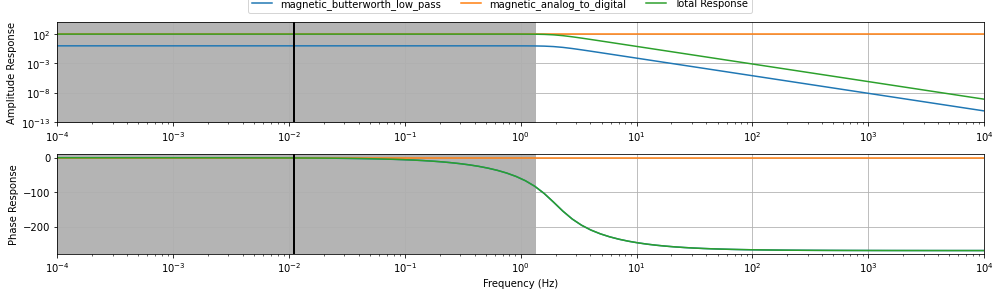

In [8]:
exts.channel_response_filter.plot_response(x_units="frequency")

## Remove Instrument Response

Here we will attempt to remove the instrument response to calibrate the data in physical units.  Create a few helper functions 

- `zero_pad` will pad an input array to a power of 2.

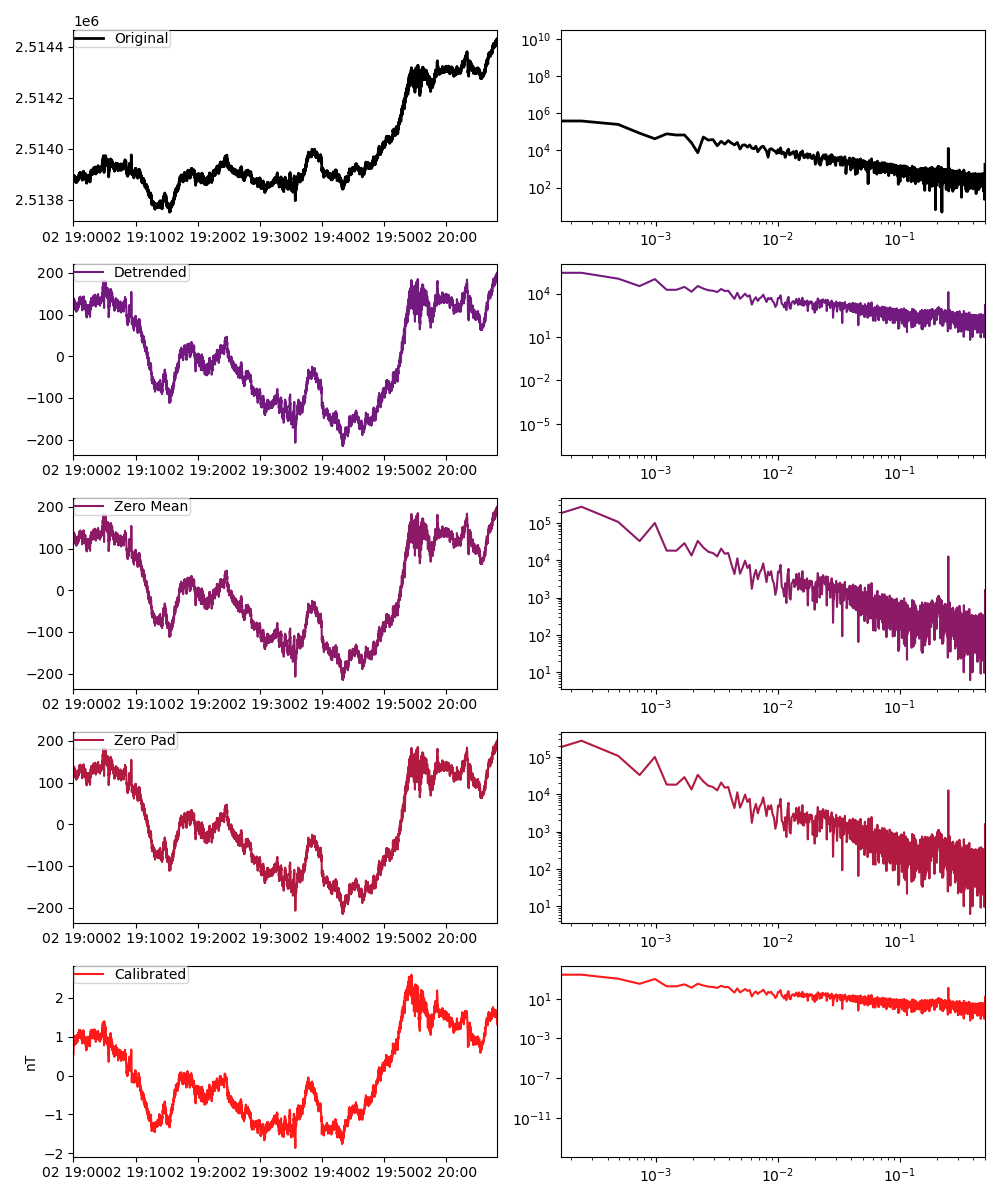

In [20]:
calibrated_ex = exts.remove_instrument_response(plot=True)

In [18]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

C:\Users\jpeacock\AppData\Local\Temp\11\ipykernel_9464\1879432517.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  l3, = ax_original.plot(np.array(frn_json["times"], dtype=np.datetime64), frn_ts, color=(.2, .1, .75))


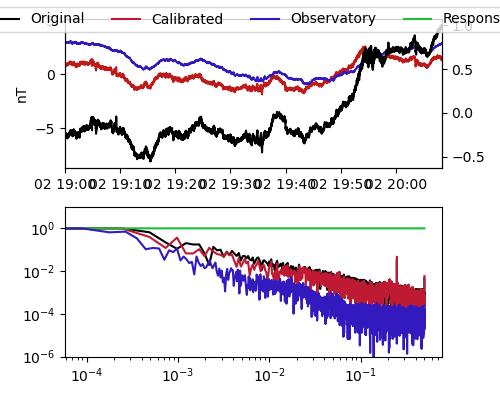

In [29]:
# plot normalized version of original and calibrated
fig = plt.figure(2, figsize=[5,4])
fig.clf()
ax_original = fig.add_subplot(2, 1, 1)
original_ts = exts.ts.copy()
original_ts = original_ts - original_ts.mean()
original_ts = original_ts / original_ts.max()
frn_ts = np.array(frn_json["values"][0]["values"], dtype=float)
frn_ts = signal.detrend(frn_ts, type="linear")
frn_ts = frn_ts - frn_ts.mean()
#frn_ts = frn_ts / frn_ts.max()
l1, = ax_original.twinx().plot(exts._ts.time, original_ts, color=(0, 0, 0))
l2, = ax_original.plot(exts._ts.time, calibrated_ex.ts, color=(.75, .1, .1))
l3, = ax_original.plot(np.array(frn_json["times"], dtype=np.datetime64), frn_ts, color=(.2, .1, .75))
ax_original.set_ylabel("nT")
ax_original.set_xlim((exts._ts.time[0], exts._ts.time[-1]))


ax_original_fft = fig.add_subplot(2, 1, 2)
f = np.fft.rfftfreq(original_ts.size, d=1)
original_fft = abs(np.fft.rfft(original_ts))
calibrated = abs(np.fft.rfft(calibrated_ex.ts))
response = abs(exts.channel_response_filter.complex_response(f))[::-1]
response[-1] = response[-2]
frn_spectra = abs(np.fft.rfft(frn_ts))
f_frn = np.fft.rfftfreq(frn_ts.size, d=1)
l1, = ax_original_fft.loglog(f, original_fft / original_fft.max(), color=(0, 0, 0))
l2, = ax_original_fft.loglog(f, calibrated / calibrated.max(), color=(.75, .1, .2))
l3, = ax_original_fft.loglog(f, response / response.max(), color=(.1, .75, .2))
l4, = ax_original_fft.loglog(f_frn, frn_spectra / frn_spectra.max(), color=(.2, .1, .75))
ax_original_fft.set_ylim((1E-6, 10))
fig.legend(
    [l1, l2, l4, l3], 
    ["Original", "Calibrated", "Observatory", "Response"],
    ncol=4,
    loc="upper center",
)

fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.resizable = True

fig.tight_layout()

plt.show()

In [ ]:
#m.close_mth5()